In [1]:
import pandas as pd
import plotly.express as px
import re
import torch
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments


c:\Users\Lenovo\.conda\envs\pii\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
email_pii = pd.read_csv("Data/pii_emails.csv")

In [3]:
print(email_pii.head(10))
print(email_pii['text'].iloc[1])

   message_id                                               text
0           1  From: ufields@example.net\r\nTo: hpeters@examp...
1           2  From: cguzman@example.com\r\nTo: uwilson@examp...
2           3  From: hallgregory@example.com\r\nTo: howellshe...
3           4  From: makaylariley@example.net\r\nTo: btaylor@...
4           5  From: edwardnavarro@example.com\r\nTo: kaylasi...
5           6  From: matthewdavis@example.net\r\nTo: christin...
6           7  From: asullivan@example.org\r\nTo: thernandez@...
7           8  From: egoodman@example.net\r\nTo: morsecrystal...
8           9  From: melissaarnold@example.org\r\nTo: fdunn@e...
9          10  From: alisonwilliams@example.com\r\nTo: gparso...
From: cguzman@example.com
To: uwilson@example.org
Subject: Important Account Update Tax ID: 940-82-8356 IBAN: GB07YZJP29744473359884 Bank Account: 9096795282 Credit Card: 4583441465276114 PPSN: 4356169AW

Dear Joel,

We have updated our terms and conditions. Please review the changes 

In [4]:
email_pii.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  20000 non-null  int64 
 1   text        20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [5]:
email_pii.describe()

,message_id
count,20000.000000
mean,10000.500000
std,5773.647028
min,1.000000
25%,5000.750000
50%,10000.500000
75%,15000.250000
max,20000.000000


In [6]:
email_pii.isnull().sum()

message_id    0
text          0
dtype: int64

In [7]:
#Check the distribution of PII fields
pii_kws = ["PPSN", "Credit Card","Address","IBAN","Phone Number","Tax ID", "From", "To"]
pii_counts = {kw: email_pii["text"].str.contains(kw, case=False).sum() for kw in pii_kws}
print(pii_counts)

pii_counts_df = pd.DataFrame(pii_counts.items(), columns=["PII field", "Count"])

fig = px.bar(pii_counts_df, x="PII field", y="Count", title="Distribution of PII fields in emails")
fig.show()

{'PPSN': 5795, 'Credit Card': 5772, 'Address': 5767, 'IBAN': 5701, 'Phone Number': 5721, 'Tax ID': 5716, 'From': 20000, 'To': 20000}


In [8]:
email_pii["email_len"] = email_pii["text"].apply(len)

print(email_pii["email_len"].describe())

fig = px.histogram(email_pii, x="email_len", title="Distribution of email lengths")
fig.show()

count    20000.000000
mean       361.089950
std         81.192087
min        237.000000
25%        306.000000
50%        335.000000
75%        423.000000
max        584.000000
Name: email_len, dtype: float64


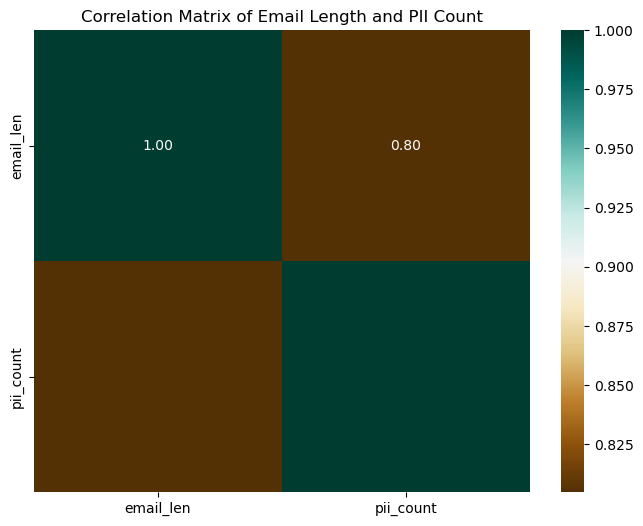

In [9]:
#Get the PII counts and find corelation with email length
email_pii['pii_count'] = email_pii['text'].apply(lambda x: sum([x.lower().count(kw.lower()) for kw in pii_kws]))
corelations = email_pii['email_len'].corr(email_pii['pii_count'])

import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = email_pii[['email_len', 'pii_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt='.2f')
plt.title('Correlation Matrix of Email Length and PII Count')
plt.show()

In [10]:
pii_patterns = {
    "Tax ID": r"\b\d{2}-\d{2}-\d{4}\b",
    "IBAN": r"\b[A-Z0-9]{15,34}\b",
    "Bank Account": r"\b\d{8,12}\b",
    "Credit Card": r"\b\d{13,19}\b",
    "PPSN": r"\b[0-9A-Z]{8,10}\b",
    "Phone Number": r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b",
    "Account Number": r"\b\d{8,12}\b",
    "Address": r"\b\d{1,5}\s[A-Za-z\s]{1,20}\b",
    "Email": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"
}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26692\2229593153.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



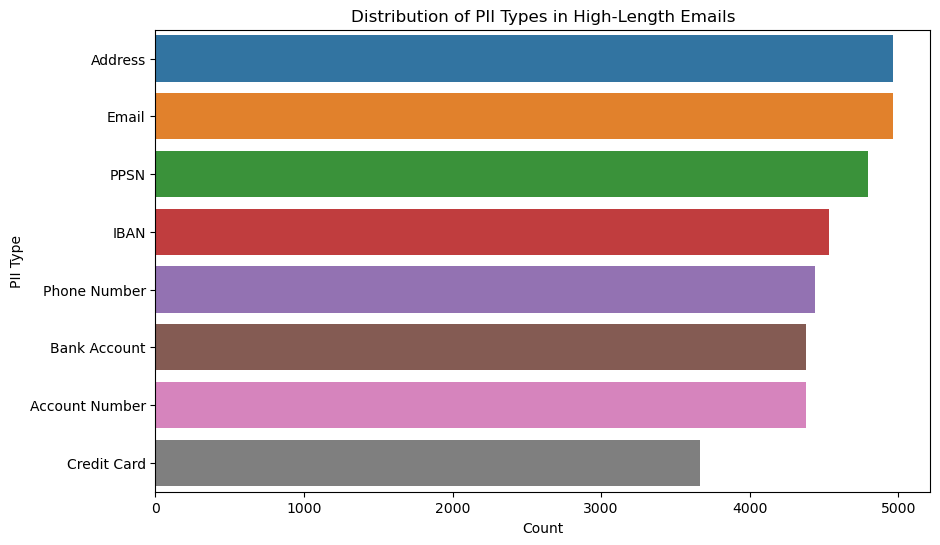

In [11]:
thresh = email_pii['email_len'].quantile(0.75)


high_len_emails = email_pii[email_pii['email_len'] > thresh]

def extract_piis(text):
    pii_types = []
    for label, pattern in pii_patterns.items():
        if re.search(pattern, text):
            pii_types.append(label)
    return pii_types

high_len_emails['pii_types'] = high_len_emails['text'].apply(extract_piis)

all_pii_labls = [pii for sublist in high_len_emails['pii_types'] for pii in sublist]


plt.figure(figsize=(10, 6))
sns.countplot(y=all_pii_labls, order=pd.Series(all_pii_labls).value_counts().index)
plt.title('Distribution of PII Types in High-Length Emails')
plt.xlabel('Count')
plt.ylabel('PII Type')
plt.show()

In [12]:
final_dataset = email_pii[['message_id', 'text']]

In [13]:
def rm_wildcards(text):
    return re.sub("[\r\n]+", " ", text)

In [14]:
final_dataset['text'] = final_dataset['text'].apply(rm_wildcards)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26692\393520320.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
final_dataset['text'].iloc[1]

'From: cguzman@example.com To: uwilson@example.org Subject: Important Account Update Tax ID: 940-82-8356 IBAN: GB07YZJP29744473359884 Bank Account: 9096795282 Credit Card: 4583441465276114 PPSN: 4356169AW Dear Joel, We have updated our terms and conditions. Please review the changes at your earliest convenience. Your account details are as follows: Account Number: 6940366308 Update Date: 1997-09-09 Best regards, Crawford Inc Phone Number: 426.405.8218'

In [16]:
def label_pii(text):
    labels = ["O"] * len(text)
    for label, pattern in pii_patterns.items():
        for match in re.finditer(pattern, text):
            start, end = match.span()
            labels[start:end] = [label] * (end - start)
    return labels

In [17]:
final_dataset['labels'] = final_dataset['text'].apply(label_pii)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26692\1818621034.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
final_dataset.head()

,message_id,text,labels
0,1,From: ufields@example.net To: hpeters@example....,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
1,2,From: cguzman@example.com To: uwilson@example....,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
2,3,From: hallgregory@example.com To: howellsheila...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
3,4,From: makaylariley@example.net To: btaylor@exa...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
4,5,From: edwardnavarro@example.com To: kaylasimps...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."


In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [20]:
label_list = ["O"] + list(pii_patterns.keys())
label_map = {label: i for i, label in enumerate(label_list)}

def encode_example(text, labels):
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=512)
    labels_ids = [label_map.get(label, label_map["O"]) for label in labels]
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
    return tokens, labels_ids

In [21]:
processed_data = []
for index, row in final_dataset.iterrows():
    text = row['text']
    labels = row['labels']
    tokens, labels_ids = encode_example(text, labels)
    processed_data.append({
        "text": text,
        "tokens": tokens,
        "labels": labels_ids
    })

processed_df = pd.DataFrame(processed_data)

In [22]:
processed_df.head()

,text,tokens,labels
0,From: ufields@example.net To: hpeters@example....,"[[CLS], from, :, u, ##fields, @, example, ., n...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
1,From: cguzman@example.com To: uwilson@example....,"[[CLS], from, :, c, ##gu, ##zman, @, example, ...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,From: hallgregory@example.com To: howellsheila...,"[[CLS], from, :, hall, ##gre, ##gor, ##y, @, e...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
3,From: makaylariley@example.net To: btaylor@exa...,"[[CLS], from, :, ma, ##ka, ##yla, ##ril, ##ey,...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
4,From: edwardnavarro@example.com To: kaylasimps...,"[[CLS], from, :, edward, ##na, ##var, ##ro, @,...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


In [23]:


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    labels = []

    for i, label in enumerate(examples['labels']):
        label_ids = label[:512] + [0] * (512 - len(label))
        labels.append(label_ids)
    tokenized_inputs['labels'] = torch.tensor(labels)
    return tokenized_inputs

In [24]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [25]:
from datasets import Dataset
dataset = Dataset.from_pandas(processed_df)

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

train_data = tokenized_dataset.train_test_split(test_size=0.2)['train']
test_data = tokenized_dataset.train_test_split(test_size=0.2)['test']


Map: 100%|██████████| 20000/20000 [00:07<00:00, 2622.20 examples/s]


In [26]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


In [27]:
import optuna
from transformers import EarlyStoppingCallback
def objective(trial):
    model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_list)).to(device)

    batch_size = trial.suggest_categorical('per_device_train_batch_size', [4, 8, 16])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 4)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        do_train=True,
        do_eval=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Return the evaluation metric (loss in this case)
    return eval_result['eval_loss']

# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print("Best hyperparameters: ", best_trial.params)

# Visualize optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

 40%|███▉      | 1190/3000 [29:08<43:35,  1.45s/it]

{'loss': 0.1301, 'grad_norm': 0.8603243827819824, 'learning_rate': 2.0775849524283368e-05, 'epoch': 1.19}


 40%|████      | 1200/3000 [29:22<41:30,  1.38s/it]

{'loss': 0.1397, 'grad_norm': 0.9558280110359192, 'learning_rate': 2.0661065825254177e-05, 'epoch': 1.2}


 40%|████      | 1210/3000 [29:36<41:43,  1.40s/it]

{'loss': 0.1437, 'grad_norm': 1.4541094303131104, 'learning_rate': 2.054628212622499e-05, 'epoch': 1.21}


 41%|████      | 1220/3000 [29:50<40:59,  1.38s/it]

{'loss': 0.1465, 'grad_norm': 0.7852457761764526, 'learning_rate': 2.04314984271958e-05, 'epoch': 1.22}


 41%|████      | 1230/3000 [30:04<40:20,  1.37s/it]

{'loss': 0.1533, 'grad_norm': 1.2206742763519287, 'learning_rate': 2.0316714728166608e-05, 'epoch': 1.23}


 41%|████▏     | 1240/3000 [30:17<40:21,  1.38s/it]

{'loss': 0.1446, 'grad_norm': 0.7918918132781982, 'learning_rate': 2.0201931029137417e-05, 'epoch': 1.24}


 42%|████▏     | 1250/3000 [30:31<38:58,  1.34s/it]

{'loss': 0.1448, 'grad_norm': 1.1747907400131226, 'learning_rate': 2.008714733010823e-05, 'epoch': 1.25}


 42%|████▏     | 1260/3000 [30:44<40:12,  1.39s/it]

{'loss': 0.1481, 'grad_norm': 1.0887597799301147, 'learning_rate': 1.997236363107904e-05, 'epoch': 1.26}


 42%|████▏     | 1270/3000 [30:58<38:46,  1.34s/it]

{'loss': 0.1381, 'grad_norm': 1.8687649965286255, 'learning_rate': 1.9857579932049848e-05, 'epoch': 1.27}


 43%|████▎     | 1280/3000 [31:11<38:22,  1.34s/it]

{'loss': 0.1417, 'grad_norm': 1.2951160669326782, 'learning_rate': 1.974279623302066e-05, 'epoch': 1.28}


 43%|████▎     | 1290/3000 [31:25<38:51,  1.36s/it]

{'loss': 0.1648, 'grad_norm': 1.091568112373352, 'learning_rate': 1.9628012533991466e-05, 'epoch': 1.29}


 43%|████▎     | 1300/3000 [31:39<38:37,  1.36s/it]

{'loss': 0.1548, 'grad_norm': 1.510114312171936, 'learning_rate': 1.951322883496228e-05, 'epoch': 1.3}


 44%|████▎     | 1310/3000 [31:52<38:22,  1.36s/it]

{'loss': 0.157, 'grad_norm': 1.0392799377441406, 'learning_rate': 1.939844513593309e-05, 'epoch': 1.31}


 44%|████▍     | 1320/3000 [32:06<37:40,  1.35s/it]

{'loss': 0.1483, 'grad_norm': 0.8639474511146545, 'learning_rate': 1.92836614369039e-05, 'epoch': 1.32}


 44%|████▍     | 1330/3000 [32:20<38:49,  1.39s/it]

{'loss': 0.143, 'grad_norm': 0.8378864526748657, 'learning_rate': 1.916887773787471e-05, 'epoch': 1.33}


 45%|████▍     | 1340/3000 [32:34<38:38,  1.40s/it]

{'loss': 0.1538, 'grad_norm': 0.7426865696907043, 'learning_rate': 1.905409403884552e-05, 'epoch': 1.34}


 45%|████▌     | 1350/3000 [32:47<37:37,  1.37s/it]

{'loss': 0.1406, 'grad_norm': 0.6769683957099915, 'learning_rate': 1.893931033981633e-05, 'epoch': 1.35}


 45%|████▌     | 1360/3000 [33:01<37:16,  1.36s/it]

{'loss': 0.1393, 'grad_norm': 0.8124074339866638, 'learning_rate': 1.882452664078714e-05, 'epoch': 1.36}


 46%|████▌     | 1370/3000 [33:14<36:27,  1.34s/it]

{'loss': 0.1312, 'grad_norm': 0.8663885593414307, 'learning_rate': 1.870974294175795e-05, 'epoch': 1.37}


 46%|████▌     | 1380/3000 [33:28<36:15,  1.34s/it]

{'loss': 0.1218, 'grad_norm': 0.6636225581169128, 'learning_rate': 1.8594959242728762e-05, 'epoch': 1.38}


 46%|████▋     | 1390/3000 [33:42<36:25,  1.36s/it]

{'loss': 0.1403, 'grad_norm': 0.7666828632354736, 'learning_rate': 1.8480175543699567e-05, 'epoch': 1.39}


 47%|████▋     | 1400/3000 [33:55<36:34,  1.37s/it]

{'loss': 0.1231, 'grad_norm': 0.9258958697319031, 'learning_rate': 1.836539184467038e-05, 'epoch': 1.4}


 47%|████▋     | 1410/3000 [34:09<35:56,  1.36s/it]

{'loss': 0.1302, 'grad_norm': 1.5948501825332642, 'learning_rate': 1.8250608145641193e-05, 'epoch': 1.41}


 47%|████▋     | 1420/3000 [34:23<35:39,  1.35s/it]

{'loss': 0.1743, 'grad_norm': 0.7953675985336304, 'learning_rate': 1.8135824446611998e-05, 'epoch': 1.42}


 48%|████▊     | 1430/3000 [34:36<35:27,  1.36s/it]

{'loss': 0.1505, 'grad_norm': 0.9688964486122131, 'learning_rate': 1.802104074758281e-05, 'epoch': 1.43}


 48%|████▊     | 1440/3000 [34:50<35:02,  1.35s/it]

{'loss': 0.1346, 'grad_norm': 0.6335635185241699, 'learning_rate': 1.790625704855362e-05, 'epoch': 1.44}


 48%|████▊     | 1450/3000 [35:03<35:15,  1.36s/it]

{'loss': 0.1345, 'grad_norm': 1.2997699975967407, 'learning_rate': 1.7791473349524432e-05, 'epoch': 1.45}


 49%|████▊     | 1460/3000 [35:17<35:09,  1.37s/it]

{'loss': 0.1468, 'grad_norm': 0.9020029902458191, 'learning_rate': 1.767668965049524e-05, 'epoch': 1.46}


 49%|████▉     | 1470/3000 [35:31<34:51,  1.37s/it]

{'loss': 0.1321, 'grad_norm': 1.1799753904342651, 'learning_rate': 1.756190595146605e-05, 'epoch': 1.47}


 49%|████▉     | 1480/3000 [35:44<34:41,  1.37s/it]

{'loss': 0.1554, 'grad_norm': 0.5644477009773254, 'learning_rate': 1.7447122252436863e-05, 'epoch': 1.48}


 50%|████▉     | 1490/3000 [35:58<34:05,  1.35s/it]

{'loss': 0.1462, 'grad_norm': 0.9857704043388367, 'learning_rate': 1.733233855340767e-05, 'epoch': 1.49}


 50%|█████     | 1500/3000 [36:12<34:00,  1.36s/it]

{'loss': 0.1441, 'grad_norm': 1.0909291505813599, 'learning_rate': 1.721755485437848e-05, 'epoch': 1.5}


 50%|█████     | 1510/3000 [36:25<34:07,  1.37s/it]

{'loss': 0.1392, 'grad_norm': 0.853110134601593, 'learning_rate': 1.710277115534929e-05, 'epoch': 1.51}


 51%|█████     | 1520/3000 [36:39<33:22,  1.35s/it]

{'loss': 0.141, 'grad_norm': 0.6215421557426453, 'learning_rate': 1.6987987456320103e-05, 'epoch': 1.52}


 51%|█████     | 1530/3000 [36:53<33:39,  1.37s/it]

{'loss': 0.1255, 'grad_norm': 0.6122446656227112, 'learning_rate': 1.6873203757290912e-05, 'epoch': 1.53}


 51%|█████▏    | 1540/3000 [37:06<32:45,  1.35s/it]

{'loss': 0.16, 'grad_norm': 1.3425767421722412, 'learning_rate': 1.675842005826172e-05, 'epoch': 1.54}


 52%|█████▏    | 1550/3000 [37:20<33:00,  1.37s/it]

{'loss': 0.1288, 'grad_norm': 0.8034384846687317, 'learning_rate': 1.6643636359232534e-05, 'epoch': 1.55}


 52%|█████▏    | 1560/3000 [37:34<32:40,  1.36s/it]

{'loss': 0.1377, 'grad_norm': 0.9185918569564819, 'learning_rate': 1.6528852660203343e-05, 'epoch': 1.56}


 52%|█████▏    | 1570/3000 [37:47<32:50,  1.38s/it]

{'loss': 0.1252, 'grad_norm': 0.8880284428596497, 'learning_rate': 1.6414068961174152e-05, 'epoch': 1.57}


 53%|█████▎    | 1580/3000 [38:01<32:34,  1.38s/it]

{'loss': 0.1481, 'grad_norm': 0.9101992249488831, 'learning_rate': 1.629928526214496e-05, 'epoch': 1.58}


 53%|█████▎    | 1590/3000 [38:15<31:59,  1.36s/it]

{'loss': 0.1148, 'grad_norm': 1.0566949844360352, 'learning_rate': 1.618450156311577e-05, 'epoch': 1.59}


 53%|█████▎    | 1600/3000 [38:28<32:14,  1.38s/it]

{'loss': 0.1324, 'grad_norm': 1.242954969406128, 'learning_rate': 1.6069717864086583e-05, 'epoch': 1.6}


 54%|█████▎    | 1610/3000 [38:42<31:07,  1.34s/it]

{'loss': 0.1397, 'grad_norm': 1.333208680152893, 'learning_rate': 1.5954934165057392e-05, 'epoch': 1.61}


 54%|█████▍    | 1620/3000 [38:55<31:13,  1.36s/it]

{'loss': 0.131, 'grad_norm': 0.9099797010421753, 'learning_rate': 1.5840150466028205e-05, 'epoch': 1.62}


 54%|█████▍    | 1630/3000 [39:09<31:23,  1.37s/it]

{'loss': 0.1267, 'grad_norm': 2.6983747482299805, 'learning_rate': 1.5725366766999014e-05, 'epoch': 1.63}


 55%|█████▍    | 1640/3000 [39:23<30:58,  1.37s/it]

{'loss': 0.1369, 'grad_norm': 0.9840600490570068, 'learning_rate': 1.5610583067969823e-05, 'epoch': 1.64}


 55%|█████▌    | 1650/3000 [39:36<30:49,  1.37s/it]

{'loss': 0.1187, 'grad_norm': 2.187309741973877, 'learning_rate': 1.5495799368940635e-05, 'epoch': 1.65}


 55%|█████▌    | 1660/3000 [39:50<30:14,  1.35s/it]

{'loss': 0.138, 'grad_norm': 1.6349518299102783, 'learning_rate': 1.5381015669911444e-05, 'epoch': 1.66}


 56%|█████▌    | 1670/3000 [40:04<29:42,  1.34s/it]

{'loss': 0.1081, 'grad_norm': 0.9162396192550659, 'learning_rate': 1.5266231970882254e-05, 'epoch': 1.67}


 56%|█████▌    | 1680/3000 [40:17<29:46,  1.35s/it]

{'loss': 0.1323, 'grad_norm': 1.0899543762207031, 'learning_rate': 1.5151448271853064e-05, 'epoch': 1.68}


 56%|█████▋    | 1690/3000 [40:31<29:58,  1.37s/it]

{'loss': 0.1351, 'grad_norm': 0.9283936619758606, 'learning_rate': 1.5036664572823874e-05, 'epoch': 1.69}


 57%|█████▋    | 1700/3000 [40:44<29:04,  1.34s/it]

{'loss': 0.1243, 'grad_norm': 1.0923418998718262, 'learning_rate': 1.4921880873794684e-05, 'epoch': 1.7}


 57%|█████▋    | 1710/3000 [40:58<29:08,  1.36s/it]

{'loss': 0.1461, 'grad_norm': 1.5746015310287476, 'learning_rate': 1.4807097174765494e-05, 'epoch': 1.71}


 57%|█████▋    | 1720/3000 [41:12<29:16,  1.37s/it]

{'loss': 0.1289, 'grad_norm': 1.2122623920440674, 'learning_rate': 1.4692313475736304e-05, 'epoch': 1.72}


 58%|█████▊    | 1730/3000 [41:25<28:47,  1.36s/it]

{'loss': 0.1179, 'grad_norm': 1.3082659244537354, 'learning_rate': 1.4577529776707115e-05, 'epoch': 1.73}


 58%|█████▊    | 1740/3000 [41:39<28:46,  1.37s/it]

{'loss': 0.1312, 'grad_norm': 0.6562691926956177, 'learning_rate': 1.4462746077677924e-05, 'epoch': 1.74}


 58%|█████▊    | 1750/3000 [41:53<28:55,  1.39s/it]

{'loss': 0.1239, 'grad_norm': 1.0190778970718384, 'learning_rate': 1.4347962378648735e-05, 'epoch': 1.75}


 59%|█████▊    | 1760/3000 [42:06<27:29,  1.33s/it]

{'loss': 0.1332, 'grad_norm': 1.2683141231536865, 'learning_rate': 1.4233178679619544e-05, 'epoch': 1.76}


 59%|█████▉    | 1770/3000 [42:20<27:30,  1.34s/it]

{'loss': 0.1323, 'grad_norm': 1.0365016460418701, 'learning_rate': 1.4118394980590353e-05, 'epoch': 1.77}


 59%|█████▉    | 1780/3000 [42:33<27:31,  1.35s/it]

{'loss': 0.1309, 'grad_norm': 1.2124301195144653, 'learning_rate': 1.4003611281561166e-05, 'epoch': 1.78}


 60%|█████▉    | 1790/3000 [42:47<27:28,  1.36s/it]

{'loss': 0.1288, 'grad_norm': 0.7812409996986389, 'learning_rate': 1.3888827582531975e-05, 'epoch': 1.79}


 60%|██████    | 1800/3000 [43:00<27:04,  1.35s/it]

{'loss': 0.1364, 'grad_norm': 1.1495319604873657, 'learning_rate': 1.3774043883502786e-05, 'epoch': 1.8}


 60%|██████    | 1810/3000 [43:14<27:06,  1.37s/it]

{'loss': 0.1323, 'grad_norm': 0.8463623523712158, 'learning_rate': 1.3659260184473595e-05, 'epoch': 1.81}


 61%|██████    | 1820/3000 [43:28<27:28,  1.40s/it]

{'loss': 0.1123, 'grad_norm': 1.4929440021514893, 'learning_rate': 1.3544476485444404e-05, 'epoch': 1.82}


 61%|██████    | 1830/3000 [43:41<25:59,  1.33s/it]

{'loss': 0.1113, 'grad_norm': 0.9644937515258789, 'learning_rate': 1.3429692786415217e-05, 'epoch': 1.83}


 61%|██████▏   | 1840/3000 [43:55<26:40,  1.38s/it]

{'loss': 0.1208, 'grad_norm': 2.16695237159729, 'learning_rate': 1.3314909087386026e-05, 'epoch': 1.84}


 62%|██████▏   | 1850/3000 [44:08<25:24,  1.33s/it]

{'loss': 0.1168, 'grad_norm': 1.2552974224090576, 'learning_rate': 1.3200125388356837e-05, 'epoch': 1.85}


 62%|██████▏   | 1860/3000 [44:22<26:30,  1.40s/it]

{'loss': 0.1247, 'grad_norm': 0.8215729594230652, 'learning_rate': 1.3085341689327646e-05, 'epoch': 1.86}


 62%|██████▏   | 1870/3000 [44:36<25:51,  1.37s/it]

{'loss': 0.1112, 'grad_norm': 0.898025393486023, 'learning_rate': 1.2970557990298455e-05, 'epoch': 1.87}


 63%|██████▎   | 1880/3000 [44:49<25:11,  1.35s/it]

{'loss': 0.12, 'grad_norm': 1.4241739511489868, 'learning_rate': 1.2855774291269267e-05, 'epoch': 1.88}


 63%|██████▎   | 1890/3000 [45:03<25:23,  1.37s/it]

{'loss': 0.1284, 'grad_norm': 0.8729521632194519, 'learning_rate': 1.2740990592240076e-05, 'epoch': 1.89}


 63%|██████▎   | 1900/3000 [45:17<24:30,  1.34s/it]

{'loss': 0.1296, 'grad_norm': 0.9326311945915222, 'learning_rate': 1.2626206893210886e-05, 'epoch': 1.9}


 64%|██████▎   | 1910/3000 [45:31<24:47,  1.36s/it]

{'loss': 0.1233, 'grad_norm': 0.7940220236778259, 'learning_rate': 1.2511423194181696e-05, 'epoch': 1.91}


 64%|██████▍   | 1920/3000 [45:44<24:20,  1.35s/it]

{'loss': 0.1386, 'grad_norm': 2.4130241870880127, 'learning_rate': 1.2396639495152506e-05, 'epoch': 1.92}


 64%|██████▍   | 1930/3000 [45:58<23:53,  1.34s/it]

{'loss': 0.1166, 'grad_norm': 0.5808426737785339, 'learning_rate': 1.2281855796123318e-05, 'epoch': 1.93}


 65%|██████▍   | 1940/3000 [46:11<24:07,  1.37s/it]

{'loss': 0.1443, 'grad_norm': 1.175656795501709, 'learning_rate': 1.2167072097094127e-05, 'epoch': 1.94}


 65%|██████▌   | 1950/3000 [46:25<23:55,  1.37s/it]

{'loss': 0.1237, 'grad_norm': 1.4713832139968872, 'learning_rate': 1.2052288398064936e-05, 'epoch': 1.95}


 65%|██████▌   | 1960/3000 [46:38<23:30,  1.36s/it]

{'loss': 0.1427, 'grad_norm': 0.8208460807800293, 'learning_rate': 1.1937504699035747e-05, 'epoch': 1.96}


 66%|██████▌   | 1970/3000 [46:52<22:46,  1.33s/it]

{'loss': 0.1153, 'grad_norm': 1.772746205329895, 'learning_rate': 1.1822721000006556e-05, 'epoch': 1.97}


 66%|██████▌   | 1980/3000 [47:05<22:47,  1.34s/it]

{'loss': 0.1373, 'grad_norm': 0.8676539063453674, 'learning_rate': 1.1707937300977369e-05, 'epoch': 1.98}


 66%|██████▋   | 1990/3000 [47:19<22:22,  1.33s/it]

{'loss': 0.1265, 'grad_norm': 0.899996817111969, 'learning_rate': 1.1593153601948178e-05, 'epoch': 1.99}


 67%|██████▋   | 2000/3000 [47:32<22:12,  1.33s/it]

{'loss': 0.1346, 'grad_norm': 0.7358013391494751, 'learning_rate': 1.1478369902918987e-05, 'epoch': 2.0}



 67%|██████▋   | 2000/3000 [49:28<22:12,  1.33s/it]

{'eval_loss': 0.10219688713550568, 'eval_runtime': 115.3153, 'eval_samples_per_second': 34.687, 'eval_steps_per_second': 2.168, 'epoch': 2.0}


 67%|██████▋   | 2010/3000 [49:42<45:48,  2.78s/it]   

{'loss': 0.1169, 'grad_norm': 0.6426290273666382, 'learning_rate': 1.1363586203889798e-05, 'epoch': 2.01}


 67%|██████▋   | 2020/3000 [49:56<22:57,  1.41s/it]

{'loss': 0.1028, 'grad_norm': 1.3455455303192139, 'learning_rate': 1.1248802504860607e-05, 'epoch': 2.02}


 68%|██████▊   | 2030/3000 [50:09<21:46,  1.35s/it]

{'loss': 0.1267, 'grad_norm': 1.2933614253997803, 'learning_rate': 1.1134018805831418e-05, 'epoch': 2.03}


 68%|██████▊   | 2040/3000 [50:23<21:44,  1.36s/it]

{'loss': 0.1187, 'grad_norm': 0.7599163055419922, 'learning_rate': 1.1019235106802229e-05, 'epoch': 2.04}


 68%|██████▊   | 2050/3000 [50:36<21:18,  1.35s/it]

{'loss': 0.1312, 'grad_norm': 1.3603098392486572, 'learning_rate': 1.0904451407773038e-05, 'epoch': 2.05}


 69%|██████▊   | 2060/3000 [50:50<21:01,  1.34s/it]

{'loss': 0.115, 'grad_norm': 1.0497596263885498, 'learning_rate': 1.0789667708743849e-05, 'epoch': 2.06}


 69%|██████▉   | 2070/3000 [51:04<21:31,  1.39s/it]

{'loss': 0.1454, 'grad_norm': 1.2100999355316162, 'learning_rate': 1.0674884009714658e-05, 'epoch': 2.07}


 69%|██████▉   | 2080/3000 [51:17<20:46,  1.36s/it]

{'loss': 0.1248, 'grad_norm': 1.0126540660858154, 'learning_rate': 1.0560100310685469e-05, 'epoch': 2.08}


 70%|██████▉   | 2090/3000 [51:31<20:33,  1.36s/it]

{'loss': 0.1227, 'grad_norm': 1.1158314943313599, 'learning_rate': 1.044531661165628e-05, 'epoch': 2.09}


 70%|███████   | 2100/3000 [51:45<20:50,  1.39s/it]

{'loss': 0.1213, 'grad_norm': 0.8118246793746948, 'learning_rate': 1.0330532912627089e-05, 'epoch': 2.1}


 70%|███████   | 2110/3000 [51:58<19:58,  1.35s/it]

{'loss': 0.1208, 'grad_norm': 1.530423641204834, 'learning_rate': 1.02157492135979e-05, 'epoch': 2.11}


 71%|███████   | 2120/3000 [52:12<19:43,  1.35s/it]

{'loss': 0.1073, 'grad_norm': 1.4447587728500366, 'learning_rate': 1.0100965514568708e-05, 'epoch': 2.12}


 71%|███████   | 2130/3000 [52:25<19:37,  1.35s/it]

{'loss': 0.119, 'grad_norm': 1.0431872606277466, 'learning_rate': 9.98618181553952e-06, 'epoch': 2.13}


 71%|███████▏  | 2140/3000 [52:39<19:25,  1.36s/it]

{'loss': 0.1168, 'grad_norm': 0.8637111783027649, 'learning_rate': 9.87139811651033e-06, 'epoch': 2.14}


 72%|███████▏  | 2150/3000 [52:52<19:23,  1.37s/it]

{'loss': 0.1012, 'grad_norm': 0.5474191904067993, 'learning_rate': 9.75661441748114e-06, 'epoch': 2.15}


 72%|███████▏  | 2160/3000 [53:06<18:52,  1.35s/it]

{'loss': 0.1123, 'grad_norm': 1.2441104650497437, 'learning_rate': 9.64183071845195e-06, 'epoch': 2.16}


 72%|███████▏  | 2170/3000 [53:20<18:37,  1.35s/it]

{'loss': 0.1255, 'grad_norm': 0.8422367572784424, 'learning_rate': 9.52704701942276e-06, 'epoch': 2.17}


 73%|███████▎  | 2180/3000 [53:33<18:21,  1.34s/it]

{'loss': 0.1094, 'grad_norm': 1.1139613389968872, 'learning_rate': 9.41226332039357e-06, 'epoch': 2.18}


 73%|███████▎  | 2190/3000 [53:46<18:05,  1.34s/it]

{'loss': 0.1048, 'grad_norm': 0.7546976208686829, 'learning_rate': 9.297479621364381e-06, 'epoch': 2.19}


 73%|███████▎  | 2200/3000 [54:00<18:15,  1.37s/it]

{'loss': 0.1155, 'grad_norm': 1.008582353591919, 'learning_rate': 9.18269592233519e-06, 'epoch': 2.2}


 74%|███████▎  | 2210/3000 [54:14<17:28,  1.33s/it]

{'loss': 0.1059, 'grad_norm': 0.6145505309104919, 'learning_rate': 9.067912223305999e-06, 'epoch': 2.21}


 74%|███████▍  | 2220/3000 [54:27<17:42,  1.36s/it]

{'loss': 0.1265, 'grad_norm': 1.565442681312561, 'learning_rate': 8.95312852427681e-06, 'epoch': 2.22}


 74%|███████▍  | 2230/3000 [54:41<17:24,  1.36s/it]

{'loss': 0.1158, 'grad_norm': 0.9652581810951233, 'learning_rate': 8.83834482524762e-06, 'epoch': 2.23}


 75%|███████▍  | 2240/3000 [54:54<17:24,  1.37s/it]

{'loss': 0.1184, 'grad_norm': 0.8924169540405273, 'learning_rate': 8.723561126218432e-06, 'epoch': 2.24}


 75%|███████▌  | 2250/3000 [55:08<17:03,  1.37s/it]

{'loss': 0.1279, 'grad_norm': 1.7297511100769043, 'learning_rate': 8.60877742718924e-06, 'epoch': 2.25}


 75%|███████▌  | 2260/3000 [55:22<16:34,  1.34s/it]

{'loss': 0.1246, 'grad_norm': 1.1811939477920532, 'learning_rate': 8.493993728160052e-06, 'epoch': 2.26}


 76%|███████▌  | 2270/3000 [55:35<16:24,  1.35s/it]

{'loss': 0.1019, 'grad_norm': 1.608459711074829, 'learning_rate': 8.37921002913086e-06, 'epoch': 2.27}


 76%|███████▌  | 2280/3000 [55:49<16:12,  1.35s/it]

{'loss': 0.1093, 'grad_norm': 0.8108771443367004, 'learning_rate': 8.264426330101672e-06, 'epoch': 2.28}


 76%|███████▋  | 2290/3000 [56:03<15:55,  1.35s/it]

{'loss': 0.1058, 'grad_norm': 1.151747226715088, 'learning_rate': 8.14964263107248e-06, 'epoch': 2.29}


 77%|███████▋  | 2300/3000 [56:16<15:52,  1.36s/it]

{'loss': 0.1054, 'grad_norm': 0.8354359269142151, 'learning_rate': 8.034858932043291e-06, 'epoch': 2.3}


 77%|███████▋  | 2310/3000 [56:30<15:52,  1.38s/it]

{'loss': 0.1325, 'grad_norm': 0.9471995830535889, 'learning_rate': 7.920075233014102e-06, 'epoch': 2.31}


 77%|███████▋  | 2320/3000 [56:43<15:15,  1.35s/it]

{'loss': 0.1228, 'grad_norm': 0.8828275799751282, 'learning_rate': 7.805291533984911e-06, 'epoch': 2.32}


 78%|███████▊  | 2330/3000 [56:57<15:24,  1.38s/it]

{'loss': 0.1103, 'grad_norm': 0.8842206597328186, 'learning_rate': 7.690507834955722e-06, 'epoch': 2.33}


 78%|███████▊  | 2340/3000 [57:10<14:44,  1.34s/it]

{'loss': 0.1119, 'grad_norm': 0.7720827460289001, 'learning_rate': 7.575724135926532e-06, 'epoch': 2.34}


 78%|███████▊  | 2350/3000 [57:24<14:27,  1.33s/it]

{'loss': 0.1145, 'grad_norm': 0.9588665962219238, 'learning_rate': 7.460940436897342e-06, 'epoch': 2.35}


 79%|███████▊  | 2360/3000 [57:37<14:11,  1.33s/it]

{'loss': 0.1129, 'grad_norm': 0.7197270393371582, 'learning_rate': 7.346156737868152e-06, 'epoch': 2.36}


 79%|███████▉  | 2370/3000 [57:51<14:29,  1.38s/it]

{'loss': 0.118, 'grad_norm': 1.0161365270614624, 'learning_rate': 7.231373038838962e-06, 'epoch': 2.37}


 79%|███████▉  | 2380/3000 [58:05<14:15,  1.38s/it]

{'loss': 0.1034, 'grad_norm': 1.4211978912353516, 'learning_rate': 7.116589339809772e-06, 'epoch': 2.38}


 80%|███████▉  | 2390/3000 [58:18<13:56,  1.37s/it]

{'loss': 0.1088, 'grad_norm': 1.2965385913848877, 'learning_rate': 7.001805640780583e-06, 'epoch': 2.39}


 80%|████████  | 2400/3000 [58:32<13:27,  1.35s/it]

{'loss': 0.117, 'grad_norm': 0.6641297936439514, 'learning_rate': 6.887021941751393e-06, 'epoch': 2.4}


 80%|████████  | 2410/3000 [58:46<13:30,  1.37s/it]

{'loss': 0.1308, 'grad_norm': 0.9194287657737732, 'learning_rate': 6.772238242722202e-06, 'epoch': 2.41}


 81%|████████  | 2420/3000 [58:59<12:52,  1.33s/it]

{'loss': 0.104, 'grad_norm': 1.1145485639572144, 'learning_rate': 6.657454543693013e-06, 'epoch': 2.42}


 81%|████████  | 2430/3000 [59:13<12:44,  1.34s/it]

{'loss': 0.1205, 'grad_norm': 0.7968235611915588, 'learning_rate': 6.542670844663823e-06, 'epoch': 2.43}


 81%|████████▏ | 2440/3000 [59:26<12:45,  1.37s/it]

{'loss': 0.1089, 'grad_norm': 1.1287493705749512, 'learning_rate': 6.427887145634634e-06, 'epoch': 2.44}


 82%|████████▏ | 2450/3000 [59:40<12:32,  1.37s/it]

{'loss': 0.1177, 'grad_norm': 1.3662123680114746, 'learning_rate': 6.313103446605443e-06, 'epoch': 2.45}


 82%|████████▏ | 2460/3000 [59:54<12:18,  1.37s/it]

{'loss': 0.1223, 'grad_norm': 1.1218940019607544, 'learning_rate': 6.198319747576253e-06, 'epoch': 2.46}


 82%|████████▏ | 2470/3000 [1:00:07<12:00,  1.36s/it]

{'loss': 0.1189, 'grad_norm': 0.9169337749481201, 'learning_rate': 6.083536048547064e-06, 'epoch': 2.47}


 83%|████████▎ | 2480/3000 [1:00:21<12:06,  1.40s/it]

{'loss': 0.1113, 'grad_norm': 1.121509075164795, 'learning_rate': 5.968752349517874e-06, 'epoch': 2.48}


 83%|████████▎ | 2490/3000 [1:00:35<11:25,  1.34s/it]

{'loss': 0.117, 'grad_norm': 1.1449443101882935, 'learning_rate': 5.853968650488684e-06, 'epoch': 2.49}


 83%|████████▎ | 2500/3000 [1:00:48<11:07,  1.33s/it]

{'loss': 0.111, 'grad_norm': 0.9937271475791931, 'learning_rate': 5.7391849514594935e-06, 'epoch': 2.5}


 84%|████████▎ | 2510/3000 [1:01:02<11:10,  1.37s/it]

{'loss': 0.1221, 'grad_norm': 1.5579026937484741, 'learning_rate': 5.6244012524303035e-06, 'epoch': 2.51}


 84%|████████▍ | 2520/3000 [1:01:15<11:13,  1.40s/it]

{'loss': 0.1224, 'grad_norm': 1.0307406187057495, 'learning_rate': 5.509617553401114e-06, 'epoch': 2.52}


 84%|████████▍ | 2530/3000 [1:01:29<10:34,  1.35s/it]

{'loss': 0.0999, 'grad_norm': 0.8888050317764282, 'learning_rate': 5.394833854371924e-06, 'epoch': 2.53}


 85%|████████▍ | 2540/3000 [1:01:42<10:21,  1.35s/it]

{'loss': 0.1021, 'grad_norm': 1.3792239427566528, 'learning_rate': 5.280050155342734e-06, 'epoch': 2.54}


 85%|████████▌ | 2550/3000 [1:01:56<10:01,  1.34s/it]

{'loss': 0.1031, 'grad_norm': 0.6100726127624512, 'learning_rate': 5.165266456313544e-06, 'epoch': 2.55}


 85%|████████▌ | 2560/3000 [1:02:09<09:46,  1.33s/it]

{'loss': 0.1086, 'grad_norm': 0.9483199715614319, 'learning_rate': 5.050482757284354e-06, 'epoch': 2.56}


 86%|████████▌ | 2570/3000 [1:02:23<09:38,  1.35s/it]

{'loss': 0.1213, 'grad_norm': 1.2450083494186401, 'learning_rate': 4.935699058255165e-06, 'epoch': 2.57}


 86%|████████▌ | 2580/3000 [1:02:36<09:28,  1.35s/it]

{'loss': 0.1283, 'grad_norm': 1.3236768245697021, 'learning_rate': 4.820915359225975e-06, 'epoch': 2.58}


 86%|████████▋ | 2590/3000 [1:02:50<09:07,  1.34s/it]

{'loss': 0.087, 'grad_norm': 0.9907203912734985, 'learning_rate': 4.706131660196785e-06, 'epoch': 2.59}


 87%|████████▋ | 2600/3000 [1:03:03<09:06,  1.37s/it]

{'loss': 0.119, 'grad_norm': 1.132650375366211, 'learning_rate': 4.591347961167595e-06, 'epoch': 2.6}


 87%|████████▋ | 2610/3000 [1:03:17<08:45,  1.35s/it]

{'loss': 0.1022, 'grad_norm': 1.2183454036712646, 'learning_rate': 4.476564262138405e-06, 'epoch': 2.61}


 87%|████████▋ | 2620/3000 [1:03:30<08:34,  1.35s/it]

{'loss': 0.1029, 'grad_norm': 1.0309799909591675, 'learning_rate': 4.361780563109216e-06, 'epoch': 2.62}


 88%|████████▊ | 2630/3000 [1:03:44<08:16,  1.34s/it]

{'loss': 0.1156, 'grad_norm': 1.247340440750122, 'learning_rate': 4.246996864080026e-06, 'epoch': 2.63}


 88%|████████▊ | 2640/3000 [1:03:58<08:03,  1.34s/it]

{'loss': 0.1249, 'grad_norm': 1.0915364027023315, 'learning_rate': 4.132213165050836e-06, 'epoch': 2.64}


 88%|████████▊ | 2650/3000 [1:04:11<07:55,  1.36s/it]

{'loss': 0.1108, 'grad_norm': 0.7725615501403809, 'learning_rate': 4.017429466021646e-06, 'epoch': 2.65}


 89%|████████▊ | 2660/3000 [1:04:25<07:38,  1.35s/it]

{'loss': 0.1029, 'grad_norm': 1.423827052116394, 'learning_rate': 3.902645766992456e-06, 'epoch': 2.66}


 89%|████████▉ | 2670/3000 [1:04:38<07:28,  1.36s/it]

{'loss': 0.1037, 'grad_norm': 1.8649163246154785, 'learning_rate': 3.787862067963266e-06, 'epoch': 2.67}


 89%|████████▉ | 2680/3000 [1:04:52<07:16,  1.37s/it]

{'loss': 0.1294, 'grad_norm': 1.07472825050354, 'learning_rate': 3.673078368934076e-06, 'epoch': 2.68}


 90%|████████▉ | 2690/3000 [1:05:05<06:52,  1.33s/it]

{'loss': 0.1294, 'grad_norm': 0.9039894938468933, 'learning_rate': 3.558294669904886e-06, 'epoch': 2.69}


 90%|█████████ | 2700/3000 [1:05:19<06:50,  1.37s/it]

{'loss': 0.1238, 'grad_norm': 0.9561342000961304, 'learning_rate': 3.4435109708756965e-06, 'epoch': 2.7}


 90%|█████████ | 2710/3000 [1:05:32<06:20,  1.31s/it]

{'loss': 0.1338, 'grad_norm': 1.3597756624221802, 'learning_rate': 3.3287272718465064e-06, 'epoch': 2.71}


 91%|█████████ | 2720/3000 [1:05:46<06:16,  1.34s/it]

{'loss': 0.1107, 'grad_norm': 0.9062995910644531, 'learning_rate': 3.213943572817317e-06, 'epoch': 2.72}


 91%|█████████ | 2730/3000 [1:06:00<06:11,  1.38s/it]

{'loss': 0.1198, 'grad_norm': 1.0353912115097046, 'learning_rate': 3.0991598737881264e-06, 'epoch': 2.73}


 91%|█████████▏| 2740/3000 [1:06:13<05:55,  1.37s/it]

{'loss': 0.0985, 'grad_norm': 1.0856174230575562, 'learning_rate': 2.984376174758937e-06, 'epoch': 2.74}


 92%|█████████▏| 2750/3000 [1:06:27<05:40,  1.36s/it]

{'loss': 0.1173, 'grad_norm': 0.9072254300117493, 'learning_rate': 2.8695924757297468e-06, 'epoch': 2.75}


 92%|█████████▏| 2760/3000 [1:06:40<05:19,  1.33s/it]

{'loss': 0.1011, 'grad_norm': 0.6830695867538452, 'learning_rate': 2.754808776700557e-06, 'epoch': 2.76}


 92%|█████████▏| 2770/3000 [1:06:54<05:18,  1.39s/it]

{'loss': 0.1164, 'grad_norm': 1.413827896118164, 'learning_rate': 2.640025077671367e-06, 'epoch': 2.77}


 93%|█████████▎| 2780/3000 [1:07:08<05:00,  1.37s/it]

{'loss': 0.1166, 'grad_norm': 1.428655982017517, 'learning_rate': 2.525241378642177e-06, 'epoch': 2.78}


 93%|█████████▎| 2790/3000 [1:07:21<04:42,  1.34s/it]

{'loss': 0.1031, 'grad_norm': 1.0118505954742432, 'learning_rate': 2.4104576796129875e-06, 'epoch': 2.79}


 93%|█████████▎| 2800/3000 [1:07:35<04:29,  1.35s/it]

{'loss': 0.1081, 'grad_norm': 0.6844475269317627, 'learning_rate': 2.2956739805837975e-06, 'epoch': 2.8}


 94%|█████████▎| 2810/3000 [1:07:48<04:18,  1.36s/it]

{'loss': 0.1061, 'grad_norm': 1.1909904479980469, 'learning_rate': 2.180890281554608e-06, 'epoch': 2.81}


 94%|█████████▍| 2820/3000 [1:08:02<04:04,  1.36s/it]

{'loss': 0.0959, 'grad_norm': 1.1640475988388062, 'learning_rate': 2.066106582525418e-06, 'epoch': 2.82}


 94%|█████████▍| 2830/3000 [1:08:16<03:50,  1.36s/it]

{'loss': 0.1223, 'grad_norm': 1.096822738647461, 'learning_rate': 1.951322883496228e-06, 'epoch': 2.83}


 95%|█████████▍| 2840/3000 [1:08:29<03:36,  1.35s/it]

{'loss': 0.1157, 'grad_norm': 0.546176016330719, 'learning_rate': 1.836539184467038e-06, 'epoch': 2.84}


 95%|█████████▌| 2850/3000 [1:08:43<03:20,  1.33s/it]

{'loss': 0.1041, 'grad_norm': 0.7331499457359314, 'learning_rate': 1.7217554854378482e-06, 'epoch': 2.85}


 95%|█████████▌| 2860/3000 [1:08:56<03:09,  1.35s/it]

{'loss': 0.1063, 'grad_norm': 0.9407815337181091, 'learning_rate': 1.6069717864086584e-06, 'epoch': 2.86}


 96%|█████████▌| 2870/3000 [1:09:10<02:56,  1.36s/it]

{'loss': 0.1069, 'grad_norm': 1.2200953960418701, 'learning_rate': 1.4921880873794684e-06, 'epoch': 2.87}


 96%|█████████▌| 2880/3000 [1:09:23<02:39,  1.33s/it]

{'loss': 0.1333, 'grad_norm': 0.9386855959892273, 'learning_rate': 1.3774043883502786e-06, 'epoch': 2.88}


 96%|█████████▋| 2890/3000 [1:09:37<02:26,  1.34s/it]

{'loss': 0.108, 'grad_norm': 1.377289891242981, 'learning_rate': 1.2626206893210886e-06, 'epoch': 2.89}


 97%|█████████▋| 2900/3000 [1:09:50<02:16,  1.37s/it]

{'loss': 0.1002, 'grad_norm': 1.4172934293746948, 'learning_rate': 1.1478369902918988e-06, 'epoch': 2.9}


 97%|█████████▋| 2910/3000 [1:10:04<02:05,  1.40s/it]

{'loss': 0.0932, 'grad_norm': 1.1710621118545532, 'learning_rate': 1.033053291262709e-06, 'epoch': 2.91}


 97%|█████████▋| 2920/3000 [1:10:18<01:45,  1.31s/it]

{'loss': 0.1204, 'grad_norm': 0.8619173765182495, 'learning_rate': 9.18269592233519e-07, 'epoch': 2.92}


 98%|█████████▊| 2930/3000 [1:10:31<01:34,  1.35s/it]

{'loss': 0.1029, 'grad_norm': 0.774488091468811, 'learning_rate': 8.034858932043292e-07, 'epoch': 2.93}


 98%|█████████▊| 2940/3000 [1:10:45<01:19,  1.33s/it]

{'loss': 0.1096, 'grad_norm': 0.8148179650306702, 'learning_rate': 6.887021941751393e-07, 'epoch': 2.94}


 98%|█████████▊| 2950/3000 [1:10:58<01:08,  1.37s/it]

{'loss': 0.0851, 'grad_norm': 1.0002743005752563, 'learning_rate': 5.739184951459494e-07, 'epoch': 2.95}


 99%|█████████▊| 2960/3000 [1:11:12<00:53,  1.33s/it]

{'loss': 0.0906, 'grad_norm': 0.7024962306022644, 'learning_rate': 4.591347961167595e-07, 'epoch': 2.96}


 99%|█████████▉| 2970/3000 [1:11:25<00:41,  1.38s/it]

{'loss': 0.1031, 'grad_norm': 1.1187571287155151, 'learning_rate': 3.4435109708756965e-07, 'epoch': 2.97}


 99%|█████████▉| 2980/3000 [1:11:39<00:27,  1.38s/it]

{'loss': 0.0985, 'grad_norm': 0.997211754322052, 'learning_rate': 2.2956739805837976e-07, 'epoch': 2.98}


100%|█████████▉| 2990/3000 [1:11:52<00:13,  1.34s/it]

{'loss': 0.1064, 'grad_norm': 1.0072773694992065, 'learning_rate': 1.1478369902918988e-07, 'epoch': 2.99}


100%|██████████| 3000/3000 [1:12:06<00:00,  1.36s/it]

{'loss': 0.102, 'grad_norm': 1.0481140613555908, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 3000/3000 [1:14:01<00:00,  1.36s/it]

{'eval_loss': 0.09081349521875381, 'eval_runtime': 114.9164, 'eval_samples_per_second': 34.808, 'eval_steps_per_second': 2.175, 'epoch': 3.0}


100%|██████████| 3000/3000 [1:14:02<00:00,  1.48s/it]


{'train_runtime': 4444.4346, 'train_samples_per_second': 10.8, 'train_steps_per_second': 0.675, 'train_loss': 0.16699011518557866, 'epoch': 3.0}


100%|██████████| 250/250 [01:55<00:00,  2.17it/s]
[I 2024-06-18 13:08:11,844] Trial 8 finished with value: 0.09081349521875381 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3.443510970875696e-05, 'num_train_epochs': 3}. Best is trial 2 with value: 0.03830563277006149.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27420\1295352687.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  0%|          | 11/16000 [00:01<46:34,  5.72it/s] 

{'loss': 1.4782, 'grad_norm': 1.8994574546813965, 'learning_rate': 2.0128437688429538e-05, 'epoch': 0.0}


  0%|          | 21/16000 [00:03<46:48,  5.69it/s]

{'loss': 0.7437, 'grad_norm': 1.9029086828231812, 'learning_rate': 2.0115849547286055e-05, 'epoch': 0.01}


  0%|          | 31/16000 [00:05<47:00,  5.66it/s]

{'loss': 0.6039, 'grad_norm': 0.5250540375709534, 'learning_rate': 2.0103261406142572e-05, 'epoch': 0.01}


  0%|          | 41/16000 [00:07<49:51,  5.33it/s]

{'loss': 0.5489, 'grad_norm': 0.9594454169273376, 'learning_rate': 2.009067326499909e-05, 'epoch': 0.01}


  0%|          | 51/16000 [00:09<51:57,  5.12it/s]

{'loss': 0.4588, 'grad_norm': 1.05437433719635, 'learning_rate': 2.0078085123855603e-05, 'epoch': 0.01}


  0%|          | 61/16000 [00:11<52:10,  5.09it/s]

{'loss': 0.4683, 'grad_norm': 1.2447302341461182, 'learning_rate': 2.006549698271212e-05, 'epoch': 0.01}


  0%|          | 71/16000 [00:13<52:15,  5.08it/s]

{'loss': 0.4866, 'grad_norm': 0.8382704854011536, 'learning_rate': 2.0052908841568637e-05, 'epoch': 0.02}


  1%|          | 81/16000 [00:15<52:07,  5.09it/s]

{'loss': 0.4393, 'grad_norm': 1.539926290512085, 'learning_rate': 2.0040320700425154e-05, 'epoch': 0.02}


  1%|          | 91/16000 [00:17<51:38,  5.14it/s]

{'loss': 0.3628, 'grad_norm': 1.1962331533432007, 'learning_rate': 2.002773255928167e-05, 'epoch': 0.02}


  1%|          | 101/16000 [00:19<52:24,  5.06it/s]

{'loss': 0.455, 'grad_norm': 0.7780441641807556, 'learning_rate': 2.001514441813819e-05, 'epoch': 0.03}


  1%|          | 111/16000 [00:20<52:14,  5.07it/s]

{'loss': 0.3455, 'grad_norm': 0.9520715475082397, 'learning_rate': 2.0002556276994705e-05, 'epoch': 0.03}


  1%|          | 121/16000 [00:22<51:27,  5.14it/s]

{'loss': 0.4005, 'grad_norm': 1.4578824043273926, 'learning_rate': 1.9989968135851223e-05, 'epoch': 0.03}


  1%|          | 131/16000 [00:24<51:52,  5.10it/s]

{'loss': 0.3497, 'grad_norm': 0.7940902709960938, 'learning_rate': 1.997737999470774e-05, 'epoch': 0.03}


  1%|          | 141/16000 [00:26<51:33,  5.13it/s]

{'loss': 0.3559, 'grad_norm': 1.0516867637634277, 'learning_rate': 1.9964791853564257e-05, 'epoch': 0.04}


  1%|          | 151/16000 [00:28<51:53,  5.09it/s]

{'loss': 0.2968, 'grad_norm': 0.7439398169517517, 'learning_rate': 1.9952203712420774e-05, 'epoch': 0.04}


  1%|          | 161/16000 [00:30<51:58,  5.08it/s]

{'loss': 0.326, 'grad_norm': 0.6657402515411377, 'learning_rate': 1.993961557127729e-05, 'epoch': 0.04}


  1%|          | 171/16000 [00:32<52:19,  5.04it/s]

{'loss': 0.3502, 'grad_norm': 1.252175211906433, 'learning_rate': 1.9927027430133808e-05, 'epoch': 0.04}


  1%|          | 181/16000 [00:34<51:57,  5.07it/s]

{'loss': 0.4043, 'grad_norm': 1.1095987558364868, 'learning_rate': 1.9914439288990325e-05, 'epoch': 0.04}


  1%|          | 191/16000 [00:36<51:40,  5.10it/s]

{'loss': 0.2739, 'grad_norm': 0.9034953117370605, 'learning_rate': 1.9901851147846842e-05, 'epoch': 0.05}


  1%|▏         | 201/16000 [00:38<51:45,  5.09it/s]

{'loss': 0.3659, 'grad_norm': 1.7717812061309814, 'learning_rate': 1.988926300670336e-05, 'epoch': 0.05}


  1%|▏         | 211/16000 [00:40<51:57,  5.06it/s]

{'loss': 0.3265, 'grad_norm': 1.2128750085830688, 'learning_rate': 1.9876674865559873e-05, 'epoch': 0.05}


  1%|▏         | 221/16000 [00:42<51:47,  5.08it/s]

{'loss': 0.3399, 'grad_norm': 0.7534821033477783, 'learning_rate': 1.986408672441639e-05, 'epoch': 0.06}


  1%|▏         | 231/16000 [00:44<51:42,  5.08it/s]

{'loss': 0.3015, 'grad_norm': 0.6453595757484436, 'learning_rate': 1.9851498583272907e-05, 'epoch': 0.06}


  2%|▏         | 241/16000 [00:46<51:59,  5.05it/s]

{'loss': 0.3895, 'grad_norm': 2.190195083618164, 'learning_rate': 1.9838910442129424e-05, 'epoch': 0.06}


  2%|▏         | 251/16000 [00:48<51:45,  5.07it/s]

{'loss': 0.2975, 'grad_norm': 1.2852461338043213, 'learning_rate': 1.982632230098594e-05, 'epoch': 0.06}


  2%|▏         | 261/16000 [00:50<51:53,  5.05it/s]

{'loss': 0.3106, 'grad_norm': 1.4126710891723633, 'learning_rate': 1.981373415984246e-05, 'epoch': 0.07}


  2%|▏         | 271/16000 [00:52<51:28,  5.09it/s]

{'loss': 0.3831, 'grad_norm': 1.1973025798797607, 'learning_rate': 1.9801146018698976e-05, 'epoch': 0.07}


  2%|▏         | 281/16000 [00:54<51:28,  5.09it/s]

{'loss': 0.3206, 'grad_norm': 1.938341736793518, 'learning_rate': 1.9788557877555493e-05, 'epoch': 0.07}


  2%|▏         | 291/16000 [00:56<51:11,  5.12it/s]

{'loss': 0.257, 'grad_norm': 0.8320013880729675, 'learning_rate': 1.977596973641201e-05, 'epoch': 0.07}


  2%|▏         | 301/16000 [00:58<51:20,  5.10it/s]

{'loss': 0.2993, 'grad_norm': 0.638035774230957, 'learning_rate': 1.9763381595268527e-05, 'epoch': 0.07}


  2%|▏         | 311/16000 [01:00<51:41,  5.06it/s]

{'loss': 0.262, 'grad_norm': 0.5185898542404175, 'learning_rate': 1.9750793454125044e-05, 'epoch': 0.08}


  2%|▏         | 321/16000 [01:02<51:46,  5.05it/s]

{'loss': 0.2856, 'grad_norm': 1.717056155204773, 'learning_rate': 1.973820531298156e-05, 'epoch': 0.08}


  2%|▏         | 331/16000 [01:04<51:28,  5.07it/s]

{'loss': 0.3168, 'grad_norm': 1.8824403285980225, 'learning_rate': 1.972561717183808e-05, 'epoch': 0.08}


  2%|▏         | 341/16000 [01:06<51:05,  5.11it/s]

{'loss': 0.3211, 'grad_norm': 1.227419376373291, 'learning_rate': 1.9713029030694595e-05, 'epoch': 0.09}


  2%|▏         | 351/16000 [01:08<51:39,  5.05it/s]

{'loss': 0.267, 'grad_norm': 0.512830376625061, 'learning_rate': 1.9700440889551113e-05, 'epoch': 0.09}


  2%|▏         | 360/16000 [01:09<53:03,  4.91it/s]

{'loss': 0.2611, 'grad_norm': 1.1598228216171265, 'learning_rate': 1.968785274840763e-05, 'epoch': 0.09}


  2%|▏         | 371/16000 [01:12<53:38,  4.86it/s]

{'loss': 0.2559, 'grad_norm': 1.4472064971923828, 'learning_rate': 1.9675264607264147e-05, 'epoch': 0.09}


  2%|▏         | 381/16000 [01:14<53:40,  4.85it/s]

{'loss': 0.2834, 'grad_norm': 1.454461693763733, 'learning_rate': 1.966267646612066e-05, 'epoch': 0.1}


  2%|▏         | 391/16000 [01:16<53:50,  4.83it/s]

{'loss': 0.2237, 'grad_norm': 1.1274563074111938, 'learning_rate': 1.9650088324977178e-05, 'epoch': 0.1}


  2%|▎         | 400/16000 [01:18<52:58,  4.91it/s]

{'loss': 0.2851, 'grad_norm': 1.0196807384490967, 'learning_rate': 1.9637500183833695e-05, 'epoch': 0.1}


  3%|▎         | 410/16000 [01:20<53:20,  4.87it/s]

{'loss': 0.2909, 'grad_norm': 1.1739134788513184, 'learning_rate': 1.9624912042690212e-05, 'epoch': 0.1}


  3%|▎         | 420/16000 [01:22<53:25,  4.86it/s]

{'loss': 0.3117, 'grad_norm': 1.5670348405838013, 'learning_rate': 1.961232390154673e-05, 'epoch': 0.1}


  3%|▎         | 430/16000 [01:24<53:15,  4.87it/s]

{'loss': 0.2391, 'grad_norm': 0.9454898238182068, 'learning_rate': 1.9599735760403246e-05, 'epoch': 0.11}


  3%|▎         | 440/16000 [01:26<53:23,  4.86it/s]

{'loss': 0.3073, 'grad_norm': 1.7361931800842285, 'learning_rate': 1.9587147619259763e-05, 'epoch': 0.11}


  3%|▎         | 451/16000 [01:28<53:44,  4.82it/s]

{'loss': 0.2158, 'grad_norm': 0.7249665856361389, 'learning_rate': 1.957455947811628e-05, 'epoch': 0.11}


  3%|▎         | 460/16000 [01:30<53:02,  4.88it/s]

{'loss': 0.3184, 'grad_norm': 1.2617297172546387, 'learning_rate': 1.9561971336972794e-05, 'epoch': 0.12}


  3%|▎         | 470/16000 [01:32<53:18,  4.85it/s]

{'loss': 0.2792, 'grad_norm': 3.251768112182617, 'learning_rate': 1.954938319582931e-05, 'epoch': 0.12}


  3%|▎         | 481/16000 [01:34<53:18,  4.85it/s]

{'loss': 0.2761, 'grad_norm': 1.4896492958068848, 'learning_rate': 1.9536795054685828e-05, 'epoch': 0.12}


  3%|▎         | 490/16000 [01:36<53:39,  4.82it/s]

{'loss': 0.2251, 'grad_norm': 1.5362011194229126, 'learning_rate': 1.9524206913542345e-05, 'epoch': 0.12}


  3%|▎         | 501/16000 [01:38<53:08,  4.86it/s]

{'loss': 0.2647, 'grad_norm': 1.0322855710983276, 'learning_rate': 1.9511618772398862e-05, 'epoch': 0.12}


  3%|▎         | 511/16000 [01:40<53:10,  4.85it/s]

{'loss': 0.2067, 'grad_norm': 1.696854829788208, 'learning_rate': 1.949903063125538e-05, 'epoch': 0.13}


  3%|▎         | 521/16000 [01:42<53:27,  4.83it/s]

{'loss': 0.2607, 'grad_norm': 1.2334275245666504, 'learning_rate': 1.9486442490111897e-05, 'epoch': 0.13}


  3%|▎         | 531/16000 [01:45<53:10,  4.85it/s]

{'loss': 0.2788, 'grad_norm': 1.5076360702514648, 'learning_rate': 1.9473854348968414e-05, 'epoch': 0.13}


  3%|▎         | 541/16000 [01:47<53:22,  4.83it/s]

{'loss': 0.2509, 'grad_norm': 0.5034021139144897, 'learning_rate': 1.946126620782493e-05, 'epoch': 0.14}


  3%|▎         | 550/16000 [01:48<53:00,  4.86it/s]

{'loss': 0.3177, 'grad_norm': 1.6301268339157104, 'learning_rate': 1.9448678066681448e-05, 'epoch': 0.14}


  4%|▎         | 560/16000 [01:51<52:40,  4.89it/s]

{'loss': 0.2602, 'grad_norm': 0.6138455867767334, 'learning_rate': 1.9436089925537965e-05, 'epoch': 0.14}


  4%|▎         | 571/16000 [01:53<53:08,  4.84it/s]

{'loss': 0.2664, 'grad_norm': 2.2568154335021973, 'learning_rate': 1.9423501784394482e-05, 'epoch': 0.14}


  4%|▎         | 581/16000 [01:55<52:54,  4.86it/s]

{'loss': 0.2606, 'grad_norm': 0.9029223322868347, 'learning_rate': 1.9410913643251e-05, 'epoch': 0.14}


  4%|▎         | 591/16000 [01:57<52:47,  4.86it/s]

{'loss': 0.2199, 'grad_norm': 2.0242817401885986, 'learning_rate': 1.9398325502107516e-05, 'epoch': 0.15}


  4%|▍         | 600/16000 [01:59<52:49,  4.86it/s]

{'loss': 0.2601, 'grad_norm': 1.4133741855621338, 'learning_rate': 1.9385737360964033e-05, 'epoch': 0.15}


  4%|▍         | 610/16000 [02:01<52:52,  4.85it/s]

{'loss': 0.2288, 'grad_norm': 1.0388263463974, 'learning_rate': 1.937314921982055e-05, 'epoch': 0.15}


  4%|▍         | 620/16000 [02:03<52:45,  4.86it/s]

{'loss': 0.2437, 'grad_norm': 1.237509846687317, 'learning_rate': 1.9360561078677068e-05, 'epoch': 0.15}


  4%|▍         | 631/16000 [02:05<52:43,  4.86it/s]

{'loss': 0.1985, 'grad_norm': 1.2884451150894165, 'learning_rate': 1.934797293753358e-05, 'epoch': 0.16}


  4%|▍         | 641/16000 [02:07<52:51,  4.84it/s]

{'loss': 0.3363, 'grad_norm': 1.3376569747924805, 'learning_rate': 1.93353847963901e-05, 'epoch': 0.16}


  4%|▍         | 650/16000 [02:09<52:25,  4.88it/s]

{'loss': 0.2628, 'grad_norm': 1.3615202903747559, 'learning_rate': 1.9322796655246615e-05, 'epoch': 0.16}


  4%|▍         | 661/16000 [02:11<52:51,  4.84it/s]

{'loss': 0.2658, 'grad_norm': 0.9893200397491455, 'learning_rate': 1.9310208514103133e-05, 'epoch': 0.17}


  4%|▍         | 671/16000 [02:13<52:41,  4.85it/s]

{'loss': 0.2488, 'grad_norm': 1.056159257888794, 'learning_rate': 1.929762037295965e-05, 'epoch': 0.17}


  4%|▍         | 681/16000 [02:15<52:40,  4.85it/s]

{'loss': 0.3003, 'grad_norm': 1.7597697973251343, 'learning_rate': 1.9285032231816167e-05, 'epoch': 0.17}


  4%|▍         | 691/16000 [02:17<52:59,  4.81it/s]

{'loss': 0.2776, 'grad_norm': 1.4792832136154175, 'learning_rate': 1.9272444090672684e-05, 'epoch': 0.17}


  4%|▍         | 701/16000 [02:19<52:28,  4.86it/s]

{'loss': 0.2406, 'grad_norm': 0.9171613454818726, 'learning_rate': 1.92598559495292e-05, 'epoch': 0.17}


  4%|▍         | 711/16000 [02:22<52:21,  4.87it/s]

{'loss': 0.2604, 'grad_norm': 0.910163402557373, 'learning_rate': 1.9247267808385718e-05, 'epoch': 0.18}


  5%|▍         | 721/16000 [02:24<52:18,  4.87it/s]

{'loss': 0.2667, 'grad_norm': 1.4262381792068481, 'learning_rate': 1.9234679667242235e-05, 'epoch': 0.18}


  5%|▍         | 730/16000 [02:25<51:58,  4.90it/s]

{'loss': 0.2382, 'grad_norm': 0.5498698949813843, 'learning_rate': 1.9222091526098752e-05, 'epoch': 0.18}


  5%|▍         | 741/16000 [02:28<52:16,  4.87it/s]

{'loss': 0.3412, 'grad_norm': 1.2596280574798584, 'learning_rate': 1.920950338495527e-05, 'epoch': 0.18}


  5%|▍         | 751/16000 [02:30<52:35,  4.83it/s]

{'loss': 0.2568, 'grad_norm': 1.8599216938018799, 'learning_rate': 1.9196915243811787e-05, 'epoch': 0.19}


  5%|▍         | 761/16000 [02:32<52:25,  4.85it/s]

{'loss': 0.2616, 'grad_norm': 0.8208562135696411, 'learning_rate': 1.9184327102668304e-05, 'epoch': 0.19}


  5%|▍         | 771/16000 [02:34<52:19,  4.85it/s]

{'loss': 0.2649, 'grad_norm': 1.3080135583877563, 'learning_rate': 1.917173896152482e-05, 'epoch': 0.19}


  5%|▍         | 781/16000 [02:36<51:49,  4.90it/s]

{'loss': 0.2841, 'grad_norm': 1.7386901378631592, 'learning_rate': 1.9159150820381338e-05, 'epoch': 0.2}


  5%|▍         | 790/16000 [02:38<51:47,  4.90it/s]

{'loss': 0.2359, 'grad_norm': 1.2604148387908936, 'learning_rate': 1.9146562679237855e-05, 'epoch': 0.2}


  5%|▌         | 801/16000 [02:40<51:48,  4.89it/s]

{'loss': 0.1775, 'grad_norm': 1.0737158060073853, 'learning_rate': 1.913397453809437e-05, 'epoch': 0.2}


  5%|▌         | 811/16000 [02:42<52:27,  4.83it/s]

{'loss': 0.2552, 'grad_norm': 1.495065450668335, 'learning_rate': 1.9121386396950886e-05, 'epoch': 0.2}


  5%|▌         | 820/16000 [02:44<52:22,  4.83it/s]

{'loss': 0.2531, 'grad_norm': 1.1490808725357056, 'learning_rate': 1.9108798255807403e-05, 'epoch': 0.2}


  5%|▌         | 831/16000 [02:46<52:16,  4.84it/s]

{'loss': 0.197, 'grad_norm': 1.3057529926300049, 'learning_rate': 1.909621011466392e-05, 'epoch': 0.21}


  5%|▌         | 841/16000 [02:48<52:05,  4.85it/s]

{'loss': 0.3264, 'grad_norm': 1.7098881006240845, 'learning_rate': 1.9083621973520437e-05, 'epoch': 0.21}


  5%|▌         | 851/16000 [02:50<52:13,  4.83it/s]

{'loss': 0.2964, 'grad_norm': 1.1967352628707886, 'learning_rate': 1.9071033832376954e-05, 'epoch': 0.21}


  5%|▌         | 860/16000 [02:52<51:46,  4.87it/s]

{'loss': 0.2209, 'grad_norm': 1.6712918281555176, 'learning_rate': 1.905844569123347e-05, 'epoch': 0.21}


  5%|▌         | 871/16000 [02:54<51:51,  4.86it/s]

{'loss': 0.2945, 'grad_norm': 1.798256516456604, 'learning_rate': 1.904585755008999e-05, 'epoch': 0.22}


  6%|▌         | 881/16000 [02:56<52:07,  4.83it/s]

{'loss': 0.2478, 'grad_norm': 0.42791691422462463, 'learning_rate': 1.9033269408946502e-05, 'epoch': 0.22}


  6%|▌         | 891/16000 [02:59<51:10,  4.92it/s]

{'loss': 0.2377, 'grad_norm': 1.8842536211013794, 'learning_rate': 1.902068126780302e-05, 'epoch': 0.22}


  6%|▌         | 901/16000 [03:01<50:25,  4.99it/s]

{'loss': 0.2765, 'grad_norm': 1.9001108407974243, 'learning_rate': 1.9008093126659536e-05, 'epoch': 0.23}


  6%|▌         | 911/16000 [03:02<46:58,  5.35it/s]

{'loss': 0.2124, 'grad_norm': 0.3333645164966583, 'learning_rate': 1.8995504985516053e-05, 'epoch': 0.23}


  6%|▌         | 921/16000 [03:04<50:54,  4.94it/s]

{'loss': 0.2525, 'grad_norm': 1.4064583778381348, 'learning_rate': 1.898291684437257e-05, 'epoch': 0.23}


  6%|▌         | 931/16000 [03:06<51:06,  4.91it/s]

{'loss': 0.2308, 'grad_norm': 1.2381532192230225, 'learning_rate': 1.8970328703229088e-05, 'epoch': 0.23}


  6%|▌         | 941/16000 [03:08<51:28,  4.88it/s]

{'loss': 0.2221, 'grad_norm': 2.3904056549072266, 'learning_rate': 1.8957740562085605e-05, 'epoch': 0.23}


  6%|▌         | 951/16000 [03:11<51:24,  4.88it/s]

{'loss': 0.2679, 'grad_norm': 1.769866943359375, 'learning_rate': 1.8945152420942122e-05, 'epoch': 0.24}


  6%|▌         | 960/16000 [03:12<50:42,  4.94it/s]

{'loss': 0.2362, 'grad_norm': 1.0997281074523926, 'learning_rate': 1.893256427979864e-05, 'epoch': 0.24}


  6%|▌         | 971/16000 [03:15<51:24,  4.87it/s]

{'loss': 0.2385, 'grad_norm': 0.8767653703689575, 'learning_rate': 1.8919976138655156e-05, 'epoch': 0.24}


  6%|▌         | 981/16000 [03:17<51:10,  4.89it/s]

{'loss': 0.2228, 'grad_norm': 2.542520761489868, 'learning_rate': 1.8907387997511673e-05, 'epoch': 0.24}


  6%|▌         | 991/16000 [03:19<51:06,  4.89it/s]

{'loss': 0.2502, 'grad_norm': 1.9640554189682007, 'learning_rate': 1.889479985636819e-05, 'epoch': 0.25}


  6%|▋         | 1000/16000 [03:21<50:47,  4.92it/s]

{'loss': 0.2379, 'grad_norm': 2.137579917907715, 'learning_rate': 1.8882211715224707e-05, 'epoch': 0.25}


  6%|▋         | 1011/16000 [03:23<50:53,  4.91it/s]

{'loss': 0.2582, 'grad_norm': 0.5168805122375488, 'learning_rate': 1.8869623574081224e-05, 'epoch': 0.25}


  6%|▋         | 1020/16000 [03:25<50:38,  4.93it/s]

{'loss': 0.2141, 'grad_norm': 1.0189332962036133, 'learning_rate': 1.885703543293774e-05, 'epoch': 0.26}


  6%|▋         | 1031/16000 [03:27<51:00,  4.89it/s]

{'loss': 0.2631, 'grad_norm': 1.7830778360366821, 'learning_rate': 1.884444729179426e-05, 'epoch': 0.26}


  6%|▋         | 1040/16000 [03:29<50:53,  4.90it/s]

{'loss': 0.2658, 'grad_norm': 1.3668893575668335, 'learning_rate': 1.8831859150650776e-05, 'epoch': 0.26}


  7%|▋         | 1051/16000 [03:31<50:32,  4.93it/s]

{'loss': 0.251, 'grad_norm': 1.408031940460205, 'learning_rate': 1.881927100950729e-05, 'epoch': 0.26}


  7%|▋         | 1060/16000 [03:33<50:15,  4.95it/s]

{'loss': 0.2757, 'grad_norm': 1.3445942401885986, 'learning_rate': 1.8806682868363807e-05, 'epoch': 0.27}


  7%|▋         | 1070/16000 [03:35<50:23,  4.94it/s]

{'loss': 0.2264, 'grad_norm': 1.7659070491790771, 'learning_rate': 1.8794094727220324e-05, 'epoch': 0.27}


  7%|▋         | 1081/16000 [03:37<51:00,  4.87it/s]

{'loss': 0.2346, 'grad_norm': 0.6154419183731079, 'learning_rate': 1.878150658607684e-05, 'epoch': 0.27}


  7%|▋         | 1091/16000 [03:39<49:56,  4.98it/s]

{'loss': 0.2618, 'grad_norm': 1.9609849452972412, 'learning_rate': 1.8768918444933358e-05, 'epoch': 0.27}


  7%|▋         | 1101/16000 [03:41<45:52,  5.41it/s]

{'loss': 0.2078, 'grad_norm': 0.9148128628730774, 'learning_rate': 1.8756330303789875e-05, 'epoch': 0.28}


  7%|▋         | 1110/16000 [03:43<51:38,  4.81it/s]

{'loss': 0.1581, 'grad_norm': 2.7188644409179688, 'learning_rate': 1.8743742162646392e-05, 'epoch': 0.28}


  7%|▋         | 1120/16000 [03:45<52:18,  4.74it/s]

{'loss': 0.2278, 'grad_norm': 1.950652003288269, 'learning_rate': 1.873115402150291e-05, 'epoch': 0.28}


  7%|▋         | 1131/16000 [03:47<52:40,  4.70it/s]

{'loss': 0.2199, 'grad_norm': 0.9355724453926086, 'learning_rate': 1.8718565880359426e-05, 'epoch': 0.28}


  7%|▋         | 1141/16000 [03:49<52:30,  4.72it/s]

{'loss': 0.2948, 'grad_norm': 1.6786547899246216, 'learning_rate': 1.8705977739215943e-05, 'epoch': 0.28}


  7%|▋         | 1151/16000 [03:51<52:23,  4.72it/s]

{'loss': 0.2196, 'grad_norm': 0.5180655717849731, 'learning_rate': 1.869338959807246e-05, 'epoch': 0.29}


  7%|▋         | 1160/16000 [03:53<51:58,  4.76it/s]

{'loss': 0.2013, 'grad_norm': 1.3861948251724243, 'learning_rate': 1.8680801456928978e-05, 'epoch': 0.29}


  7%|▋         | 1171/16000 [03:56<52:18,  4.73it/s]

{'loss': 0.2317, 'grad_norm': 1.8835499286651611, 'learning_rate': 1.8668213315785495e-05, 'epoch': 0.29}


  7%|▋         | 1181/16000 [03:58<48:18,  5.11it/s]

{'loss': 0.2761, 'grad_norm': 0.3655509054660797, 'learning_rate': 1.8655625174642012e-05, 'epoch': 0.29}


  7%|▋         | 1191/16000 [04:00<47:05,  5.24it/s]

{'loss': 0.2575, 'grad_norm': 1.3657548427581787, 'learning_rate': 1.864303703349853e-05, 'epoch': 0.3}


  8%|▊         | 1201/16000 [04:01<47:15,  5.22it/s]

{'loss': 0.1694, 'grad_norm': 0.8004481792449951, 'learning_rate': 1.8630448892355046e-05, 'epoch': 0.3}


  8%|▊         | 1211/16000 [04:03<47:09,  5.23it/s]

{'loss': 0.2149, 'grad_norm': 0.9388790726661682, 'learning_rate': 1.861786075121156e-05, 'epoch': 0.3}


  8%|▊         | 1221/16000 [04:05<49:00,  5.03it/s]

{'loss': 0.2483, 'grad_norm': 0.8177056312561035, 'learning_rate': 1.8605272610068077e-05, 'epoch': 0.3}


  8%|▊         | 1231/16000 [04:07<49:19,  4.99it/s]

{'loss': 0.2202, 'grad_norm': 1.3309794664382935, 'learning_rate': 1.8592684468924594e-05, 'epoch': 0.31}


  8%|▊         | 1241/16000 [04:09<49:18,  4.99it/s]

{'loss': 0.155, 'grad_norm': 0.40291106700897217, 'learning_rate': 1.858009632778111e-05, 'epoch': 0.31}


  8%|▊         | 1250/16000 [04:11<49:11,  5.00it/s]

{'loss': 0.2226, 'grad_norm': 1.6763548851013184, 'learning_rate': 1.8567508186637628e-05, 'epoch': 0.31}


  8%|▊         | 1261/16000 [04:13<49:13,  4.99it/s]

{'loss': 0.2116, 'grad_norm': 2.295729160308838, 'learning_rate': 1.8554920045494145e-05, 'epoch': 0.32}


  8%|▊         | 1270/16000 [04:15<49:13,  4.99it/s]

{'loss': 0.225, 'grad_norm': 0.7597030997276306, 'learning_rate': 1.8542331904350662e-05, 'epoch': 0.32}


  8%|▊         | 1280/16000 [04:17<48:59,  5.01it/s]

{'loss': 0.199, 'grad_norm': 3.032618522644043, 'learning_rate': 1.852974376320718e-05, 'epoch': 0.32}


  8%|▊         | 1291/16000 [04:19<49:09,  4.99it/s]

{'loss': 0.2152, 'grad_norm': 1.4722676277160645, 'learning_rate': 1.8517155622063697e-05, 'epoch': 0.32}


  8%|▊         | 1301/16000 [04:21<48:58,  5.00it/s]

{'loss': 0.2173, 'grad_norm': 1.5526533126831055, 'learning_rate': 1.850456748092021e-05, 'epoch': 0.33}


  8%|▊         | 1311/16000 [04:23<48:52,  5.01it/s]

{'loss': 0.1861, 'grad_norm': 1.7692887783050537, 'learning_rate': 1.8491979339776727e-05, 'epoch': 0.33}


  8%|▊         | 1321/16000 [04:25<49:16,  4.97it/s]

{'loss': 0.2633, 'grad_norm': 1.477020502090454, 'learning_rate': 1.8479391198633244e-05, 'epoch': 0.33}


  8%|▊         | 1330/16000 [04:27<48:42,  5.02it/s]

{'loss': 0.1495, 'grad_norm': 1.1848385334014893, 'learning_rate': 1.846680305748976e-05, 'epoch': 0.33}


  8%|▊         | 1341/16000 [04:29<48:47,  5.01it/s]

{'loss': 0.2499, 'grad_norm': 1.595246434211731, 'learning_rate': 1.8454214916346282e-05, 'epoch': 0.34}


  8%|▊         | 1351/16000 [04:31<48:30,  5.03it/s]

{'loss': 0.1894, 'grad_norm': 0.8664939999580383, 'learning_rate': 1.84416267752028e-05, 'epoch': 0.34}


  8%|▊         | 1360/16000 [04:33<48:23,  5.04it/s]

{'loss': 0.2419, 'grad_norm': 1.0972715616226196, 'learning_rate': 1.8429038634059316e-05, 'epoch': 0.34}


  9%|▊         | 1371/16000 [04:35<49:08,  4.96it/s]

{'loss': 0.222, 'grad_norm': 0.7342331409454346, 'learning_rate': 1.8416450492915833e-05, 'epoch': 0.34}


  9%|▊         | 1381/16000 [04:37<48:45,  5.00it/s]

{'loss': 0.2176, 'grad_norm': 1.3209306001663208, 'learning_rate': 1.8403862351772347e-05, 'epoch': 0.34}


  9%|▊         | 1391/16000 [04:39<49:03,  4.96it/s]

{'loss': 0.2074, 'grad_norm': 0.9611688256263733, 'learning_rate': 1.8391274210628864e-05, 'epoch': 0.35}


  9%|▉         | 1401/16000 [04:41<48:28,  5.02it/s]

{'loss': 0.2261, 'grad_norm': 2.0977940559387207, 'learning_rate': 1.837868606948538e-05, 'epoch': 0.35}


  9%|▉         | 1411/16000 [04:43<48:36,  5.00it/s]

{'loss': 0.2488, 'grad_norm': 1.5331240892410278, 'learning_rate': 1.83660979283419e-05, 'epoch': 0.35}


  9%|▉         | 1421/16000 [04:45<48:35,  5.00it/s]

{'loss': 0.21, 'grad_norm': 1.2134884595870972, 'learning_rate': 1.8353509787198416e-05, 'epoch': 0.35}


  9%|▉         | 1431/16000 [04:47<48:37,  4.99it/s]

{'loss': 0.2101, 'grad_norm': 2.337667465209961, 'learning_rate': 1.8340921646054933e-05, 'epoch': 0.36}


  9%|▉         | 1440/16000 [04:49<48:01,  5.05it/s]

{'loss': 0.1901, 'grad_norm': 0.9797553420066833, 'learning_rate': 1.832833350491145e-05, 'epoch': 0.36}


  9%|▉         | 1451/16000 [04:51<48:31,  5.00it/s]

{'loss': 0.16, 'grad_norm': 1.3891745805740356, 'learning_rate': 1.8315745363767967e-05, 'epoch': 0.36}


  9%|▉         | 1461/16000 [04:53<48:30,  5.00it/s]

{'loss': 0.2243, 'grad_norm': 1.620656132698059, 'learning_rate': 1.830315722262448e-05, 'epoch': 0.36}


  9%|▉         | 1471/16000 [04:55<48:20,  5.01it/s]

{'loss': 0.1913, 'grad_norm': 1.511338472366333, 'learning_rate': 1.8290569081480998e-05, 'epoch': 0.37}


  9%|▉         | 1481/16000 [04:57<48:37,  4.98it/s]

{'loss': 0.1565, 'grad_norm': 0.933234691619873, 'learning_rate': 1.8277980940337515e-05, 'epoch': 0.37}


  9%|▉         | 1491/16000 [04:59<48:32,  4.98it/s]

{'loss': 0.1831, 'grad_norm': 1.2383171319961548, 'learning_rate': 1.8265392799194032e-05, 'epoch': 0.37}


  9%|▉         | 1501/16000 [05:01<48:25,  4.99it/s]

{'loss': 0.1981, 'grad_norm': 2.293272018432617, 'learning_rate': 1.825280465805055e-05, 'epoch': 0.38}


  9%|▉         | 1511/16000 [05:03<48:16,  5.00it/s]

{'loss': 0.2181, 'grad_norm': 1.9666063785552979, 'learning_rate': 1.8240216516907066e-05, 'epoch': 0.38}


 10%|▉         | 1521/16000 [05:05<48:05,  5.02it/s]

{'loss': 0.1786, 'grad_norm': 1.8664876222610474, 'learning_rate': 1.8227628375763583e-05, 'epoch': 0.38}


 10%|▉         | 1531/16000 [05:07<48:07,  5.01it/s]

{'loss': 0.1867, 'grad_norm': 2.5791637897491455, 'learning_rate': 1.82150402346201e-05, 'epoch': 0.38}


 10%|▉         | 1541/16000 [05:09<48:17,  4.99it/s]

{'loss': 0.2018, 'grad_norm': 1.4303051233291626, 'learning_rate': 1.8202452093476617e-05, 'epoch': 0.39}


 10%|▉         | 1551/16000 [05:11<48:09,  5.00it/s]

{'loss': 0.1903, 'grad_norm': 0.800891637802124, 'learning_rate': 1.8189863952333134e-05, 'epoch': 0.39}


 10%|▉         | 1561/16000 [05:13<48:29,  4.96it/s]

{'loss': 0.2412, 'grad_norm': 2.7003705501556396, 'learning_rate': 1.817727581118965e-05, 'epoch': 0.39}


 10%|▉         | 1571/16000 [05:15<47:54,  5.02it/s]

{'loss': 0.2452, 'grad_norm': 1.4013134241104126, 'learning_rate': 1.816468767004617e-05, 'epoch': 0.39}


 10%|▉         | 1581/16000 [05:17<48:12,  4.98it/s]

{'loss': 0.1901, 'grad_norm': 0.9501556158065796, 'learning_rate': 1.8152099528902686e-05, 'epoch': 0.4}


 10%|▉         | 1591/16000 [05:19<48:08,  4.99it/s]

{'loss': 0.178, 'grad_norm': 1.899259090423584, 'learning_rate': 1.8139511387759203e-05, 'epoch': 0.4}


 10%|█         | 1601/16000 [05:21<48:13,  4.98it/s]

{'loss': 0.2202, 'grad_norm': 1.0295947790145874, 'learning_rate': 1.812692324661572e-05, 'epoch': 0.4}


 10%|█         | 1611/16000 [05:23<48:02,  4.99it/s]

{'loss': 0.201, 'grad_norm': 0.4762216806411743, 'learning_rate': 1.8114335105472237e-05, 'epoch': 0.4}


 10%|█         | 1621/16000 [05:25<47:42,  5.02it/s]

{'loss': 0.1724, 'grad_norm': 0.5454221963882446, 'learning_rate': 1.8101746964328754e-05, 'epoch': 0.41}


 10%|█         | 1631/16000 [05:27<48:04,  4.98it/s]

{'loss': 0.2121, 'grad_norm': 1.3102940320968628, 'learning_rate': 1.8089158823185268e-05, 'epoch': 0.41}


 10%|█         | 1641/16000 [05:29<47:59,  4.99it/s]

{'loss': 0.2205, 'grad_norm': 2.7316102981567383, 'learning_rate': 1.8076570682041785e-05, 'epoch': 0.41}


 10%|█         | 1651/16000 [05:31<47:53,  4.99it/s]

{'loss': 0.1973, 'grad_norm': 3.0670950412750244, 'learning_rate': 1.8063982540898302e-05, 'epoch': 0.41}


 10%|█         | 1661/16000 [05:33<47:35,  5.02it/s]

{'loss': 0.1708, 'grad_norm': 0.8795768618583679, 'learning_rate': 1.805139439975482e-05, 'epoch': 0.41}


 10%|█         | 1671/16000 [05:35<47:57,  4.98it/s]

{'loss': 0.2866, 'grad_norm': 0.9150062799453735, 'learning_rate': 1.8038806258611336e-05, 'epoch': 0.42}


 11%|█         | 1681/16000 [05:37<47:34,  5.02it/s]

{'loss': 0.1458, 'grad_norm': 0.7225930094718933, 'learning_rate': 1.8026218117467853e-05, 'epoch': 0.42}


 11%|█         | 1691/16000 [05:39<47:29,  5.02it/s]

{'loss': 0.2645, 'grad_norm': 1.7676246166229248, 'learning_rate': 1.801362997632437e-05, 'epoch': 0.42}


 11%|█         | 1701/16000 [05:41<47:49,  4.98it/s]

{'loss': 0.2456, 'grad_norm': 1.7509726285934448, 'learning_rate': 1.8001041835180888e-05, 'epoch': 0.42}


 11%|█         | 1711/16000 [05:43<47:38,  5.00it/s]

{'loss': 0.1749, 'grad_norm': 1.1130002737045288, 'learning_rate': 1.79884536940374e-05, 'epoch': 0.43}


 11%|█         | 1721/16000 [05:45<47:41,  4.99it/s]

{'loss': 0.1966, 'grad_norm': 1.0461094379425049, 'learning_rate': 1.7975865552893922e-05, 'epoch': 0.43}


 11%|█         | 1731/16000 [05:47<47:32,  5.00it/s]

{'loss': 0.159, 'grad_norm': 1.0493510961532593, 'learning_rate': 1.796327741175044e-05, 'epoch': 0.43}


 11%|█         | 1741/16000 [05:49<47:53,  4.96it/s]

{'loss': 0.2091, 'grad_norm': 1.331579327583313, 'learning_rate': 1.7950689270606956e-05, 'epoch': 0.43}


 11%|█         | 1751/16000 [05:51<47:30,  5.00it/s]

{'loss': 0.1533, 'grad_norm': 1.2910977602005005, 'learning_rate': 1.7938101129463473e-05, 'epoch': 0.44}


 11%|█         | 1761/16000 [05:53<47:41,  4.98it/s]

{'loss': 0.2138, 'grad_norm': 2.147984743118286, 'learning_rate': 1.792551298831999e-05, 'epoch': 0.44}


 11%|█         | 1771/16000 [05:55<47:18,  5.01it/s]

{'loss': 0.1762, 'grad_norm': 0.727984607219696, 'learning_rate': 1.7912924847176507e-05, 'epoch': 0.44}


 11%|█         | 1781/16000 [05:57<47:30,  4.99it/s]

{'loss': 0.226, 'grad_norm': 0.9604367017745972, 'learning_rate': 1.7900336706033024e-05, 'epoch': 0.45}


 11%|█         | 1791/16000 [05:59<47:25,  4.99it/s]

{'loss': 0.1847, 'grad_norm': 0.4124056100845337, 'learning_rate': 1.788774856488954e-05, 'epoch': 0.45}


 11%|█▏        | 1801/16000 [06:01<47:27,  4.99it/s]

{'loss': 0.2367, 'grad_norm': 3.978153705596924, 'learning_rate': 1.7875160423746055e-05, 'epoch': 0.45}


 11%|█▏        | 1811/16000 [06:03<47:14,  5.01it/s]

{'loss': 0.2293, 'grad_norm': 1.3775634765625, 'learning_rate': 1.7862572282602572e-05, 'epoch': 0.45}


 11%|█▏        | 1821/16000 [06:05<47:21,  4.99it/s]

{'loss': 0.1956, 'grad_norm': 1.505622386932373, 'learning_rate': 1.784998414145909e-05, 'epoch': 0.46}


 11%|█▏        | 1831/16000 [06:07<47:20,  4.99it/s]

{'loss': 0.1692, 'grad_norm': 2.061373710632324, 'learning_rate': 1.7837396000315607e-05, 'epoch': 0.46}


 12%|█▏        | 1841/16000 [06:09<47:22,  4.98it/s]

{'loss': 0.1938, 'grad_norm': 2.107116460800171, 'learning_rate': 1.7824807859172124e-05, 'epoch': 0.46}


 12%|█▏        | 1851/16000 [06:11<47:10,  5.00it/s]

{'loss': 0.2307, 'grad_norm': 1.3335177898406982, 'learning_rate': 1.781221971802864e-05, 'epoch': 0.46}


 12%|█▏        | 1861/16000 [06:13<47:09,  5.00it/s]

{'loss': 0.1722, 'grad_norm': 0.9326596260070801, 'learning_rate': 1.7799631576885158e-05, 'epoch': 0.47}


 12%|█▏        | 1871/16000 [06:15<46:59,  5.01it/s]

{'loss': 0.1765, 'grad_norm': 2.1750776767730713, 'learning_rate': 1.7787043435741675e-05, 'epoch': 0.47}


 12%|█▏        | 1881/16000 [06:17<47:11,  4.99it/s]

{'loss': 0.1972, 'grad_norm': 1.3398127555847168, 'learning_rate': 1.777445529459819e-05, 'epoch': 0.47}


 12%|█▏        | 1891/16000 [06:19<47:08,  4.99it/s]

{'loss': 0.1683, 'grad_norm': 1.5363513231277466, 'learning_rate': 1.7761867153454706e-05, 'epoch': 0.47}


 12%|█▏        | 1901/16000 [06:21<47:10,  4.98it/s]

{'loss': 0.2287, 'grad_norm': 2.2847042083740234, 'learning_rate': 1.7749279012311223e-05, 'epoch': 0.47}


 12%|█▏        | 1911/16000 [06:23<46:57,  5.00it/s]

{'loss': 0.1467, 'grad_norm': 2.716620922088623, 'learning_rate': 1.773669087116774e-05, 'epoch': 0.48}


 12%|█▏        | 1920/16000 [06:25<46:43,  5.02it/s]

{'loss': 0.2139, 'grad_norm': 3.178147077560425, 'learning_rate': 1.7724102730024257e-05, 'epoch': 0.48}


 12%|█▏        | 1930/16000 [06:27<46:55,  5.00it/s]

{'loss': 0.1526, 'grad_norm': 2.7343106269836426, 'learning_rate': 1.7711514588880774e-05, 'epoch': 0.48}


 12%|█▏        | 1941/16000 [06:29<46:55,  4.99it/s]

{'loss': 0.1541, 'grad_norm': 1.3465486764907837, 'learning_rate': 1.769892644773729e-05, 'epoch': 0.48}


 12%|█▏        | 1951/16000 [06:31<46:53,  4.99it/s]

{'loss': 0.1899, 'grad_norm': 3.6933629512786865, 'learning_rate': 1.768633830659381e-05, 'epoch': 0.49}


 12%|█▏        | 1960/16000 [06:33<46:46,  5.00it/s]

{'loss': 0.1598, 'grad_norm': 1.3741153478622437, 'learning_rate': 1.7673750165450326e-05, 'epoch': 0.49}


 12%|█▏        | 1971/16000 [06:35<46:48,  5.00it/s]

{'loss': 0.1432, 'grad_norm': 1.3822609186172485, 'learning_rate': 1.7661162024306843e-05, 'epoch': 0.49}


 12%|█▏        | 1981/16000 [06:37<46:55,  4.98it/s]

{'loss': 0.1971, 'grad_norm': 1.7500033378601074, 'learning_rate': 1.764857388316336e-05, 'epoch': 0.49}


 12%|█▏        | 1991/16000 [06:39<46:56,  4.97it/s]

{'loss': 0.1937, 'grad_norm': 1.6812084913253784, 'learning_rate': 1.7635985742019877e-05, 'epoch': 0.5}


 13%|█▎        | 2001/16000 [06:41<46:44,  4.99it/s]

{'loss': 0.1776, 'grad_norm': 0.5225501656532288, 'learning_rate': 1.7623397600876394e-05, 'epoch': 0.5}


 13%|█▎        | 2011/16000 [06:43<46:34,  5.01it/s]

{'loss': 0.2051, 'grad_norm': 1.5003037452697754, 'learning_rate': 1.761080945973291e-05, 'epoch': 0.5}


 13%|█▎        | 2021/16000 [06:45<46:45,  4.98it/s]

{'loss': 0.2118, 'grad_norm': 2.081393003463745, 'learning_rate': 1.7598221318589428e-05, 'epoch': 0.51}


 13%|█▎        | 2031/16000 [06:47<46:49,  4.97it/s]

{'loss': 0.1907, 'grad_norm': 1.7218912839889526, 'learning_rate': 1.7585633177445945e-05, 'epoch': 0.51}


 13%|█▎        | 2041/16000 [06:49<46:52,  4.96it/s]

{'loss': 0.165, 'grad_norm': 1.1757752895355225, 'learning_rate': 1.7573045036302462e-05, 'epoch': 0.51}


 13%|█▎        | 2051/16000 [06:51<46:33,  4.99it/s]

{'loss': 0.1493, 'grad_norm': 1.074698805809021, 'learning_rate': 1.7560456895158976e-05, 'epoch': 0.51}


 13%|█▎        | 2061/16000 [06:53<46:43,  4.97it/s]

{'loss': 0.1437, 'grad_norm': 1.1466660499572754, 'learning_rate': 1.7547868754015493e-05, 'epoch': 0.52}


 13%|█▎        | 2071/16000 [06:55<46:19,  5.01it/s]

{'loss': 0.1725, 'grad_norm': 1.4124526977539062, 'learning_rate': 1.753528061287201e-05, 'epoch': 0.52}


 13%|█▎        | 2081/16000 [06:57<46:19,  5.01it/s]

{'loss': 0.1768, 'grad_norm': 1.6925406455993652, 'learning_rate': 1.7522692471728527e-05, 'epoch': 0.52}


 13%|█▎        | 2091/16000 [06:59<45:55,  5.05it/s]

{'loss': 0.1352, 'grad_norm': 1.0985196828842163, 'learning_rate': 1.7510104330585044e-05, 'epoch': 0.52}


 13%|█▎        | 2101/16000 [07:01<46:21,  5.00it/s]

{'loss': 0.152, 'grad_norm': 3.6545612812042236, 'learning_rate': 1.749751618944156e-05, 'epoch': 0.53}


 13%|█▎        | 2111/16000 [07:03<46:37,  4.96it/s]

{'loss': 0.1537, 'grad_norm': 0.9275347590446472, 'learning_rate': 1.748492804829808e-05, 'epoch': 0.53}


 13%|█▎        | 2120/16000 [07:05<45:50,  5.05it/s]

{'loss': 0.2014, 'grad_norm': 1.2496156692504883, 'learning_rate': 1.7472339907154596e-05, 'epoch': 0.53}


 13%|█▎        | 2131/16000 [07:07<46:33,  4.97it/s]

{'loss': 0.1902, 'grad_norm': 2.0207605361938477, 'learning_rate': 1.7459751766011113e-05, 'epoch': 0.53}


 13%|█▎        | 2141/16000 [07:09<45:59,  5.02it/s]

{'loss': 0.148, 'grad_norm': 1.2827609777450562, 'learning_rate': 1.744716362486763e-05, 'epoch': 0.54}


 13%|█▎        | 2151/16000 [07:11<46:07,  5.00it/s]

{'loss': 0.1719, 'grad_norm': 2.959427833557129, 'learning_rate': 1.7434575483724147e-05, 'epoch': 0.54}


 14%|█▎        | 2161/16000 [07:13<45:58,  5.02it/s]

{'loss': 0.1769, 'grad_norm': 0.7415984272956848, 'learning_rate': 1.7421987342580664e-05, 'epoch': 0.54}


 14%|█▎        | 2171/16000 [07:15<45:59,  5.01it/s]

{'loss': 0.1532, 'grad_norm': 1.271234154701233, 'learning_rate': 1.740939920143718e-05, 'epoch': 0.54}


 14%|█▎        | 2181/16000 [07:17<46:03,  5.00it/s]

{'loss': 0.1888, 'grad_norm': 3.605377197265625, 'learning_rate': 1.73968110602937e-05, 'epoch': 0.55}


 14%|█▎        | 2191/16000 [07:19<45:57,  5.01it/s]

{'loss': 0.1725, 'grad_norm': 0.8412485122680664, 'learning_rate': 1.7384222919150216e-05, 'epoch': 0.55}


 14%|█▍        | 2201/16000 [07:21<46:08,  4.98it/s]

{'loss': 0.1735, 'grad_norm': 0.8884167075157166, 'learning_rate': 1.7371634778006733e-05, 'epoch': 0.55}


 14%|█▍        | 2211/16000 [07:23<46:01,  4.99it/s]

{'loss': 0.1573, 'grad_norm': 2.149425745010376, 'learning_rate': 1.7359046636863246e-05, 'epoch': 0.55}


 14%|█▍        | 2221/16000 [07:25<45:54,  5.00it/s]

{'loss': 0.1599, 'grad_norm': 1.1805251836776733, 'learning_rate': 1.7346458495719763e-05, 'epoch': 0.56}


 14%|█▍        | 2231/16000 [07:27<46:06,  4.98it/s]

{'loss': 0.1878, 'grad_norm': 1.7392500638961792, 'learning_rate': 1.733387035457628e-05, 'epoch': 0.56}


 14%|█▍        | 2241/16000 [07:29<46:07,  4.97it/s]

{'loss': 0.1846, 'grad_norm': 2.250194787979126, 'learning_rate': 1.7321282213432798e-05, 'epoch': 0.56}


 14%|█▍        | 2251/16000 [07:31<45:55,  4.99it/s]

{'loss': 0.1832, 'grad_norm': 1.0277796983718872, 'learning_rate': 1.7308694072289315e-05, 'epoch': 0.56}


 14%|█▍        | 2261/16000 [07:33<45:49,  5.00it/s]

{'loss': 0.1729, 'grad_norm': 1.2691317796707153, 'learning_rate': 1.7296105931145832e-05, 'epoch': 0.56}


 14%|█▍        | 2271/16000 [07:35<45:46,  5.00it/s]

{'loss': 0.2095, 'grad_norm': 3.972501516342163, 'learning_rate': 1.728351779000235e-05, 'epoch': 0.57}


 14%|█▍        | 2281/16000 [07:37<46:02,  4.97it/s]

{'loss': 0.1769, 'grad_norm': 2.909976005554199, 'learning_rate': 1.7270929648858866e-05, 'epoch': 0.57}


 14%|█▍        | 2291/16000 [07:39<45:46,  4.99it/s]

{'loss': 0.1521, 'grad_norm': 1.3182494640350342, 'learning_rate': 1.7258341507715383e-05, 'epoch': 0.57}


 14%|█▍        | 2301/16000 [07:41<45:44,  4.99it/s]

{'loss': 0.1743, 'grad_norm': 3.4272584915161133, 'learning_rate': 1.7245753366571897e-05, 'epoch': 0.57}


 14%|█▍        | 2311/16000 [07:43<45:47,  4.98it/s]

{'loss': 0.1571, 'grad_norm': 2.7982468605041504, 'learning_rate': 1.7233165225428414e-05, 'epoch': 0.58}


 15%|█▍        | 2321/16000 [07:45<45:45,  4.98it/s]

{'loss': 0.2315, 'grad_norm': 1.6113816499710083, 'learning_rate': 1.722057708428493e-05, 'epoch': 0.58}


 15%|█▍        | 2331/16000 [07:47<45:48,  4.97it/s]

{'loss': 0.151, 'grad_norm': 1.7094181776046753, 'learning_rate': 1.7207988943141448e-05, 'epoch': 0.58}


 15%|█▍        | 2341/16000 [07:49<45:35,  4.99it/s]

{'loss': 0.1239, 'grad_norm': 2.5623748302459717, 'learning_rate': 1.7195400801997965e-05, 'epoch': 0.58}


 15%|█▍        | 2351/16000 [07:51<45:24,  5.01it/s]

{'loss': 0.1746, 'grad_norm': 2.341542959213257, 'learning_rate': 1.7182812660854482e-05, 'epoch': 0.59}


 15%|█▍        | 2361/16000 [07:53<45:36,  4.98it/s]

{'loss': 0.1926, 'grad_norm': 3.1628565788269043, 'learning_rate': 1.7170224519711e-05, 'epoch': 0.59}


 15%|█▍        | 2371/16000 [07:55<45:30,  4.99it/s]

{'loss': 0.1866, 'grad_norm': 3.72930908203125, 'learning_rate': 1.7157636378567517e-05, 'epoch': 0.59}


 15%|█▍        | 2381/16000 [07:57<45:39,  4.97it/s]

{'loss': 0.1739, 'grad_norm': 2.5673272609710693, 'learning_rate': 1.7145048237424034e-05, 'epoch': 0.59}


 15%|█▍        | 2391/16000 [07:59<45:23,  5.00it/s]

{'loss': 0.1559, 'grad_norm': 1.740013599395752, 'learning_rate': 1.713246009628055e-05, 'epoch': 0.6}


 15%|█▌        | 2401/16000 [08:01<45:34,  4.97it/s]

{'loss': 0.1422, 'grad_norm': 2.0752828121185303, 'learning_rate': 1.7119871955137068e-05, 'epoch': 0.6}


 15%|█▌        | 2410/16000 [08:03<45:18,  5.00it/s]

{'loss': 0.126, 'grad_norm': 1.167163372039795, 'learning_rate': 1.7107283813993585e-05, 'epoch': 0.6}


 15%|█▌        | 2421/16000 [08:05<45:24,  4.98it/s]

{'loss': 0.155, 'grad_norm': 2.1946804523468018, 'learning_rate': 1.7094695672850102e-05, 'epoch': 0.6}


 15%|█▌        | 2430/16000 [08:07<45:05,  5.02it/s]

{'loss': 0.2101, 'grad_norm': 1.635637879371643, 'learning_rate': 1.708210753170662e-05, 'epoch': 0.61}


 15%|█▌        | 2441/16000 [08:09<45:18,  4.99it/s]

{'loss': 0.1703, 'grad_norm': 1.8571350574493408, 'learning_rate': 1.7069519390563136e-05, 'epoch': 0.61}


 15%|█▌        | 2451/16000 [08:11<45:14,  4.99it/s]

{'loss': 0.1231, 'grad_norm': 1.7244232892990112, 'learning_rate': 1.7056931249419653e-05, 'epoch': 0.61}


 15%|█▌        | 2461/16000 [08:13<44:58,  5.02it/s]

{'loss': 0.1921, 'grad_norm': 2.4889421463012695, 'learning_rate': 1.7044343108276167e-05, 'epoch': 0.61}


 15%|█▌        | 2471/16000 [08:15<45:03,  5.00it/s]

{'loss': 0.1245, 'grad_norm': 2.029656410217285, 'learning_rate': 1.7031754967132684e-05, 'epoch': 0.62}


 16%|█▌        | 2481/16000 [08:17<45:07,  4.99it/s]

{'loss': 0.1072, 'grad_norm': 1.414669394493103, 'learning_rate': 1.70191668259892e-05, 'epoch': 0.62}


 16%|█▌        | 2491/16000 [08:19<44:59,  5.00it/s]

{'loss': 0.1631, 'grad_norm': 2.072481632232666, 'learning_rate': 1.700657868484572e-05, 'epoch': 0.62}


 16%|█▌        | 2501/16000 [08:21<46:03,  4.88it/s]

{'loss': 0.1348, 'grad_norm': 1.0660150051116943, 'learning_rate': 1.6993990543702236e-05, 'epoch': 0.62}


 16%|█▌        | 2510/16000 [08:23<45:03,  4.99it/s]

{'loss': 0.1658, 'grad_norm': 1.9485249519348145, 'learning_rate': 1.6981402402558753e-05, 'epoch': 0.63}


 16%|█▌        | 2521/16000 [08:25<45:06,  4.98it/s]

{'loss': 0.1442, 'grad_norm': 1.3297017812728882, 'learning_rate': 1.696881426141527e-05, 'epoch': 0.63}


 16%|█▌        | 2531/16000 [08:27<44:58,  4.99it/s]

{'loss': 0.1817, 'grad_norm': 1.936956524848938, 'learning_rate': 1.6956226120271787e-05, 'epoch': 0.63}


 16%|█▌        | 2541/16000 [08:29<44:52,  5.00it/s]

{'loss': 0.167, 'grad_norm': 1.4707423448562622, 'learning_rate': 1.6943637979128304e-05, 'epoch': 0.64}


 16%|█▌        | 2551/16000 [08:31<44:53,  4.99it/s]

{'loss': 0.145, 'grad_norm': 1.946297287940979, 'learning_rate': 1.693104983798482e-05, 'epoch': 0.64}


 16%|█▌        | 2561/16000 [08:33<44:49,  5.00it/s]

{'loss': 0.1527, 'grad_norm': 1.3533120155334473, 'learning_rate': 1.6918461696841338e-05, 'epoch': 0.64}


 16%|█▌        | 2571/16000 [08:35<44:55,  4.98it/s]

{'loss': 0.1265, 'grad_norm': 1.4541946649551392, 'learning_rate': 1.6905873555697855e-05, 'epoch': 0.64}


 16%|█▌        | 2581/16000 [08:37<44:53,  4.98it/s]

{'loss': 0.1287, 'grad_norm': 0.7829613089561462, 'learning_rate': 1.6893285414554372e-05, 'epoch': 0.65}


 16%|█▌        | 2591/16000 [08:39<44:50,  4.98it/s]

{'loss': 0.1374, 'grad_norm': 1.2809655666351318, 'learning_rate': 1.688069727341089e-05, 'epoch': 0.65}


 16%|█▋        | 2601/16000 [08:41<44:41,  5.00it/s]

{'loss': 0.2435, 'grad_norm': 1.2379546165466309, 'learning_rate': 1.6868109132267407e-05, 'epoch': 0.65}


 16%|█▋        | 2611/16000 [08:43<44:40,  5.00it/s]

{'loss': 0.1872, 'grad_norm': 2.439897298812866, 'learning_rate': 1.6855520991123924e-05, 'epoch': 0.65}


 16%|█▋        | 2621/16000 [08:45<44:34,  5.00it/s]

{'loss': 0.1415, 'grad_norm': 1.175714373588562, 'learning_rate': 1.684293284998044e-05, 'epoch': 0.66}


 16%|█▋        | 2631/16000 [08:47<44:36,  5.00it/s]

{'loss': 0.1349, 'grad_norm': 0.7694397568702698, 'learning_rate': 1.6830344708836955e-05, 'epoch': 0.66}


 17%|█▋        | 2641/16000 [08:49<44:45,  4.97it/s]

{'loss': 0.131, 'grad_norm': 2.8177812099456787, 'learning_rate': 1.681775656769347e-05, 'epoch': 0.66}


 17%|█▋        | 2651/16000 [08:51<44:35,  4.99it/s]

{'loss': 0.1642, 'grad_norm': 2.203486680984497, 'learning_rate': 1.680516842654999e-05, 'epoch': 0.66}


 17%|█▋        | 2661/16000 [08:53<44:35,  4.99it/s]

{'loss': 0.1428, 'grad_norm': 2.692065715789795, 'learning_rate': 1.6792580285406506e-05, 'epoch': 0.67}


 17%|█▋        | 2671/16000 [08:55<44:32,  4.99it/s]

{'loss': 0.1756, 'grad_norm': 0.7931174039840698, 'learning_rate': 1.6779992144263023e-05, 'epoch': 0.67}


 17%|█▋        | 2681/16000 [08:57<44:34,  4.98it/s]

{'loss': 0.1069, 'grad_norm': 0.8149771094322205, 'learning_rate': 1.676740400311954e-05, 'epoch': 0.67}


 17%|█▋        | 2691/16000 [08:59<44:39,  4.97it/s]

{'loss': 0.1423, 'grad_norm': 2.440217971801758, 'learning_rate': 1.6754815861976057e-05, 'epoch': 0.67}


 17%|█▋        | 2701/16000 [09:01<43:57,  5.04it/s]

{'loss': 0.1489, 'grad_norm': 1.8282848596572876, 'learning_rate': 1.6742227720832574e-05, 'epoch': 0.68}


 17%|█▋        | 2711/16000 [09:03<44:09,  5.02it/s]

{'loss': 0.1043, 'grad_norm': 0.7888230085372925, 'learning_rate': 1.6729639579689088e-05, 'epoch': 0.68}


 17%|█▋        | 2721/16000 [09:05<44:02,  5.03it/s]

{'loss': 0.171, 'grad_norm': 1.6950949430465698, 'learning_rate': 1.6717051438545605e-05, 'epoch': 0.68}


 17%|█▋        | 2731/16000 [09:07<44:12,  5.00it/s]

{'loss': 0.1592, 'grad_norm': 1.4803591966629028, 'learning_rate': 1.6704463297402122e-05, 'epoch': 0.68}


 17%|█▋        | 2741/16000 [09:09<44:29,  4.97it/s]

{'loss': 0.2017, 'grad_norm': 1.5969083309173584, 'learning_rate': 1.669187515625864e-05, 'epoch': 0.69}


 17%|█▋        | 2751/16000 [09:11<44:07,  5.00it/s]

{'loss': 0.1474, 'grad_norm': 2.1062674522399902, 'learning_rate': 1.6679287015115156e-05, 'epoch': 0.69}


 17%|█▋        | 2761/16000 [09:13<43:45,  5.04it/s]

{'loss': 0.1524, 'grad_norm': 1.6659358739852905, 'learning_rate': 1.6666698873971673e-05, 'epoch': 0.69}


 17%|█▋        | 2770/16000 [09:15<44:17,  4.98it/s]

{'loss': 0.1692, 'grad_norm': 1.7281506061553955, 'learning_rate': 1.665411073282819e-05, 'epoch': 0.69}


 17%|█▋        | 2781/16000 [09:17<43:37,  5.05it/s]

{'loss': 0.1558, 'grad_norm': 1.500257968902588, 'learning_rate': 1.6641522591684708e-05, 'epoch': 0.69}


 17%|█▋        | 2791/16000 [09:19<44:12,  4.98it/s]

{'loss': 0.178, 'grad_norm': 2.3880653381347656, 'learning_rate': 1.6628934450541225e-05, 'epoch': 0.7}


 18%|█▊        | 2801/16000 [09:21<44:16,  4.97it/s]

{'loss': 0.1436, 'grad_norm': 2.141878128051758, 'learning_rate': 1.6616346309397742e-05, 'epoch': 0.7}


 18%|█▊        | 2811/16000 [09:23<43:51,  5.01it/s]

{'loss': 0.1367, 'grad_norm': 2.6718902587890625, 'learning_rate': 1.660375816825426e-05, 'epoch': 0.7}


 18%|█▊        | 2821/16000 [09:25<43:52,  5.01it/s]

{'loss': 0.1433, 'grad_norm': 2.2760934829711914, 'learning_rate': 1.6591170027110776e-05, 'epoch': 0.7}


 18%|█▊        | 2831/16000 [09:27<43:58,  4.99it/s]

{'loss': 0.152, 'grad_norm': 1.163246750831604, 'learning_rate': 1.6578581885967293e-05, 'epoch': 0.71}


 18%|█▊        | 2841/16000 [09:29<43:52,  5.00it/s]

{'loss': 0.1754, 'grad_norm': 0.9235177636146545, 'learning_rate': 1.656599374482381e-05, 'epoch': 0.71}


 18%|█▊        | 2851/16000 [09:31<43:46,  5.01it/s]

{'loss': 0.1508, 'grad_norm': 1.3868860006332397, 'learning_rate': 1.6553405603680327e-05, 'epoch': 0.71}


 18%|█▊        | 2861/16000 [09:33<44:02,  4.97it/s]

{'loss': 0.1591, 'grad_norm': 1.6925811767578125, 'learning_rate': 1.6540817462536845e-05, 'epoch': 0.71}


 18%|█▊        | 2871/16000 [09:35<43:46,  5.00it/s]

{'loss': 0.1445, 'grad_norm': 1.968034267425537, 'learning_rate': 1.652822932139336e-05, 'epoch': 0.72}


 18%|█▊        | 2881/16000 [09:37<43:50,  4.99it/s]

{'loss': 0.1136, 'grad_norm': 1.0083965063095093, 'learning_rate': 1.6515641180249875e-05, 'epoch': 0.72}


 18%|█▊        | 2891/16000 [09:39<43:51,  4.98it/s]

{'loss': 0.1582, 'grad_norm': 1.9347460269927979, 'learning_rate': 1.6503053039106392e-05, 'epoch': 0.72}


 18%|█▊        | 2901/16000 [09:41<43:49,  4.98it/s]

{'loss': 0.1625, 'grad_norm': 2.0809381008148193, 'learning_rate': 1.649046489796291e-05, 'epoch': 0.72}


 18%|█▊        | 2911/16000 [09:43<43:48,  4.98it/s]

{'loss': 0.155, 'grad_norm': 3.1719706058502197, 'learning_rate': 1.6477876756819427e-05, 'epoch': 0.73}


 18%|█▊        | 2921/16000 [09:45<43:41,  4.99it/s]

{'loss': 0.1432, 'grad_norm': 1.0055218935012817, 'learning_rate': 1.6465288615675944e-05, 'epoch': 0.73}


 18%|█▊        | 2931/16000 [09:47<43:29,  5.01it/s]

{'loss': 0.1838, 'grad_norm': 1.7339919805526733, 'learning_rate': 1.645270047453246e-05, 'epoch': 0.73}


 18%|█▊        | 2941/16000 [09:49<43:31,  5.00it/s]

{'loss': 0.1781, 'grad_norm': 2.021538734436035, 'learning_rate': 1.6440112333388978e-05, 'epoch': 0.73}


 18%|█▊        | 2951/16000 [09:51<43:33,  4.99it/s]

{'loss': 0.1837, 'grad_norm': 0.7748235464096069, 'learning_rate': 1.6427524192245495e-05, 'epoch': 0.74}


 19%|█▊        | 2961/16000 [09:53<43:35,  4.99it/s]

{'loss': 0.1348, 'grad_norm': 0.7208589911460876, 'learning_rate': 1.6414936051102012e-05, 'epoch': 0.74}


 19%|█▊        | 2971/16000 [09:55<43:27,  5.00it/s]

{'loss': 0.1556, 'grad_norm': 1.4918334484100342, 'learning_rate': 1.640234790995853e-05, 'epoch': 0.74}


 19%|█▊        | 2981/16000 [09:57<43:35,  4.98it/s]

{'loss': 0.1676, 'grad_norm': 1.8451385498046875, 'learning_rate': 1.6389759768815046e-05, 'epoch': 0.74}


 19%|█▊        | 2991/16000 [09:59<43:41,  4.96it/s]

{'loss': 0.1592, 'grad_norm': 2.0628104209899902, 'learning_rate': 1.6377171627671563e-05, 'epoch': 0.75}


 19%|█▉        | 3001/16000 [10:01<43:38,  4.96it/s]

{'loss': 0.1412, 'grad_norm': 1.1511518955230713, 'learning_rate': 1.636458348652808e-05, 'epoch': 0.75}


 19%|█▉        | 3011/16000 [10:03<43:20,  4.99it/s]

{'loss': 0.1439, 'grad_norm': 2.7663660049438477, 'learning_rate': 1.6351995345384598e-05, 'epoch': 0.75}


 19%|█▉        | 3021/16000 [10:05<43:18,  4.99it/s]

{'loss': 0.1505, 'grad_norm': 2.8525867462158203, 'learning_rate': 1.6339407204241115e-05, 'epoch': 0.76}


 19%|█▉        | 3031/16000 [10:07<43:02,  5.02it/s]

{'loss': 0.1254, 'grad_norm': 2.057495355606079, 'learning_rate': 1.6326819063097632e-05, 'epoch': 0.76}


 19%|█▉        | 3041/16000 [10:09<43:02,  5.02it/s]

{'loss': 0.1571, 'grad_norm': 2.8086297512054443, 'learning_rate': 1.631423092195415e-05, 'epoch': 0.76}


 19%|█▉        | 3051/16000 [10:11<43:28,  4.96it/s]

{'loss': 0.155, 'grad_norm': 3.1916608810424805, 'learning_rate': 1.6301642780810663e-05, 'epoch': 0.76}


 19%|█▉        | 3061/16000 [10:13<42:57,  5.02it/s]

{'loss': 0.1715, 'grad_norm': 1.2849212884902954, 'learning_rate': 1.628905463966718e-05, 'epoch': 0.77}


 19%|█▉        | 3071/16000 [10:15<42:47,  5.04it/s]

{'loss': 0.1591, 'grad_norm': 1.257656455039978, 'learning_rate': 1.6276466498523697e-05, 'epoch': 0.77}


 19%|█▉        | 3081/16000 [10:17<43:10,  4.99it/s]

{'loss': 0.1046, 'grad_norm': 1.903183937072754, 'learning_rate': 1.6263878357380214e-05, 'epoch': 0.77}


 19%|█▉        | 3091/16000 [10:19<43:18,  4.97it/s]

{'loss': 0.1488, 'grad_norm': 1.2073498964309692, 'learning_rate': 1.625129021623673e-05, 'epoch': 0.77}


 19%|█▉        | 3101/16000 [10:21<43:26,  4.95it/s]

{'loss': 0.1232, 'grad_norm': 0.7826821804046631, 'learning_rate': 1.6238702075093248e-05, 'epoch': 0.78}


 19%|█▉        | 3111/16000 [10:23<42:55,  5.01it/s]

{'loss': 0.1479, 'grad_norm': 1.2030240297317505, 'learning_rate': 1.6226113933949765e-05, 'epoch': 0.78}


 20%|█▉        | 3121/16000 [10:25<43:04,  4.98it/s]

{'loss': 0.1675, 'grad_norm': 1.1461018323898315, 'learning_rate': 1.6213525792806282e-05, 'epoch': 0.78}


 20%|█▉        | 3131/16000 [10:27<43:08,  4.97it/s]

{'loss': 0.135, 'grad_norm': 1.1338467597961426, 'learning_rate': 1.6200937651662796e-05, 'epoch': 0.78}


 20%|█▉        | 3141/16000 [10:29<43:02,  4.98it/s]

{'loss': 0.169, 'grad_norm': 2.129908561706543, 'learning_rate': 1.6188349510519313e-05, 'epoch': 0.79}


 20%|█▉        | 3151/16000 [10:31<42:51,  5.00it/s]

{'loss': 0.1589, 'grad_norm': 0.8305156230926514, 'learning_rate': 1.617576136937583e-05, 'epoch': 0.79}


 20%|█▉        | 3161/16000 [10:33<42:52,  4.99it/s]

{'loss': 0.1442, 'grad_norm': 1.6802072525024414, 'learning_rate': 1.6163173228232347e-05, 'epoch': 0.79}


 20%|█▉        | 3171/16000 [10:35<43:11,  4.95it/s]

{'loss': 0.1585, 'grad_norm': 1.960587501525879, 'learning_rate': 1.6150585087088865e-05, 'epoch': 0.79}


 20%|█▉        | 3181/16000 [10:37<42:40,  5.01it/s]

{'loss': 0.1578, 'grad_norm': 1.2921808958053589, 'learning_rate': 1.613799694594538e-05, 'epoch': 0.8}


 20%|█▉        | 3191/16000 [10:39<42:44,  5.00it/s]

{'loss': 0.1365, 'grad_norm': 1.2329531908035278, 'learning_rate': 1.61254088048019e-05, 'epoch': 0.8}


 20%|██        | 3201/16000 [10:41<42:47,  4.98it/s]

{'loss': 0.1929, 'grad_norm': 2.3233299255371094, 'learning_rate': 1.6112820663658416e-05, 'epoch': 0.8}


 20%|██        | 3211/16000 [10:43<44:59,  4.74it/s]

{'loss': 0.1887, 'grad_norm': 6.628678321838379, 'learning_rate': 1.6100232522514933e-05, 'epoch': 0.8}


 20%|██        | 3221/16000 [10:45<42:26,  5.02it/s]

{'loss': 0.1896, 'grad_norm': 0.7069023847579956, 'learning_rate': 1.608764438137145e-05, 'epoch': 0.81}


 20%|██        | 3231/16000 [10:47<42:34,  5.00it/s]

{'loss': 0.1843, 'grad_norm': 1.2392317056655884, 'learning_rate': 1.6075056240227967e-05, 'epoch': 0.81}


 20%|██        | 3241/16000 [10:49<42:43,  4.98it/s]

{'loss': 0.1335, 'grad_norm': 1.7015528678894043, 'learning_rate': 1.6062468099084484e-05, 'epoch': 0.81}


 20%|██        | 3251/16000 [10:51<42:35,  4.99it/s]

{'loss': 0.1226, 'grad_norm': 2.494663715362549, 'learning_rate': 1.6049879957941e-05, 'epoch': 0.81}


 20%|██        | 3261/16000 [10:53<42:01,  5.05it/s]

{'loss': 0.15, 'grad_norm': 1.0820060968399048, 'learning_rate': 1.603729181679752e-05, 'epoch': 0.81}


 20%|██        | 3271/16000 [10:55<41:59,  5.05it/s]

{'loss': 0.1364, 'grad_norm': 1.5480170249938965, 'learning_rate': 1.6024703675654036e-05, 'epoch': 0.82}


 21%|██        | 3281/16000 [10:57<42:10,  5.03it/s]

{'loss': 0.1456, 'grad_norm': 2.373969554901123, 'learning_rate': 1.6012115534510553e-05, 'epoch': 0.82}


 21%|██        | 3291/16000 [10:59<42:00,  5.04it/s]

{'loss': 0.1361, 'grad_norm': 0.923309862613678, 'learning_rate': 1.599952739336707e-05, 'epoch': 0.82}


 21%|██        | 3301/16000 [11:01<41:52,  5.05it/s]

{'loss': 0.1722, 'grad_norm': 1.4946140050888062, 'learning_rate': 1.5986939252223584e-05, 'epoch': 0.82}


 21%|██        | 3311/16000 [11:03<41:57,  5.04it/s]

{'loss': 0.1757, 'grad_norm': 2.9394679069519043, 'learning_rate': 1.59743511110801e-05, 'epoch': 0.83}


 21%|██        | 3321/16000 [11:05<41:53,  5.04it/s]

{'loss': 0.1632, 'grad_norm': 1.0630903244018555, 'learning_rate': 1.5961762969936618e-05, 'epoch': 0.83}


 21%|██        | 3331/16000 [11:07<42:01,  5.02it/s]

{'loss': 0.1625, 'grad_norm': 1.894315242767334, 'learning_rate': 1.5949174828793135e-05, 'epoch': 0.83}


 21%|██        | 3340/16000 [11:09<41:44,  5.06it/s]

{'loss': 0.1349, 'grad_norm': 2.4636497497558594, 'learning_rate': 1.5936586687649652e-05, 'epoch': 0.83}


 21%|██        | 3351/16000 [11:11<41:57,  5.03it/s]

{'loss': 0.1334, 'grad_norm': 2.0997745990753174, 'learning_rate': 1.592399854650617e-05, 'epoch': 0.84}


 21%|██        | 3361/16000 [11:13<41:43,  5.05it/s]

{'loss': 0.1376, 'grad_norm': 0.9079164862632751, 'learning_rate': 1.5911410405362686e-05, 'epoch': 0.84}


 21%|██        | 3371/16000 [11:15<41:38,  5.05it/s]

{'loss': 0.1123, 'grad_norm': 1.042177677154541, 'learning_rate': 1.5898822264219203e-05, 'epoch': 0.84}


 21%|██        | 3381/16000 [11:17<41:41,  5.04it/s]

{'loss': 0.1235, 'grad_norm': 1.289610505104065, 'learning_rate': 1.588623412307572e-05, 'epoch': 0.84}


 21%|██        | 3391/16000 [11:19<41:43,  5.04it/s]

{'loss': 0.1372, 'grad_norm': 1.3933161497116089, 'learning_rate': 1.5873645981932237e-05, 'epoch': 0.85}


 21%|██▏       | 3401/16000 [11:21<41:35,  5.05it/s]

{'loss': 0.1732, 'grad_norm': 0.9246367812156677, 'learning_rate': 1.5861057840788755e-05, 'epoch': 0.85}


 21%|██▏       | 3411/16000 [11:23<41:39,  5.04it/s]

{'loss': 0.1199, 'grad_norm': 1.5538671016693115, 'learning_rate': 1.584846969964527e-05, 'epoch': 0.85}


 21%|██▏       | 3421/16000 [11:25<42:09,  4.97it/s]

{'loss': 0.1478, 'grad_norm': 1.8852659463882446, 'learning_rate': 1.583588155850179e-05, 'epoch': 0.85}


 21%|██▏       | 3431/16000 [11:27<41:19,  5.07it/s]

{'loss': 0.152, 'grad_norm': 0.6707627773284912, 'learning_rate': 1.5823293417358306e-05, 'epoch': 0.86}


 22%|██▏       | 3441/16000 [11:29<41:33,  5.04it/s]

{'loss': 0.0889, 'grad_norm': 1.1107779741287231, 'learning_rate': 1.5810705276214823e-05, 'epoch': 0.86}


 22%|██▏       | 3451/16000 [11:31<41:36,  5.03it/s]

{'loss': 0.1554, 'grad_norm': 2.3542442321777344, 'learning_rate': 1.579811713507134e-05, 'epoch': 0.86}


 22%|██▏       | 3461/16000 [11:33<41:35,  5.02it/s]

{'loss': 0.1411, 'grad_norm': 1.3855887651443481, 'learning_rate': 1.5785528993927854e-05, 'epoch': 0.86}


 22%|██▏       | 3471/16000 [11:35<41:49,  4.99it/s]

{'loss': 0.1402, 'grad_norm': 2.517033815383911, 'learning_rate': 1.577294085278437e-05, 'epoch': 0.87}


 22%|██▏       | 3481/16000 [11:37<41:48,  4.99it/s]

{'loss': 0.1257, 'grad_norm': 3.245581865310669, 'learning_rate': 1.5760352711640888e-05, 'epoch': 0.87}


 22%|██▏       | 3491/16000 [11:39<41:00,  5.08it/s]

{'loss': 0.0958, 'grad_norm': 1.383010983467102, 'learning_rate': 1.5747764570497405e-05, 'epoch': 0.87}


 22%|██▏       | 3501/16000 [11:41<41:15,  5.05it/s]

{'loss': 0.1474, 'grad_norm': 2.148941993713379, 'learning_rate': 1.5735176429353922e-05, 'epoch': 0.88}


 22%|██▏       | 3511/16000 [11:43<41:18,  5.04it/s]

{'loss': 0.1382, 'grad_norm': 1.5722482204437256, 'learning_rate': 1.572258828821044e-05, 'epoch': 0.88}


 22%|██▏       | 3521/16000 [11:45<41:37,  5.00it/s]

{'loss': 0.1664, 'grad_norm': 1.8093959093093872, 'learning_rate': 1.5710000147066956e-05, 'epoch': 0.88}


 22%|██▏       | 3531/16000 [11:47<41:34,  5.00it/s]

{'loss': 0.1164, 'grad_norm': 1.1161755323410034, 'learning_rate': 1.5697412005923474e-05, 'epoch': 0.88}


 22%|██▏       | 3541/16000 [11:49<41:37,  4.99it/s]

{'loss': 0.1255, 'grad_norm': 0.7978595495223999, 'learning_rate': 1.568482386477999e-05, 'epoch': 0.89}


 22%|██▏       | 3551/16000 [11:51<41:07,  5.04it/s]

{'loss': 0.1275, 'grad_norm': 1.044933795928955, 'learning_rate': 1.5672235723636504e-05, 'epoch': 0.89}


 22%|██▏       | 3561/16000 [11:53<41:32,  4.99it/s]

{'loss': 0.2049, 'grad_norm': 2.2526895999908447, 'learning_rate': 1.565964758249302e-05, 'epoch': 0.89}


 22%|██▏       | 3571/16000 [11:55<41:28,  4.99it/s]

{'loss': 0.1446, 'grad_norm': 3.1581239700317383, 'learning_rate': 1.564705944134954e-05, 'epoch': 0.89}


 22%|██▏       | 3581/16000 [11:57<41:48,  4.95it/s]

{'loss': 0.1629, 'grad_norm': 1.367743968963623, 'learning_rate': 1.5634471300206056e-05, 'epoch': 0.9}


 22%|██▏       | 3591/16000 [11:59<41:13,  5.02it/s]

{'loss': 0.1413, 'grad_norm': 0.8113209009170532, 'learning_rate': 1.5621883159062573e-05, 'epoch': 0.9}


 23%|██▎       | 3601/16000 [12:01<41:18,  5.00it/s]

{'loss': 0.1241, 'grad_norm': 2.0378098487854004, 'learning_rate': 1.560929501791909e-05, 'epoch': 0.9}


 23%|██▎       | 3611/16000 [12:03<40:50,  5.06it/s]

{'loss': 0.1102, 'grad_norm': 3.349043846130371, 'learning_rate': 1.5596706876775607e-05, 'epoch': 0.9}


 23%|██▎       | 3621/16000 [12:05<41:12,  5.01it/s]

{'loss': 0.1341, 'grad_norm': 1.7387956380844116, 'learning_rate': 1.5584118735632124e-05, 'epoch': 0.91}


 23%|██▎       | 3631/16000 [12:07<41:13,  5.00it/s]

{'loss': 0.1805, 'grad_norm': 2.7066173553466797, 'learning_rate': 1.557153059448864e-05, 'epoch': 0.91}


 23%|██▎       | 3641/16000 [12:09<41:05,  5.01it/s]

{'loss': 0.1384, 'grad_norm': 2.1204452514648438, 'learning_rate': 1.5558942453345158e-05, 'epoch': 0.91}


 23%|██▎       | 3651/16000 [12:11<40:56,  5.03it/s]

{'loss': 0.1515, 'grad_norm': 0.9122089743614197, 'learning_rate': 1.5546354312201675e-05, 'epoch': 0.91}


 23%|██▎       | 3661/16000 [12:13<40:38,  5.06it/s]

{'loss': 0.1352, 'grad_norm': 2.1522107124328613, 'learning_rate': 1.5533766171058192e-05, 'epoch': 0.92}


 23%|██▎       | 3671/16000 [12:15<41:01,  5.01it/s]

{'loss': 0.124, 'grad_norm': 2.236368417739868, 'learning_rate': 1.552117802991471e-05, 'epoch': 0.92}


 23%|██▎       | 3681/16000 [12:16<41:00,  5.01it/s]

{'loss': 0.1352, 'grad_norm': 2.0418007373809814, 'learning_rate': 1.5508589888771227e-05, 'epoch': 0.92}


 23%|██▎       | 3691/16000 [12:18<40:51,  5.02it/s]

{'loss': 0.1429, 'grad_norm': 2.4420583248138428, 'learning_rate': 1.5496001747627744e-05, 'epoch': 0.92}


 23%|██▎       | 3701/16000 [12:20<40:49,  5.02it/s]

{'loss': 0.1098, 'grad_norm': 1.2295280694961548, 'learning_rate': 1.548341360648426e-05, 'epoch': 0.93}


 23%|██▎       | 3711/16000 [12:22<40:33,  5.05it/s]

{'loss': 0.1466, 'grad_norm': 1.750004768371582, 'learning_rate': 1.5470825465340775e-05, 'epoch': 0.93}


 23%|██▎       | 3721/16000 [12:24<40:47,  5.02it/s]

{'loss': 0.1623, 'grad_norm': 0.7279407382011414, 'learning_rate': 1.5458237324197292e-05, 'epoch': 0.93}


 23%|██▎       | 3731/16000 [12:26<40:58,  4.99it/s]

{'loss': 0.1396, 'grad_norm': 2.4284310340881348, 'learning_rate': 1.544564918305381e-05, 'epoch': 0.93}


 23%|██▎       | 3741/16000 [12:28<40:19,  5.07it/s]

{'loss': 0.1569, 'grad_norm': 2.634092092514038, 'learning_rate': 1.5433061041910326e-05, 'epoch': 0.94}


 23%|██▎       | 3751/16000 [12:30<40:24,  5.05it/s]

{'loss': 0.1019, 'grad_norm': 3.212906837463379, 'learning_rate': 1.5420472900766843e-05, 'epoch': 0.94}


 24%|██▎       | 3761/16000 [12:32<40:47,  5.00it/s]

{'loss': 0.126, 'grad_norm': 1.0463712215423584, 'learning_rate': 1.540788475962336e-05, 'epoch': 0.94}


 24%|██▎       | 3771/16000 [12:34<40:29,  5.03it/s]

{'loss': 0.1357, 'grad_norm': 2.419265031814575, 'learning_rate': 1.5395296618479877e-05, 'epoch': 0.94}


 24%|██▎       | 3781/16000 [12:36<40:43,  5.00it/s]

{'loss': 0.1593, 'grad_norm': 3.07732892036438, 'learning_rate': 1.5382708477336394e-05, 'epoch': 0.94}


 24%|██▎       | 3791/16000 [12:38<40:43,  5.00it/s]

{'loss': 0.1226, 'grad_norm': 1.938140869140625, 'learning_rate': 1.537012033619291e-05, 'epoch': 0.95}


 24%|██▍       | 3801/16000 [12:40<40:26,  5.03it/s]

{'loss': 0.1471, 'grad_norm': 1.0322530269622803, 'learning_rate': 1.535753219504943e-05, 'epoch': 0.95}


 24%|██▍       | 3811/16000 [12:42<40:06,  5.06it/s]

{'loss': 0.1398, 'grad_norm': 0.9912548661231995, 'learning_rate': 1.5344944053905946e-05, 'epoch': 0.95}


 24%|██▍       | 3821/16000 [12:44<39:56,  5.08it/s]

{'loss': 0.1635, 'grad_norm': 1.0619462728500366, 'learning_rate': 1.5332355912762463e-05, 'epoch': 0.95}


 24%|██▍       | 3831/16000 [12:46<40:46,  4.97it/s]

{'loss': 0.1679, 'grad_norm': 1.9857064485549927, 'learning_rate': 1.531976777161898e-05, 'epoch': 0.96}


 24%|██▍       | 3841/16000 [12:48<40:33,  5.00it/s]

{'loss': 0.1024, 'grad_norm': 2.186958074569702, 'learning_rate': 1.5307179630475497e-05, 'epoch': 0.96}


 24%|██▍       | 3851/16000 [12:50<40:17,  5.03it/s]

{'loss': 0.1538, 'grad_norm': 2.7113964557647705, 'learning_rate': 1.5294591489332014e-05, 'epoch': 0.96}


 24%|██▍       | 3861/16000 [12:52<40:25,  5.00it/s]

{'loss': 0.134, 'grad_norm': 1.0699571371078491, 'learning_rate': 1.528200334818853e-05, 'epoch': 0.96}


 24%|██▍       | 3870/16000 [12:54<40:00,  5.05it/s]

{'loss': 0.1105, 'grad_norm': 1.9381272792816162, 'learning_rate': 1.5269415207045048e-05, 'epoch': 0.97}


 24%|██▍       | 3880/16000 [12:56<46:31,  4.34it/s]

{'loss': 0.1392, 'grad_norm': 1.569250464439392, 'learning_rate': 1.5256827065901562e-05, 'epoch': 0.97}


 24%|██▍       | 3890/16000 [12:59<47:05,  4.29it/s]

{'loss': 0.1299, 'grad_norm': 2.1233112812042236, 'learning_rate': 1.5244238924758079e-05, 'epoch': 0.97}


 24%|██▍       | 3900/16000 [13:01<45:36,  4.42it/s]

{'loss': 0.1872, 'grad_norm': 2.6613168716430664, 'learning_rate': 1.5231650783614596e-05, 'epoch': 0.97}


 24%|██▍       | 3911/16000 [13:03<40:24,  4.99it/s]

{'loss': 0.1257, 'grad_norm': 2.951700210571289, 'learning_rate': 1.5219062642471113e-05, 'epoch': 0.98}


 25%|██▍       | 3921/16000 [13:05<40:09,  5.01it/s]

{'loss': 0.1484, 'grad_norm': 2.5891926288604736, 'learning_rate': 1.520647450132763e-05, 'epoch': 0.98}


 25%|██▍       | 3931/16000 [13:07<40:15,  5.00it/s]

{'loss': 0.1782, 'grad_norm': 1.7242155075073242, 'learning_rate': 1.5193886360184147e-05, 'epoch': 0.98}


 25%|██▍       | 3941/16000 [13:09<40:00,  5.02it/s]

{'loss': 0.12, 'grad_norm': 2.4074490070343018, 'learning_rate': 1.5181298219040665e-05, 'epoch': 0.98}


 25%|██▍       | 3950/16000 [13:11<39:36,  5.07it/s]

{'loss': 0.1187, 'grad_norm': 0.899114727973938, 'learning_rate': 1.5168710077897182e-05, 'epoch': 0.99}


 25%|██▍       | 3961/16000 [13:13<40:13,  4.99it/s]

{'loss': 0.1652, 'grad_norm': 2.589519500732422, 'learning_rate': 1.5156121936753697e-05, 'epoch': 0.99}


 25%|██▍       | 3971/16000 [13:15<39:22,  5.09it/s]

{'loss': 0.1632, 'grad_norm': 3.8816840648651123, 'learning_rate': 1.5143533795610214e-05, 'epoch': 0.99}


 25%|██▍       | 3980/16000 [13:17<44:10,  4.53it/s]

{'loss': 0.1279, 'grad_norm': 1.018831491470337, 'learning_rate': 1.5130945654466731e-05, 'epoch': 0.99}


 25%|██▍       | 3990/16000 [13:19<45:24,  4.41it/s]

{'loss': 0.1101, 'grad_norm': 0.6880795955657959, 'learning_rate': 1.5118357513323248e-05, 'epoch': 1.0}


 25%|██▌       | 4000/16000 [13:21<42:05,  4.75it/s]

{'loss': 0.1482, 'grad_norm': 2.2538745403289795, 'learning_rate': 1.5105769372179766e-05, 'epoch': 1.0}



 25%|██▌       | 4000/16000 [14:23<42:05,  4.75it/s]

{'eval_loss': 0.1219257190823555, 'eval_runtime': 61.6798, 'eval_samples_per_second': 64.851, 'eval_steps_per_second': 16.213, 'epoch': 1.0}


 25%|██▌       | 4010/16000 [14:26<3:15:20,  1.02it/s] 

{'loss': 0.1391, 'grad_norm': 1.0343544483184814, 'learning_rate': 1.5093181231036283e-05, 'epoch': 1.0}


 25%|██▌       | 4020/16000 [14:28<48:49,  4.09it/s]  

{'loss': 0.1124, 'grad_norm': 1.6950769424438477, 'learning_rate': 1.50805930898928e-05, 'epoch': 1.0}


 25%|██▌       | 4031/16000 [14:31<41:54,  4.76it/s]

{'loss': 0.1728, 'grad_norm': 1.1748534440994263, 'learning_rate': 1.5068004948749317e-05, 'epoch': 1.01}


 25%|██▌       | 4040/16000 [14:33<41:16,  4.83it/s]

{'loss': 0.1502, 'grad_norm': 1.983323097229004, 'learning_rate': 1.5055416807605834e-05, 'epoch': 1.01}


 25%|██▌       | 4051/16000 [14:35<41:13,  4.83it/s]

{'loss': 0.1456, 'grad_norm': 1.9024144411087036, 'learning_rate': 1.504282866646235e-05, 'epoch': 1.01}


 25%|██▌       | 4061/16000 [14:37<40:42,  4.89it/s]

{'loss': 0.1158, 'grad_norm': 1.0628050565719604, 'learning_rate': 1.5030240525318866e-05, 'epoch': 1.01}


 25%|██▌       | 4071/16000 [14:39<41:16,  4.82it/s]

{'loss': 0.1091, 'grad_norm': 2.0394604206085205, 'learning_rate': 1.5017652384175384e-05, 'epoch': 1.02}


 26%|██▌       | 4080/16000 [14:41<41:05,  4.83it/s]

{'loss': 0.1063, 'grad_norm': 1.8436710834503174, 'learning_rate': 1.50050642430319e-05, 'epoch': 1.02}


 26%|██▌       | 4090/16000 [14:43<40:55,  4.85it/s]

{'loss': 0.1277, 'grad_norm': 1.9910608530044556, 'learning_rate': 1.4992476101888418e-05, 'epoch': 1.02}


 26%|██▌       | 4101/16000 [14:45<41:28,  4.78it/s]

{'loss': 0.105, 'grad_norm': 0.7802891135215759, 'learning_rate': 1.4979887960744935e-05, 'epoch': 1.02}


 26%|██▌       | 4111/16000 [14:47<40:16,  4.92it/s]

{'loss': 0.1563, 'grad_norm': 2.354004144668579, 'learning_rate': 1.4967299819601452e-05, 'epoch': 1.03}


 26%|██▌       | 4121/16000 [14:49<37:17,  5.31it/s]

{'loss': 0.1037, 'grad_norm': 2.856889486312866, 'learning_rate': 1.4954711678457969e-05, 'epoch': 1.03}


 26%|██▌       | 4131/16000 [14:51<37:02,  5.34it/s]

{'loss': 0.1536, 'grad_norm': 1.0915544033050537, 'learning_rate': 1.4942123537314484e-05, 'epoch': 1.03}


 26%|██▌       | 4141/16000 [14:53<39:10,  5.04it/s]

{'loss': 0.1278, 'grad_norm': 0.9429444670677185, 'learning_rate': 1.4929535396171002e-05, 'epoch': 1.03}


 26%|██▌       | 4151/16000 [14:55<39:41,  4.98it/s]

{'loss': 0.1382, 'grad_norm': 2.458106756210327, 'learning_rate': 1.4916947255027519e-05, 'epoch': 1.04}


 26%|██▌       | 4160/16000 [14:57<39:07,  5.04it/s]

{'loss': 0.1229, 'grad_norm': 1.5075618028640747, 'learning_rate': 1.4904359113884036e-05, 'epoch': 1.04}


 26%|██▌       | 4171/16000 [14:59<39:41,  4.97it/s]

{'loss': 0.1532, 'grad_norm': 1.6591449975967407, 'learning_rate': 1.4891770972740553e-05, 'epoch': 1.04}


 26%|██▌       | 4181/16000 [15:01<39:32,  4.98it/s]

{'loss': 0.1571, 'grad_norm': 1.2215449810028076, 'learning_rate': 1.487918283159707e-05, 'epoch': 1.04}


 26%|██▌       | 4191/16000 [15:03<39:27,  4.99it/s]

{'loss': 0.1256, 'grad_norm': 1.0506205558776855, 'learning_rate': 1.4866594690453587e-05, 'epoch': 1.05}


 26%|██▋       | 4201/16000 [15:05<39:22,  4.99it/s]

{'loss': 0.1404, 'grad_norm': 1.732452392578125, 'learning_rate': 1.4854006549310104e-05, 'epoch': 1.05}


 26%|██▋       | 4211/16000 [15:07<39:38,  4.96it/s]

{'loss': 0.1243, 'grad_norm': 1.6212074756622314, 'learning_rate': 1.4841418408166618e-05, 'epoch': 1.05}


 26%|██▋       | 4221/16000 [15:09<39:30,  4.97it/s]

{'loss': 0.1392, 'grad_norm': 2.805662155151367, 'learning_rate': 1.4828830267023135e-05, 'epoch': 1.05}


 26%|██▋       | 4231/16000 [15:11<39:15,  5.00it/s]

{'loss': 0.1072, 'grad_norm': 1.5986721515655518, 'learning_rate': 1.4816242125879652e-05, 'epoch': 1.06}


 27%|██▋       | 4241/16000 [15:13<39:12,  5.00it/s]

{'loss': 0.138, 'grad_norm': 2.282407283782959, 'learning_rate': 1.480365398473617e-05, 'epoch': 1.06}


 27%|██▋       | 4251/16000 [15:15<39:29,  4.96it/s]

{'loss': 0.1425, 'grad_norm': 1.6279882192611694, 'learning_rate': 1.4791065843592686e-05, 'epoch': 1.06}


 27%|██▋       | 4261/16000 [15:17<39:03,  5.01it/s]

{'loss': 0.1474, 'grad_norm': 2.1142101287841797, 'learning_rate': 1.4778477702449203e-05, 'epoch': 1.06}


 27%|██▋       | 4271/16000 [15:19<39:02,  5.01it/s]

{'loss': 0.1443, 'grad_norm': 1.0483125448226929, 'learning_rate': 1.476588956130572e-05, 'epoch': 1.07}


 27%|██▋       | 4281/16000 [15:21<38:59,  5.01it/s]

{'loss': 0.1133, 'grad_norm': 1.3333371877670288, 'learning_rate': 1.4753301420162238e-05, 'epoch': 1.07}


 27%|██▋       | 4291/16000 [15:23<39:04,  4.99it/s]

{'loss': 0.1005, 'grad_norm': 1.9256256818771362, 'learning_rate': 1.4740713279018756e-05, 'epoch': 1.07}


 27%|██▋       | 4301/16000 [15:25<39:05,  4.99it/s]

{'loss': 0.1035, 'grad_norm': 2.402035713195801, 'learning_rate': 1.472812513787527e-05, 'epoch': 1.07}


 27%|██▋       | 4311/16000 [15:27<38:57,  5.00it/s]

{'loss': 0.123, 'grad_norm': 1.1302481889724731, 'learning_rate': 1.4715536996731787e-05, 'epoch': 1.08}


 27%|██▋       | 4321/16000 [15:29<39:03,  4.98it/s]

{'loss': 0.0974, 'grad_norm': 2.089052438735962, 'learning_rate': 1.4702948855588304e-05, 'epoch': 1.08}


 27%|██▋       | 4331/16000 [15:31<38:55,  5.00it/s]

{'loss': 0.1566, 'grad_norm': 2.202796220779419, 'learning_rate': 1.4690360714444821e-05, 'epoch': 1.08}


 27%|██▋       | 4341/16000 [15:33<38:52,  5.00it/s]

{'loss': 0.0964, 'grad_norm': 1.190122127532959, 'learning_rate': 1.4677772573301339e-05, 'epoch': 1.08}


 27%|██▋       | 4351/16000 [15:35<38:58,  4.98it/s]

{'loss': 0.1606, 'grad_norm': 2.1176199913024902, 'learning_rate': 1.4665184432157856e-05, 'epoch': 1.09}


 27%|██▋       | 4361/16000 [15:37<38:46,  5.00it/s]

{'loss': 0.1511, 'grad_norm': 0.8086689114570618, 'learning_rate': 1.4652596291014373e-05, 'epoch': 1.09}


 27%|██▋       | 4371/16000 [15:39<38:53,  4.98it/s]

{'loss': 0.129, 'grad_norm': 3.0375614166259766, 'learning_rate': 1.464000814987089e-05, 'epoch': 1.09}


 27%|██▋       | 4381/16000 [15:41<38:42,  5.00it/s]

{'loss': 0.1607, 'grad_norm': 1.4391932487487793, 'learning_rate': 1.4627420008727405e-05, 'epoch': 1.09}


 27%|██▋       | 4390/16000 [15:43<38:48,  4.99it/s]

{'loss': 0.1108, 'grad_norm': 1.5057567358016968, 'learning_rate': 1.4614831867583922e-05, 'epoch': 1.1}


 28%|██▊       | 4401/16000 [15:45<38:43,  4.99it/s]

{'loss': 0.1305, 'grad_norm': 1.0957475900650024, 'learning_rate': 1.460224372644044e-05, 'epoch': 1.1}


 28%|██▊       | 4411/16000 [15:47<38:43,  4.99it/s]

{'loss': 0.1049, 'grad_norm': 1.712662696838379, 'learning_rate': 1.4589655585296957e-05, 'epoch': 1.1}


 28%|██▊       | 4421/16000 [15:49<38:37,  5.00it/s]

{'loss': 0.147, 'grad_norm': 1.6652766466140747, 'learning_rate': 1.4577067444153474e-05, 'epoch': 1.1}


 28%|██▊       | 4431/16000 [15:51<38:30,  5.01it/s]

{'loss': 0.1374, 'grad_norm': 1.7477033138275146, 'learning_rate': 1.456447930300999e-05, 'epoch': 1.11}


 28%|██▊       | 4441/16000 [15:53<38:34,  4.99it/s]

{'loss': 0.1355, 'grad_norm': 3.031968355178833, 'learning_rate': 1.4551891161866508e-05, 'epoch': 1.11}


 28%|██▊       | 4451/16000 [15:55<38:41,  4.97it/s]

{'loss': 0.0894, 'grad_norm': 0.8356457352638245, 'learning_rate': 1.4539303020723025e-05, 'epoch': 1.11}


 28%|██▊       | 4461/16000 [15:57<38:47,  4.96it/s]

{'loss': 0.107, 'grad_norm': 2.478917121887207, 'learning_rate': 1.452671487957954e-05, 'epoch': 1.11}


 28%|██▊       | 4471/16000 [15:59<38:39,  4.97it/s]

{'loss': 0.1209, 'grad_norm': 1.41679847240448, 'learning_rate': 1.4514126738436058e-05, 'epoch': 1.12}


 28%|██▊       | 4481/16000 [16:01<38:35,  4.97it/s]

{'loss': 0.1496, 'grad_norm': 2.398566246032715, 'learning_rate': 1.4501538597292575e-05, 'epoch': 1.12}


 28%|██▊       | 4491/16000 [16:03<38:24,  4.99it/s]

{'loss': 0.1247, 'grad_norm': 1.703545093536377, 'learning_rate': 1.4488950456149092e-05, 'epoch': 1.12}


 28%|██▊       | 4501/16000 [16:05<38:30,  4.98it/s]

{'loss': 0.1554, 'grad_norm': 2.6037538051605225, 'learning_rate': 1.4476362315005609e-05, 'epoch': 1.12}


 28%|██▊       | 4511/16000 [16:07<38:14,  5.01it/s]

{'loss': 0.1237, 'grad_norm': 2.9161853790283203, 'learning_rate': 1.4463774173862126e-05, 'epoch': 1.13}


 28%|██▊       | 4521/16000 [16:09<38:23,  4.98it/s]

{'loss': 0.1068, 'grad_norm': 1.4542521238327026, 'learning_rate': 1.4451186032718643e-05, 'epoch': 1.13}


 28%|██▊       | 4531/16000 [16:11<38:21,  4.98it/s]

{'loss': 0.1131, 'grad_norm': 1.7962044477462769, 'learning_rate': 1.443859789157516e-05, 'epoch': 1.13}


 28%|██▊       | 4541/16000 [16:13<38:23,  4.97it/s]

{'loss': 0.1382, 'grad_norm': 1.2818667888641357, 'learning_rate': 1.4426009750431677e-05, 'epoch': 1.14}


 28%|██▊       | 4551/16000 [16:15<38:07,  5.00it/s]

{'loss': 0.1115, 'grad_norm': 0.9992125034332275, 'learning_rate': 1.4413421609288193e-05, 'epoch': 1.14}


 29%|██▊       | 4561/16000 [16:17<38:06,  5.00it/s]

{'loss': 0.0918, 'grad_norm': 0.9642813801765442, 'learning_rate': 1.440083346814471e-05, 'epoch': 1.14}


 29%|██▊       | 4571/16000 [16:19<38:25,  4.96it/s]

{'loss': 0.1257, 'grad_norm': 2.34489369392395, 'learning_rate': 1.4388245327001227e-05, 'epoch': 1.14}


 29%|██▊       | 4581/16000 [16:21<38:16,  4.97it/s]

{'loss': 0.106, 'grad_norm': 1.7742910385131836, 'learning_rate': 1.4375657185857744e-05, 'epoch': 1.15}


 29%|██▊       | 4591/16000 [16:23<38:02,  5.00it/s]

{'loss': 0.0985, 'grad_norm': 2.04183292388916, 'learning_rate': 1.4363069044714261e-05, 'epoch': 1.15}


 29%|██▉       | 4601/16000 [16:25<38:01,  5.00it/s]

{'loss': 0.1578, 'grad_norm': 1.7459931373596191, 'learning_rate': 1.4350480903570778e-05, 'epoch': 1.15}


 29%|██▉       | 4611/16000 [16:27<38:03,  4.99it/s]

{'loss': 0.1414, 'grad_norm': 1.028613805770874, 'learning_rate': 1.4337892762427295e-05, 'epoch': 1.15}


 29%|██▉       | 4621/16000 [16:29<37:58,  4.99it/s]

{'loss': 0.1438, 'grad_norm': 1.1654027700424194, 'learning_rate': 1.4325304621283812e-05, 'epoch': 1.16}


 29%|██▉       | 4631/16000 [16:31<37:54,  5.00it/s]

{'loss': 0.1119, 'grad_norm': 1.3315603733062744, 'learning_rate': 1.4312716480140326e-05, 'epoch': 1.16}


 29%|██▉       | 4641/16000 [16:33<37:57,  4.99it/s]

{'loss': 0.1607, 'grad_norm': 2.691885232925415, 'learning_rate': 1.4300128338996843e-05, 'epoch': 1.16}


 29%|██▉       | 4651/16000 [16:35<37:59,  4.98it/s]

{'loss': 0.1359, 'grad_norm': 2.5130012035369873, 'learning_rate': 1.428754019785336e-05, 'epoch': 1.16}


 29%|██▉       | 4661/16000 [16:37<37:55,  4.98it/s]

{'loss': 0.1347, 'grad_norm': 2.71352481842041, 'learning_rate': 1.4274952056709877e-05, 'epoch': 1.17}


 29%|██▉       | 4671/16000 [16:39<37:52,  4.99it/s]

{'loss': 0.1263, 'grad_norm': 2.5014710426330566, 'learning_rate': 1.4262363915566396e-05, 'epoch': 1.17}


 29%|██▉       | 4681/16000 [16:41<37:49,  4.99it/s]

{'loss': 0.1412, 'grad_norm': 2.266968250274658, 'learning_rate': 1.4249775774422913e-05, 'epoch': 1.17}


 29%|██▉       | 4691/16000 [16:43<38:04,  4.95it/s]

{'loss': 0.1367, 'grad_norm': 2.360452175140381, 'learning_rate': 1.423718763327943e-05, 'epoch': 1.17}


 29%|██▉       | 4701/16000 [16:45<37:54,  4.97it/s]

{'loss': 0.1103, 'grad_norm': 2.2196872234344482, 'learning_rate': 1.4224599492135948e-05, 'epoch': 1.18}


 29%|██▉       | 4711/16000 [16:47<37:20,  5.04it/s]

{'loss': 0.1231, 'grad_norm': 2.120549440383911, 'learning_rate': 1.4212011350992461e-05, 'epoch': 1.18}


 30%|██▉       | 4721/16000 [16:49<37:36,  5.00it/s]

{'loss': 0.1258, 'grad_norm': 0.932546854019165, 'learning_rate': 1.4199423209848978e-05, 'epoch': 1.18}


 30%|██▉       | 4730/16000 [16:51<37:29,  5.01it/s]

{'loss': 0.0836, 'grad_norm': 1.991102933883667, 'learning_rate': 1.4186835068705495e-05, 'epoch': 1.18}


 30%|██▉       | 4741/16000 [16:53<37:37,  4.99it/s]

{'loss': 0.112, 'grad_norm': 0.7155049443244934, 'learning_rate': 1.4174246927562013e-05, 'epoch': 1.19}


 30%|██▉       | 4751/16000 [16:55<37:35,  4.99it/s]

{'loss': 0.1062, 'grad_norm': 1.8418247699737549, 'learning_rate': 1.416165878641853e-05, 'epoch': 1.19}


 30%|██▉       | 4761/16000 [16:57<37:30,  4.99it/s]

{'loss': 0.1184, 'grad_norm': 1.2567602396011353, 'learning_rate': 1.4149070645275047e-05, 'epoch': 1.19}


 30%|██▉       | 4771/16000 [16:59<37:28,  4.99it/s]

{'loss': 0.107, 'grad_norm': 0.9183341264724731, 'learning_rate': 1.4136482504131564e-05, 'epoch': 1.19}


 30%|██▉       | 4781/16000 [17:01<37:24,  5.00it/s]

{'loss': 0.1012, 'grad_norm': 1.4936115741729736, 'learning_rate': 1.4123894362988081e-05, 'epoch': 1.2}


 30%|██▉       | 4791/16000 [17:03<37:41,  4.96it/s]

{'loss': 0.1104, 'grad_norm': 0.9599077105522156, 'learning_rate': 1.4111306221844598e-05, 'epoch': 1.2}


 30%|███       | 4801/16000 [17:05<37:40,  4.95it/s]

{'loss': 0.1196, 'grad_norm': 1.3333324193954468, 'learning_rate': 1.4098718080701113e-05, 'epoch': 1.2}


 30%|███       | 4811/16000 [17:07<37:33,  4.97it/s]

{'loss': 0.0963, 'grad_norm': 1.7262685298919678, 'learning_rate': 1.408612993955763e-05, 'epoch': 1.2}


 30%|███       | 4820/16000 [17:09<37:19,  4.99it/s]

{'loss': 0.1123, 'grad_norm': 0.7843831181526184, 'learning_rate': 1.4073541798414148e-05, 'epoch': 1.21}


 30%|███       | 4831/16000 [17:11<37:08,  5.01it/s]

{'loss': 0.1494, 'grad_norm': 2.4048004150390625, 'learning_rate': 1.4060953657270665e-05, 'epoch': 1.21}


 30%|███       | 4840/16000 [17:13<37:18,  4.99it/s]

{'loss': 0.1253, 'grad_norm': 0.8876177072525024, 'learning_rate': 1.4048365516127182e-05, 'epoch': 1.21}


 30%|███       | 4851/16000 [17:15<37:08,  5.00it/s]

{'loss': 0.1198, 'grad_norm': 1.9895323514938354, 'learning_rate': 1.4035777374983699e-05, 'epoch': 1.21}


 30%|███       | 4860/16000 [17:17<37:09,  5.00it/s]

{'loss': 0.098, 'grad_norm': 2.054521322250366, 'learning_rate': 1.4023189233840216e-05, 'epoch': 1.22}


 30%|███       | 4871/16000 [17:19<37:05,  5.00it/s]

{'loss': 0.1503, 'grad_norm': 3.7449779510498047, 'learning_rate': 1.4010601092696733e-05, 'epoch': 1.22}


 31%|███       | 4881/16000 [17:21<37:12,  4.98it/s]

{'loss': 0.1037, 'grad_norm': 0.8363301157951355, 'learning_rate': 1.3998012951553249e-05, 'epoch': 1.22}


 31%|███       | 4891/16000 [17:23<37:09,  4.98it/s]

{'loss': 0.1143, 'grad_norm': 1.9385803937911987, 'learning_rate': 1.3985424810409766e-05, 'epoch': 1.22}


 31%|███       | 4901/16000 [17:25<37:02,  4.99it/s]

{'loss': 0.1357, 'grad_norm': 1.23786461353302, 'learning_rate': 1.3972836669266283e-05, 'epoch': 1.23}


 31%|███       | 4911/16000 [17:27<36:59,  5.00it/s]

{'loss': 0.1266, 'grad_norm': 1.4247798919677734, 'learning_rate': 1.39602485281228e-05, 'epoch': 1.23}


 31%|███       | 4921/16000 [17:29<36:59,  4.99it/s]

{'loss': 0.11, 'grad_norm': 1.6101645231246948, 'learning_rate': 1.3947660386979317e-05, 'epoch': 1.23}


 31%|███       | 4931/16000 [17:31<37:04,  4.98it/s]

{'loss': 0.116, 'grad_norm': 1.735388159751892, 'learning_rate': 1.3935072245835834e-05, 'epoch': 1.23}


 31%|███       | 4941/16000 [17:33<36:54,  4.99it/s]

{'loss': 0.1245, 'grad_norm': 1.6139719486236572, 'learning_rate': 1.3922484104692351e-05, 'epoch': 1.23}


 31%|███       | 4951/16000 [17:35<36:47,  5.00it/s]

{'loss': 0.1351, 'grad_norm': 2.449409246444702, 'learning_rate': 1.3909895963548868e-05, 'epoch': 1.24}


 31%|███       | 4960/16000 [17:37<36:43,  5.01it/s]

{'loss': 0.1229, 'grad_norm': 1.4695754051208496, 'learning_rate': 1.3897307822405384e-05, 'epoch': 1.24}


 31%|███       | 4971/16000 [17:39<36:55,  4.98it/s]

{'loss': 0.1246, 'grad_norm': 2.583284854888916, 'learning_rate': 1.38847196812619e-05, 'epoch': 1.24}


 31%|███       | 4981/16000 [17:41<36:47,  4.99it/s]

{'loss': 0.1268, 'grad_norm': 2.4200408458709717, 'learning_rate': 1.3872131540118418e-05, 'epoch': 1.25}


 31%|███       | 4991/16000 [17:43<36:45,  4.99it/s]

{'loss': 0.1076, 'grad_norm': 2.9114930629730225, 'learning_rate': 1.3859543398974935e-05, 'epoch': 1.25}


 31%|███▏      | 5001/16000 [17:45<36:40,  5.00it/s]

{'loss': 0.1184, 'grad_norm': 1.2402797937393188, 'learning_rate': 1.3846955257831452e-05, 'epoch': 1.25}


 31%|███▏      | 5011/16000 [17:47<36:48,  4.97it/s]

{'loss': 0.0913, 'grad_norm': 5.577579498291016, 'learning_rate': 1.383436711668797e-05, 'epoch': 1.25}


 31%|███▏      | 5021/16000 [17:49<36:37,  5.00it/s]

{'loss': 0.1523, 'grad_norm': 1.2474486827850342, 'learning_rate': 1.3821778975544486e-05, 'epoch': 1.25}


 31%|███▏      | 5031/16000 [17:51<36:35,  5.00it/s]

{'loss': 0.1345, 'grad_norm': 1.2095993757247925, 'learning_rate': 1.3809190834401003e-05, 'epoch': 1.26}


 32%|███▏      | 5041/16000 [17:53<36:32,  5.00it/s]

{'loss': 0.1142, 'grad_norm': 2.5229458808898926, 'learning_rate': 1.379660269325752e-05, 'epoch': 1.26}


 32%|███▏      | 5051/16000 [17:55<36:36,  4.99it/s]

{'loss': 0.089, 'grad_norm': 2.7164292335510254, 'learning_rate': 1.3784014552114036e-05, 'epoch': 1.26}


 32%|███▏      | 5061/16000 [17:57<36:26,  5.00it/s]

{'loss': 0.1406, 'grad_norm': 3.8695430755615234, 'learning_rate': 1.3771426410970553e-05, 'epoch': 1.27}


 32%|███▏      | 5071/16000 [17:59<36:36,  4.98it/s]

{'loss': 0.0954, 'grad_norm': 0.9609423279762268, 'learning_rate': 1.375883826982707e-05, 'epoch': 1.27}


 32%|███▏      | 5081/16000 [18:01<36:31,  4.98it/s]

{'loss': 0.1109, 'grad_norm': 1.841513991355896, 'learning_rate': 1.3746250128683587e-05, 'epoch': 1.27}


 32%|███▏      | 5091/16000 [18:03<36:32,  4.97it/s]

{'loss': 0.1163, 'grad_norm': 2.496706008911133, 'learning_rate': 1.3733661987540104e-05, 'epoch': 1.27}


 32%|███▏      | 5101/16000 [18:05<36:17,  5.00it/s]

{'loss': 0.1088, 'grad_norm': 1.1138486862182617, 'learning_rate': 1.3721073846396621e-05, 'epoch': 1.27}


 32%|███▏      | 5111/16000 [18:07<36:25,  4.98it/s]

{'loss': 0.1126, 'grad_norm': 1.7074052095413208, 'learning_rate': 1.3708485705253139e-05, 'epoch': 1.28}


 32%|███▏      | 5120/16000 [18:09<36:14,  5.00it/s]

{'loss': 0.1372, 'grad_norm': 4.085989952087402, 'learning_rate': 1.3695897564109656e-05, 'epoch': 1.28}


 32%|███▏      | 5131/16000 [18:11<36:22,  4.98it/s]

{'loss': 0.1424, 'grad_norm': 2.744203805923462, 'learning_rate': 1.368330942296617e-05, 'epoch': 1.28}


 32%|███▏      | 5141/16000 [18:13<36:19,  4.98it/s]

{'loss': 0.1483, 'grad_norm': 3.4066872596740723, 'learning_rate': 1.3670721281822687e-05, 'epoch': 1.28}


 32%|███▏      | 5151/16000 [18:15<36:25,  4.96it/s]

{'loss': 0.1203, 'grad_norm': 3.437350273132324, 'learning_rate': 1.3658133140679204e-05, 'epoch': 1.29}


 32%|███▏      | 5160/16000 [18:17<36:03,  5.01it/s]

{'loss': 0.1343, 'grad_norm': 2.16630482673645, 'learning_rate': 1.364554499953572e-05, 'epoch': 1.29}


 32%|███▏      | 5171/16000 [18:19<36:06,  5.00it/s]

{'loss': 0.1339, 'grad_norm': 0.5408803224563599, 'learning_rate': 1.3632956858392238e-05, 'epoch': 1.29}


 32%|███▏      | 5180/16000 [18:21<35:59,  5.01it/s]

{'loss': 0.1117, 'grad_norm': 2.4054627418518066, 'learning_rate': 1.3620368717248755e-05, 'epoch': 1.29}


 32%|███▏      | 5191/16000 [18:23<36:07,  4.99it/s]

{'loss': 0.097, 'grad_norm': 1.812949776649475, 'learning_rate': 1.3607780576105272e-05, 'epoch': 1.3}


 32%|███▎      | 5200/16000 [18:25<35:42,  5.04it/s]

{'loss': 0.158, 'grad_norm': 1.535735845565796, 'learning_rate': 1.3595192434961789e-05, 'epoch': 1.3}


 33%|███▎      | 5211/16000 [18:27<35:50,  5.02it/s]

{'loss': 0.1121, 'grad_norm': 1.2912635803222656, 'learning_rate': 1.3582604293818305e-05, 'epoch': 1.3}


 33%|███▎      | 5221/16000 [18:29<36:08,  4.97it/s]

{'loss': 0.1385, 'grad_norm': 4.016534805297852, 'learning_rate': 1.3570016152674822e-05, 'epoch': 1.3}


 33%|███▎      | 5231/16000 [18:31<36:12,  4.96it/s]

{'loss': 0.118, 'grad_norm': 2.4104135036468506, 'learning_rate': 1.3557428011531339e-05, 'epoch': 1.31}


 33%|███▎      | 5241/16000 [18:33<35:48,  5.01it/s]

{'loss': 0.1462, 'grad_norm': 4.687717437744141, 'learning_rate': 1.3544839870387856e-05, 'epoch': 1.31}


 33%|███▎      | 5251/16000 [18:35<36:08,  4.96it/s]

{'loss': 0.1564, 'grad_norm': 1.5406166315078735, 'learning_rate': 1.3532251729244373e-05, 'epoch': 1.31}


 33%|███▎      | 5261/16000 [18:37<35:45,  5.00it/s]

{'loss': 0.1042, 'grad_norm': 1.387912631034851, 'learning_rate': 1.351966358810089e-05, 'epoch': 1.31}


 33%|███▎      | 5271/16000 [18:39<35:48,  4.99it/s]

{'loss': 0.1092, 'grad_norm': 2.0999932289123535, 'learning_rate': 1.3507075446957407e-05, 'epoch': 1.32}


 33%|███▎      | 5281/16000 [18:41<35:44,  5.00it/s]

{'loss': 0.105, 'grad_norm': 2.78884220123291, 'learning_rate': 1.3494487305813924e-05, 'epoch': 1.32}


 33%|███▎      | 5291/16000 [18:43<35:43,  5.00it/s]

{'loss': 0.0778, 'grad_norm': 0.7228267788887024, 'learning_rate': 1.3481899164670441e-05, 'epoch': 1.32}


 33%|███▎      | 5301/16000 [18:45<35:43,  4.99it/s]

{'loss': 0.1136, 'grad_norm': 2.6014983654022217, 'learning_rate': 1.3469311023526957e-05, 'epoch': 1.32}


 33%|███▎      | 5311/16000 [18:47<35:42,  4.99it/s]

{'loss': 0.1344, 'grad_norm': 1.6553760766983032, 'learning_rate': 1.3456722882383474e-05, 'epoch': 1.33}


 33%|███▎      | 5321/16000 [18:49<35:42,  4.98it/s]

{'loss': 0.1215, 'grad_norm': 1.5979459285736084, 'learning_rate': 1.3444134741239991e-05, 'epoch': 1.33}


 33%|███▎      | 5331/16000 [18:51<35:35,  5.00it/s]

{'loss': 0.1186, 'grad_norm': 1.409452199935913, 'learning_rate': 1.3431546600096508e-05, 'epoch': 1.33}


 33%|███▎      | 5341/16000 [18:53<35:35,  4.99it/s]

{'loss': 0.1347, 'grad_norm': 1.3996503353118896, 'learning_rate': 1.3418958458953025e-05, 'epoch': 1.33}


 33%|███▎      | 5351/16000 [18:55<35:34,  4.99it/s]

{'loss': 0.1067, 'grad_norm': 0.7802551984786987, 'learning_rate': 1.3406370317809542e-05, 'epoch': 1.34}


 34%|███▎      | 5361/16000 [18:57<35:29,  5.00it/s]

{'loss': 0.1184, 'grad_norm': 1.2307875156402588, 'learning_rate': 1.339378217666606e-05, 'epoch': 1.34}


 34%|███▎      | 5371/16000 [18:59<35:32,  4.99it/s]

{'loss': 0.1277, 'grad_norm': 1.2351068258285522, 'learning_rate': 1.3381194035522577e-05, 'epoch': 1.34}


 34%|███▎      | 5381/16000 [19:01<35:22,  5.00it/s]

{'loss': 0.1287, 'grad_norm': 3.6998634338378906, 'learning_rate': 1.3368605894379092e-05, 'epoch': 1.34}


 34%|███▎      | 5391/16000 [19:03<35:29,  4.98it/s]

{'loss': 0.1035, 'grad_norm': 1.2517160177230835, 'learning_rate': 1.3356017753235609e-05, 'epoch': 1.35}


 34%|███▍      | 5401/16000 [19:05<35:17,  5.01it/s]

{'loss': 0.102, 'grad_norm': 1.3295899629592896, 'learning_rate': 1.3343429612092126e-05, 'epoch': 1.35}


 34%|███▍      | 5410/16000 [19:07<35:14,  5.01it/s]

{'loss': 0.1016, 'grad_norm': 2.4102468490600586, 'learning_rate': 1.3330841470948643e-05, 'epoch': 1.35}


 34%|███▍      | 5421/16000 [19:09<35:20,  4.99it/s]

{'loss': 0.0929, 'grad_norm': 1.04176664352417, 'learning_rate': 1.331825332980516e-05, 'epoch': 1.35}


 34%|███▍      | 5431/16000 [19:11<35:16,  4.99it/s]

{'loss': 0.1436, 'grad_norm': 2.9347784519195557, 'learning_rate': 1.3305665188661677e-05, 'epoch': 1.36}


 34%|███▍      | 5441/16000 [19:13<35:16,  4.99it/s]

{'loss': 0.1123, 'grad_norm': 1.1443499326705933, 'learning_rate': 1.3293077047518195e-05, 'epoch': 1.36}


 34%|███▍      | 5451/16000 [19:15<35:05,  5.01it/s]

{'loss': 0.1429, 'grad_norm': 0.6760295033454895, 'learning_rate': 1.3280488906374712e-05, 'epoch': 1.36}


 34%|███▍      | 5461/16000 [19:17<35:19,  4.97it/s]

{'loss': 0.1001, 'grad_norm': 1.0426716804504395, 'learning_rate': 1.3267900765231227e-05, 'epoch': 1.36}


 34%|███▍      | 5471/16000 [19:19<35:08,  4.99it/s]

{'loss': 0.1002, 'grad_norm': 1.8518967628479004, 'learning_rate': 1.3255312624087744e-05, 'epoch': 1.37}


 34%|███▍      | 5481/16000 [19:21<34:55,  5.02it/s]

{'loss': 0.0957, 'grad_norm': 3.0722103118896484, 'learning_rate': 1.3242724482944261e-05, 'epoch': 1.37}


 34%|███▍      | 5491/16000 [19:23<34:59,  5.01it/s]

{'loss': 0.1155, 'grad_norm': 2.413221836090088, 'learning_rate': 1.3230136341800778e-05, 'epoch': 1.37}


 34%|███▍      | 5501/16000 [19:25<35:08,  4.98it/s]

{'loss': 0.1176, 'grad_norm': 2.119204044342041, 'learning_rate': 1.3217548200657295e-05, 'epoch': 1.38}


 34%|███▍      | 5511/16000 [19:27<34:57,  5.00it/s]

{'loss': 0.0873, 'grad_norm': 0.5778251886367798, 'learning_rate': 1.3204960059513813e-05, 'epoch': 1.38}


 35%|███▍      | 5521/16000 [19:29<34:53,  5.01it/s]

{'loss': 0.0742, 'grad_norm': 0.6723795533180237, 'learning_rate': 1.319237191837033e-05, 'epoch': 1.38}


 35%|███▍      | 5531/16000 [19:31<35:01,  4.98it/s]

{'loss': 0.1033, 'grad_norm': 3.1045687198638916, 'learning_rate': 1.3179783777226847e-05, 'epoch': 1.38}


 35%|███▍      | 5541/16000 [19:33<34:52,  5.00it/s]

{'loss': 0.1038, 'grad_norm': 2.8104889392852783, 'learning_rate': 1.3167195636083364e-05, 'epoch': 1.39}


 35%|███▍      | 5551/16000 [19:35<34:50,  5.00it/s]

{'loss': 0.1468, 'grad_norm': 1.2263118028640747, 'learning_rate': 1.3154607494939878e-05, 'epoch': 1.39}


 35%|███▍      | 5561/16000 [19:37<34:43,  5.01it/s]

{'loss': 0.0934, 'grad_norm': 1.475501537322998, 'learning_rate': 1.3142019353796395e-05, 'epoch': 1.39}


 35%|███▍      | 5571/16000 [19:39<35:04,  4.96it/s]

{'loss': 0.1051, 'grad_norm': 1.9366134405136108, 'learning_rate': 1.3129431212652912e-05, 'epoch': 1.39}


 35%|███▍      | 5581/16000 [19:41<34:44,  5.00it/s]

{'loss': 0.1044, 'grad_norm': 1.702222228050232, 'learning_rate': 1.3116843071509429e-05, 'epoch': 1.4}


 35%|███▍      | 5591/16000 [19:43<34:52,  4.97it/s]

{'loss': 0.1031, 'grad_norm': 1.9232255220413208, 'learning_rate': 1.3104254930365946e-05, 'epoch': 1.4}


 35%|███▌      | 5601/16000 [19:45<34:58,  4.96it/s]

{'loss': 0.1166, 'grad_norm': 3.343034267425537, 'learning_rate': 1.3091666789222463e-05, 'epoch': 1.4}


 35%|███▌      | 5611/16000 [19:47<34:39,  5.00it/s]

{'loss': 0.1137, 'grad_norm': 1.7584562301635742, 'learning_rate': 1.307907864807898e-05, 'epoch': 1.4}


 35%|███▌      | 5621/16000 [19:49<34:37,  5.00it/s]

{'loss': 0.116, 'grad_norm': 0.7908945679664612, 'learning_rate': 1.3066490506935497e-05, 'epoch': 1.41}


 35%|███▌      | 5631/16000 [19:51<34:37,  4.99it/s]

{'loss': 0.0989, 'grad_norm': 1.2090150117874146, 'learning_rate': 1.3053902365792013e-05, 'epoch': 1.41}


 35%|███▌      | 5641/16000 [19:53<34:36,  4.99it/s]

{'loss': 0.1136, 'grad_norm': 2.275501012802124, 'learning_rate': 1.304131422464853e-05, 'epoch': 1.41}


 35%|███▌      | 5651/16000 [19:55<34:34,  4.99it/s]

{'loss': 0.1545, 'grad_norm': 1.3385229110717773, 'learning_rate': 1.3028726083505047e-05, 'epoch': 1.41}


 35%|███▌      | 5661/16000 [19:57<34:34,  4.98it/s]

{'loss': 0.1423, 'grad_norm': 2.5893378257751465, 'learning_rate': 1.3016137942361564e-05, 'epoch': 1.42}


 35%|███▌      | 5671/16000 [19:59<34:28,  4.99it/s]

{'loss': 0.1516, 'grad_norm': 3.3785312175750732, 'learning_rate': 1.3003549801218081e-05, 'epoch': 1.42}


 36%|███▌      | 5681/16000 [20:01<34:38,  4.97it/s]

{'loss': 0.1262, 'grad_norm': 2.1199188232421875, 'learning_rate': 1.2990961660074598e-05, 'epoch': 1.42}


 36%|███▌      | 5691/16000 [20:03<34:28,  4.98it/s]

{'loss': 0.1447, 'grad_norm': 1.1614235639572144, 'learning_rate': 1.2978373518931115e-05, 'epoch': 1.42}


 36%|███▌      | 5701/16000 [20:05<34:23,  4.99it/s]

{'loss': 0.1004, 'grad_norm': 2.1230690479278564, 'learning_rate': 1.2965785377787632e-05, 'epoch': 1.43}


 36%|███▌      | 5710/16000 [20:07<36:29,  4.70it/s]

{'loss': 0.1333, 'grad_norm': 4.788053512573242, 'learning_rate': 1.2953197236644148e-05, 'epoch': 1.43}


 36%|███▌      | 5720/16000 [20:09<34:24,  4.98it/s]

{'loss': 0.1195, 'grad_norm': 4.720510959625244, 'learning_rate': 1.2940609095500665e-05, 'epoch': 1.43}


 36%|███▌      | 5731/16000 [20:11<33:28,  5.11it/s]

{'loss': 0.1055, 'grad_norm': 2.119189500808716, 'learning_rate': 1.2928020954357182e-05, 'epoch': 1.43}


 36%|███▌      | 5741/16000 [20:13<32:59,  5.18it/s]

{'loss': 0.1183, 'grad_norm': 2.4686758518218994, 'learning_rate': 1.29154328132137e-05, 'epoch': 1.44}


 36%|███▌      | 5751/16000 [20:15<32:53,  5.19it/s]

{'loss': 0.1312, 'grad_norm': 1.0784653425216675, 'learning_rate': 1.2902844672070216e-05, 'epoch': 1.44}


 36%|███▌      | 5761/16000 [20:17<32:41,  5.22it/s]

{'loss': 0.0902, 'grad_norm': 1.8511229753494263, 'learning_rate': 1.2890256530926733e-05, 'epoch': 1.44}


 36%|███▌      | 5771/16000 [20:19<32:59,  5.17it/s]

{'loss': 0.0705, 'grad_norm': 1.872680425643921, 'learning_rate': 1.287766838978325e-05, 'epoch': 1.44}


 36%|███▌      | 5781/16000 [20:21<33:05,  5.15it/s]

{'loss': 0.1152, 'grad_norm': 3.0638535022735596, 'learning_rate': 1.2865080248639768e-05, 'epoch': 1.45}


 36%|███▌      | 5790/16000 [20:23<32:05,  5.30it/s]

{'loss': 0.1191, 'grad_norm': 2.547229766845703, 'learning_rate': 1.2852492107496285e-05, 'epoch': 1.45}


 36%|███▋      | 5800/16000 [20:25<36:13,  4.69it/s]

{'loss': 0.1245, 'grad_norm': 2.544915199279785, 'learning_rate': 1.28399039663528e-05, 'epoch': 1.45}


 36%|███▋      | 5810/16000 [20:27<36:06,  4.70it/s]

{'loss': 0.1082, 'grad_norm': 2.461047410964966, 'learning_rate': 1.2827315825209317e-05, 'epoch': 1.45}


 36%|███▋      | 5821/16000 [20:29<36:15,  4.68it/s]

{'loss': 0.125, 'grad_norm': 4.3144097328186035, 'learning_rate': 1.2814727684065834e-05, 'epoch': 1.46}


 36%|███▋      | 5830/16000 [20:31<35:58,  4.71it/s]

{'loss': 0.143, 'grad_norm': 1.9560348987579346, 'learning_rate': 1.2802139542922351e-05, 'epoch': 1.46}


 37%|███▋      | 5841/16000 [20:33<35:48,  4.73it/s]

{'loss': 0.1249, 'grad_norm': 1.5162851810455322, 'learning_rate': 1.2789551401778869e-05, 'epoch': 1.46}


 37%|███▋      | 5850/16000 [20:35<35:56,  4.71it/s]

{'loss': 0.1026, 'grad_norm': 3.02728009223938, 'learning_rate': 1.2776963260635386e-05, 'epoch': 1.46}


 37%|███▋      | 5860/16000 [20:37<35:50,  4.72it/s]

{'loss': 0.0946, 'grad_norm': 0.9416159391403198, 'learning_rate': 1.2764375119491903e-05, 'epoch': 1.47}


 37%|███▋      | 5870/16000 [20:40<35:30,  4.75it/s]

{'loss': 0.1265, 'grad_norm': 1.1599619388580322, 'learning_rate': 1.275178697834842e-05, 'epoch': 1.47}


 37%|███▋      | 5881/16000 [20:42<32:21,  5.21it/s]

{'loss': 0.1044, 'grad_norm': 3.142120122909546, 'learning_rate': 1.2739198837204935e-05, 'epoch': 1.47}


 37%|███▋      | 5891/16000 [20:44<32:16,  5.22it/s]

{'loss': 0.1306, 'grad_norm': 1.6019991636276245, 'learning_rate': 1.2726610696061452e-05, 'epoch': 1.47}


 37%|███▋      | 5901/16000 [20:45<32:07,  5.24it/s]

{'loss': 0.1119, 'grad_norm': 1.2770378589630127, 'learning_rate': 1.271402255491797e-05, 'epoch': 1.48}


 37%|███▋      | 5911/16000 [20:47<31:56,  5.26it/s]

{'loss': 0.1338, 'grad_norm': 0.7175195217132568, 'learning_rate': 1.2701434413774487e-05, 'epoch': 1.48}


 37%|███▋      | 5921/16000 [20:49<32:08,  5.23it/s]

{'loss': 0.1048, 'grad_norm': 1.044776439666748, 'learning_rate': 1.2688846272631004e-05, 'epoch': 1.48}


 37%|███▋      | 5930/16000 [20:51<36:22,  4.61it/s]

{'loss': 0.1449, 'grad_norm': 0.6587584614753723, 'learning_rate': 1.267625813148752e-05, 'epoch': 1.48}


 37%|███▋      | 5941/16000 [20:54<35:52,  4.67it/s]

{'loss': 0.1019, 'grad_norm': 1.796814203262329, 'learning_rate': 1.2663669990344038e-05, 'epoch': 1.48}


 37%|███▋      | 5951/16000 [20:55<32:20,  5.18it/s]

{'loss': 0.1176, 'grad_norm': 2.187293767929077, 'learning_rate': 1.2651081849200555e-05, 'epoch': 1.49}


 37%|███▋      | 5961/16000 [20:57<32:17,  5.18it/s]

{'loss': 0.0942, 'grad_norm': 2.310943126678467, 'learning_rate': 1.2638493708057069e-05, 'epoch': 1.49}


 37%|███▋      | 5971/16000 [20:59<32:22,  5.16it/s]

{'loss': 0.1473, 'grad_norm': 1.9678221940994263, 'learning_rate': 1.2625905566913586e-05, 'epoch': 1.49}


 37%|███▋      | 5981/16000 [21:01<33:51,  4.93it/s]

{'loss': 0.1184, 'grad_norm': 1.1383839845657349, 'learning_rate': 1.2613317425770103e-05, 'epoch': 1.5}


 37%|███▋      | 5991/16000 [21:03<34:18,  4.86it/s]

{'loss': 0.0977, 'grad_norm': 3.2323861122131348, 'learning_rate': 1.260072928462662e-05, 'epoch': 1.5}


 38%|███▊      | 6001/16000 [21:05<31:48,  5.24it/s]

{'loss': 0.1232, 'grad_norm': 1.0812867879867554, 'learning_rate': 1.2588141143483137e-05, 'epoch': 1.5}


 38%|███▊      | 6011/16000 [21:07<31:52,  5.22it/s]

{'loss': 0.0969, 'grad_norm': 1.72098708152771, 'learning_rate': 1.2575553002339656e-05, 'epoch': 1.5}


 38%|███▊      | 6021/16000 [21:09<33:13,  5.01it/s]

{'loss': 0.1375, 'grad_norm': 0.6963384747505188, 'learning_rate': 1.2562964861196173e-05, 'epoch': 1.5}


 38%|███▊      | 6031/16000 [21:11<36:01,  4.61it/s]

{'loss': 0.1134, 'grad_norm': 2.278730630874634, 'learning_rate': 1.255037672005269e-05, 'epoch': 1.51}


 38%|███▊      | 6040/16000 [21:13<35:45,  4.64it/s]

{'loss': 0.1014, 'grad_norm': 2.378486394882202, 'learning_rate': 1.2537788578909207e-05, 'epoch': 1.51}


 38%|███▊      | 6051/16000 [21:15<32:17,  5.14it/s]

{'loss': 0.0999, 'grad_norm': 1.5022833347320557, 'learning_rate': 1.2525200437765721e-05, 'epoch': 1.51}


 38%|███▊      | 6061/16000 [21:17<32:08,  5.16it/s]

{'loss': 0.1178, 'grad_norm': 1.7959911823272705, 'learning_rate': 1.2512612296622238e-05, 'epoch': 1.52}


 38%|███▊      | 6071/16000 [21:19<32:00,  5.17it/s]

{'loss': 0.1442, 'grad_norm': 2.355842351913452, 'learning_rate': 1.2500024155478755e-05, 'epoch': 1.52}


 38%|███▊      | 6081/16000 [21:21<32:08,  5.14it/s]

{'loss': 0.099, 'grad_norm': 0.8428375720977783, 'learning_rate': 1.2487436014335272e-05, 'epoch': 1.52}


 38%|███▊      | 6091/16000 [21:23<32:10,  5.13it/s]

{'loss': 0.1073, 'grad_norm': 1.7465308904647827, 'learning_rate': 1.247484787319179e-05, 'epoch': 1.52}


 38%|███▊      | 6101/16000 [21:25<31:56,  5.16it/s]

{'loss': 0.1195, 'grad_norm': 2.7266921997070312, 'learning_rate': 1.2462259732048306e-05, 'epoch': 1.52}


 38%|███▊      | 6111/16000 [21:27<31:49,  5.18it/s]

{'loss': 0.0809, 'grad_norm': 1.429857611656189, 'learning_rate': 1.2449671590904824e-05, 'epoch': 1.53}


 38%|███▊      | 6121/16000 [21:29<31:48,  5.18it/s]

{'loss': 0.0949, 'grad_norm': 1.1988199949264526, 'learning_rate': 1.243708344976134e-05, 'epoch': 1.53}


 38%|███▊      | 6131/16000 [21:31<33:45,  4.87it/s]

{'loss': 0.1395, 'grad_norm': 1.8792781829833984, 'learning_rate': 1.2424495308617856e-05, 'epoch': 1.53}


 38%|███▊      | 6140/16000 [21:33<33:54,  4.85it/s]

{'loss': 0.1136, 'grad_norm': 0.8678076863288879, 'learning_rate': 1.2411907167474373e-05, 'epoch': 1.54}


 38%|███▊      | 6151/16000 [21:35<33:46,  4.86it/s]

{'loss': 0.1255, 'grad_norm': 2.3933684825897217, 'learning_rate': 1.239931902633089e-05, 'epoch': 1.54}


 39%|███▊      | 6161/16000 [21:37<34:02,  4.82it/s]

{'loss': 0.1395, 'grad_norm': 3.4692912101745605, 'learning_rate': 1.2386730885187407e-05, 'epoch': 1.54}


 39%|███▊      | 6170/16000 [21:39<33:37,  4.87it/s]

{'loss': 0.1318, 'grad_norm': 1.3306217193603516, 'learning_rate': 1.2374142744043924e-05, 'epoch': 1.54}


 39%|███▊      | 6181/16000 [21:41<33:26,  4.89it/s]

{'loss': 0.1162, 'grad_norm': 1.2740944623947144, 'learning_rate': 1.2361554602900442e-05, 'epoch': 1.54}


 39%|███▊      | 6191/16000 [21:43<33:28,  4.88it/s]

{'loss': 0.0843, 'grad_norm': 0.6013878583908081, 'learning_rate': 1.2348966461756959e-05, 'epoch': 1.55}


 39%|███▉      | 6200/16000 [21:45<33:37,  4.86it/s]

{'loss': 0.1087, 'grad_norm': 0.7739985585212708, 'learning_rate': 1.2336378320613476e-05, 'epoch': 1.55}


 39%|███▉      | 6211/16000 [21:47<33:38,  4.85it/s]

{'loss': 0.1137, 'grad_norm': 2.4498839378356934, 'learning_rate': 1.2323790179469991e-05, 'epoch': 1.55}


 39%|███▉      | 6220/16000 [21:49<33:22,  4.88it/s]

{'loss': 0.1259, 'grad_norm': 2.0098249912261963, 'learning_rate': 1.2311202038326508e-05, 'epoch': 1.56}


 39%|███▉      | 6231/16000 [21:52<32:45,  4.97it/s]

{'loss': 0.1027, 'grad_norm': 0.6751870512962341, 'learning_rate': 1.2298613897183025e-05, 'epoch': 1.56}


 39%|███▉      | 6241/16000 [21:53<32:33,  5.00it/s]

{'loss': 0.119, 'grad_norm': 1.7951916456222534, 'learning_rate': 1.2286025756039542e-05, 'epoch': 1.56}


 39%|███▉      | 6251/16000 [21:56<32:41,  4.97it/s]

{'loss': 0.1013, 'grad_norm': 1.2203254699707031, 'learning_rate': 1.227343761489606e-05, 'epoch': 1.56}


 39%|███▉      | 6261/16000 [21:58<32:44,  4.96it/s]

{'loss': 0.1391, 'grad_norm': 1.4420827627182007, 'learning_rate': 1.2260849473752577e-05, 'epoch': 1.56}


 39%|███▉      | 6271/16000 [21:59<31:55,  5.08it/s]

{'loss': 0.0913, 'grad_norm': 1.6687859296798706, 'learning_rate': 1.2248261332609094e-05, 'epoch': 1.57}


 39%|███▉      | 6281/16000 [22:01<33:48,  4.79it/s]

{'loss': 0.0917, 'grad_norm': 1.366837501525879, 'learning_rate': 1.2235673191465611e-05, 'epoch': 1.57}


 39%|███▉      | 6290/16000 [22:03<34:30,  4.69it/s]

{'loss': 0.1121, 'grad_norm': 2.2661795616149902, 'learning_rate': 1.2223085050322128e-05, 'epoch': 1.57}


 39%|███▉      | 6301/16000 [22:06<34:12,  4.73it/s]

{'loss': 0.109, 'grad_norm': 2.0568063259124756, 'learning_rate': 1.2210496909178643e-05, 'epoch': 1.57}


 39%|███▉      | 6310/16000 [22:08<34:06,  4.74it/s]

{'loss': 0.129, 'grad_norm': 2.2076070308685303, 'learning_rate': 1.219790876803516e-05, 'epoch': 1.58}


 40%|███▉      | 6321/16000 [22:10<33:12,  4.86it/s]

{'loss': 0.123, 'grad_norm': 1.4615352153778076, 'learning_rate': 1.2185320626891678e-05, 'epoch': 1.58}


 40%|███▉      | 6331/16000 [22:12<31:04,  5.19it/s]

{'loss': 0.0916, 'grad_norm': 2.303609609603882, 'learning_rate': 1.2172732485748195e-05, 'epoch': 1.58}


 40%|███▉      | 6341/16000 [22:14<30:35,  5.26it/s]

{'loss': 0.103, 'grad_norm': 1.7262804508209229, 'learning_rate': 1.2160144344604712e-05, 'epoch': 1.58}


 40%|███▉      | 6351/16000 [22:16<30:47,  5.22it/s]

{'loss': 0.0798, 'grad_norm': 0.7899845838546753, 'learning_rate': 1.2147556203461229e-05, 'epoch': 1.59}


 40%|███▉      | 6360/16000 [22:18<33:37,  4.78it/s]

{'loss': 0.1008, 'grad_norm': 2.6659326553344727, 'learning_rate': 1.2134968062317746e-05, 'epoch': 1.59}


 40%|███▉      | 6370/16000 [22:20<33:47,  4.75it/s]

{'loss': 0.1015, 'grad_norm': 1.0578614473342896, 'learning_rate': 1.2122379921174263e-05, 'epoch': 1.59}


 40%|███▉      | 6380/16000 [22:22<33:58,  4.72it/s]

{'loss': 0.0979, 'grad_norm': 0.8051873445510864, 'learning_rate': 1.2109791780030779e-05, 'epoch': 1.59}


 40%|███▉      | 6391/16000 [22:24<33:12,  4.82it/s]

{'loss': 0.1022, 'grad_norm': 1.1380585432052612, 'learning_rate': 1.2097203638887296e-05, 'epoch': 1.6}


 40%|████      | 6401/16000 [22:26<30:39,  5.22it/s]

{'loss': 0.133, 'grad_norm': 2.194035291671753, 'learning_rate': 1.2084615497743813e-05, 'epoch': 1.6}


 40%|████      | 6411/16000 [22:28<32:35,  4.90it/s]

{'loss': 0.0931, 'grad_norm': 1.2507119178771973, 'learning_rate': 1.207202735660033e-05, 'epoch': 1.6}


 40%|████      | 6421/16000 [22:30<32:34,  4.90it/s]

{'loss': 0.1093, 'grad_norm': 2.8704426288604736, 'learning_rate': 1.2059439215456847e-05, 'epoch': 1.6}


 40%|████      | 6431/16000 [22:32<31:03,  5.13it/s]

{'loss': 0.1317, 'grad_norm': 3.167377471923828, 'learning_rate': 1.2046851074313364e-05, 'epoch': 1.61}


 40%|████      | 6441/16000 [22:34<29:18,  5.43it/s]

{'loss': 0.1079, 'grad_norm': 1.586814045906067, 'learning_rate': 1.2034262933169881e-05, 'epoch': 1.61}


 40%|████      | 6451/16000 [22:36<30:23,  5.24it/s]

{'loss': 0.1116, 'grad_norm': 0.8403279185295105, 'learning_rate': 1.2021674792026398e-05, 'epoch': 1.61}


 40%|████      | 6461/16000 [22:38<32:45,  4.85it/s]

{'loss': 0.1199, 'grad_norm': 1.694189429283142, 'learning_rate': 1.2009086650882912e-05, 'epoch': 1.61}


 40%|████      | 6471/16000 [22:40<32:28,  4.89it/s]

{'loss': 0.078, 'grad_norm': 2.005825996398926, 'learning_rate': 1.1996498509739429e-05, 'epoch': 1.62}


 40%|████      | 6480/16000 [22:42<36:03,  4.40it/s]

{'loss': 0.1184, 'grad_norm': 2.978186845779419, 'learning_rate': 1.1983910368595946e-05, 'epoch': 1.62}


 41%|████      | 6490/16000 [22:44<33:50,  4.68it/s]

{'loss': 0.0638, 'grad_norm': 0.5875372886657715, 'learning_rate': 1.1971322227452463e-05, 'epoch': 1.62}


 41%|████      | 6500/16000 [22:46<33:55,  4.67it/s]

{'loss': 0.1214, 'grad_norm': 1.1647119522094727, 'learning_rate': 1.195873408630898e-05, 'epoch': 1.62}


 41%|████      | 6510/16000 [22:48<33:50,  4.67it/s]

{'loss': 0.1146, 'grad_norm': 1.4619371891021729, 'learning_rate': 1.1946145945165498e-05, 'epoch': 1.63}


 41%|████      | 6520/16000 [22:50<33:41,  4.69it/s]

{'loss': 0.1222, 'grad_norm': 3.004377603530884, 'learning_rate': 1.1933557804022015e-05, 'epoch': 1.63}


 41%|████      | 6531/16000 [22:53<31:02,  5.08it/s]

{'loss': 0.1284, 'grad_norm': 1.084898591041565, 'learning_rate': 1.1920969662878532e-05, 'epoch': 1.63}


 41%|████      | 6541/16000 [22:55<30:10,  5.22it/s]

{'loss': 0.1007, 'grad_norm': 0.8653103709220886, 'learning_rate': 1.1908381521735049e-05, 'epoch': 1.64}


 41%|████      | 6551/16000 [22:57<30:10,  5.22it/s]

{'loss': 0.1032, 'grad_norm': 1.6881780624389648, 'learning_rate': 1.1895793380591564e-05, 'epoch': 1.64}


 41%|████      | 6561/16000 [22:58<30:15,  5.20it/s]

{'loss': 0.11, 'grad_norm': 1.657660722732544, 'learning_rate': 1.1883205239448081e-05, 'epoch': 1.64}


 41%|████      | 6571/16000 [23:00<30:10,  5.21it/s]

{'loss': 0.12, 'grad_norm': 2.2237660884857178, 'learning_rate': 1.1870617098304598e-05, 'epoch': 1.64}


 41%|████      | 6581/16000 [23:02<30:51,  5.09it/s]

{'loss': 0.091, 'grad_norm': 1.0304808616638184, 'learning_rate': 1.1858028957161116e-05, 'epoch': 1.65}


 41%|████      | 6591/16000 [23:04<30:54,  5.07it/s]

{'loss': 0.0719, 'grad_norm': 0.4374743402004242, 'learning_rate': 1.1845440816017633e-05, 'epoch': 1.65}


 41%|████▏     | 6601/16000 [23:06<31:22,  4.99it/s]

{'loss': 0.1059, 'grad_norm': 2.9097352027893066, 'learning_rate': 1.183285267487415e-05, 'epoch': 1.65}


 41%|████▏     | 6611/16000 [23:08<31:09,  5.02it/s]

{'loss': 0.0862, 'grad_norm': 2.0553133487701416, 'learning_rate': 1.1820264533730667e-05, 'epoch': 1.65}


 41%|████▏     | 6621/16000 [23:10<31:17,  5.00it/s]

{'loss': 0.1275, 'grad_norm': 2.9782004356384277, 'learning_rate': 1.1807676392587184e-05, 'epoch': 1.66}


 41%|████▏     | 6631/16000 [23:12<31:07,  5.02it/s]

{'loss': 0.1183, 'grad_norm': 2.687107563018799, 'learning_rate': 1.17950882514437e-05, 'epoch': 1.66}


 42%|████▏     | 6641/16000 [23:14<31:14,  4.99it/s]

{'loss': 0.1177, 'grad_norm': 1.0371392965316772, 'learning_rate': 1.1782500110300216e-05, 'epoch': 1.66}


 42%|████▏     | 6651/16000 [23:16<31:14,  4.99it/s]

{'loss': 0.1089, 'grad_norm': 2.2520735263824463, 'learning_rate': 1.1769911969156734e-05, 'epoch': 1.66}


 42%|████▏     | 6661/16000 [23:18<30:51,  5.04it/s]

{'loss': 0.0753, 'grad_norm': 1.2083507776260376, 'learning_rate': 1.175732382801325e-05, 'epoch': 1.67}


 42%|████▏     | 6671/16000 [23:20<31:10,  4.99it/s]

{'loss': 0.0954, 'grad_norm': 1.5583522319793701, 'learning_rate': 1.1744735686869768e-05, 'epoch': 1.67}


 42%|████▏     | 6681/16000 [23:22<31:05,  4.99it/s]

{'loss': 0.0915, 'grad_norm': 2.928670644760132, 'learning_rate': 1.1732147545726285e-05, 'epoch': 1.67}


 42%|████▏     | 6691/16000 [23:24<30:48,  5.04it/s]

{'loss': 0.1071, 'grad_norm': 1.9241498708724976, 'learning_rate': 1.1719559404582802e-05, 'epoch': 1.67}


 42%|████▏     | 6701/16000 [23:26<30:58,  5.00it/s]

{'loss': 0.092, 'grad_norm': 1.0639629364013672, 'learning_rate': 1.1706971263439319e-05, 'epoch': 1.68}


 42%|████▏     | 6711/16000 [23:28<31:00,  4.99it/s]

{'loss': 0.1037, 'grad_norm': 2.70650577545166, 'learning_rate': 1.1694383122295834e-05, 'epoch': 1.68}


 42%|████▏     | 6721/16000 [23:30<31:04,  4.98it/s]

{'loss': 0.1139, 'grad_norm': 1.6591510772705078, 'learning_rate': 1.1681794981152352e-05, 'epoch': 1.68}


 42%|████▏     | 6731/16000 [23:32<30:52,  5.00it/s]

{'loss': 0.1152, 'grad_norm': 2.079869508743286, 'learning_rate': 1.1669206840008869e-05, 'epoch': 1.68}


 42%|████▏     | 6741/16000 [23:34<31:01,  4.98it/s]

{'loss': 0.1045, 'grad_norm': 1.6672576665878296, 'learning_rate': 1.1656618698865386e-05, 'epoch': 1.69}


 42%|████▏     | 6751/16000 [23:36<30:58,  4.98it/s]

{'loss': 0.103, 'grad_norm': 1.2010895013809204, 'learning_rate': 1.1644030557721903e-05, 'epoch': 1.69}


 42%|████▏     | 6761/16000 [23:38<30:49,  5.00it/s]

{'loss': 0.1163, 'grad_norm': 1.1647088527679443, 'learning_rate': 1.163144241657842e-05, 'epoch': 1.69}


 42%|████▏     | 6771/16000 [23:40<33:29,  4.59it/s]

{'loss': 0.0716, 'grad_norm': 1.1196489334106445, 'learning_rate': 1.1618854275434937e-05, 'epoch': 1.69}


 42%|████▏     | 6780/16000 [23:42<34:01,  4.52it/s]

{'loss': 0.1143, 'grad_norm': 2.761425256729126, 'learning_rate': 1.1606266134291454e-05, 'epoch': 1.69}


 42%|████▏     | 6790/16000 [23:44<31:26,  4.88it/s]

{'loss': 0.0861, 'grad_norm': 1.3788706064224243, 'learning_rate': 1.1593677993147971e-05, 'epoch': 1.7}


 43%|████▎     | 6801/16000 [23:47<31:23,  4.88it/s]

{'loss': 0.1199, 'grad_norm': 2.32861065864563, 'learning_rate': 1.1581089852004487e-05, 'epoch': 1.7}


 43%|████▎     | 6811/16000 [23:49<31:16,  4.90it/s]

{'loss': 0.1145, 'grad_norm': 4.280136585235596, 'learning_rate': 1.1568501710861004e-05, 'epoch': 1.7}


 43%|████▎     | 6821/16000 [23:51<31:17,  4.89it/s]

{'loss': 0.0977, 'grad_norm': 2.0334627628326416, 'learning_rate': 1.1555913569717521e-05, 'epoch': 1.71}


 43%|████▎     | 6831/16000 [23:53<31:11,  4.90it/s]

{'loss': 0.113, 'grad_norm': 3.1904966831207275, 'learning_rate': 1.1543325428574038e-05, 'epoch': 1.71}


 43%|████▎     | 6840/16000 [23:55<30:56,  4.93it/s]

{'loss': 0.1527, 'grad_norm': 2.5218758583068848, 'learning_rate': 1.1530737287430555e-05, 'epoch': 1.71}


 43%|████▎     | 6851/16000 [23:57<31:02,  4.91it/s]

{'loss': 0.1119, 'grad_norm': 3.451608657836914, 'learning_rate': 1.1518149146287072e-05, 'epoch': 1.71}


 43%|████▎     | 6860/16000 [23:59<30:44,  4.96it/s]

{'loss': 0.1036, 'grad_norm': 1.4456793069839478, 'learning_rate': 1.150556100514359e-05, 'epoch': 1.71}


 43%|████▎     | 6870/16000 [24:01<30:59,  4.91it/s]

{'loss': 0.1014, 'grad_norm': 3.97914981842041, 'learning_rate': 1.1492972864000106e-05, 'epoch': 1.72}


 43%|████▎     | 6881/16000 [24:03<30:58,  4.91it/s]

{'loss': 0.125, 'grad_norm': 2.2187323570251465, 'learning_rate': 1.148038472285662e-05, 'epoch': 1.72}


 43%|████▎     | 6891/16000 [24:05<30:56,  4.91it/s]

{'loss': 0.0772, 'grad_norm': 0.9616426229476929, 'learning_rate': 1.1467796581713137e-05, 'epoch': 1.72}


 43%|████▎     | 6901/16000 [24:07<30:46,  4.93it/s]

{'loss': 0.0987, 'grad_norm': 1.219779133796692, 'learning_rate': 1.1455208440569654e-05, 'epoch': 1.73}


 43%|████▎     | 6911/16000 [24:09<29:57,  5.06it/s]

{'loss': 0.1001, 'grad_norm': 2.6413400173187256, 'learning_rate': 1.1442620299426171e-05, 'epoch': 1.73}


 43%|████▎     | 6920/16000 [24:11<29:49,  5.07it/s]

{'loss': 0.1125, 'grad_norm': 2.841743230819702, 'learning_rate': 1.1430032158282689e-05, 'epoch': 1.73}


 43%|████▎     | 6931/16000 [24:13<30:33,  4.95it/s]

{'loss': 0.1212, 'grad_norm': 1.7741986513137817, 'learning_rate': 1.1417444017139206e-05, 'epoch': 1.73}


 43%|████▎     | 6941/16000 [24:15<30:01,  5.03it/s]

{'loss': 0.108, 'grad_norm': 1.2317590713500977, 'learning_rate': 1.1404855875995723e-05, 'epoch': 1.73}


 43%|████▎     | 6951/16000 [24:17<30:16,  4.98it/s]

{'loss': 0.1066, 'grad_norm': 2.365300178527832, 'learning_rate': 1.139226773485224e-05, 'epoch': 1.74}


 44%|████▎     | 6961/16000 [24:19<30:09,  5.00it/s]

{'loss': 0.0904, 'grad_norm': 0.9736559987068176, 'learning_rate': 1.1379679593708755e-05, 'epoch': 1.74}


 44%|████▎     | 6971/16000 [24:21<29:59,  5.02it/s]

{'loss': 0.0677, 'grad_norm': 1.1305978298187256, 'learning_rate': 1.1367091452565272e-05, 'epoch': 1.74}


 44%|████▎     | 6981/16000 [24:23<29:52,  5.03it/s]

{'loss': 0.1194, 'grad_norm': 0.8394472002983093, 'learning_rate': 1.135450331142179e-05, 'epoch': 1.75}


 44%|████▎     | 6990/16000 [24:25<29:38,  5.06it/s]

{'loss': 0.1248, 'grad_norm': 2.889547109603882, 'learning_rate': 1.1341915170278307e-05, 'epoch': 1.75}


 44%|████▍     | 7001/16000 [24:27<29:36,  5.06it/s]

{'loss': 0.0995, 'grad_norm': 0.7318162322044373, 'learning_rate': 1.1329327029134824e-05, 'epoch': 1.75}


 44%|████▍     | 7011/16000 [24:29<29:24,  5.09it/s]

{'loss': 0.1077, 'grad_norm': 1.5899584293365479, 'learning_rate': 1.131673888799134e-05, 'epoch': 1.75}


 44%|████▍     | 7021/16000 [24:31<29:15,  5.12it/s]

{'loss': 0.1016, 'grad_norm': 4.994850158691406, 'learning_rate': 1.1304150746847858e-05, 'epoch': 1.75}


 44%|████▍     | 7031/16000 [24:33<29:41,  5.03it/s]

{'loss': 0.1208, 'grad_norm': 3.221931219100952, 'learning_rate': 1.1291562605704375e-05, 'epoch': 1.76}


 44%|████▍     | 7041/16000 [24:35<29:42,  5.03it/s]

{'loss': 0.0993, 'grad_norm': 1.9279502630233765, 'learning_rate': 1.1278974464560892e-05, 'epoch': 1.76}


 44%|████▍     | 7051/16000 [24:37<29:34,  5.04it/s]

{'loss': 0.1285, 'grad_norm': 2.074795722961426, 'learning_rate': 1.1266386323417408e-05, 'epoch': 1.76}


 44%|████▍     | 7061/16000 [24:39<29:36,  5.03it/s]

{'loss': 0.1136, 'grad_norm': 4.719738960266113, 'learning_rate': 1.1253798182273925e-05, 'epoch': 1.77}


 44%|████▍     | 7071/16000 [24:41<29:31,  5.04it/s]

{'loss': 0.1052, 'grad_norm': 1.0531154870986938, 'learning_rate': 1.1241210041130442e-05, 'epoch': 1.77}


 44%|████▍     | 7081/16000 [24:43<29:31,  5.03it/s]

{'loss': 0.0918, 'grad_norm': 3.272078037261963, 'learning_rate': 1.1228621899986959e-05, 'epoch': 1.77}


 44%|████▍     | 7091/16000 [24:45<29:37,  5.01it/s]

{'loss': 0.0819, 'grad_norm': 2.184382200241089, 'learning_rate': 1.1216033758843476e-05, 'epoch': 1.77}


 44%|████▍     | 7101/16000 [24:47<29:35,  5.01it/s]

{'loss': 0.0992, 'grad_norm': 1.6810020208358765, 'learning_rate': 1.1203445617699993e-05, 'epoch': 1.77}


 44%|████▍     | 7111/16000 [24:49<29:30,  5.02it/s]

{'loss': 0.1035, 'grad_norm': 0.9071605801582336, 'learning_rate': 1.119085747655651e-05, 'epoch': 1.78}


 45%|████▍     | 7121/16000 [24:51<29:34,  5.00it/s]

{'loss': 0.1284, 'grad_norm': 0.8934439420700073, 'learning_rate': 1.1178269335413027e-05, 'epoch': 1.78}


 45%|████▍     | 7131/16000 [24:53<29:19,  5.04it/s]

{'loss': 0.1098, 'grad_norm': 2.4459786415100098, 'learning_rate': 1.1165681194269543e-05, 'epoch': 1.78}


 45%|████▍     | 7141/16000 [24:55<29:16,  5.04it/s]

{'loss': 0.139, 'grad_norm': 1.2893997430801392, 'learning_rate': 1.115309305312606e-05, 'epoch': 1.79}


 45%|████▍     | 7151/16000 [24:57<29:20,  5.03it/s]

{'loss': 0.1035, 'grad_norm': 3.255791187286377, 'learning_rate': 1.1140504911982577e-05, 'epoch': 1.79}


 45%|████▍     | 7161/16000 [24:59<28:58,  5.08it/s]

{'loss': 0.0898, 'grad_norm': 1.3589866161346436, 'learning_rate': 1.1127916770839094e-05, 'epoch': 1.79}


 45%|████▍     | 7170/16000 [25:00<28:55,  5.09it/s]

{'loss': 0.0903, 'grad_norm': 1.093898057937622, 'learning_rate': 1.1115328629695611e-05, 'epoch': 1.79}


 45%|████▍     | 7181/16000 [25:03<29:16,  5.02it/s]

{'loss': 0.093, 'grad_norm': 1.499260425567627, 'learning_rate': 1.1102740488552128e-05, 'epoch': 1.79}


 45%|████▍     | 7191/16000 [25:05<29:21,  5.00it/s]

{'loss': 0.149, 'grad_norm': 3.5536649227142334, 'learning_rate': 1.1090152347408645e-05, 'epoch': 1.8}


 45%|████▌     | 7201/16000 [25:07<29:10,  5.03it/s]

{'loss': 0.1015, 'grad_norm': 3.818227529525757, 'learning_rate': 1.1077564206265162e-05, 'epoch': 1.8}


 45%|████▌     | 7211/16000 [25:09<29:17,  5.00it/s]

{'loss': 0.1076, 'grad_norm': 4.317180156707764, 'learning_rate': 1.1064976065121678e-05, 'epoch': 1.8}


 45%|████▌     | 7221/16000 [25:10<29:01,  5.04it/s]

{'loss': 0.1092, 'grad_norm': 2.216615676879883, 'learning_rate': 1.1052387923978195e-05, 'epoch': 1.81}


 45%|████▌     | 7230/16000 [25:12<28:53,  5.06it/s]

{'loss': 0.1235, 'grad_norm': 1.9759092330932617, 'learning_rate': 1.1039799782834712e-05, 'epoch': 1.81}


 45%|████▌     | 7241/16000 [25:14<29:16,  4.99it/s]

{'loss': 0.0981, 'grad_norm': 0.6926414370536804, 'learning_rate': 1.1027211641691229e-05, 'epoch': 1.81}


 45%|████▌     | 7251/16000 [25:16<29:07,  5.01it/s]

{'loss': 0.1086, 'grad_norm': 0.8271952867507935, 'learning_rate': 1.1014623500547746e-05, 'epoch': 1.81}


 45%|████▌     | 7261/16000 [25:18<29:00,  5.02it/s]

{'loss': 0.13, 'grad_norm': 3.5803256034851074, 'learning_rate': 1.1002035359404263e-05, 'epoch': 1.81}


 45%|████▌     | 7271/16000 [25:20<28:59,  5.02it/s]

{'loss': 0.071, 'grad_norm': 0.7831801772117615, 'learning_rate': 1.098944721826078e-05, 'epoch': 1.82}


 46%|████▌     | 7281/16000 [25:22<28:54,  5.03it/s]

{'loss': 0.0784, 'grad_norm': 2.550199270248413, 'learning_rate': 1.0976859077117298e-05, 'epoch': 1.82}


 46%|████▌     | 7291/16000 [25:24<29:09,  4.98it/s]

{'loss': 0.0854, 'grad_norm': 1.179377794265747, 'learning_rate': 1.0964270935973815e-05, 'epoch': 1.82}


 46%|████▌     | 7301/16000 [25:26<29:06,  4.98it/s]

{'loss': 0.0898, 'grad_norm': 1.4708387851715088, 'learning_rate': 1.0951682794830328e-05, 'epoch': 1.82}


 46%|████▌     | 7311/16000 [25:28<28:57,  5.00it/s]

{'loss': 0.0777, 'grad_norm': 1.0640946626663208, 'learning_rate': 1.0939094653686845e-05, 'epoch': 1.83}


 46%|████▌     | 7321/16000 [25:30<28:48,  5.02it/s]

{'loss': 0.114, 'grad_norm': 1.5376758575439453, 'learning_rate': 1.0926506512543363e-05, 'epoch': 1.83}


 46%|████▌     | 7331/16000 [25:32<28:37,  5.05it/s]

{'loss': 0.0936, 'grad_norm': 1.5886210203170776, 'learning_rate': 1.091391837139988e-05, 'epoch': 1.83}


 46%|████▌     | 7341/16000 [25:34<28:37,  5.04it/s]

{'loss': 0.0902, 'grad_norm': 2.1719212532043457, 'learning_rate': 1.0901330230256398e-05, 'epoch': 1.83}


 46%|████▌     | 7351/16000 [25:36<28:31,  5.05it/s]

{'loss': 0.0935, 'grad_norm': 3.044093370437622, 'learning_rate': 1.0888742089112916e-05, 'epoch': 1.84}


 46%|████▌     | 7360/16000 [25:38<28:31,  5.05it/s]

{'loss': 0.1193, 'grad_norm': 1.4548497200012207, 'learning_rate': 1.0876153947969433e-05, 'epoch': 1.84}


 46%|████▌     | 7371/16000 [25:40<28:22,  5.07it/s]

{'loss': 0.0758, 'grad_norm': 1.7120360136032104, 'learning_rate': 1.086356580682595e-05, 'epoch': 1.84}


 46%|████▌     | 7381/16000 [25:42<28:43,  5.00it/s]

{'loss': 0.1057, 'grad_norm': 2.7921056747436523, 'learning_rate': 1.0850977665682463e-05, 'epoch': 1.84}


 46%|████▌     | 7391/16000 [25:44<28:36,  5.02it/s]

{'loss': 0.1247, 'grad_norm': 2.755645513534546, 'learning_rate': 1.083838952453898e-05, 'epoch': 1.85}


 46%|████▋     | 7401/16000 [25:46<28:37,  5.01it/s]

{'loss': 0.0827, 'grad_norm': 1.8741589784622192, 'learning_rate': 1.0825801383395498e-05, 'epoch': 1.85}


 46%|████▋     | 7411/16000 [25:48<28:30,  5.02it/s]

{'loss': 0.094, 'grad_norm': 1.3879469633102417, 'learning_rate': 1.0813213242252015e-05, 'epoch': 1.85}


 46%|████▋     | 7421/16000 [25:50<28:30,  5.02it/s]

{'loss': 0.1037, 'grad_norm': 1.691664218902588, 'learning_rate': 1.0800625101108532e-05, 'epoch': 1.85}


 46%|████▋     | 7431/16000 [25:52<28:24,  5.03it/s]

{'loss': 0.0863, 'grad_norm': 1.7335025072097778, 'learning_rate': 1.0788036959965049e-05, 'epoch': 1.86}


 47%|████▋     | 7441/16000 [25:54<28:29,  5.01it/s]

{'loss': 0.1131, 'grad_norm': 1.0070034265518188, 'learning_rate': 1.0775448818821566e-05, 'epoch': 1.86}


 47%|████▋     | 7451/16000 [25:56<28:43,  4.96it/s]

{'loss': 0.0849, 'grad_norm': 1.7711739540100098, 'learning_rate': 1.0762860677678083e-05, 'epoch': 1.86}


 47%|████▋     | 7461/16000 [25:58<28:17,  5.03it/s]

{'loss': 0.1146, 'grad_norm': 0.64961838722229, 'learning_rate': 1.0750272536534599e-05, 'epoch': 1.86}


 47%|████▋     | 7471/16000 [26:00<28:19,  5.02it/s]

{'loss': 0.0872, 'grad_norm': 3.303060293197632, 'learning_rate': 1.0737684395391116e-05, 'epoch': 1.87}


 47%|████▋     | 7481/16000 [26:02<28:13,  5.03it/s]

{'loss': 0.0777, 'grad_norm': 1.565000295639038, 'learning_rate': 1.0725096254247633e-05, 'epoch': 1.87}


 47%|████▋     | 7491/16000 [26:04<28:20,  5.00it/s]

{'loss': 0.1098, 'grad_norm': 1.379201889038086, 'learning_rate': 1.071250811310415e-05, 'epoch': 1.87}


 47%|████▋     | 7501/16000 [26:06<28:22,  4.99it/s]

{'loss': 0.0781, 'grad_norm': 0.783728837966919, 'learning_rate': 1.0699919971960667e-05, 'epoch': 1.88}


 47%|████▋     | 7511/16000 [26:08<29:00,  4.88it/s]

{'loss': 0.1105, 'grad_norm': 1.2746648788452148, 'learning_rate': 1.0687331830817184e-05, 'epoch': 1.88}


 47%|████▋     | 7521/16000 [26:10<27:56,  5.06it/s]

{'loss': 0.0851, 'grad_norm': 1.3115335702896118, 'learning_rate': 1.0674743689673701e-05, 'epoch': 1.88}


 47%|████▋     | 7531/16000 [26:12<28:06,  5.02it/s]

{'loss': 0.1063, 'grad_norm': 2.0601136684417725, 'learning_rate': 1.0662155548530218e-05, 'epoch': 1.88}


 47%|████▋     | 7541/16000 [26:14<28:10,  5.00it/s]

{'loss': 0.1085, 'grad_norm': 1.7042104005813599, 'learning_rate': 1.0649567407386735e-05, 'epoch': 1.89}


 47%|████▋     | 7551/16000 [26:16<28:12,  4.99it/s]

{'loss': 0.1108, 'grad_norm': 1.3871338367462158, 'learning_rate': 1.0636979266243251e-05, 'epoch': 1.89}


 47%|████▋     | 7561/16000 [26:18<27:56,  5.03it/s]

{'loss': 0.107, 'grad_norm': 1.2203410863876343, 'learning_rate': 1.0624391125099768e-05, 'epoch': 1.89}


 47%|████▋     | 7571/16000 [26:20<27:51,  5.04it/s]

{'loss': 0.0902, 'grad_norm': 2.217428684234619, 'learning_rate': 1.0611802983956285e-05, 'epoch': 1.89}


 47%|████▋     | 7581/16000 [26:22<27:48,  5.05it/s]

{'loss': 0.1302, 'grad_norm': 3.3235440254211426, 'learning_rate': 1.0599214842812802e-05, 'epoch': 1.9}


 47%|████▋     | 7591/16000 [26:24<27:47,  5.04it/s]

{'loss': 0.1186, 'grad_norm': 4.198277950286865, 'learning_rate': 1.058662670166932e-05, 'epoch': 1.9}


 48%|████▊     | 7601/16000 [26:26<27:31,  5.08it/s]

{'loss': 0.0946, 'grad_norm': 2.769315481185913, 'learning_rate': 1.0574038560525836e-05, 'epoch': 1.9}


 48%|████▊     | 7611/16000 [26:28<27:29,  5.08it/s]

{'loss': 0.11, 'grad_norm': 0.9997971057891846, 'learning_rate': 1.0561450419382353e-05, 'epoch': 1.9}


 48%|████▊     | 7620/16000 [26:30<27:41,  5.04it/s]

{'loss': 0.1091, 'grad_norm': 2.8548583984375, 'learning_rate': 1.054886227823887e-05, 'epoch': 1.91}


 48%|████▊     | 7631/16000 [26:32<27:56,  4.99it/s]

{'loss': 0.1078, 'grad_norm': 2.2709479331970215, 'learning_rate': 1.0536274137095386e-05, 'epoch': 1.91}


 48%|████▊     | 7641/16000 [26:34<27:51,  5.00it/s]

{'loss': 0.0818, 'grad_norm': 1.4269729852676392, 'learning_rate': 1.0523685995951903e-05, 'epoch': 1.91}


 48%|████▊     | 7651/16000 [26:36<27:41,  5.02it/s]

{'loss': 0.0999, 'grad_norm': 1.5283870697021484, 'learning_rate': 1.051109785480842e-05, 'epoch': 1.91}


 48%|████▊     | 7661/16000 [26:38<27:31,  5.05it/s]

{'loss': 0.1181, 'grad_norm': 1.6062877178192139, 'learning_rate': 1.0498509713664937e-05, 'epoch': 1.92}


 48%|████▊     | 7671/16000 [26:40<26:43,  5.19it/s]

{'loss': 0.1126, 'grad_norm': 2.377938985824585, 'learning_rate': 1.0485921572521454e-05, 'epoch': 1.92}


 48%|████▊     | 7680/16000 [26:42<28:16,  4.90it/s]

{'loss': 0.1114, 'grad_norm': 3.1761715412139893, 'learning_rate': 1.0473333431377972e-05, 'epoch': 1.92}


 48%|████▊     | 7691/16000 [26:44<28:17,  4.89it/s]

{'loss': 0.0843, 'grad_norm': 3.404982089996338, 'learning_rate': 1.0460745290234489e-05, 'epoch': 1.92}


 48%|████▊     | 7700/16000 [26:46<28:20,  4.88it/s]

{'loss': 0.0994, 'grad_norm': 2.401439666748047, 'learning_rate': 1.0448157149091006e-05, 'epoch': 1.93}


 48%|████▊     | 7711/16000 [26:48<28:12,  4.90it/s]

{'loss': 0.0857, 'grad_norm': 1.370496392250061, 'learning_rate': 1.043556900794752e-05, 'epoch': 1.93}


 48%|████▊     | 7721/16000 [26:50<28:22,  4.86it/s]

{'loss': 0.1054, 'grad_norm': 0.6430217623710632, 'learning_rate': 1.0422980866804038e-05, 'epoch': 1.93}


 48%|████▊     | 7730/16000 [26:52<28:14,  4.88it/s]

{'loss': 0.1016, 'grad_norm': 3.4155712127685547, 'learning_rate': 1.0410392725660555e-05, 'epoch': 1.93}


 48%|████▊     | 7741/16000 [26:54<27:57,  4.92it/s]

{'loss': 0.1135, 'grad_norm': 2.795491933822632, 'learning_rate': 1.0397804584517072e-05, 'epoch': 1.94}


 48%|████▊     | 7751/16000 [26:56<28:14,  4.87it/s]

{'loss': 0.1355, 'grad_norm': 1.6680779457092285, 'learning_rate': 1.038521644337359e-05, 'epoch': 1.94}


 49%|████▊     | 7761/16000 [26:58<28:12,  4.87it/s]

{'loss': 0.1158, 'grad_norm': 1.6780424118041992, 'learning_rate': 1.0372628302230107e-05, 'epoch': 1.94}


 49%|████▊     | 7771/16000 [27:00<28:02,  4.89it/s]

{'loss': 0.0854, 'grad_norm': 1.351944923400879, 'learning_rate': 1.0360040161086624e-05, 'epoch': 1.94}


 49%|████▊     | 7781/16000 [27:02<28:05,  4.88it/s]

{'loss': 0.0803, 'grad_norm': 1.006870985031128, 'learning_rate': 1.034745201994314e-05, 'epoch': 1.94}


 49%|████▊     | 7791/16000 [27:04<28:01,  4.88it/s]

{'loss': 0.1352, 'grad_norm': 3.366675615310669, 'learning_rate': 1.0334863878799658e-05, 'epoch': 1.95}


 49%|████▉     | 7801/16000 [27:06<24:16,  5.63it/s]

{'loss': 0.103, 'grad_norm': 2.279597759246826, 'learning_rate': 1.0322275737656172e-05, 'epoch': 1.95}


 49%|████▉     | 7811/16000 [27:08<27:12,  5.02it/s]

{'loss': 0.1208, 'grad_norm': 1.6441336870193481, 'learning_rate': 1.0309687596512689e-05, 'epoch': 1.95}


 49%|████▉     | 7821/16000 [27:10<27:02,  5.04it/s]

{'loss': 0.1358, 'grad_norm': 0.9313523769378662, 'learning_rate': 1.0297099455369206e-05, 'epoch': 1.96}


 49%|████▉     | 7831/16000 [27:12<26:54,  5.06it/s]

{'loss': 0.1066, 'grad_norm': 1.1352449655532837, 'learning_rate': 1.0284511314225723e-05, 'epoch': 1.96}


 49%|████▉     | 7840/16000 [27:14<27:02,  5.03it/s]

{'loss': 0.0927, 'grad_norm': 2.166421413421631, 'learning_rate': 1.027192317308224e-05, 'epoch': 1.96}


 49%|████▉     | 7851/16000 [27:16<27:09,  5.00it/s]

{'loss': 0.0945, 'grad_norm': 2.2267935276031494, 'learning_rate': 1.0259335031938757e-05, 'epoch': 1.96}


 49%|████▉     | 7861/16000 [27:18<26:56,  5.04it/s]

{'loss': 0.0845, 'grad_norm': 1.9756406545639038, 'learning_rate': 1.0246746890795274e-05, 'epoch': 1.96}


 49%|████▉     | 7871/16000 [27:20<27:00,  5.02it/s]

{'loss': 0.0894, 'grad_norm': 3.393646240234375, 'learning_rate': 1.0234158749651791e-05, 'epoch': 1.97}


 49%|████▉     | 7881/16000 [27:22<26:58,  5.02it/s]

{'loss': 0.1093, 'grad_norm': 2.807342767715454, 'learning_rate': 1.0221570608508307e-05, 'epoch': 1.97}


 49%|████▉     | 7891/16000 [27:24<27:10,  4.97it/s]

{'loss': 0.0958, 'grad_norm': 1.4233002662658691, 'learning_rate': 1.0208982467364824e-05, 'epoch': 1.97}


 49%|████▉     | 7901/16000 [27:26<26:45,  5.05it/s]

{'loss': 0.1081, 'grad_norm': 4.534907341003418, 'learning_rate': 1.0196394326221341e-05, 'epoch': 1.98}


 49%|████▉     | 7911/16000 [27:28<26:43,  5.05it/s]

{'loss': 0.1099, 'grad_norm': 3.902979850769043, 'learning_rate': 1.0183806185077858e-05, 'epoch': 1.98}


 50%|████▉     | 7921/16000 [27:30<26:46,  5.03it/s]

{'loss': 0.1426, 'grad_norm': 2.0187485218048096, 'learning_rate': 1.0171218043934375e-05, 'epoch': 1.98}


 50%|████▉     | 7931/16000 [27:32<26:37,  5.05it/s]

{'loss': 0.1023, 'grad_norm': 2.6030073165893555, 'learning_rate': 1.0158629902790892e-05, 'epoch': 1.98}


 50%|████▉     | 7941/16000 [27:34<26:51,  5.00it/s]

{'loss': 0.1184, 'grad_norm': 1.7138210535049438, 'learning_rate': 1.014604176164741e-05, 'epoch': 1.98}


 50%|████▉     | 7951/16000 [27:36<26:51,  4.99it/s]

{'loss': 0.0828, 'grad_norm': 2.6849751472473145, 'learning_rate': 1.0133453620503927e-05, 'epoch': 1.99}


 50%|████▉     | 7961/16000 [27:38<26:51,  4.99it/s]

{'loss': 0.116, 'grad_norm': 4.161086082458496, 'learning_rate': 1.0120865479360442e-05, 'epoch': 1.99}


 50%|████▉     | 7971/16000 [27:40<26:47,  4.99it/s]

{'loss': 0.1186, 'grad_norm': 0.8143390417098999, 'learning_rate': 1.0108277338216959e-05, 'epoch': 1.99}


 50%|████▉     | 7981/16000 [27:42<26:43,  5.00it/s]

{'loss': 0.0947, 'grad_norm': 1.7582567930221558, 'learning_rate': 1.0095689197073476e-05, 'epoch': 2.0}


 50%|████▉     | 7991/16000 [27:44<26:41,  5.00it/s]

{'loss': 0.1252, 'grad_norm': 3.446303606033325, 'learning_rate': 1.0083101055929993e-05, 'epoch': 2.0}


 50%|█████     | 8000/16000 [27:46<26:20,  5.06it/s]

{'loss': 0.1007, 'grad_norm': 3.3428804874420166, 'learning_rate': 1.007051291478651e-05, 'epoch': 2.0}



 50%|█████     | 8000/16000 [28:50<26:20,  5.06it/s]

{'eval_loss': 0.09081918001174927, 'eval_runtime': 64.271, 'eval_samples_per_second': 62.236, 'eval_steps_per_second': 15.559, 'epoch': 2.0}


 50%|█████     | 8011/16000 [28:53<1:41:30,  1.31it/s] 

{'loss': 0.1174, 'grad_norm': 0.9928726553916931, 'learning_rate': 1.0057924773643027e-05, 'epoch': 2.0}


 50%|█████     | 8021/16000 [28:55<27:29,  4.84it/s]  

{'loss': 0.079, 'grad_norm': 0.5540749430656433, 'learning_rate': 1.0045336632499545e-05, 'epoch': 2.0}


 50%|█████     | 8031/16000 [28:57<25:03,  5.30it/s]

{'loss': 0.1083, 'grad_norm': 2.0519282817840576, 'learning_rate': 1.003274849135606e-05, 'epoch': 2.01}


 50%|█████     | 8041/16000 [28:59<24:53,  5.33it/s]

{'loss': 0.0791, 'grad_norm': 1.3205041885375977, 'learning_rate': 1.0020160350212577e-05, 'epoch': 2.01}


 50%|█████     | 8051/16000 [29:01<25:05,  5.28it/s]

{'loss': 0.0755, 'grad_norm': 1.8214457035064697, 'learning_rate': 1.0007572209069094e-05, 'epoch': 2.01}


 50%|█████     | 8061/16000 [29:03<24:55,  5.31it/s]

{'loss': 0.0926, 'grad_norm': 1.8880501985549927, 'learning_rate': 9.994984067925611e-06, 'epoch': 2.02}


 50%|█████     | 8071/16000 [29:05<23:48,  5.55it/s]

{'loss': 0.0684, 'grad_norm': 1.2902735471725464, 'learning_rate': 9.982395926782128e-06, 'epoch': 2.02}


 51%|█████     | 8081/16000 [29:07<26:23,  5.00it/s]

{'loss': 0.1027, 'grad_norm': 2.499044418334961, 'learning_rate': 9.969807785638645e-06, 'epoch': 2.02}


 51%|█████     | 8091/16000 [29:09<26:23,  4.99it/s]

{'loss': 0.1066, 'grad_norm': 1.3988003730773926, 'learning_rate': 9.957219644495163e-06, 'epoch': 2.02}


 51%|█████     | 8101/16000 [29:11<26:15,  5.02it/s]

{'loss': 0.0583, 'grad_norm': 0.8358390927314758, 'learning_rate': 9.94463150335168e-06, 'epoch': 2.02}


 51%|█████     | 8111/16000 [29:13<26:14,  5.01it/s]

{'loss': 0.1245, 'grad_norm': 1.5792165994644165, 'learning_rate': 9.932043362208195e-06, 'epoch': 2.03}


 51%|█████     | 8121/16000 [29:15<26:17,  5.00it/s]

{'loss': 0.1051, 'grad_norm': 1.738532543182373, 'learning_rate': 9.919455221064712e-06, 'epoch': 2.03}


 51%|█████     | 8131/16000 [29:17<26:17,  4.99it/s]

{'loss': 0.083, 'grad_norm': 1.387627124786377, 'learning_rate': 9.90686707992123e-06, 'epoch': 2.03}


 51%|█████     | 8141/16000 [29:19<26:14,  4.99it/s]

{'loss': 0.1156, 'grad_norm': 1.8894544839859009, 'learning_rate': 9.894278938777746e-06, 'epoch': 2.04}


 51%|█████     | 8151/16000 [29:21<26:10,  5.00it/s]

{'loss': 0.088, 'grad_norm': 1.1665593385696411, 'learning_rate': 9.881690797634264e-06, 'epoch': 2.04}


 51%|█████     | 8161/16000 [29:23<26:10,  4.99it/s]

{'loss': 0.0916, 'grad_norm': 0.5810421705245972, 'learning_rate': 9.86910265649078e-06, 'epoch': 2.04}


 51%|█████     | 8171/16000 [29:25<26:11,  4.98it/s]

{'loss': 0.1051, 'grad_norm': 2.2779946327209473, 'learning_rate': 9.856514515347298e-06, 'epoch': 2.04}


 51%|█████     | 8181/16000 [29:27<26:08,  4.99it/s]

{'loss': 0.1037, 'grad_norm': 3.1676480770111084, 'learning_rate': 9.843926374203815e-06, 'epoch': 2.04}


 51%|█████     | 8191/16000 [29:29<26:07,  4.98it/s]

{'loss': 0.0898, 'grad_norm': 2.4702446460723877, 'learning_rate': 9.83133823306033e-06, 'epoch': 2.05}


 51%|█████▏    | 8201/16000 [29:31<26:08,  4.97it/s]

{'loss': 0.1175, 'grad_norm': 1.2562339305877686, 'learning_rate': 9.818750091916847e-06, 'epoch': 2.05}


 51%|█████▏    | 8211/16000 [29:33<26:13,  4.95it/s]

{'loss': 0.0782, 'grad_norm': 1.9541196823120117, 'learning_rate': 9.806161950773364e-06, 'epoch': 2.05}


 51%|█████▏    | 8221/16000 [29:35<26:02,  4.98it/s]

{'loss': 0.1013, 'grad_norm': 2.067086935043335, 'learning_rate': 9.793573809629882e-06, 'epoch': 2.06}


 51%|█████▏    | 8231/16000 [29:37<25:52,  5.01it/s]

{'loss': 0.0901, 'grad_norm': 1.7105841636657715, 'learning_rate': 9.780985668486397e-06, 'epoch': 2.06}


 52%|█████▏    | 8241/16000 [29:39<26:01,  4.97it/s]

{'loss': 0.0667, 'grad_norm': 1.005545973777771, 'learning_rate': 9.768397527342914e-06, 'epoch': 2.06}


 52%|█████▏    | 8251/16000 [29:41<25:45,  5.01it/s]

{'loss': 0.135, 'grad_norm': 2.438495397567749, 'learning_rate': 9.755809386199431e-06, 'epoch': 2.06}


 52%|█████▏    | 8261/16000 [29:43<25:44,  5.01it/s]

{'loss': 0.1307, 'grad_norm': 1.7599024772644043, 'learning_rate': 9.743221245055948e-06, 'epoch': 2.06}


 52%|█████▏    | 8271/16000 [29:45<25:48,  4.99it/s]

{'loss': 0.0961, 'grad_norm': 1.0972555875778198, 'learning_rate': 9.730633103912465e-06, 'epoch': 2.07}


 52%|█████▏    | 8281/16000 [29:47<25:44,  5.00it/s]

{'loss': 0.0912, 'grad_norm': 1.8420493602752686, 'learning_rate': 9.718044962768982e-06, 'epoch': 2.07}


 52%|█████▏    | 8291/16000 [29:49<25:38,  5.01it/s]

{'loss': 0.1119, 'grad_norm': 2.997422933578491, 'learning_rate': 9.7054568216255e-06, 'epoch': 2.07}


 52%|█████▏    | 8301/16000 [29:51<25:38,  5.00it/s]

{'loss': 0.0865, 'grad_norm': 1.727694034576416, 'learning_rate': 9.692868680482017e-06, 'epoch': 2.08}


 52%|█████▏    | 8311/16000 [29:53<25:33,  5.01it/s]

{'loss': 0.1105, 'grad_norm': 4.974795341491699, 'learning_rate': 9.680280539338534e-06, 'epoch': 2.08}


 52%|█████▏    | 8321/16000 [29:55<25:33,  5.01it/s]

{'loss': 0.0879, 'grad_norm': 3.256165027618408, 'learning_rate': 9.66769239819505e-06, 'epoch': 2.08}


 52%|█████▏    | 8331/16000 [29:57<25:34,  5.00it/s]

{'loss': 0.1026, 'grad_norm': 1.4648195505142212, 'learning_rate': 9.655104257051566e-06, 'epoch': 2.08}


 52%|█████▏    | 8341/16000 [29:59<25:21,  5.04it/s]

{'loss': 0.1142, 'grad_norm': 1.937970757484436, 'learning_rate': 9.642516115908083e-06, 'epoch': 2.08}


 52%|█████▏    | 8351/16000 [30:01<25:28,  5.00it/s]

{'loss': 0.0836, 'grad_norm': 0.8319908380508423, 'learning_rate': 9.6299279747646e-06, 'epoch': 2.09}


 52%|█████▏    | 8361/16000 [30:03<25:29,  4.99it/s]

{'loss': 0.0817, 'grad_norm': 2.7200417518615723, 'learning_rate': 9.617339833621118e-06, 'epoch': 2.09}


 52%|█████▏    | 8371/16000 [30:05<25:24,  5.00it/s]

{'loss': 0.0947, 'grad_norm': 0.6883913278579712, 'learning_rate': 9.604751692477635e-06, 'epoch': 2.09}


 52%|█████▏    | 8381/16000 [30:07<25:21,  5.01it/s]

{'loss': 0.0851, 'grad_norm': 2.741593599319458, 'learning_rate': 9.592163551334152e-06, 'epoch': 2.1}


 52%|█████▏    | 8391/16000 [30:09<25:27,  4.98it/s]

{'loss': 0.093, 'grad_norm': 1.8462063074111938, 'learning_rate': 9.579575410190669e-06, 'epoch': 2.1}


 53%|█████▎    | 8401/16000 [30:11<25:36,  4.95it/s]

{'loss': 0.0966, 'grad_norm': 5.04181432723999, 'learning_rate': 9.566987269047184e-06, 'epoch': 2.1}


 53%|█████▎    | 8411/16000 [30:13<25:17,  5.00it/s]

{'loss': 0.0877, 'grad_norm': 1.2421555519104004, 'learning_rate': 9.554399127903701e-06, 'epoch': 2.1}


 53%|█████▎    | 8421/16000 [30:15<25:19,  4.99it/s]

{'loss': 0.0906, 'grad_norm': 1.911834716796875, 'learning_rate': 9.541810986760219e-06, 'epoch': 2.1}


 53%|█████▎    | 8431/16000 [30:17<25:14,  5.00it/s]

{'loss': 0.0895, 'grad_norm': 1.9220948219299316, 'learning_rate': 9.529222845616736e-06, 'epoch': 2.11}


 53%|█████▎    | 8441/16000 [30:19<25:18,  4.98it/s]

{'loss': 0.1118, 'grad_norm': 1.4406567811965942, 'learning_rate': 9.516634704473251e-06, 'epoch': 2.11}


 53%|█████▎    | 8451/16000 [30:21<25:07,  5.01it/s]

{'loss': 0.0682, 'grad_norm': 1.0649744272232056, 'learning_rate': 9.504046563329768e-06, 'epoch': 2.11}


 53%|█████▎    | 8461/16000 [30:23<25:07,  5.00it/s]

{'loss': 0.0837, 'grad_norm': 0.35797983407974243, 'learning_rate': 9.491458422186285e-06, 'epoch': 2.12}


 53%|█████▎    | 8471/16000 [30:25<25:09,  4.99it/s]

{'loss': 0.0985, 'grad_norm': 3.9228527545928955, 'learning_rate': 9.478870281042802e-06, 'epoch': 2.12}


 53%|█████▎    | 8481/16000 [30:27<25:03,  5.00it/s]

{'loss': 0.096, 'grad_norm': 4.058622360229492, 'learning_rate': 9.46628213989932e-06, 'epoch': 2.12}


 53%|█████▎    | 8491/16000 [30:29<25:03,  4.99it/s]

{'loss': 0.0942, 'grad_norm': 5.9788713455200195, 'learning_rate': 9.453693998755837e-06, 'epoch': 2.12}


 53%|█████▎    | 8501/16000 [30:31<25:05,  4.98it/s]

{'loss': 0.0727, 'grad_norm': 1.493626594543457, 'learning_rate': 9.441105857612354e-06, 'epoch': 2.12}


 53%|█████▎    | 8511/16000 [30:33<25:02,  4.99it/s]

{'loss': 0.1128, 'grad_norm': 3.004326820373535, 'learning_rate': 9.42851771646887e-06, 'epoch': 2.13}


 53%|█████▎    | 8521/16000 [30:35<25:10,  4.95it/s]

{'loss': 0.0969, 'grad_norm': 1.1830134391784668, 'learning_rate': 9.415929575325388e-06, 'epoch': 2.13}


 53%|█████▎    | 8531/16000 [30:37<24:56,  4.99it/s]

{'loss': 0.1104, 'grad_norm': 2.4161417484283447, 'learning_rate': 9.403341434181903e-06, 'epoch': 2.13}


 53%|█████▎    | 8540/16000 [30:38<24:49,  5.01it/s]

{'loss': 0.1078, 'grad_norm': 2.2620983123779297, 'learning_rate': 9.39075329303842e-06, 'epoch': 2.13}


 53%|█████▎    | 8551/16000 [30:41<24:53,  4.99it/s]

{'loss': 0.0946, 'grad_norm': 4.614992141723633, 'learning_rate': 9.378165151894937e-06, 'epoch': 2.14}


 54%|█████▎    | 8560/16000 [30:42<24:32,  5.05it/s]

{'loss': 0.0749, 'grad_norm': 1.3515150547027588, 'learning_rate': 9.365577010751455e-06, 'epoch': 2.14}


 54%|█████▎    | 8571/16000 [30:45<24:55,  4.97it/s]

{'loss': 0.0807, 'grad_norm': 0.8313582539558411, 'learning_rate': 9.352988869607972e-06, 'epoch': 2.14}


 54%|█████▎    | 8581/16000 [30:47<24:35,  5.03it/s]

{'loss': 0.1, 'grad_norm': 1.0163875818252563, 'learning_rate': 9.340400728464489e-06, 'epoch': 2.15}


 54%|█████▎    | 8591/16000 [30:49<24:46,  4.98it/s]

{'loss': 0.0932, 'grad_norm': 2.365335464477539, 'learning_rate': 9.327812587321006e-06, 'epoch': 2.15}


 54%|█████▍    | 8601/16000 [30:51<24:33,  5.02it/s]

{'loss': 0.0501, 'grad_norm': 0.8900852799415588, 'learning_rate': 9.315224446177523e-06, 'epoch': 2.15}


 54%|█████▍    | 8610/16000 [30:52<24:26,  5.04it/s]

{'loss': 0.1204, 'grad_norm': 1.750523567199707, 'learning_rate': 9.302636305034038e-06, 'epoch': 2.15}


 54%|█████▍    | 8621/16000 [30:55<24:44,  4.97it/s]

{'loss': 0.0923, 'grad_norm': 1.6544092893600464, 'learning_rate': 9.290048163890556e-06, 'epoch': 2.15}


 54%|█████▍    | 8631/16000 [30:57<24:33,  5.00it/s]

{'loss': 0.0588, 'grad_norm': 1.0076647996902466, 'learning_rate': 9.277460022747073e-06, 'epoch': 2.16}


 54%|█████▍    | 8641/16000 [30:59<24:38,  4.98it/s]

{'loss': 0.0962, 'grad_norm': 2.771606922149658, 'learning_rate': 9.26487188160359e-06, 'epoch': 2.16}


 54%|█████▍    | 8651/16000 [31:01<24:33,  4.99it/s]

{'loss': 0.1114, 'grad_norm': 4.345385551452637, 'learning_rate': 9.252283740460105e-06, 'epoch': 2.16}


 54%|█████▍    | 8661/16000 [31:03<24:00,  5.09it/s]

{'loss': 0.081, 'grad_norm': 3.1414096355438232, 'learning_rate': 9.239695599316622e-06, 'epoch': 2.17}


 54%|█████▍    | 8671/16000 [31:04<24:12,  5.05it/s]

{'loss': 0.1198, 'grad_norm': 3.2918503284454346, 'learning_rate': 9.227107458173141e-06, 'epoch': 2.17}


 54%|█████▍    | 8681/16000 [31:06<24:13,  5.04it/s]

{'loss': 0.0707, 'grad_norm': 2.8109302520751953, 'learning_rate': 9.214519317029658e-06, 'epoch': 2.17}


 54%|█████▍    | 8691/16000 [31:08<24:21,  5.00it/s]

{'loss': 0.0944, 'grad_norm': 2.643437147140503, 'learning_rate': 9.201931175886174e-06, 'epoch': 2.17}


 54%|█████▍    | 8701/16000 [31:10<24:20,  5.00it/s]

{'loss': 0.0943, 'grad_norm': 3.5315229892730713, 'learning_rate': 9.18934303474269e-06, 'epoch': 2.17}


 54%|█████▍    | 8710/16000 [31:12<24:11,  5.02it/s]

{'loss': 0.1043, 'grad_norm': 0.7044890522956848, 'learning_rate': 9.176754893599208e-06, 'epoch': 2.18}


 55%|█████▍    | 8720/16000 [31:14<24:11,  5.02it/s]

{'loss': 0.0693, 'grad_norm': 1.091825246810913, 'learning_rate': 9.164166752455725e-06, 'epoch': 2.18}


 55%|█████▍    | 8731/16000 [31:16<24:09,  5.01it/s]

{'loss': 0.0963, 'grad_norm': 1.5174055099487305, 'learning_rate': 9.15157861131224e-06, 'epoch': 2.18}


 55%|█████▍    | 8741/16000 [31:18<24:21,  4.97it/s]

{'loss': 0.0904, 'grad_norm': 1.6751288175582886, 'learning_rate': 9.138990470168757e-06, 'epoch': 2.19}


 55%|█████▍    | 8751/16000 [31:20<24:01,  5.03it/s]

{'loss': 0.0944, 'grad_norm': 1.5184520483016968, 'learning_rate': 9.126402329025274e-06, 'epoch': 2.19}


 55%|█████▍    | 8761/16000 [31:22<24:15,  4.97it/s]

{'loss': 0.0503, 'grad_norm': 1.104231595993042, 'learning_rate': 9.113814187881792e-06, 'epoch': 2.19}


 55%|█████▍    | 8771/16000 [31:24<24:04,  5.00it/s]

{'loss': 0.0755, 'grad_norm': 1.331150770187378, 'learning_rate': 9.101226046738309e-06, 'epoch': 2.19}


 55%|█████▍    | 8781/16000 [31:26<23:59,  5.01it/s]

{'loss': 0.0856, 'grad_norm': 1.0264999866485596, 'learning_rate': 9.088637905594826e-06, 'epoch': 2.19}


 55%|█████▍    | 8791/16000 [31:28<24:04,  4.99it/s]

{'loss': 0.1158, 'grad_norm': 3.6462724208831787, 'learning_rate': 9.076049764451343e-06, 'epoch': 2.2}


 55%|█████▌    | 8801/16000 [31:30<23:59,  5.00it/s]

{'loss': 0.0868, 'grad_norm': 1.5688971281051636, 'learning_rate': 9.06346162330786e-06, 'epoch': 2.2}


 55%|█████▌    | 8811/16000 [31:32<23:58,  5.00it/s]

{'loss': 0.0932, 'grad_norm': 1.8698210716247559, 'learning_rate': 9.050873482164377e-06, 'epoch': 2.2}


 55%|█████▌    | 8821/16000 [31:34<23:58,  4.99it/s]

{'loss': 0.0919, 'grad_norm': 2.0829198360443115, 'learning_rate': 9.038285341020893e-06, 'epoch': 2.21}


 55%|█████▌    | 8831/16000 [31:36<23:56,  4.99it/s]

{'loss': 0.0818, 'grad_norm': 1.2839034795761108, 'learning_rate': 9.02569719987741e-06, 'epoch': 2.21}


 55%|█████▌    | 8841/16000 [31:38<23:58,  4.98it/s]

{'loss': 0.0866, 'grad_norm': 2.5844385623931885, 'learning_rate': 9.013109058733927e-06, 'epoch': 2.21}


 55%|█████▌    | 8851/16000 [31:41<24:06,  4.94it/s]

{'loss': 0.1085, 'grad_norm': 0.8268372416496277, 'learning_rate': 9.000520917590444e-06, 'epoch': 2.21}


 55%|█████▌    | 8861/16000 [31:43<23:45,  5.01it/s]

{'loss': 0.103, 'grad_norm': 3.579538106918335, 'learning_rate': 8.987932776446961e-06, 'epoch': 2.21}


 55%|█████▌    | 8871/16000 [31:45<23:49,  4.99it/s]

{'loss': 0.1105, 'grad_norm': 1.4552059173583984, 'learning_rate': 8.975344635303478e-06, 'epoch': 2.22}


 56%|█████▌    | 8881/16000 [31:47<23:43,  5.00it/s]

{'loss': 0.101, 'grad_norm': 0.9350264072418213, 'learning_rate': 8.962756494159995e-06, 'epoch': 2.22}


 56%|█████▌    | 8891/16000 [31:48<23:33,  5.03it/s]

{'loss': 0.109, 'grad_norm': 2.330395460128784, 'learning_rate': 8.950168353016512e-06, 'epoch': 2.22}


 56%|█████▌    | 8901/16000 [31:51<23:47,  4.97it/s]

{'loss': 0.071, 'grad_norm': 1.2692432403564453, 'learning_rate': 8.937580211873028e-06, 'epoch': 2.23}


 56%|█████▌    | 8911/16000 [31:53<23:46,  4.97it/s]

{'loss': 0.0635, 'grad_norm': 1.730068564414978, 'learning_rate': 8.924992070729545e-06, 'epoch': 2.23}


 56%|█████▌    | 8921/16000 [31:55<23:35,  5.00it/s]

{'loss': 0.1084, 'grad_norm': 2.7905220985412598, 'learning_rate': 8.912403929586062e-06, 'epoch': 2.23}


 56%|█████▌    | 8931/16000 [31:57<23:31,  5.01it/s]

{'loss': 0.0892, 'grad_norm': 2.005486249923706, 'learning_rate': 8.899815788442579e-06, 'epoch': 2.23}


 56%|█████▌    | 8941/16000 [31:59<23:33,  5.00it/s]

{'loss': 0.1265, 'grad_norm': 2.0768964290618896, 'learning_rate': 8.887227647299094e-06, 'epoch': 2.23}


 56%|█████▌    | 8951/16000 [32:00<23:21,  5.03it/s]

{'loss': 0.0841, 'grad_norm': 1.129846453666687, 'learning_rate': 8.874639506155611e-06, 'epoch': 2.24}


 56%|█████▌    | 8961/16000 [32:02<23:23,  5.01it/s]

{'loss': 0.0922, 'grad_norm': 2.1375787258148193, 'learning_rate': 8.862051365012129e-06, 'epoch': 2.24}


 56%|█████▌    | 8971/16000 [32:04<23:23,  5.01it/s]

{'loss': 0.1119, 'grad_norm': 2.333233118057251, 'learning_rate': 8.849463223868646e-06, 'epoch': 2.24}


 56%|█████▌    | 8981/16000 [32:06<23:21,  5.01it/s]

{'loss': 0.1029, 'grad_norm': 2.594773530960083, 'learning_rate': 8.836875082725163e-06, 'epoch': 2.25}


 56%|█████▌    | 8990/16000 [32:08<25:23,  4.60it/s]

{'loss': 0.1209, 'grad_norm': 4.413041591644287, 'learning_rate': 8.82428694158168e-06, 'epoch': 2.25}


 56%|█████▋    | 9000/16000 [32:11<25:39,  4.55it/s]

{'loss': 0.0904, 'grad_norm': 1.5004113912582397, 'learning_rate': 8.811698800438197e-06, 'epoch': 2.25}


 56%|█████▋    | 9011/16000 [32:13<23:30,  4.95it/s]

{'loss': 0.1006, 'grad_norm': 1.841493010520935, 'learning_rate': 8.799110659294714e-06, 'epoch': 2.25}


 56%|█████▋    | 9020/16000 [32:15<23:16,  5.00it/s]

{'loss': 0.0869, 'grad_norm': 2.40274715423584, 'learning_rate': 8.786522518151231e-06, 'epoch': 2.25}


 56%|█████▋    | 9030/16000 [32:17<23:16,  4.99it/s]

{'loss': 0.0962, 'grad_norm': 0.8953245282173157, 'learning_rate': 8.773934377007747e-06, 'epoch': 2.26}


 57%|█████▋    | 9041/16000 [32:19<23:11,  5.00it/s]

{'loss': 0.1094, 'grad_norm': 4.6040167808532715, 'learning_rate': 8.761346235864264e-06, 'epoch': 2.26}


 57%|█████▋    | 9051/16000 [32:21<23:16,  4.98it/s]

{'loss': 0.0807, 'grad_norm': 2.28521990776062, 'learning_rate': 8.74875809472078e-06, 'epoch': 2.26}


 57%|█████▋    | 9061/16000 [32:23<23:13,  4.98it/s]

{'loss': 0.0663, 'grad_norm': 1.3792043924331665, 'learning_rate': 8.736169953577298e-06, 'epoch': 2.27}


 57%|█████▋    | 9071/16000 [32:25<23:04,  5.00it/s]

{'loss': 0.0659, 'grad_norm': 0.8651257157325745, 'learning_rate': 8.723581812433815e-06, 'epoch': 2.27}


 57%|█████▋    | 9081/16000 [32:27<23:08,  4.98it/s]

{'loss': 0.1037, 'grad_norm': 3.885087728500366, 'learning_rate': 8.710993671290332e-06, 'epoch': 2.27}


 57%|█████▋    | 9091/16000 [32:29<23:02,  5.00it/s]

{'loss': 0.0887, 'grad_norm': 0.9249382615089417, 'learning_rate': 8.69840553014685e-06, 'epoch': 2.27}


 57%|█████▋    | 9101/16000 [32:31<22:58,  5.00it/s]

{'loss': 0.0847, 'grad_norm': 1.7305097579956055, 'learning_rate': 8.685817389003366e-06, 'epoch': 2.27}


 57%|█████▋    | 9111/16000 [32:33<22:59,  5.00it/s]

{'loss': 0.092, 'grad_norm': 2.8196592330932617, 'learning_rate': 8.673229247859882e-06, 'epoch': 2.28}


 57%|█████▋    | 9121/16000 [32:35<23:01,  4.98it/s]

{'loss': 0.0911, 'grad_norm': 1.0436079502105713, 'learning_rate': 8.660641106716399e-06, 'epoch': 2.28}


 57%|█████▋    | 9131/16000 [32:37<22:54,  5.00it/s]

{'loss': 0.0788, 'grad_norm': 1.3805283308029175, 'learning_rate': 8.648052965572916e-06, 'epoch': 2.28}


 57%|█████▋    | 9141/16000 [32:39<22:55,  4.99it/s]

{'loss': 0.066, 'grad_norm': 0.6530908942222595, 'learning_rate': 8.635464824429433e-06, 'epoch': 2.29}


 57%|█████▋    | 9151/16000 [32:41<22:49,  5.00it/s]

{'loss': 0.089, 'grad_norm': 3.8163387775421143, 'learning_rate': 8.622876683285948e-06, 'epoch': 2.29}


 57%|█████▋    | 9161/16000 [32:43<22:47,  5.00it/s]

{'loss': 0.1021, 'grad_norm': 2.88670015335083, 'learning_rate': 8.610288542142466e-06, 'epoch': 2.29}


 57%|█████▋    | 9171/16000 [32:45<22:48,  4.99it/s]

{'loss': 0.0891, 'grad_norm': 1.3010996580123901, 'learning_rate': 8.597700400998983e-06, 'epoch': 2.29}


 57%|█████▋    | 9180/16000 [32:47<22:43,  5.00it/s]

{'loss': 0.0882, 'grad_norm': 0.9081004858016968, 'learning_rate': 8.5851122598555e-06, 'epoch': 2.29}


 57%|█████▋    | 9190/16000 [32:49<22:39,  5.01it/s]

{'loss': 0.1064, 'grad_norm': 2.9478957653045654, 'learning_rate': 8.572524118712017e-06, 'epoch': 2.3}


 58%|█████▊    | 9201/16000 [32:51<22:43,  4.99it/s]

{'loss': 0.0721, 'grad_norm': 2.3160340785980225, 'learning_rate': 8.559935977568534e-06, 'epoch': 2.3}


 58%|█████▊    | 9211/16000 [32:53<22:41,  4.99it/s]

{'loss': 0.1205, 'grad_norm': 3.8851897716522217, 'learning_rate': 8.547347836425051e-06, 'epoch': 2.3}


 58%|█████▊    | 9221/16000 [32:55<22:39,  4.99it/s]

{'loss': 0.0988, 'grad_norm': 2.0029962062835693, 'learning_rate': 8.534759695281568e-06, 'epoch': 2.31}


 58%|█████▊    | 9231/16000 [32:57<22:33,  5.00it/s]

{'loss': 0.088, 'grad_norm': 1.4410252571105957, 'learning_rate': 8.522171554138084e-06, 'epoch': 2.31}


 58%|█████▊    | 9241/16000 [32:59<22:35,  4.99it/s]

{'loss': 0.106, 'grad_norm': 0.7583068609237671, 'learning_rate': 8.5095834129946e-06, 'epoch': 2.31}


 58%|█████▊    | 9251/16000 [33:01<22:32,  4.99it/s]

{'loss': 0.0902, 'grad_norm': 1.4730634689331055, 'learning_rate': 8.496995271851118e-06, 'epoch': 2.31}


 58%|█████▊    | 9261/16000 [33:03<22:31,  4.98it/s]

{'loss': 0.1003, 'grad_norm': 1.5273033380508423, 'learning_rate': 8.484407130707635e-06, 'epoch': 2.31}


 58%|█████▊    | 9271/16000 [33:05<22:26,  5.00it/s]

{'loss': 0.094, 'grad_norm': 1.6860485076904297, 'learning_rate': 8.471818989564152e-06, 'epoch': 2.32}


 58%|█████▊    | 9281/16000 [33:07<22:35,  4.96it/s]

{'loss': 0.0985, 'grad_norm': 0.9998065233230591, 'learning_rate': 8.459230848420669e-06, 'epoch': 2.32}


 58%|█████▊    | 9291/16000 [33:09<22:27,  4.98it/s]

{'loss': 0.0852, 'grad_norm': 3.622629404067993, 'learning_rate': 8.446642707277186e-06, 'epoch': 2.32}


 58%|█████▊    | 9301/16000 [33:11<22:28,  4.97it/s]

{'loss': 0.1058, 'grad_norm': 5.478025436401367, 'learning_rate': 8.434054566133703e-06, 'epoch': 2.33}


 58%|█████▊    | 9311/16000 [33:13<22:31,  4.95it/s]

{'loss': 0.0527, 'grad_norm': 1.6979762315750122, 'learning_rate': 8.42146642499022e-06, 'epoch': 2.33}


 58%|█████▊    | 9321/16000 [33:15<22:12,  5.01it/s]

{'loss': 0.1092, 'grad_norm': 2.5221285820007324, 'learning_rate': 8.408878283846736e-06, 'epoch': 2.33}


 58%|█████▊    | 9331/16000 [33:17<22:24,  4.96it/s]

{'loss': 0.0752, 'grad_norm': 0.8873085379600525, 'learning_rate': 8.396290142703253e-06, 'epoch': 2.33}


 58%|█████▊    | 9341/16000 [33:19<22:11,  5.00it/s]

{'loss': 0.0958, 'grad_norm': 2.491344690322876, 'learning_rate': 8.38370200155977e-06, 'epoch': 2.33}


 58%|█████▊    | 9351/16000 [33:21<22:09,  5.00it/s]

{'loss': 0.0958, 'grad_norm': 2.796419620513916, 'learning_rate': 8.371113860416287e-06, 'epoch': 2.34}


 59%|█████▊    | 9361/16000 [33:23<22:08,  5.00it/s]

{'loss': 0.0896, 'grad_norm': 1.2731225490570068, 'learning_rate': 8.358525719272803e-06, 'epoch': 2.34}


 59%|█████▊    | 9371/16000 [33:25<22:06,  5.00it/s]

{'loss': 0.0786, 'grad_norm': 2.569746971130371, 'learning_rate': 8.34593757812932e-06, 'epoch': 2.34}


 59%|█████▊    | 9381/16000 [33:27<22:31,  4.90it/s]

{'loss': 0.0865, 'grad_norm': 2.6651382446289062, 'learning_rate': 8.333349436985837e-06, 'epoch': 2.34}


 59%|█████▊    | 9391/16000 [33:29<22:07,  4.98it/s]

{'loss': 0.0869, 'grad_norm': 1.812090277671814, 'learning_rate': 8.320761295842354e-06, 'epoch': 2.35}


 59%|█████▉    | 9401/16000 [33:31<22:06,  4.98it/s]

{'loss': 0.0973, 'grad_norm': 4.440077781677246, 'learning_rate': 8.308173154698871e-06, 'epoch': 2.35}


 59%|█████▉    | 9411/16000 [33:33<21:59,  4.99it/s]

{'loss': 0.0899, 'grad_norm': 2.8439033031463623, 'learning_rate': 8.295585013555388e-06, 'epoch': 2.35}


 59%|█████▉    | 9421/16000 [33:35<21:55,  5.00it/s]

{'loss': 0.0887, 'grad_norm': 2.76344895362854, 'learning_rate': 8.282996872411905e-06, 'epoch': 2.35}


 59%|█████▉    | 9431/16000 [33:37<21:22,  5.12it/s]

{'loss': 0.1013, 'grad_norm': 5.068638324737549, 'learning_rate': 8.270408731268422e-06, 'epoch': 2.36}


 59%|█████▉    | 9440/16000 [33:39<23:29,  4.65it/s]

{'loss': 0.0812, 'grad_norm': 1.3293139934539795, 'learning_rate': 8.257820590124938e-06, 'epoch': 2.36}


 59%|█████▉    | 9450/16000 [33:41<24:13,  4.51it/s]

{'loss': 0.0696, 'grad_norm': 1.7684471607208252, 'learning_rate': 8.245232448981455e-06, 'epoch': 2.36}


 59%|█████▉    | 9460/16000 [33:43<24:09,  4.51it/s]

{'loss': 0.097, 'grad_norm': 1.424763560295105, 'learning_rate': 8.232644307837972e-06, 'epoch': 2.37}


 59%|█████▉    | 9471/16000 [33:45<21:58,  4.95it/s]

{'loss': 0.0952, 'grad_norm': 1.7771028280258179, 'learning_rate': 8.220056166694489e-06, 'epoch': 2.37}


 59%|█████▉    | 9481/16000 [33:47<21:36,  5.03it/s]

{'loss': 0.1131, 'grad_norm': 2.6832432746887207, 'learning_rate': 8.207468025551006e-06, 'epoch': 2.37}


 59%|█████▉    | 9491/16000 [33:49<21:47,  4.98it/s]

{'loss': 0.0777, 'grad_norm': 1.0674984455108643, 'learning_rate': 8.194879884407523e-06, 'epoch': 2.37}


 59%|█████▉    | 9500/16000 [33:51<21:36,  5.01it/s]

{'loss': 0.068, 'grad_norm': 1.9262222051620483, 'learning_rate': 8.18229174326404e-06, 'epoch': 2.38}


 59%|█████▉    | 9511/16000 [33:53<21:39,  5.00it/s]

{'loss': 0.0815, 'grad_norm': 3.399794340133667, 'learning_rate': 8.169703602120557e-06, 'epoch': 2.38}


 60%|█████▉    | 9521/16000 [33:55<21:38,  4.99it/s]

{'loss': 0.11, 'grad_norm': 3.289233446121216, 'learning_rate': 8.157115460977074e-06, 'epoch': 2.38}


 60%|█████▉    | 9531/16000 [33:57<21:34,  5.00it/s]

{'loss': 0.0902, 'grad_norm': 1.9985864162445068, 'learning_rate': 8.14452731983359e-06, 'epoch': 2.38}


 60%|█████▉    | 9541/16000 [33:59<21:36,  4.98it/s]

{'loss': 0.0764, 'grad_norm': 1.375225305557251, 'learning_rate': 8.131939178690107e-06, 'epoch': 2.38}


 60%|█████▉    | 9551/16000 [34:01<21:35,  4.98it/s]

{'loss': 0.0829, 'grad_norm': 2.023899555206299, 'learning_rate': 8.119351037546624e-06, 'epoch': 2.39}


 60%|█████▉    | 9561/16000 [34:03<21:33,  4.98it/s]

{'loss': 0.0938, 'grad_norm': 2.929436445236206, 'learning_rate': 8.106762896403141e-06, 'epoch': 2.39}


 60%|█████▉    | 9571/16000 [34:06<21:56,  4.88it/s]

{'loss': 0.1002, 'grad_norm': 1.6413586139678955, 'learning_rate': 8.094174755259657e-06, 'epoch': 2.39}


 60%|█████▉    | 9581/16000 [34:08<21:28,  4.98it/s]

{'loss': 0.0934, 'grad_norm': 1.2599965333938599, 'learning_rate': 8.081586614116174e-06, 'epoch': 2.4}


 60%|█████▉    | 9591/16000 [34:10<21:24,  4.99it/s]

{'loss': 0.1033, 'grad_norm': 3.6080174446105957, 'learning_rate': 8.06899847297269e-06, 'epoch': 2.4}


 60%|██████    | 9601/16000 [34:12<21:27,  4.97it/s]

{'loss': 0.066, 'grad_norm': 0.8886953592300415, 'learning_rate': 8.056410331829208e-06, 'epoch': 2.4}


 60%|██████    | 9611/16000 [34:14<21:23,  4.98it/s]

{'loss': 0.0888, 'grad_norm': 0.708901047706604, 'learning_rate': 8.043822190685725e-06, 'epoch': 2.4}


 60%|██████    | 9620/16000 [34:15<21:12,  5.01it/s]

{'loss': 0.1169, 'grad_norm': 4.71521520614624, 'learning_rate': 8.031234049542242e-06, 'epoch': 2.41}


 60%|██████    | 9631/16000 [34:18<21:22,  4.96it/s]

{'loss': 0.1206, 'grad_norm': 4.439518928527832, 'learning_rate': 8.01864590839876e-06, 'epoch': 2.41}


 60%|██████    | 9641/16000 [34:20<21:07,  5.02it/s]

{'loss': 0.1052, 'grad_norm': 3.2763307094573975, 'learning_rate': 8.006057767255276e-06, 'epoch': 2.41}


 60%|██████    | 9651/16000 [34:22<21:19,  4.96it/s]

{'loss': 0.0628, 'grad_norm': 3.0420401096343994, 'learning_rate': 7.993469626111792e-06, 'epoch': 2.41}


 60%|██████    | 9661/16000 [34:24<21:09,  4.99it/s]

{'loss': 0.0949, 'grad_norm': 2.112238645553589, 'learning_rate': 7.980881484968309e-06, 'epoch': 2.42}


 60%|██████    | 9671/16000 [34:26<21:03,  5.01it/s]

{'loss': 0.0782, 'grad_norm': 2.4847190380096436, 'learning_rate': 7.968293343824826e-06, 'epoch': 2.42}


 61%|██████    | 9681/16000 [34:28<21:04,  5.00it/s]

{'loss': 0.0776, 'grad_norm': 1.493216872215271, 'learning_rate': 7.955705202681343e-06, 'epoch': 2.42}


 61%|██████    | 9691/16000 [34:30<21:01,  5.00it/s]

{'loss': 0.0845, 'grad_norm': 2.9986321926116943, 'learning_rate': 7.94311706153786e-06, 'epoch': 2.42}


 61%|██████    | 9701/16000 [34:32<20:59,  5.00it/s]

{'loss': 0.0984, 'grad_norm': 6.893209934234619, 'learning_rate': 7.930528920394377e-06, 'epoch': 2.42}


 61%|██████    | 9711/16000 [34:34<21:00,  4.99it/s]

{'loss': 0.134, 'grad_norm': 3.1596343517303467, 'learning_rate': 7.917940779250894e-06, 'epoch': 2.43}


 61%|██████    | 9721/16000 [34:36<20:58,  4.99it/s]

{'loss': 0.0815, 'grad_norm': 1.8108856678009033, 'learning_rate': 7.905352638107411e-06, 'epoch': 2.43}


 61%|██████    | 9731/16000 [34:38<20:52,  5.01it/s]

{'loss': 0.1049, 'grad_norm': 1.2202732563018799, 'learning_rate': 7.892764496963927e-06, 'epoch': 2.43}


 61%|██████    | 9741/16000 [34:40<20:51,  5.00it/s]

{'loss': 0.05, 'grad_norm': 1.4328281879425049, 'learning_rate': 7.880176355820444e-06, 'epoch': 2.44}


 61%|██████    | 9751/16000 [34:42<20:52,  4.99it/s]

{'loss': 0.1123, 'grad_norm': 2.1324398517608643, 'learning_rate': 7.867588214676961e-06, 'epoch': 2.44}


 61%|██████    | 9761/16000 [34:44<20:48,  5.00it/s]

{'loss': 0.0714, 'grad_norm': 4.447911262512207, 'learning_rate': 7.855000073533478e-06, 'epoch': 2.44}


 61%|██████    | 9771/16000 [34:46<20:44,  5.01it/s]

{'loss': 0.0639, 'grad_norm': 3.052497625350952, 'learning_rate': 7.842411932389995e-06, 'epoch': 2.44}


 61%|██████    | 9781/16000 [34:48<20:47,  4.98it/s]

{'loss': 0.112, 'grad_norm': 2.1026358604431152, 'learning_rate': 7.82982379124651e-06, 'epoch': 2.44}


 61%|██████    | 9791/16000 [34:50<20:47,  4.98it/s]

{'loss': 0.1023, 'grad_norm': 3.133030652999878, 'learning_rate': 7.817235650103028e-06, 'epoch': 2.45}


 61%|██████▏   | 9801/16000 [34:52<20:38,  5.00it/s]

{'loss': 0.0864, 'grad_norm': 2.309925079345703, 'learning_rate': 7.804647508959545e-06, 'epoch': 2.45}


 61%|██████▏   | 9811/16000 [34:54<20:38,  5.00it/s]

{'loss': 0.084, 'grad_norm': 1.956834077835083, 'learning_rate': 7.792059367816062e-06, 'epoch': 2.45}


 61%|██████▏   | 9821/16000 [34:56<20:41,  4.98it/s]

{'loss': 0.1049, 'grad_norm': 2.9004766941070557, 'learning_rate': 7.779471226672579e-06, 'epoch': 2.46}


 61%|██████▏   | 9831/16000 [34:58<20:38,  4.98it/s]

{'loss': 0.0982, 'grad_norm': 3.232872724533081, 'learning_rate': 7.766883085529096e-06, 'epoch': 2.46}


 62%|██████▏   | 9841/16000 [35:00<20:35,  4.98it/s]

{'loss': 0.0906, 'grad_norm': 3.057857036590576, 'learning_rate': 7.754294944385613e-06, 'epoch': 2.46}


 62%|██████▏   | 9851/16000 [35:02<20:32,  4.99it/s]

{'loss': 0.1014, 'grad_norm': 2.0585951805114746, 'learning_rate': 7.74170680324213e-06, 'epoch': 2.46}


 62%|██████▏   | 9861/16000 [35:04<20:31,  4.98it/s]

{'loss': 0.0803, 'grad_norm': 5.668044090270996, 'learning_rate': 7.729118662098646e-06, 'epoch': 2.46}


 62%|██████▏   | 9871/16000 [35:06<20:25,  5.00it/s]

{'loss': 0.1098, 'grad_norm': 2.492957830429077, 'learning_rate': 7.716530520955163e-06, 'epoch': 2.47}


 62%|██████▏   | 9881/16000 [35:08<20:20,  5.01it/s]

{'loss': 0.0943, 'grad_norm': 2.58016037940979, 'learning_rate': 7.70394237981168e-06, 'epoch': 2.47}


 62%|██████▏   | 9891/16000 [35:10<20:23,  4.99it/s]

{'loss': 0.0948, 'grad_norm': 1.8839722871780396, 'learning_rate': 7.691354238668197e-06, 'epoch': 2.47}


 62%|██████▏   | 9901/16000 [35:12<20:21,  4.99it/s]

{'loss': 0.0728, 'grad_norm': 1.3852837085723877, 'learning_rate': 7.678766097524714e-06, 'epoch': 2.48}


 62%|██████▏   | 9911/16000 [35:14<20:08,  5.04it/s]

{'loss': 0.0924, 'grad_norm': 2.690629482269287, 'learning_rate': 7.666177956381231e-06, 'epoch': 2.48}


 62%|██████▏   | 9921/16000 [35:16<20:16,  5.00it/s]

{'loss': 0.0818, 'grad_norm': 1.8281774520874023, 'learning_rate': 7.653589815237748e-06, 'epoch': 2.48}


 62%|██████▏   | 9931/16000 [35:17<20:09,  5.02it/s]

{'loss': 0.0876, 'grad_norm': 1.7812738418579102, 'learning_rate': 7.641001674094266e-06, 'epoch': 2.48}


 62%|██████▏   | 9941/16000 [35:19<20:10,  5.00it/s]

{'loss': 0.065, 'grad_norm': 1.3039454221725464, 'learning_rate': 7.628413532950781e-06, 'epoch': 2.48}


 62%|██████▏   | 9951/16000 [35:21<20:10,  5.00it/s]

{'loss': 0.1281, 'grad_norm': 2.4751200675964355, 'learning_rate': 7.615825391807298e-06, 'epoch': 2.49}


 62%|██████▏   | 9961/16000 [35:23<20:13,  4.97it/s]

{'loss': 0.0766, 'grad_norm': 0.9171234369277954, 'learning_rate': 7.603237250663815e-06, 'epoch': 2.49}


 62%|██████▏   | 9971/16000 [35:25<20:03,  5.01it/s]

{'loss': 0.085, 'grad_norm': 1.7379604578018188, 'learning_rate': 7.590649109520332e-06, 'epoch': 2.49}


 62%|██████▏   | 9981/16000 [35:27<20:05,  4.99it/s]

{'loss': 0.0823, 'grad_norm': 1.7364232540130615, 'learning_rate': 7.5780609683768486e-06, 'epoch': 2.5}


 62%|██████▏   | 9991/16000 [35:29<19:55,  5.03it/s]

{'loss': 0.0841, 'grad_norm': 0.8110267519950867, 'learning_rate': 7.565472827233366e-06, 'epoch': 2.5}


 63%|██████▎   | 10001/16000 [35:31<19:57,  5.01it/s]

{'loss': 0.087, 'grad_norm': 3.9951634407043457, 'learning_rate': 7.552884686089883e-06, 'epoch': 2.5}


 63%|██████▎   | 10011/16000 [35:33<19:59,  4.99it/s]

{'loss': 0.0883, 'grad_norm': 3.188093900680542, 'learning_rate': 7.5402965449464e-06, 'epoch': 2.5}


 63%|██████▎   | 10021/16000 [35:35<19:54,  5.00it/s]

{'loss': 0.0662, 'grad_norm': 1.0173496007919312, 'learning_rate': 7.527708403802917e-06, 'epoch': 2.5}


 63%|██████▎   | 10031/16000 [35:37<19:53,  5.00it/s]

{'loss': 0.1148, 'grad_norm': 1.247178077697754, 'learning_rate': 7.515120262659433e-06, 'epoch': 2.51}


 63%|██████▎   | 10041/16000 [35:39<19:50,  5.00it/s]

{'loss': 0.1122, 'grad_norm': 1.1481435298919678, 'learning_rate': 7.50253212151595e-06, 'epoch': 2.51}


 63%|██████▎   | 10051/16000 [35:41<19:51,  4.99it/s]

{'loss': 0.0703, 'grad_norm': 0.4458156228065491, 'learning_rate': 7.4899439803724674e-06, 'epoch': 2.51}


 63%|██████▎   | 10060/16000 [35:43<19:48,  5.00it/s]

{'loss': 0.0965, 'grad_norm': 1.0401796102523804, 'learning_rate': 7.4773558392289845e-06, 'epoch': 2.52}


 63%|██████▎   | 10071/16000 [35:45<19:48,  4.99it/s]

{'loss': 0.0848, 'grad_norm': 1.0908089876174927, 'learning_rate': 7.464767698085501e-06, 'epoch': 2.52}


 63%|██████▎   | 10081/16000 [35:47<19:45,  4.99it/s]

{'loss': 0.1218, 'grad_norm': 3.1139333248138428, 'learning_rate': 7.452179556942018e-06, 'epoch': 2.52}


 63%|██████▎   | 10091/16000 [35:49<19:46,  4.98it/s]

{'loss': 0.0694, 'grad_norm': 0.821492612361908, 'learning_rate': 7.439591415798535e-06, 'epoch': 2.52}


 63%|██████▎   | 10101/16000 [35:51<19:47,  4.97it/s]

{'loss': 0.0816, 'grad_norm': 1.9981517791748047, 'learning_rate': 7.427003274655052e-06, 'epoch': 2.52}


 63%|██████▎   | 10111/16000 [35:54<19:44,  4.97it/s]

{'loss': 0.0973, 'grad_norm': 2.7004714012145996, 'learning_rate': 7.4144151335115675e-06, 'epoch': 2.53}


 63%|██████▎   | 10121/16000 [35:56<19:37,  4.99it/s]

{'loss': 0.0777, 'grad_norm': 1.4733551740646362, 'learning_rate': 7.401826992368085e-06, 'epoch': 2.53}


 63%|██████▎   | 10131/16000 [35:58<19:34,  5.00it/s]

{'loss': 0.0928, 'grad_norm': 1.626140832901001, 'learning_rate': 7.389238851224602e-06, 'epoch': 2.53}


 63%|██████▎   | 10141/16000 [36:00<19:36,  4.98it/s]

{'loss': 0.0957, 'grad_norm': 2.59483003616333, 'learning_rate': 7.376650710081119e-06, 'epoch': 2.54}


 63%|██████▎   | 10151/16000 [36:02<19:29,  5.00it/s]

{'loss': 0.0885, 'grad_norm': 0.9746357798576355, 'learning_rate': 7.364062568937635e-06, 'epoch': 2.54}


 64%|██████▎   | 10161/16000 [36:04<19:24,  5.01it/s]

{'loss': 0.0659, 'grad_norm': 1.5109455585479736, 'learning_rate': 7.351474427794152e-06, 'epoch': 2.54}


 64%|██████▎   | 10170/16000 [36:05<19:23,  5.01it/s]

{'loss': 0.098, 'grad_norm': 1.7106726169586182, 'learning_rate': 7.338886286650669e-06, 'epoch': 2.54}


 64%|██████▎   | 10181/16000 [36:08<19:28,  4.98it/s]

{'loss': 0.0835, 'grad_norm': 3.0151617527008057, 'learning_rate': 7.326298145507186e-06, 'epoch': 2.54}


 64%|██████▎   | 10191/16000 [36:10<19:25,  4.99it/s]

{'loss': 0.0872, 'grad_norm': 1.2364542484283447, 'learning_rate': 7.313710004363703e-06, 'epoch': 2.55}


 64%|██████▍   | 10200/16000 [36:11<19:15,  5.02it/s]

{'loss': 0.0555, 'grad_norm': 3.532799243927002, 'learning_rate': 7.30112186322022e-06, 'epoch': 2.55}


 64%|██████▍   | 10211/16000 [36:14<19:20,  4.99it/s]

{'loss': 0.0763, 'grad_norm': 1.1985491514205933, 'learning_rate': 7.288533722076737e-06, 'epoch': 2.55}


 64%|██████▍   | 10221/16000 [36:16<19:16,  5.00it/s]

{'loss': 0.0983, 'grad_norm': 2.667668342590332, 'learning_rate': 7.275945580933254e-06, 'epoch': 2.56}


 64%|██████▍   | 10231/16000 [36:18<19:15,  4.99it/s]

{'loss': 0.1145, 'grad_norm': 1.4295381307601929, 'learning_rate': 7.26335743978977e-06, 'epoch': 2.56}


 64%|██████▍   | 10241/16000 [36:20<19:13,  4.99it/s]

{'loss': 0.0698, 'grad_norm': 0.5866124033927917, 'learning_rate': 7.250769298646287e-06, 'epoch': 2.56}


 64%|██████▍   | 10251/16000 [36:22<19:11,  4.99it/s]

{'loss': 0.0941, 'grad_norm': 3.637141227722168, 'learning_rate': 7.238181157502804e-06, 'epoch': 2.56}


 64%|██████▍   | 10261/16000 [36:24<19:13,  4.98it/s]

{'loss': 0.0915, 'grad_norm': 2.2500247955322266, 'learning_rate': 7.2255930163593215e-06, 'epoch': 2.56}


 64%|██████▍   | 10271/16000 [36:26<19:09,  4.98it/s]

{'loss': 0.0953, 'grad_norm': 1.790817379951477, 'learning_rate': 7.213004875215839e-06, 'epoch': 2.57}


 64%|██████▍   | 10281/16000 [36:27<19:04,  5.00it/s]

{'loss': 0.0899, 'grad_norm': 0.879597008228302, 'learning_rate': 7.200416734072355e-06, 'epoch': 2.57}


 64%|██████▍   | 10291/16000 [36:29<18:52,  5.04it/s]

{'loss': 0.0673, 'grad_norm': 1.1765375137329102, 'learning_rate': 7.187828592928872e-06, 'epoch': 2.57}


 64%|██████▍   | 10301/16000 [36:31<19:06,  4.97it/s]

{'loss': 0.0993, 'grad_norm': 2.1395270824432373, 'learning_rate': 7.175240451785389e-06, 'epoch': 2.58}


 64%|██████▍   | 10311/16000 [36:33<18:50,  5.03it/s]

{'loss': 0.1075, 'grad_norm': 7.075257301330566, 'learning_rate': 7.162652310641906e-06, 'epoch': 2.58}


 65%|██████▍   | 10321/16000 [36:35<19:04,  4.96it/s]

{'loss': 0.1249, 'grad_norm': 1.2979222536087036, 'learning_rate': 7.150064169498422e-06, 'epoch': 2.58}


 65%|██████▍   | 10331/16000 [36:37<18:55,  4.99it/s]

{'loss': 0.0685, 'grad_norm': 1.9165688753128052, 'learning_rate': 7.137476028354939e-06, 'epoch': 2.58}


 65%|██████▍   | 10341/16000 [36:39<18:51,  5.00it/s]

{'loss': 0.0556, 'grad_norm': 0.6736189723014832, 'learning_rate': 7.124887887211457e-06, 'epoch': 2.58}


 65%|██████▍   | 10351/16000 [36:41<18:47,  5.01it/s]

{'loss': 0.074, 'grad_norm': 3.1065917015075684, 'learning_rate': 7.112299746067974e-06, 'epoch': 2.59}


 65%|██████▍   | 10361/16000 [36:43<18:45,  5.01it/s]

{'loss': 0.0809, 'grad_norm': 3.6274259090423584, 'learning_rate': 7.099711604924489e-06, 'epoch': 2.59}


 65%|██████▍   | 10370/16000 [36:45<18:42,  5.01it/s]

{'loss': 0.0637, 'grad_norm': 1.0005335807800293, 'learning_rate': 7.087123463781006e-06, 'epoch': 2.59}


 65%|██████▍   | 10381/16000 [36:47<18:47,  4.99it/s]

{'loss': 0.1121, 'grad_norm': 2.9189069271087646, 'learning_rate': 7.074535322637523e-06, 'epoch': 2.59}


 65%|██████▍   | 10391/16000 [36:49<18:39,  5.01it/s]

{'loss': 0.1098, 'grad_norm': 4.838096618652344, 'learning_rate': 7.0619471814940405e-06, 'epoch': 2.6}


 65%|██████▌   | 10401/16000 [36:51<18:48,  4.96it/s]

{'loss': 0.0923, 'grad_norm': 2.9865849018096924, 'learning_rate': 7.049359040350557e-06, 'epoch': 2.6}


 65%|██████▌   | 10411/16000 [36:53<18:37,  5.00it/s]

{'loss': 0.0709, 'grad_norm': 3.941331148147583, 'learning_rate': 7.036770899207074e-06, 'epoch': 2.6}


 65%|██████▌   | 10421/16000 [36:55<18:34,  5.00it/s]

{'loss': 0.0874, 'grad_norm': 2.407252788543701, 'learning_rate': 7.024182758063591e-06, 'epoch': 2.6}


 65%|██████▌   | 10431/16000 [36:57<18:33,  5.00it/s]

{'loss': 0.0887, 'grad_norm': 1.0906312465667725, 'learning_rate': 7.011594616920108e-06, 'epoch': 2.61}


 65%|██████▌   | 10441/16000 [36:59<18:29,  5.01it/s]

{'loss': 0.0704, 'grad_norm': 1.132588267326355, 'learning_rate': 6.999006475776624e-06, 'epoch': 2.61}


 65%|██████▌   | 10451/16000 [37:01<18:34,  4.98it/s]

{'loss': 0.0981, 'grad_norm': 1.903955101966858, 'learning_rate': 6.986418334633141e-06, 'epoch': 2.61}


 65%|██████▌   | 10461/16000 [37:03<18:28,  4.99it/s]

{'loss': 0.0916, 'grad_norm': 4.412446022033691, 'learning_rate': 6.9738301934896585e-06, 'epoch': 2.62}


 65%|██████▌   | 10471/16000 [37:05<18:27,  4.99it/s]

{'loss': 0.0724, 'grad_norm': 2.143700122833252, 'learning_rate': 6.961242052346176e-06, 'epoch': 2.62}


 66%|██████▌   | 10481/16000 [37:07<18:22,  5.00it/s]

{'loss': 0.0783, 'grad_norm': 1.2797964811325073, 'learning_rate': 6.948653911202692e-06, 'epoch': 2.62}


 66%|██████▌   | 10491/16000 [37:09<18:20,  5.01it/s]

{'loss': 0.0818, 'grad_norm': 1.2935914993286133, 'learning_rate': 6.936065770059209e-06, 'epoch': 2.62}


 66%|██████▌   | 10501/16000 [37:11<18:22,  4.99it/s]

{'loss': 0.0893, 'grad_norm': 2.8558452129364014, 'learning_rate': 6.923477628915726e-06, 'epoch': 2.62}


 66%|██████▌   | 10511/16000 [37:13<18:18,  4.99it/s]

{'loss': 0.0806, 'grad_norm': 1.7899203300476074, 'learning_rate': 6.910889487772243e-06, 'epoch': 2.63}


 66%|██████▌   | 10521/16000 [37:15<18:17,  4.99it/s]

{'loss': 0.1186, 'grad_norm': 2.151423215866089, 'learning_rate': 6.89830134662876e-06, 'epoch': 2.63}


 66%|██████▌   | 10531/16000 [37:17<18:14,  5.00it/s]

{'loss': 0.0833, 'grad_norm': 2.1100752353668213, 'learning_rate': 6.8857132054852765e-06, 'epoch': 2.63}


 66%|██████▌   | 10541/16000 [37:19<18:17,  4.97it/s]

{'loss': 0.1046, 'grad_norm': 1.1805065870285034, 'learning_rate': 6.873125064341794e-06, 'epoch': 2.63}


 66%|██████▌   | 10551/16000 [37:21<18:12,  4.99it/s]

{'loss': 0.0905, 'grad_norm': 2.7450308799743652, 'learning_rate': 6.860536923198311e-06, 'epoch': 2.64}


 66%|██████▌   | 10561/16000 [37:23<18:11,  4.98it/s]

{'loss': 0.098, 'grad_norm': 1.4164460897445679, 'learning_rate': 6.847948782054828e-06, 'epoch': 2.64}


 66%|██████▌   | 10571/16000 [37:25<18:06,  5.00it/s]

{'loss': 0.1052, 'grad_norm': 2.1377577781677246, 'learning_rate': 6.835360640911343e-06, 'epoch': 2.64}


 66%|██████▌   | 10581/16000 [37:27<18:07,  4.98it/s]

{'loss': 0.0829, 'grad_norm': 2.552769184112549, 'learning_rate': 6.82277249976786e-06, 'epoch': 2.65}


 66%|██████▌   | 10591/16000 [37:29<18:07,  4.97it/s]

{'loss': 0.0644, 'grad_norm': 0.9612069725990295, 'learning_rate': 6.8101843586243775e-06, 'epoch': 2.65}


 66%|██████▋   | 10601/16000 [37:31<18:02,  4.99it/s]

{'loss': 0.083, 'grad_norm': 0.8678961396217346, 'learning_rate': 6.7975962174808946e-06, 'epoch': 2.65}


 66%|██████▋   | 10611/16000 [37:33<18:08,  4.95it/s]

{'loss': 0.0871, 'grad_norm': 1.8582099676132202, 'learning_rate': 6.785008076337411e-06, 'epoch': 2.65}


 66%|██████▋   | 10621/16000 [37:35<17:54,  5.01it/s]

{'loss': 0.0554, 'grad_norm': 0.8088655471801758, 'learning_rate': 6.772419935193928e-06, 'epoch': 2.66}


 66%|██████▋   | 10631/16000 [37:37<17:47,  5.03it/s]

{'loss': 0.0879, 'grad_norm': 2.7215445041656494, 'learning_rate': 6.759831794050445e-06, 'epoch': 2.66}


 67%|██████▋   | 10641/16000 [37:39<17:52,  5.00it/s]

{'loss': 0.0969, 'grad_norm': 2.414854049682617, 'learning_rate': 6.747243652906962e-06, 'epoch': 2.66}


 67%|██████▋   | 10651/16000 [37:41<17:35,  5.07it/s]

{'loss': 0.0897, 'grad_norm': 1.4428598880767822, 'learning_rate': 6.734655511763478e-06, 'epoch': 2.66}


 67%|██████▋   | 10661/16000 [37:43<17:47,  5.00it/s]

{'loss': 0.0876, 'grad_norm': 0.8500945568084717, 'learning_rate': 6.7220673706199955e-06, 'epoch': 2.67}


 67%|██████▋   | 10670/16000 [37:45<16:32,  5.37it/s]

{'loss': 0.0606, 'grad_norm': 1.534877896308899, 'learning_rate': 6.709479229476513e-06, 'epoch': 2.67}


 67%|██████▋   | 10680/16000 [37:47<19:36,  4.52it/s]

{'loss': 0.0818, 'grad_norm': 1.677227258682251, 'learning_rate': 6.69689108833303e-06, 'epoch': 2.67}


 67%|██████▋   | 10690/16000 [37:50<19:48,  4.47it/s]

{'loss': 0.0969, 'grad_norm': 4.141551494598389, 'learning_rate': 6.684302947189546e-06, 'epoch': 2.67}


 67%|██████▋   | 10701/16000 [37:52<18:44,  4.71it/s]

{'loss': 0.113, 'grad_norm': 0.8735969662666321, 'learning_rate': 6.671714806046063e-06, 'epoch': 2.67}


 67%|██████▋   | 10711/16000 [37:54<16:45,  5.26it/s]

{'loss': 0.1066, 'grad_norm': 1.9187933206558228, 'learning_rate': 6.65912666490258e-06, 'epoch': 2.68}


 67%|██████▋   | 10720/16000 [37:56<18:33,  4.74it/s]

{'loss': 0.1023, 'grad_norm': 1.9536501169204712, 'learning_rate': 6.646538523759097e-06, 'epoch': 2.68}


 67%|██████▋   | 10731/16000 [37:58<19:12,  4.57it/s]

{'loss': 0.0934, 'grad_norm': 1.8045711517333984, 'learning_rate': 6.6339503826156135e-06, 'epoch': 2.68}


 67%|██████▋   | 10740/16000 [38:00<18:59,  4.62it/s]

{'loss': 0.0989, 'grad_norm': 3.104156255722046, 'learning_rate': 6.621362241472131e-06, 'epoch': 2.69}


 67%|██████▋   | 10751/16000 [38:02<19:01,  4.60it/s]

{'loss': 0.1147, 'grad_norm': 2.981769561767578, 'learning_rate': 6.608774100328648e-06, 'epoch': 2.69}


 67%|██████▋   | 10760/16000 [38:04<18:56,  4.61it/s]

{'loss': 0.1077, 'grad_norm': 1.193435788154602, 'learning_rate': 6.596185959185165e-06, 'epoch': 2.69}


 67%|██████▋   | 10770/16000 [38:07<18:52,  4.62it/s]

{'loss': 0.1059, 'grad_norm': 1.5140643119812012, 'learning_rate': 6.583597818041682e-06, 'epoch': 2.69}


 67%|██████▋   | 10781/16000 [38:09<17:53,  4.86it/s]

{'loss': 0.1069, 'grad_norm': 1.1185635328292847, 'learning_rate': 6.571009676898197e-06, 'epoch': 2.69}


 67%|██████▋   | 10791/16000 [38:11<17:01,  5.10it/s]

{'loss': 0.1019, 'grad_norm': 2.77942156791687, 'learning_rate': 6.5584215357547145e-06, 'epoch': 2.7}


 68%|██████▊   | 10801/16000 [38:13<16:48,  5.16it/s]

{'loss': 0.0923, 'grad_norm': 4.397521018981934, 'learning_rate': 6.5458333946112316e-06, 'epoch': 2.7}


 68%|██████▊   | 10810/16000 [38:15<16:44,  5.16it/s]

{'loss': 0.1146, 'grad_norm': 1.6080102920532227, 'learning_rate': 6.533245253467749e-06, 'epoch': 2.7}


 68%|██████▊   | 10821/16000 [38:17<16:46,  5.14it/s]

{'loss': 0.0864, 'grad_norm': 4.2183027267456055, 'learning_rate': 6.520657112324265e-06, 'epoch': 2.71}


 68%|██████▊   | 10831/16000 [38:19<16:47,  5.13it/s]

{'loss': 0.1122, 'grad_norm': 1.3782178163528442, 'learning_rate': 6.508068971180782e-06, 'epoch': 2.71}


 68%|██████▊   | 10841/16000 [38:21<16:51,  5.10it/s]

{'loss': 0.109, 'grad_norm': 2.0761919021606445, 'learning_rate': 6.495480830037299e-06, 'epoch': 2.71}


 68%|██████▊   | 10851/16000 [38:22<16:44,  5.13it/s]

{'loss': 0.1051, 'grad_norm': 1.1817656755447388, 'learning_rate': 6.482892688893816e-06, 'epoch': 2.71}


 68%|██████▊   | 10861/16000 [38:24<16:42,  5.12it/s]

{'loss': 0.0938, 'grad_norm': 3.5325138568878174, 'learning_rate': 6.4703045477503325e-06, 'epoch': 2.71}


 68%|██████▊   | 10871/16000 [38:26<16:41,  5.12it/s]

{'loss': 0.081, 'grad_norm': 4.483868598937988, 'learning_rate': 6.45771640660685e-06, 'epoch': 2.72}


 68%|██████▊   | 10881/16000 [38:28<16:38,  5.13it/s]

{'loss': 0.0779, 'grad_norm': 1.9376553297042847, 'learning_rate': 6.445128265463367e-06, 'epoch': 2.72}


 68%|██████▊   | 10891/16000 [38:30<17:03,  4.99it/s]

{'loss': 0.0809, 'grad_norm': 2.1132659912109375, 'learning_rate': 6.432540124319884e-06, 'epoch': 2.72}


 68%|██████▊   | 10901/16000 [38:32<17:11,  4.94it/s]

{'loss': 0.0876, 'grad_norm': 2.0260610580444336, 'learning_rate': 6.4199519831764e-06, 'epoch': 2.73}


 68%|██████▊   | 10910/16000 [38:34<17:18,  4.90it/s]

{'loss': 0.0821, 'grad_norm': 1.4172801971435547, 'learning_rate': 6.407363842032917e-06, 'epoch': 2.73}


 68%|██████▊   | 10921/16000 [38:36<17:13,  4.91it/s]

{'loss': 0.1059, 'grad_norm': 2.3527121543884277, 'learning_rate': 6.394775700889434e-06, 'epoch': 2.73}


 68%|██████▊   | 10931/16000 [38:38<17:09,  4.93it/s]

{'loss': 0.0859, 'grad_norm': 2.7256431579589844, 'learning_rate': 6.382187559745951e-06, 'epoch': 2.73}


 68%|██████▊   | 10941/16000 [38:40<17:06,  4.93it/s]

{'loss': 0.0719, 'grad_norm': 1.496419072151184, 'learning_rate': 6.369599418602468e-06, 'epoch': 2.73}


 68%|██████▊   | 10951/16000 [38:42<16:54,  4.98it/s]

{'loss': 0.0722, 'grad_norm': 1.7969225645065308, 'learning_rate': 6.357011277458985e-06, 'epoch': 2.74}


 69%|██████▊   | 10961/16000 [38:44<17:05,  4.91it/s]

{'loss': 0.0872, 'grad_norm': 2.0334508419036865, 'learning_rate': 6.344423136315502e-06, 'epoch': 2.74}


 69%|██████▊   | 10971/16000 [38:46<16:22,  5.12it/s]

{'loss': 0.1215, 'grad_norm': 2.4160449504852295, 'learning_rate': 6.331834995172019e-06, 'epoch': 2.74}


 69%|██████▊   | 10980/16000 [38:48<17:35,  4.75it/s]

{'loss': 0.0728, 'grad_norm': 3.169296979904175, 'learning_rate': 6.319246854028534e-06, 'epoch': 2.75}


 69%|██████▊   | 10991/16000 [38:51<17:35,  4.74it/s]

{'loss': 0.0869, 'grad_norm': 1.919836401939392, 'learning_rate': 6.3066587128850514e-06, 'epoch': 2.75}


 69%|██████▉   | 11000/16000 [38:53<17:40,  4.71it/s]

{'loss': 0.0832, 'grad_norm': 0.8208925127983093, 'learning_rate': 6.2940705717415685e-06, 'epoch': 2.75}


 69%|██████▉   | 11011/16000 [38:55<17:36,  4.72it/s]

{'loss': 0.0919, 'grad_norm': 1.7574586868286133, 'learning_rate': 6.2814824305980865e-06, 'epoch': 2.75}


 69%|██████▉   | 11021/16000 [38:57<15:42,  5.28it/s]

{'loss': 0.0844, 'grad_norm': 1.3770619630813599, 'learning_rate': 6.268894289454604e-06, 'epoch': 2.75}


 69%|██████▉   | 11031/16000 [38:59<16:41,  4.96it/s]

{'loss': 0.0731, 'grad_norm': 0.9962223768234253, 'learning_rate': 6.256306148311119e-06, 'epoch': 2.76}


 69%|██████▉   | 11041/16000 [39:01<16:41,  4.95it/s]

{'loss': 0.0716, 'grad_norm': 1.68184494972229, 'learning_rate': 6.243718007167636e-06, 'epoch': 2.76}


 69%|██████▉   | 11051/16000 [39:03<16:46,  4.92it/s]

{'loss': 0.0747, 'grad_norm': 1.478334903717041, 'learning_rate': 6.231129866024153e-06, 'epoch': 2.76}


 69%|██████▉   | 11060/16000 [39:05<16:41,  4.93it/s]

{'loss': 0.101, 'grad_norm': 2.7707760334014893, 'learning_rate': 6.21854172488067e-06, 'epoch': 2.77}


 69%|██████▉   | 11071/16000 [39:07<16:47,  4.89it/s]

{'loss': 0.0946, 'grad_norm': 3.397521495819092, 'learning_rate': 6.2059535837371866e-06, 'epoch': 2.77}


 69%|██████▉   | 11081/16000 [39:09<16:40,  4.92it/s]

{'loss': 0.0952, 'grad_norm': 1.7060825824737549, 'learning_rate': 6.193365442593704e-06, 'epoch': 2.77}


 69%|██████▉   | 11090/16000 [39:11<16:31,  4.95it/s]

{'loss': 0.0745, 'grad_norm': 1.9591965675354004, 'learning_rate': 6.180777301450221e-06, 'epoch': 2.77}


 69%|██████▉   | 11101/16000 [39:13<16:29,  4.95it/s]

{'loss': 0.1026, 'grad_norm': 2.1593263149261475, 'learning_rate': 6.168189160306738e-06, 'epoch': 2.77}


 69%|██████▉   | 11111/16000 [39:15<16:33,  4.92it/s]

{'loss': 0.1147, 'grad_norm': 2.240140914916992, 'learning_rate': 6.155601019163254e-06, 'epoch': 2.78}


 70%|██████▉   | 11121/16000 [39:17<16:30,  4.92it/s]

{'loss': 0.0946, 'grad_norm': 0.6706817746162415, 'learning_rate': 6.143012878019771e-06, 'epoch': 2.78}


 70%|██████▉   | 11131/16000 [39:19<16:18,  4.97it/s]

{'loss': 0.0634, 'grad_norm': 1.3992623090744019, 'learning_rate': 6.130424736876288e-06, 'epoch': 2.78}


 70%|██████▉   | 11140/16000 [39:21<16:15,  4.98it/s]

{'loss': 0.0836, 'grad_norm': 0.9582567811012268, 'learning_rate': 6.1178365957328055e-06, 'epoch': 2.79}


 70%|██████▉   | 11151/16000 [39:23<16:25,  4.92it/s]

{'loss': 0.073, 'grad_norm': 3.085771083831787, 'learning_rate': 6.105248454589322e-06, 'epoch': 2.79}


 70%|██████▉   | 11161/16000 [39:25<16:19,  4.94it/s]

{'loss': 0.095, 'grad_norm': 3.4187021255493164, 'learning_rate': 6.092660313445839e-06, 'epoch': 2.79}


 70%|██████▉   | 11170/16000 [39:27<16:10,  4.97it/s]

{'loss': 0.1008, 'grad_norm': 3.3331000804901123, 'learning_rate': 6.080072172302356e-06, 'epoch': 2.79}


 70%|██████▉   | 11181/16000 [39:29<16:19,  4.92it/s]

{'loss': 0.0725, 'grad_norm': 1.8826860189437866, 'learning_rate': 6.067484031158873e-06, 'epoch': 2.79}


 70%|██████▉   | 11190/16000 [39:31<16:11,  4.95it/s]

{'loss': 0.0879, 'grad_norm': 1.3685522079467773, 'learning_rate': 6.054895890015389e-06, 'epoch': 2.8}


 70%|███████   | 11200/16000 [39:33<16:05,  4.97it/s]

{'loss': 0.0738, 'grad_norm': 0.6482686400413513, 'learning_rate': 6.042307748871906e-06, 'epoch': 2.8}


 70%|███████   | 11211/16000 [39:35<16:11,  4.93it/s]

{'loss': 0.0927, 'grad_norm': 2.6019039154052734, 'learning_rate': 6.0297196077284235e-06, 'epoch': 2.8}


 70%|███████   | 11221/16000 [39:37<16:10,  4.92it/s]

{'loss': 0.0756, 'grad_norm': 1.6129289865493774, 'learning_rate': 6.017131466584941e-06, 'epoch': 2.81}


 70%|███████   | 11231/16000 [39:39<16:05,  4.94it/s]

{'loss': 0.0738, 'grad_norm': 2.297269344329834, 'learning_rate': 6.004543325441456e-06, 'epoch': 2.81}


 70%|███████   | 11240/16000 [39:41<15:59,  4.96it/s]

{'loss': 0.0826, 'grad_norm': 1.573498249053955, 'learning_rate': 5.991955184297973e-06, 'epoch': 2.81}


 70%|███████   | 11251/16000 [39:43<16:04,  4.92it/s]

{'loss': 0.0837, 'grad_norm': 2.8599190711975098, 'learning_rate': 5.97936704315449e-06, 'epoch': 2.81}


 70%|███████   | 11261/16000 [39:45<16:01,  4.93it/s]

{'loss': 0.0778, 'grad_norm': 1.112752079963684, 'learning_rate': 5.966778902011007e-06, 'epoch': 2.81}


 70%|███████   | 11271/16000 [39:47<15:57,  4.94it/s]

{'loss': 0.0728, 'grad_norm': 4.798480987548828, 'learning_rate': 5.954190760867524e-06, 'epoch': 2.82}


 71%|███████   | 11281/16000 [39:49<15:50,  4.97it/s]

{'loss': 0.0615, 'grad_norm': 2.5063791275024414, 'learning_rate': 5.941602619724041e-06, 'epoch': 2.82}


 71%|███████   | 11290/16000 [39:51<15:46,  4.98it/s]

{'loss': 0.0997, 'grad_norm': 2.0885207653045654, 'learning_rate': 5.929014478580558e-06, 'epoch': 2.82}


 71%|███████   | 11300/16000 [39:53<15:52,  4.93it/s]

{'loss': 0.0835, 'grad_norm': 1.68777334690094, 'learning_rate': 5.916426337437075e-06, 'epoch': 2.83}


 71%|███████   | 11311/16000 [39:55<15:53,  4.92it/s]

{'loss': 0.1035, 'grad_norm': 3.3503763675689697, 'learning_rate': 5.903838196293592e-06, 'epoch': 2.83}


 71%|███████   | 11321/16000 [39:57<15:54,  4.90it/s]

{'loss': 0.0914, 'grad_norm': 3.9832754135131836, 'learning_rate': 5.891250055150108e-06, 'epoch': 2.83}


 71%|███████   | 11331/16000 [39:59<15:51,  4.91it/s]

{'loss': 0.1095, 'grad_norm': 1.6467177867889404, 'learning_rate': 5.878661914006625e-06, 'epoch': 2.83}


 71%|███████   | 11341/16000 [40:01<15:45,  4.93it/s]

{'loss': 0.1009, 'grad_norm': 2.3526101112365723, 'learning_rate': 5.8660737728631424e-06, 'epoch': 2.83}


 71%|███████   | 11350/16000 [40:03<15:39,  4.95it/s]

{'loss': 0.0747, 'grad_norm': 1.2106993198394775, 'learning_rate': 5.8534856317196595e-06, 'epoch': 2.84}


 71%|███████   | 11360/16000 [40:05<15:34,  4.96it/s]

{'loss': 0.0872, 'grad_norm': 1.5627115964889526, 'learning_rate': 5.840897490576176e-06, 'epoch': 2.84}


 71%|███████   | 11371/16000 [40:07<15:35,  4.95it/s]

{'loss': 0.0759, 'grad_norm': 4.051224708557129, 'learning_rate': 5.828309349432693e-06, 'epoch': 2.84}


 71%|███████   | 11381/16000 [40:10<15:40,  4.91it/s]

{'loss': 0.0655, 'grad_norm': 1.3988604545593262, 'learning_rate': 5.81572120828921e-06, 'epoch': 2.84}


 71%|███████   | 11391/16000 [40:12<15:35,  4.93it/s]

{'loss': 0.1003, 'grad_norm': 1.519038438796997, 'learning_rate': 5.803133067145727e-06, 'epoch': 2.85}


 71%|███████▏  | 11401/16000 [40:14<15:35,  4.91it/s]

{'loss': 0.101, 'grad_norm': 1.9004579782485962, 'learning_rate': 5.790544926002243e-06, 'epoch': 2.85}


 71%|███████▏  | 11411/16000 [40:16<15:35,  4.90it/s]

{'loss': 0.0909, 'grad_norm': 1.6417814493179321, 'learning_rate': 5.7779567848587605e-06, 'epoch': 2.85}


 71%|███████▏  | 11421/16000 [40:18<15:25,  4.95it/s]

{'loss': 0.088, 'grad_norm': 2.676781415939331, 'learning_rate': 5.7653686437152776e-06, 'epoch': 2.85}


 71%|███████▏  | 11430/16000 [40:19<15:26,  4.93it/s]

{'loss': 0.0758, 'grad_norm': 1.8593248128890991, 'learning_rate': 5.752780502571795e-06, 'epoch': 2.86}


 72%|███████▏  | 11441/16000 [40:22<15:30,  4.90it/s]

{'loss': 0.0804, 'grad_norm': 2.503129482269287, 'learning_rate': 5.74019236142831e-06, 'epoch': 2.86}


 72%|███████▏  | 11451/16000 [40:24<15:25,  4.92it/s]

{'loss': 0.0801, 'grad_norm': 1.259629249572754, 'learning_rate': 5.727604220284827e-06, 'epoch': 2.86}


 72%|███████▏  | 11461/16000 [40:26<15:21,  4.92it/s]

{'loss': 0.075, 'grad_norm': 0.7272841334342957, 'learning_rate': 5.715016079141344e-06, 'epoch': 2.87}


 72%|███████▏  | 11471/16000 [40:28<15:18,  4.93it/s]

{'loss': 0.0634, 'grad_norm': 1.2741179466247559, 'learning_rate': 5.702427937997861e-06, 'epoch': 2.87}


 72%|███████▏  | 11481/16000 [40:30<15:21,  4.90it/s]

{'loss': 0.1104, 'grad_norm': 1.3737658262252808, 'learning_rate': 5.689839796854378e-06, 'epoch': 2.87}


 72%|███████▏  | 11490/16000 [40:32<15:17,  4.91it/s]

{'loss': 0.1084, 'grad_norm': 0.7215220928192139, 'learning_rate': 5.677251655710895e-06, 'epoch': 2.87}


 72%|███████▏  | 11501/16000 [40:34<14:58,  5.01it/s]

{'loss': 0.1062, 'grad_norm': 4.113917827606201, 'learning_rate': 5.664663514567412e-06, 'epoch': 2.88}


 72%|███████▏  | 11511/16000 [40:36<13:56,  5.37it/s]

{'loss': 0.0993, 'grad_norm': 1.8683096170425415, 'learning_rate': 5.652075373423929e-06, 'epoch': 2.88}


 72%|███████▏  | 11520/16000 [40:38<16:38,  4.48it/s]

{'loss': 0.0889, 'grad_norm': 2.19254994392395, 'learning_rate': 5.639487232280446e-06, 'epoch': 2.88}


 72%|███████▏  | 11531/16000 [40:40<14:48,  5.03it/s]

{'loss': 0.0696, 'grad_norm': 3.3286774158477783, 'learning_rate': 5.626899091136962e-06, 'epoch': 2.88}


 72%|███████▏  | 11541/16000 [40:42<14:10,  5.24it/s]

{'loss': 0.0755, 'grad_norm': 5.04205846786499, 'learning_rate': 5.6143109499934794e-06, 'epoch': 2.88}


 72%|███████▏  | 11550/16000 [40:44<15:13,  4.87it/s]

{'loss': 0.0898, 'grad_norm': 1.341170072555542, 'learning_rate': 5.6017228088499965e-06, 'epoch': 2.89}


 72%|███████▏  | 11561/16000 [40:46<15:31,  4.77it/s]

{'loss': 0.0906, 'grad_norm': 3.190518856048584, 'learning_rate': 5.589134667706514e-06, 'epoch': 2.89}


 72%|███████▏  | 11571/16000 [40:48<15:20,  4.81it/s]

{'loss': 0.0731, 'grad_norm': 1.7460969686508179, 'learning_rate': 5.57654652656303e-06, 'epoch': 2.89}


 72%|███████▏  | 11580/16000 [40:50<15:22,  4.79it/s]

{'loss': 0.0808, 'grad_norm': 2.0148115158081055, 'learning_rate': 5.563958385419547e-06, 'epoch': 2.9}


 72%|███████▏  | 11591/16000 [40:52<15:21,  4.79it/s]

{'loss': 0.0731, 'grad_norm': 0.7436531782150269, 'learning_rate': 5.551370244276064e-06, 'epoch': 2.9}


 73%|███████▎  | 11601/16000 [40:54<15:21,  4.77it/s]

{'loss': 0.0733, 'grad_norm': 1.0035041570663452, 'learning_rate': 5.538782103132581e-06, 'epoch': 2.9}


 73%|███████▎  | 11611/16000 [40:56<14:58,  4.88it/s]

{'loss': 0.0696, 'grad_norm': 1.5328731536865234, 'learning_rate': 5.5261939619890975e-06, 'epoch': 2.9}


 73%|███████▎  | 11621/16000 [40:58<13:49,  5.28it/s]

{'loss': 0.0702, 'grad_norm': 3.4823760986328125, 'learning_rate': 5.5136058208456146e-06, 'epoch': 2.91}


 73%|███████▎  | 11631/16000 [41:00<13:40,  5.33it/s]

{'loss': 0.0621, 'grad_norm': 2.839564561843872, 'learning_rate': 5.501017679702132e-06, 'epoch': 2.91}


 73%|███████▎  | 11640/16000 [41:02<14:38,  4.96it/s]

{'loss': 0.0912, 'grad_norm': 0.8833628296852112, 'learning_rate': 5.488429538558649e-06, 'epoch': 2.91}


 73%|███████▎  | 11650/16000 [41:04<16:16,  4.45it/s]

{'loss': 0.0955, 'grad_norm': 0.9135497808456421, 'learning_rate': 5.475841397415164e-06, 'epoch': 2.91}


 73%|███████▎  | 11661/16000 [41:06<14:04,  5.14it/s]

{'loss': 0.0862, 'grad_norm': 2.009678602218628, 'learning_rate': 5.463253256271681e-06, 'epoch': 2.92}


 73%|███████▎  | 11671/16000 [41:08<14:04,  5.13it/s]

{'loss': 0.081, 'grad_norm': 1.4547184705734253, 'learning_rate': 5.450665115128199e-06, 'epoch': 2.92}


 73%|███████▎  | 11681/16000 [41:10<13:58,  5.15it/s]

{'loss': 0.0931, 'grad_norm': 2.233376979827881, 'learning_rate': 5.438076973984716e-06, 'epoch': 2.92}


 73%|███████▎  | 11691/16000 [41:12<14:00,  5.12it/s]

{'loss': 0.0978, 'grad_norm': 2.3008203506469727, 'learning_rate': 5.425488832841232e-06, 'epoch': 2.92}


 73%|███████▎  | 11701/16000 [41:14<13:57,  5.14it/s]

{'loss': 0.0727, 'grad_norm': 1.5331557989120483, 'learning_rate': 5.412900691697749e-06, 'epoch': 2.92}


 73%|███████▎  | 11711/16000 [41:16<13:31,  5.28it/s]

{'loss': 0.065, 'grad_norm': 2.2031168937683105, 'learning_rate': 5.400312550554266e-06, 'epoch': 2.93}


 73%|███████▎  | 11721/16000 [41:18<14:51,  4.80it/s]

{'loss': 0.0771, 'grad_norm': 1.3447940349578857, 'learning_rate': 5.387724409410783e-06, 'epoch': 2.93}


 73%|███████▎  | 11731/16000 [41:20<14:33,  4.89it/s]

{'loss': 0.0907, 'grad_norm': 1.7484865188598633, 'learning_rate': 5.375136268267299e-06, 'epoch': 2.93}


 73%|███████▎  | 11741/16000 [41:22<15:05,  4.70it/s]

{'loss': 0.0742, 'grad_norm': 2.737746477127075, 'learning_rate': 5.362548127123816e-06, 'epoch': 2.94}


 73%|███████▎  | 11751/16000 [41:24<13:54,  5.09it/s]

{'loss': 0.0855, 'grad_norm': 3.3482909202575684, 'learning_rate': 5.3499599859803335e-06, 'epoch': 2.94}


 74%|███████▎  | 11761/16000 [41:26<13:49,  5.11it/s]

{'loss': 0.0838, 'grad_norm': 0.5050607323646545, 'learning_rate': 5.337371844836851e-06, 'epoch': 2.94}


 74%|███████▎  | 11771/16000 [41:28<13:45,  5.13it/s]

{'loss': 0.0718, 'grad_norm': 0.8722690343856812, 'learning_rate': 5.324783703693368e-06, 'epoch': 2.94}


 74%|███████▎  | 11781/16000 [41:30<13:43,  5.12it/s]

{'loss': 0.0571, 'grad_norm': 1.9482345581054688, 'learning_rate': 5.312195562549884e-06, 'epoch': 2.94}


 74%|███████▎  | 11790/16000 [41:32<13:38,  5.14it/s]

{'loss': 0.0684, 'grad_norm': 1.357096791267395, 'learning_rate': 5.299607421406401e-06, 'epoch': 2.95}


 74%|███████▍  | 11801/16000 [41:34<13:41,  5.11it/s]

{'loss': 0.0771, 'grad_norm': 1.3365416526794434, 'learning_rate': 5.287019280262918e-06, 'epoch': 2.95}


 74%|███████▍  | 11811/16000 [41:36<13:20,  5.23it/s]

{'loss': 0.0781, 'grad_norm': 2.736598253250122, 'learning_rate': 5.274431139119435e-06, 'epoch': 2.95}


 74%|███████▍  | 11820/16000 [41:38<15:28,  4.50it/s]

{'loss': 0.0646, 'grad_norm': 1.0593760013580322, 'learning_rate': 5.2618429979759515e-06, 'epoch': 2.96}


 74%|███████▍  | 11830/16000 [41:40<15:20,  4.53it/s]

{'loss': 0.0778, 'grad_norm': 3.0287842750549316, 'learning_rate': 5.249254856832469e-06, 'epoch': 2.96}


 74%|███████▍  | 11840/16000 [41:42<15:11,  4.56it/s]

{'loss': 0.059, 'grad_norm': 1.5759936571121216, 'learning_rate': 5.236666715688986e-06, 'epoch': 2.96}


 74%|███████▍  | 11851/16000 [41:45<14:02,  4.93it/s]

{'loss': 0.0793, 'grad_norm': 2.4011151790618896, 'learning_rate': 5.224078574545503e-06, 'epoch': 2.96}


 74%|███████▍  | 11861/16000 [41:47<13:36,  5.07it/s]

{'loss': 0.0849, 'grad_norm': 0.6229051947593689, 'learning_rate': 5.211490433402019e-06, 'epoch': 2.96}


 74%|███████▍  | 11871/16000 [41:49<13:48,  4.98it/s]

{'loss': 0.0604, 'grad_norm': 2.366377592086792, 'learning_rate': 5.198902292258536e-06, 'epoch': 2.97}


 74%|███████▍  | 11881/16000 [41:51<13:38,  5.03it/s]

{'loss': 0.0921, 'grad_norm': 3.7791080474853516, 'learning_rate': 5.186314151115053e-06, 'epoch': 2.97}


 74%|███████▍  | 11891/16000 [41:53<13:36,  5.03it/s]

{'loss': 0.0895, 'grad_norm': 4.599447250366211, 'learning_rate': 5.17372600997157e-06, 'epoch': 2.97}


 74%|███████▍  | 11901/16000 [41:55<13:46,  4.96it/s]

{'loss': 0.0646, 'grad_norm': 1.3188520669937134, 'learning_rate': 5.161137868828086e-06, 'epoch': 2.98}


 74%|███████▍  | 11911/16000 [41:57<13:31,  5.04it/s]

{'loss': 0.0678, 'grad_norm': 2.4854257106781006, 'learning_rate': 5.148549727684603e-06, 'epoch': 2.98}


 75%|███████▍  | 11921/16000 [41:58<13:24,  5.07it/s]

{'loss': 0.0809, 'grad_norm': 2.0698180198669434, 'learning_rate': 5.13596158654112e-06, 'epoch': 2.98}


 75%|███████▍  | 11931/16000 [42:00<13:25,  5.05it/s]

{'loss': 0.0679, 'grad_norm': 0.973526120185852, 'learning_rate': 5.123373445397637e-06, 'epoch': 2.98}


 75%|███████▍  | 11941/16000 [42:02<13:33,  4.99it/s]

{'loss': 0.0963, 'grad_norm': 3.979177236557007, 'learning_rate': 5.110785304254153e-06, 'epoch': 2.98}


 75%|███████▍  | 11951/16000 [42:04<13:22,  5.04it/s]

{'loss': 0.0816, 'grad_norm': 1.824044942855835, 'learning_rate': 5.0981971631106705e-06, 'epoch': 2.99}


 75%|███████▍  | 11961/16000 [42:06<13:27,  5.00it/s]

{'loss': 0.0773, 'grad_norm': 1.6847659349441528, 'learning_rate': 5.085609021967188e-06, 'epoch': 2.99}


 75%|███████▍  | 11971/16000 [42:08<13:21,  5.02it/s]

{'loss': 0.0733, 'grad_norm': 2.6911568641662598, 'learning_rate': 5.073020880823705e-06, 'epoch': 2.99}


 75%|███████▍  | 11981/16000 [42:10<13:16,  5.05it/s]

{'loss': 0.0808, 'grad_norm': 1.7141915559768677, 'learning_rate': 5.060432739680221e-06, 'epoch': 3.0}


 75%|███████▍  | 11991/16000 [42:12<13:11,  5.07it/s]

{'loss': 0.076, 'grad_norm': 1.8990459442138672, 'learning_rate': 5.047844598536738e-06, 'epoch': 3.0}


 75%|███████▌  | 12000/16000 [42:14<13:04,  5.10it/s]

{'loss': 0.0815, 'grad_norm': 1.3807992935180664, 'learning_rate': 5.035256457393255e-06, 'epoch': 3.0}



 75%|███████▌  | 12000/16000 [43:18<13:04,  5.10it/s]

{'eval_loss': 0.06654376536607742, 'eval_runtime': 63.3238, 'eval_samples_per_second': 63.167, 'eval_steps_per_second': 15.792, 'epoch': 3.0}


 75%|███████▌  | 12011/16000 [43:21<49:51,  1.33it/s]   

{'loss': 0.1018, 'grad_norm': 4.560128688812256, 'learning_rate': 5.022668316249772e-06, 'epoch': 3.0}


 75%|███████▌  | 12021/16000 [43:23<13:58,  4.74it/s]

{'loss': 0.086, 'grad_norm': 2.007570743560791, 'learning_rate': 5.0100801751062885e-06, 'epoch': 3.0}


 75%|███████▌  | 12031/16000 [43:25<12:53,  5.13it/s]

{'loss': 0.0973, 'grad_norm': 1.9989099502563477, 'learning_rate': 4.997492033962806e-06, 'epoch': 3.01}


 75%|███████▌  | 12041/16000 [43:27<13:08,  5.02it/s]

{'loss': 0.0577, 'grad_norm': 3.777663230895996, 'learning_rate': 4.984903892819323e-06, 'epoch': 3.01}


 75%|███████▌  | 12051/16000 [43:29<12:56,  5.09it/s]

{'loss': 0.0649, 'grad_norm': 0.8719362616539001, 'learning_rate': 4.97231575167584e-06, 'epoch': 3.01}


 75%|███████▌  | 12061/16000 [43:31<12:47,  5.13it/s]

{'loss': 0.0729, 'grad_norm': 0.6932045817375183, 'learning_rate': 4.959727610532356e-06, 'epoch': 3.02}


 75%|███████▌  | 12071/16000 [43:33<12:50,  5.10it/s]

{'loss': 0.0672, 'grad_norm': 1.0687061548233032, 'learning_rate': 4.947139469388873e-06, 'epoch': 3.02}


 76%|███████▌  | 12080/16000 [43:35<12:32,  5.21it/s]

{'loss': 0.0872, 'grad_norm': 2.292607307434082, 'learning_rate': 4.93455132824539e-06, 'epoch': 3.02}


 76%|███████▌  | 12091/16000 [43:37<13:46,  4.73it/s]

{'loss': 0.1013, 'grad_norm': 1.842179298400879, 'learning_rate': 4.921963187101907e-06, 'epoch': 3.02}


 76%|███████▌  | 12101/16000 [43:39<12:41,  5.12it/s]

{'loss': 0.0895, 'grad_norm': 1.7405595779418945, 'learning_rate': 4.909375045958424e-06, 'epoch': 3.02}


 76%|███████▌  | 12111/16000 [43:41<12:37,  5.13it/s]

{'loss': 0.0749, 'grad_norm': 1.4119940996170044, 'learning_rate': 4.896786904814941e-06, 'epoch': 3.03}


 76%|███████▌  | 12121/16000 [43:43<12:33,  5.15it/s]

{'loss': 0.1011, 'grad_norm': 1.5107334852218628, 'learning_rate': 4.884198763671457e-06, 'epoch': 3.03}


 76%|███████▌  | 12131/16000 [43:45<12:30,  5.16it/s]

{'loss': 0.0848, 'grad_norm': 1.879176139831543, 'learning_rate': 4.871610622527974e-06, 'epoch': 3.03}


 76%|███████▌  | 12141/16000 [43:47<12:31,  5.13it/s]

{'loss': 0.0587, 'grad_norm': 0.5584648251533508, 'learning_rate': 4.859022481384491e-06, 'epoch': 3.04}


 76%|███████▌  | 12151/16000 [43:49<12:43,  5.04it/s]

{'loss': 0.0854, 'grad_norm': 1.7468775510787964, 'learning_rate': 4.846434340241008e-06, 'epoch': 3.04}


 76%|███████▌  | 12160/16000 [43:51<13:55,  4.60it/s]

{'loss': 0.0744, 'grad_norm': 3.653761148452759, 'learning_rate': 4.833846199097525e-06, 'epoch': 3.04}


 76%|███████▌  | 12171/16000 [43:53<14:02,  4.55it/s]

{'loss': 0.0659, 'grad_norm': 2.009448528289795, 'learning_rate': 4.821258057954042e-06, 'epoch': 3.04}


 76%|███████▌  | 12181/16000 [43:55<12:32,  5.08it/s]

{'loss': 0.0964, 'grad_norm': 3.417555570602417, 'learning_rate': 4.808669916810559e-06, 'epoch': 3.04}


 76%|███████▌  | 12191/16000 [43:57<12:32,  5.06it/s]

{'loss': 0.0631, 'grad_norm': 0.6826371550559998, 'learning_rate': 4.796081775667076e-06, 'epoch': 3.05}


 76%|███████▋  | 12201/16000 [43:59<12:36,  5.02it/s]

{'loss': 0.0879, 'grad_norm': 3.0778770446777344, 'learning_rate': 4.783493634523592e-06, 'epoch': 3.05}


 76%|███████▋  | 12211/16000 [44:01<12:22,  5.11it/s]

{'loss': 0.1046, 'grad_norm': 3.106626510620117, 'learning_rate': 4.770905493380109e-06, 'epoch': 3.05}


 76%|███████▋  | 12221/16000 [44:03<12:25,  5.07it/s]

{'loss': 0.075, 'grad_norm': 2.6566288471221924, 'learning_rate': 4.7583173522366255e-06, 'epoch': 3.06}


 76%|███████▋  | 12231/16000 [44:05<12:18,  5.11it/s]

{'loss': 0.0904, 'grad_norm': 3.1884937286376953, 'learning_rate': 4.745729211093143e-06, 'epoch': 3.06}


 77%|███████▋  | 12241/16000 [44:07<12:19,  5.08it/s]

{'loss': 0.0676, 'grad_norm': 2.4287877082824707, 'learning_rate': 4.73314106994966e-06, 'epoch': 3.06}


 77%|███████▋  | 12251/16000 [44:09<12:19,  5.07it/s]

{'loss': 0.0811, 'grad_norm': 2.7649950981140137, 'learning_rate': 4.720552928806177e-06, 'epoch': 3.06}


 77%|███████▋  | 12261/16000 [44:11<12:20,  5.05it/s]

{'loss': 0.0812, 'grad_norm': 1.1895054578781128, 'learning_rate': 4.707964787662694e-06, 'epoch': 3.06}


 77%|███████▋  | 12271/16000 [44:13<12:13,  5.09it/s]

{'loss': 0.0841, 'grad_norm': 2.5908570289611816, 'learning_rate': 4.69537664651921e-06, 'epoch': 3.07}


 77%|███████▋  | 12281/16000 [44:15<12:09,  5.09it/s]

{'loss': 0.0988, 'grad_norm': 0.7289004921913147, 'learning_rate': 4.682788505375727e-06, 'epoch': 3.07}


 77%|███████▋  | 12291/16000 [44:17<12:05,  5.11it/s]

{'loss': 0.0789, 'grad_norm': 2.1613874435424805, 'learning_rate': 4.670200364232244e-06, 'epoch': 3.07}


 77%|███████▋  | 12301/16000 [44:19<12:09,  5.07it/s]

{'loss': 0.0777, 'grad_norm': 2.37160587310791, 'learning_rate': 4.6576122230887615e-06, 'epoch': 3.08}


 77%|███████▋  | 12311/16000 [44:21<12:06,  5.08it/s]

{'loss': 0.0659, 'grad_norm': 2.9053075313568115, 'learning_rate': 4.645024081945278e-06, 'epoch': 3.08}


 77%|███████▋  | 12321/16000 [44:23<12:03,  5.08it/s]

{'loss': 0.0663, 'grad_norm': 3.8861846923828125, 'learning_rate': 4.632435940801795e-06, 'epoch': 3.08}


 77%|███████▋  | 12331/16000 [44:25<12:05,  5.06it/s]

{'loss': 0.1019, 'grad_norm': 1.9967089891433716, 'learning_rate': 4.619847799658311e-06, 'epoch': 3.08}


 77%|███████▋  | 12341/16000 [44:26<12:01,  5.07it/s]

{'loss': 0.067, 'grad_norm': 2.801760196685791, 'learning_rate': 4.607259658514829e-06, 'epoch': 3.08}


 77%|███████▋  | 12351/16000 [44:28<11:55,  5.10it/s]

{'loss': 0.0768, 'grad_norm': 0.6027914881706238, 'learning_rate': 4.594671517371345e-06, 'epoch': 3.09}


 77%|███████▋  | 12361/16000 [44:30<11:56,  5.08it/s]

{'loss': 0.0729, 'grad_norm': 0.7693532705307007, 'learning_rate': 4.5820833762278624e-06, 'epoch': 3.09}


 77%|███████▋  | 12371/16000 [44:32<11:51,  5.10it/s]

{'loss': 0.0702, 'grad_norm': 0.8651235699653625, 'learning_rate': 4.569495235084379e-06, 'epoch': 3.09}


 77%|███████▋  | 12381/16000 [44:34<11:52,  5.08it/s]

{'loss': 0.0868, 'grad_norm': 1.799823522567749, 'learning_rate': 4.556907093940896e-06, 'epoch': 3.1}


 77%|███████▋  | 12391/16000 [44:36<11:52,  5.06it/s]

{'loss': 0.089, 'grad_norm': 3.700315237045288, 'learning_rate': 4.544318952797413e-06, 'epoch': 3.1}


 78%|███████▊  | 12400/16000 [44:38<13:11,  4.55it/s]

{'loss': 0.1007, 'grad_norm': 3.3772127628326416, 'learning_rate': 4.53173081165393e-06, 'epoch': 3.1}


 78%|███████▊  | 12411/16000 [44:41<12:43,  4.70it/s]

{'loss': 0.0622, 'grad_norm': 1.1369737386703491, 'learning_rate': 4.519142670510446e-06, 'epoch': 3.1}


 78%|███████▊  | 12421/16000 [44:43<12:11,  4.89it/s]

{'loss': 0.0868, 'grad_norm': 3.224207639694214, 'learning_rate': 4.506554529366963e-06, 'epoch': 3.1}


 78%|███████▊  | 12430/16000 [44:45<12:16,  4.85it/s]

{'loss': 0.0778, 'grad_norm': 1.330015778541565, 'learning_rate': 4.4939663882234805e-06, 'epoch': 3.11}


 78%|███████▊  | 12441/16000 [44:47<12:08,  4.89it/s]

{'loss': 0.0672, 'grad_norm': 1.9251216650009155, 'learning_rate': 4.4813782470799976e-06, 'epoch': 3.11}


 78%|███████▊  | 12451/16000 [44:49<12:13,  4.84it/s]

{'loss': 0.0762, 'grad_norm': 1.1489148139953613, 'learning_rate': 4.468790105936514e-06, 'epoch': 3.11}


 78%|███████▊  | 12461/16000 [44:51<12:01,  4.90it/s]

{'loss': 0.0799, 'grad_norm': 1.8922706842422485, 'learning_rate': 4.456201964793031e-06, 'epoch': 3.12}


 78%|███████▊  | 12470/16000 [44:53<12:00,  4.90it/s]

{'loss': 0.0967, 'grad_norm': 1.890813946723938, 'learning_rate': 4.443613823649547e-06, 'epoch': 3.12}


 78%|███████▊  | 12481/16000 [44:55<12:05,  4.85it/s]

{'loss': 0.0743, 'grad_norm': 1.1568050384521484, 'learning_rate': 4.431025682506064e-06, 'epoch': 3.12}


 78%|███████▊  | 12491/16000 [44:57<11:58,  4.88it/s]

{'loss': 0.0958, 'grad_norm': 2.175042152404785, 'learning_rate': 4.418437541362581e-06, 'epoch': 3.12}


 78%|███████▊  | 12500/16000 [44:59<11:49,  4.94it/s]

{'loss': 0.0813, 'grad_norm': 5.24247932434082, 'learning_rate': 4.4058494002190985e-06, 'epoch': 3.12}


 78%|███████▊  | 12511/16000 [45:01<11:46,  4.94it/s]

{'loss': 0.0935, 'grad_norm': 1.5179102420806885, 'learning_rate': 4.393261259075616e-06, 'epoch': 3.13}


 78%|███████▊  | 12521/16000 [45:03<11:50,  4.90it/s]

{'loss': 0.0703, 'grad_norm': 1.6728688478469849, 'learning_rate': 4.380673117932132e-06, 'epoch': 3.13}


 78%|███████▊  | 12531/16000 [45:05<11:50,  4.88it/s]

{'loss': 0.0826, 'grad_norm': 3.609436511993408, 'learning_rate': 4.368084976788649e-06, 'epoch': 3.13}


 78%|███████▊  | 12541/16000 [45:07<11:45,  4.90it/s]

{'loss': 0.0922, 'grad_norm': 2.0257925987243652, 'learning_rate': 4.355496835645166e-06, 'epoch': 3.13}


 78%|███████▊  | 12550/16000 [45:09<11:43,  4.90it/s]

{'loss': 0.0677, 'grad_norm': 1.805461049079895, 'learning_rate': 4.342908694501683e-06, 'epoch': 3.14}


 78%|███████▊  | 12560/16000 [45:11<11:38,  4.92it/s]

{'loss': 0.088, 'grad_norm': 0.689085841178894, 'learning_rate': 4.330320553358199e-06, 'epoch': 3.14}


 79%|███████▊  | 12570/16000 [45:13<11:38,  4.91it/s]

{'loss': 0.0825, 'grad_norm': 2.453141927719116, 'learning_rate': 4.3177324122147165e-06, 'epoch': 3.14}


 79%|███████▊  | 12580/16000 [45:15<11:35,  4.91it/s]

{'loss': 0.0779, 'grad_norm': 1.2317787408828735, 'learning_rate': 4.305144271071233e-06, 'epoch': 3.15}


 79%|███████▊  | 12591/16000 [45:17<11:32,  4.92it/s]

{'loss': 0.057, 'grad_norm': 0.48220211267471313, 'learning_rate': 4.29255612992775e-06, 'epoch': 3.15}


 79%|███████▉  | 12601/16000 [45:19<12:00,  4.71it/s]

{'loss': 0.0844, 'grad_norm': 3.45747971534729, 'learning_rate': 4.279967988784267e-06, 'epoch': 3.15}


 79%|███████▉  | 12610/16000 [45:21<11:26,  4.94it/s]

{'loss': 0.0922, 'grad_norm': 2.016488790512085, 'learning_rate': 4.267379847640784e-06, 'epoch': 3.15}


 79%|███████▉  | 12620/16000 [45:23<11:26,  4.92it/s]

{'loss': 0.0634, 'grad_norm': 2.3051297664642334, 'learning_rate': 4.2547917064973e-06, 'epoch': 3.15}


 79%|███████▉  | 12631/16000 [45:26<11:34,  4.85it/s]

{'loss': 0.1029, 'grad_norm': 2.872713088989258, 'learning_rate': 4.2422035653538174e-06, 'epoch': 3.16}


 79%|███████▉  | 12641/16000 [45:28<11:24,  4.90it/s]

{'loss': 0.0801, 'grad_norm': 1.4157536029815674, 'learning_rate': 4.2296154242103345e-06, 'epoch': 3.16}


 79%|███████▉  | 12651/16000 [45:30<11:25,  4.89it/s]

{'loss': 0.072, 'grad_norm': 2.626162052154541, 'learning_rate': 4.217027283066852e-06, 'epoch': 3.16}


 79%|███████▉  | 12661/16000 [45:32<11:25,  4.87it/s]

{'loss': 0.0974, 'grad_norm': 1.4883655309677124, 'learning_rate': 4.204439141923368e-06, 'epoch': 3.17}


 79%|███████▉  | 12671/16000 [45:34<11:23,  4.87it/s]

{'loss': 0.0898, 'grad_norm': 1.2497555017471313, 'learning_rate': 4.191851000779885e-06, 'epoch': 3.17}


 79%|███████▉  | 12680/16000 [45:36<11:17,  4.90it/s]

{'loss': 0.0769, 'grad_norm': 2.4975271224975586, 'learning_rate': 4.179262859636401e-06, 'epoch': 3.17}


 79%|███████▉  | 12691/16000 [45:38<11:16,  4.89it/s]

{'loss': 0.0736, 'grad_norm': 2.5203359127044678, 'learning_rate': 4.166674718492918e-06, 'epoch': 3.17}


 79%|███████▉  | 12701/16000 [45:40<11:15,  4.88it/s]

{'loss': 0.0741, 'grad_norm': 2.2091212272644043, 'learning_rate': 4.1540865773494355e-06, 'epoch': 3.17}


 79%|███████▉  | 12711/16000 [45:42<11:15,  4.87it/s]

{'loss': 0.0719, 'grad_norm': 0.9053597450256348, 'learning_rate': 4.141498436205953e-06, 'epoch': 3.18}


 80%|███████▉  | 12721/16000 [45:44<11:11,  4.88it/s]

{'loss': 0.0768, 'grad_norm': 2.777475357055664, 'learning_rate': 4.128910295062469e-06, 'epoch': 3.18}


 80%|███████▉  | 12730/16000 [45:46<11:03,  4.93it/s]

{'loss': 0.078, 'grad_norm': 2.649832248687744, 'learning_rate': 4.116322153918986e-06, 'epoch': 3.18}


 80%|███████▉  | 12741/16000 [45:48<11:03,  4.91it/s]

{'loss': 0.07, 'grad_norm': 2.9244418144226074, 'learning_rate': 4.103734012775503e-06, 'epoch': 3.19}


 80%|███████▉  | 12750/16000 [45:50<11:00,  4.92it/s]

{'loss': 0.0594, 'grad_norm': 1.0216389894485474, 'learning_rate': 4.09114587163202e-06, 'epoch': 3.19}


 80%|███████▉  | 12761/16000 [45:52<11:06,  4.86it/s]

{'loss': 0.1143, 'grad_norm': 3.340092897415161, 'learning_rate': 4.078557730488537e-06, 'epoch': 3.19}


 80%|███████▉  | 12771/16000 [45:54<11:06,  4.85it/s]

{'loss': 0.0711, 'grad_norm': 2.53096079826355, 'learning_rate': 4.0659695893450535e-06, 'epoch': 3.19}


 80%|███████▉  | 12780/16000 [45:56<10:53,  4.93it/s]

{'loss': 0.0868, 'grad_norm': 0.6381094455718994, 'learning_rate': 4.053381448201571e-06, 'epoch': 3.19}


 80%|███████▉  | 12791/16000 [45:58<10:52,  4.92it/s]

{'loss': 0.0681, 'grad_norm': 2.0088837146759033, 'learning_rate': 4.040793307058087e-06, 'epoch': 3.2}


 80%|████████  | 12801/16000 [46:00<10:51,  4.91it/s]

{'loss': 0.0773, 'grad_norm': 0.6297986507415771, 'learning_rate': 4.028205165914604e-06, 'epoch': 3.2}


 80%|████████  | 12810/16000 [46:02<10:53,  4.88it/s]

{'loss': 0.0747, 'grad_norm': 0.9801251292228699, 'learning_rate': 4.015617024771121e-06, 'epoch': 3.2}


 80%|████████  | 12821/16000 [46:04<10:47,  4.91it/s]

{'loss': 0.0772, 'grad_norm': 0.5527504682540894, 'learning_rate': 4.003028883627638e-06, 'epoch': 3.21}


 80%|████████  | 12831/16000 [46:06<10:50,  4.87it/s]

{'loss': 0.0715, 'grad_norm': 1.3300106525421143, 'learning_rate': 3.9904407424841544e-06, 'epoch': 3.21}


 80%|████████  | 12840/16000 [46:08<10:45,  4.90it/s]

{'loss': 0.0745, 'grad_norm': 2.1931145191192627, 'learning_rate': 3.9778526013406715e-06, 'epoch': 3.21}


 80%|████████  | 12850/16000 [46:10<10:37,  4.94it/s]

{'loss': 0.0616, 'grad_norm': 3.39583683013916, 'learning_rate': 3.965264460197189e-06, 'epoch': 3.21}


 80%|████████  | 12861/16000 [46:13<10:41,  4.89it/s]

{'loss': 0.076, 'grad_norm': 1.2844173908233643, 'learning_rate': 3.952676319053706e-06, 'epoch': 3.21}


 80%|████████  | 12871/16000 [46:15<10:35,  4.92it/s]

{'loss': 0.0893, 'grad_norm': 0.6403039693832397, 'learning_rate': 3.940088177910222e-06, 'epoch': 3.22}


 81%|████████  | 12881/16000 [46:17<10:36,  4.90it/s]

{'loss': 0.0596, 'grad_norm': 1.070764183998108, 'learning_rate': 3.927500036766739e-06, 'epoch': 3.22}


 81%|████████  | 12890/16000 [46:18<10:30,  4.93it/s]

{'loss': 0.0646, 'grad_norm': 0.9725413918495178, 'learning_rate': 3.914911895623255e-06, 'epoch': 3.22}


 81%|████████  | 12901/16000 [46:21<10:33,  4.89it/s]

{'loss': 0.0826, 'grad_norm': 3.5298855304718018, 'learning_rate': 3.9023237544797725e-06, 'epoch': 3.23}


 81%|████████  | 12910/16000 [46:22<10:28,  4.91it/s]

{'loss': 0.0782, 'grad_norm': 1.6736018657684326, 'learning_rate': 3.8897356133362896e-06, 'epoch': 3.23}


 81%|████████  | 12921/16000 [46:25<10:30,  4.88it/s]

{'loss': 0.067, 'grad_norm': 4.3899431228637695, 'learning_rate': 3.877147472192807e-06, 'epoch': 3.23}


 81%|████████  | 12931/16000 [46:27<09:37,  5.31it/s]

{'loss': 0.0806, 'grad_norm': 1.8693722486495972, 'learning_rate': 3.864559331049323e-06, 'epoch': 3.23}


 81%|████████  | 12941/16000 [46:28<09:25,  5.40it/s]

{'loss': 0.0795, 'grad_norm': 2.2243359088897705, 'learning_rate': 3.85197118990584e-06, 'epoch': 3.23}


 81%|████████  | 12951/16000 [46:30<10:01,  5.07it/s]

{'loss': 0.072, 'grad_norm': 1.7275770902633667, 'learning_rate': 3.839383048762357e-06, 'epoch': 3.24}


 81%|████████  | 12961/16000 [46:32<10:00,  5.06it/s]

{'loss': 0.0713, 'grad_norm': 2.3177692890167236, 'learning_rate': 3.826794907618874e-06, 'epoch': 3.24}


 81%|████████  | 12971/16000 [46:34<09:57,  5.07it/s]

{'loss': 0.1071, 'grad_norm': 3.0377910137176514, 'learning_rate': 3.8142067664753905e-06, 'epoch': 3.24}


 81%|████████  | 12981/16000 [46:36<09:52,  5.09it/s]

{'loss': 0.0821, 'grad_norm': 2.431251287460327, 'learning_rate': 3.8016186253319076e-06, 'epoch': 3.25}


 81%|████████  | 12991/16000 [46:38<09:58,  5.03it/s]

{'loss': 0.0652, 'grad_norm': 2.7327780723571777, 'learning_rate': 3.7890304841884243e-06, 'epoch': 3.25}


 81%|████████▏ | 13001/16000 [46:40<09:57,  5.02it/s]

{'loss': 0.0771, 'grad_norm': 2.90645170211792, 'learning_rate': 3.7764423430449414e-06, 'epoch': 3.25}


 81%|████████▏ | 13011/16000 [46:42<09:55,  5.02it/s]

{'loss': 0.0637, 'grad_norm': 1.3631486892700195, 'learning_rate': 3.7638542019014585e-06, 'epoch': 3.25}


 81%|████████▏ | 13021/16000 [46:44<09:47,  5.07it/s]

{'loss': 0.0703, 'grad_norm': 1.4038230180740356, 'learning_rate': 3.751266060757975e-06, 'epoch': 3.25}


 81%|████████▏ | 13031/16000 [46:46<09:45,  5.07it/s]

{'loss': 0.082, 'grad_norm': 2.8520524501800537, 'learning_rate': 3.7386779196144923e-06, 'epoch': 3.26}


 82%|████████▏ | 13041/16000 [46:48<09:45,  5.05it/s]

{'loss': 0.0748, 'grad_norm': 1.00003981590271, 'learning_rate': 3.726089778471009e-06, 'epoch': 3.26}


 82%|████████▏ | 13051/16000 [46:50<10:15,  4.79it/s]

{'loss': 0.0834, 'grad_norm': 2.735827922821045, 'learning_rate': 3.713501637327526e-06, 'epoch': 3.26}


 82%|████████▏ | 13061/16000 [46:52<10:17,  4.76it/s]

{'loss': 0.066, 'grad_norm': 1.6013389825820923, 'learning_rate': 3.7009134961840423e-06, 'epoch': 3.27}


 82%|████████▏ | 13070/16000 [46:54<10:09,  4.80it/s]

{'loss': 0.0884, 'grad_norm': 1.4064048528671265, 'learning_rate': 3.6883253550405594e-06, 'epoch': 3.27}


 82%|████████▏ | 13080/16000 [46:56<10:05,  4.82it/s]

{'loss': 0.0857, 'grad_norm': 2.7436256408691406, 'learning_rate': 3.675737213897076e-06, 'epoch': 3.27}


 82%|████████▏ | 13090/16000 [46:58<10:12,  4.75it/s]

{'loss': 0.0675, 'grad_norm': 1.5543842315673828, 'learning_rate': 3.663149072753593e-06, 'epoch': 3.27}


 82%|████████▏ | 13101/16000 [47:01<10:06,  4.78it/s]

{'loss': 0.069, 'grad_norm': 1.4089055061340332, 'learning_rate': 3.65056093161011e-06, 'epoch': 3.27}


 82%|████████▏ | 13111/16000 [47:03<10:07,  4.76it/s]

{'loss': 0.0698, 'grad_norm': 2.187448501586914, 'learning_rate': 3.637972790466627e-06, 'epoch': 3.28}


 82%|████████▏ | 13120/16000 [47:05<10:05,  4.75it/s]

{'loss': 0.0808, 'grad_norm': 1.7807282209396362, 'learning_rate': 3.6253846493231437e-06, 'epoch': 3.28}


 82%|████████▏ | 13130/16000 [47:07<09:58,  4.79it/s]

{'loss': 0.072, 'grad_norm': 0.8184318542480469, 'learning_rate': 3.6127965081796608e-06, 'epoch': 3.28}


 82%|████████▏ | 13141/16000 [47:09<09:12,  5.17it/s]

{'loss': 0.0867, 'grad_norm': 1.2612850666046143, 'learning_rate': 3.6002083670361774e-06, 'epoch': 3.29}


 82%|████████▏ | 13151/16000 [47:11<08:58,  5.29it/s]

{'loss': 0.0589, 'grad_norm': 1.142207145690918, 'learning_rate': 3.5876202258926945e-06, 'epoch': 3.29}


 82%|████████▏ | 13160/16000 [47:13<09:40,  4.89it/s]

{'loss': 0.0795, 'grad_norm': 1.348752498626709, 'learning_rate': 3.575032084749211e-06, 'epoch': 3.29}


 82%|████████▏ | 13171/16000 [47:15<09:49,  4.80it/s]

{'loss': 0.0769, 'grad_norm': 0.859745979309082, 'learning_rate': 3.5624439436057283e-06, 'epoch': 3.29}


 82%|████████▏ | 13180/16000 [47:17<09:42,  4.84it/s]

{'loss': 0.0907, 'grad_norm': 2.38425612449646, 'learning_rate': 3.5498558024622446e-06, 'epoch': 3.29}


 82%|████████▏ | 13191/16000 [47:19<08:48,  5.32it/s]

{'loss': 0.061, 'grad_norm': 1.1107414960861206, 'learning_rate': 3.5372676613187617e-06, 'epoch': 3.3}


 83%|████████▎ | 13201/16000 [47:21<09:19,  5.00it/s]

{'loss': 0.0767, 'grad_norm': 1.815564513206482, 'learning_rate': 3.5246795201752784e-06, 'epoch': 3.3}


 83%|████████▎ | 13210/16000 [47:23<09:32,  4.88it/s]

{'loss': 0.0746, 'grad_norm': 1.864463448524475, 'learning_rate': 3.5120913790317955e-06, 'epoch': 3.3}


 83%|████████▎ | 13221/16000 [47:25<09:29,  4.88it/s]

{'loss': 0.0818, 'grad_norm': 3.066908836364746, 'learning_rate': 3.499503237888312e-06, 'epoch': 3.31}


 83%|████████▎ | 13231/16000 [47:27<09:26,  4.89it/s]

{'loss': 0.0738, 'grad_norm': 0.47551625967025757, 'learning_rate': 3.4869150967448293e-06, 'epoch': 3.31}


 83%|████████▎ | 13241/16000 [47:29<09:22,  4.91it/s]

{'loss': 0.0715, 'grad_norm': 3.438523530960083, 'learning_rate': 3.474326955601346e-06, 'epoch': 3.31}


 83%|████████▎ | 13251/16000 [47:31<09:20,  4.91it/s]

{'loss': 0.0621, 'grad_norm': 2.926060676574707, 'learning_rate': 3.461738814457863e-06, 'epoch': 3.31}


 83%|████████▎ | 13261/16000 [47:33<09:22,  4.87it/s]

{'loss': 0.0878, 'grad_norm': 2.255345106124878, 'learning_rate': 3.44915067331438e-06, 'epoch': 3.31}


 83%|████████▎ | 13270/16000 [47:35<09:17,  4.89it/s]

{'loss': 0.0702, 'grad_norm': 2.64089035987854, 'learning_rate': 3.436562532170897e-06, 'epoch': 3.32}


 83%|████████▎ | 13281/16000 [47:37<09:17,  4.88it/s]

{'loss': 0.0991, 'grad_norm': 3.0381412506103516, 'learning_rate': 3.423974391027414e-06, 'epoch': 3.32}


 83%|████████▎ | 13291/16000 [47:39<09:15,  4.87it/s]

{'loss': 0.0635, 'grad_norm': 2.5740015506744385, 'learning_rate': 3.41138624988393e-06, 'epoch': 3.32}


 83%|████████▎ | 13301/16000 [47:41<09:14,  4.87it/s]

{'loss': 0.0799, 'grad_norm': 1.2987443208694458, 'learning_rate': 3.3987981087404473e-06, 'epoch': 3.33}


 83%|████████▎ | 13310/16000 [47:43<09:12,  4.87it/s]

{'loss': 0.0949, 'grad_norm': 0.9651480317115784, 'learning_rate': 3.386209967596964e-06, 'epoch': 3.33}


 83%|████████▎ | 13321/16000 [47:46<09:11,  4.85it/s]

{'loss': 0.0674, 'grad_norm': 0.7834587097167969, 'learning_rate': 3.373621826453481e-06, 'epoch': 3.33}


 83%|████████▎ | 13330/16000 [47:47<09:06,  4.88it/s]

{'loss': 0.0566, 'grad_norm': 0.6940557360649109, 'learning_rate': 3.3610336853099977e-06, 'epoch': 3.33}


 83%|████████▎ | 13340/16000 [47:49<08:45,  5.06it/s]

{'loss': 0.0854, 'grad_norm': 0.4638240933418274, 'learning_rate': 3.348445544166515e-06, 'epoch': 3.33}


 83%|████████▎ | 13351/16000 [47:52<08:36,  5.13it/s]

{'loss': 0.0904, 'grad_norm': 2.18638277053833, 'learning_rate': 3.3358574030230315e-06, 'epoch': 3.34}


 84%|████████▎ | 13361/16000 [47:54<08:34,  5.13it/s]

{'loss': 0.1021, 'grad_norm': 2.5184075832366943, 'learning_rate': 3.3232692618795486e-06, 'epoch': 3.34}


 84%|████████▎ | 13370/16000 [47:55<08:57,  4.90it/s]

{'loss': 0.0969, 'grad_norm': 2.9504446983337402, 'learning_rate': 3.3106811207360653e-06, 'epoch': 3.34}


 84%|████████▎ | 13381/16000 [47:57<08:22,  5.21it/s]

{'loss': 0.0706, 'grad_norm': 1.6917614936828613, 'learning_rate': 3.2980929795925824e-06, 'epoch': 3.34}


 84%|████████▎ | 13390/16000 [47:59<08:59,  4.83it/s]

{'loss': 0.0738, 'grad_norm': 0.7001222968101501, 'learning_rate': 3.2855048384490987e-06, 'epoch': 3.35}


 84%|████████▍ | 13401/16000 [48:02<09:40,  4.48it/s]

{'loss': 0.1019, 'grad_norm': 3.679274797439575, 'learning_rate': 3.2729166973056158e-06, 'epoch': 3.35}


 84%|████████▍ | 13411/16000 [48:04<09:19,  4.63it/s]

{'loss': 0.0654, 'grad_norm': 1.4847848415374756, 'learning_rate': 3.2603285561621325e-06, 'epoch': 3.35}


 84%|████████▍ | 13421/16000 [48:06<07:57,  5.40it/s]

{'loss': 0.0865, 'grad_norm': 1.910138487815857, 'learning_rate': 3.2477404150186496e-06, 'epoch': 3.35}


 84%|████████▍ | 13430/16000 [48:08<09:15,  4.63it/s]

{'loss': 0.0853, 'grad_norm': 0.9231024980545044, 'learning_rate': 3.2351522738751662e-06, 'epoch': 3.36}


 84%|████████▍ | 13440/16000 [48:10<09:27,  4.51it/s]

{'loss': 0.071, 'grad_norm': 1.7287981510162354, 'learning_rate': 3.2225641327316833e-06, 'epoch': 3.36}


 84%|████████▍ | 13451/16000 [48:12<08:36,  4.94it/s]

{'loss': 0.0702, 'grad_norm': 1.1281481981277466, 'learning_rate': 3.2099759915882e-06, 'epoch': 3.36}


 84%|████████▍ | 13461/16000 [48:14<08:31,  4.96it/s]

{'loss': 0.0863, 'grad_norm': 0.8799000978469849, 'learning_rate': 3.197387850444717e-06, 'epoch': 3.37}


 84%|████████▍ | 13471/16000 [48:16<08:24,  5.01it/s]

{'loss': 0.0623, 'grad_norm': 0.9019806981086731, 'learning_rate': 3.184799709301234e-06, 'epoch': 3.37}


 84%|████████▍ | 13481/16000 [48:18<07:47,  5.38it/s]

{'loss': 0.0663, 'grad_norm': 0.8287127614021301, 'learning_rate': 3.172211568157751e-06, 'epoch': 3.37}


 84%|████████▍ | 13490/16000 [48:20<09:14,  4.53it/s]

{'loss': 0.0645, 'grad_norm': 2.2085297107696533, 'learning_rate': 3.159623427014267e-06, 'epoch': 3.37}


 84%|████████▍ | 13501/16000 [48:22<07:51,  5.30it/s]

{'loss': 0.0945, 'grad_norm': 2.9908766746520996, 'learning_rate': 3.1470352858707843e-06, 'epoch': 3.38}


 84%|████████▍ | 13510/16000 [48:24<07:16,  5.71it/s]

{'loss': 0.08, 'grad_norm': 7.267893314361572, 'learning_rate': 3.134447144727302e-06, 'epoch': 3.38}


 85%|████████▍ | 13521/16000 [48:26<09:09,  4.51it/s]

{'loss': 0.0646, 'grad_norm': 1.6054085493087769, 'learning_rate': 3.121859003583818e-06, 'epoch': 3.38}


 85%|████████▍ | 13531/16000 [48:28<08:52,  4.63it/s]

{'loss': 0.0861, 'grad_norm': 1.2387263774871826, 'learning_rate': 3.109270862440335e-06, 'epoch': 3.38}


 85%|████████▍ | 13540/16000 [48:30<08:30,  4.82it/s]

{'loss': 0.069, 'grad_norm': 0.9675067067146301, 'learning_rate': 3.096682721296852e-06, 'epoch': 3.38}


 85%|████████▍ | 13551/16000 [48:33<08:24,  4.86it/s]

{'loss': 0.0537, 'grad_norm': 1.4788800477981567, 'learning_rate': 3.084094580153369e-06, 'epoch': 3.39}


 85%|████████▍ | 13561/16000 [48:35<08:26,  4.81it/s]

{'loss': 0.0724, 'grad_norm': 0.4181804358959198, 'learning_rate': 3.0715064390098856e-06, 'epoch': 3.39}


 85%|████████▍ | 13571/16000 [48:37<08:23,  4.82it/s]

{'loss': 0.0567, 'grad_norm': 1.6970107555389404, 'learning_rate': 3.0589182978664027e-06, 'epoch': 3.39}


 85%|████████▍ | 13581/16000 [48:39<08:25,  4.79it/s]

{'loss': 0.0674, 'grad_norm': 0.794023334980011, 'learning_rate': 3.0463301567229194e-06, 'epoch': 3.4}


 85%|████████▍ | 13591/16000 [48:41<08:19,  4.82it/s]

{'loss': 0.074, 'grad_norm': 1.9424021244049072, 'learning_rate': 3.0337420155794365e-06, 'epoch': 3.4}


 85%|████████▌ | 13601/16000 [48:43<08:19,  4.81it/s]

{'loss': 0.0812, 'grad_norm': 2.053086280822754, 'learning_rate': 3.021153874435953e-06, 'epoch': 3.4}


 85%|████████▌ | 13611/16000 [48:45<08:15,  4.82it/s]

{'loss': 0.0592, 'grad_norm': 2.843208074569702, 'learning_rate': 3.0085657332924703e-06, 'epoch': 3.4}


 85%|████████▌ | 13620/16000 [48:47<08:10,  4.86it/s]

{'loss': 0.0749, 'grad_norm': 1.0048242807388306, 'learning_rate': 2.9959775921489865e-06, 'epoch': 3.41}


 85%|████████▌ | 13631/16000 [48:49<08:10,  4.83it/s]

{'loss': 0.0784, 'grad_norm': 1.255194067955017, 'learning_rate': 2.9833894510055037e-06, 'epoch': 3.41}


 85%|████████▌ | 13641/16000 [48:51<08:09,  4.81it/s]

{'loss': 0.0821, 'grad_norm': 3.6867129802703857, 'learning_rate': 2.9708013098620203e-06, 'epoch': 3.41}


 85%|████████▌ | 13651/16000 [48:53<08:06,  4.83it/s]

{'loss': 0.0833, 'grad_norm': 1.213575005531311, 'learning_rate': 2.9582131687185374e-06, 'epoch': 3.41}


 85%|████████▌ | 13661/16000 [48:55<08:09,  4.78it/s]

{'loss': 0.0759, 'grad_norm': 2.116159677505493, 'learning_rate': 2.945625027575054e-06, 'epoch': 3.42}


 85%|████████▌ | 13671/16000 [48:57<08:06,  4.79it/s]

{'loss': 0.0924, 'grad_norm': 3.035947561264038, 'learning_rate': 2.9330368864315712e-06, 'epoch': 3.42}


 86%|████████▌ | 13681/16000 [48:59<08:02,  4.81it/s]

{'loss': 0.0684, 'grad_norm': 1.690786600112915, 'learning_rate': 2.920448745288088e-06, 'epoch': 3.42}


 86%|████████▌ | 13691/16000 [49:02<07:27,  5.16it/s]

{'loss': 0.073, 'grad_norm': 3.5545527935028076, 'learning_rate': 2.907860604144605e-06, 'epoch': 3.42}


 86%|████████▌ | 13701/16000 [49:03<07:11,  5.33it/s]

{'loss': 0.0502, 'grad_norm': 0.9577422142028809, 'learning_rate': 2.8952724630011217e-06, 'epoch': 3.42}


 86%|████████▌ | 13711/16000 [49:05<07:06,  5.37it/s]

{'loss': 0.0799, 'grad_norm': 4.328004837036133, 'learning_rate': 2.8826843218576388e-06, 'epoch': 3.43}


 86%|████████▌ | 13720/16000 [49:07<08:03,  4.72it/s]

{'loss': 0.0645, 'grad_norm': 1.4817496538162231, 'learning_rate': 2.870096180714155e-06, 'epoch': 3.43}


 86%|████████▌ | 13731/16000 [49:09<07:30,  5.04it/s]

{'loss': 0.0668, 'grad_norm': 2.104576826095581, 'learning_rate': 2.857508039570672e-06, 'epoch': 3.43}


 86%|████████▌ | 13741/16000 [49:11<07:25,  5.07it/s]

{'loss': 0.0708, 'grad_norm': 1.3486809730529785, 'learning_rate': 2.844919898427189e-06, 'epoch': 3.44}


 86%|████████▌ | 13751/16000 [49:13<07:21,  5.09it/s]

{'loss': 0.0913, 'grad_norm': 3.5203497409820557, 'learning_rate': 2.832331757283706e-06, 'epoch': 3.44}


 86%|████████▌ | 13761/16000 [49:15<07:21,  5.08it/s]

{'loss': 0.0683, 'grad_norm': 0.8444399237632751, 'learning_rate': 2.819743616140223e-06, 'epoch': 3.44}


 86%|████████▌ | 13771/16000 [49:17<07:21,  5.04it/s]

{'loss': 0.0669, 'grad_norm': 2.705995798110962, 'learning_rate': 2.8071554749967397e-06, 'epoch': 3.44}


 86%|████████▌ | 13781/16000 [49:19<07:20,  5.04it/s]

{'loss': 0.0639, 'grad_norm': 2.454688787460327, 'learning_rate': 2.794567333853257e-06, 'epoch': 3.44}


 86%|████████▌ | 13791/16000 [49:21<07:15,  5.08it/s]

{'loss': 0.0932, 'grad_norm': 1.1927958726882935, 'learning_rate': 2.7819791927097735e-06, 'epoch': 3.45}


 86%|████████▋ | 13800/16000 [49:23<07:44,  4.73it/s]

{'loss': 0.0813, 'grad_norm': 2.3888566493988037, 'learning_rate': 2.7693910515662906e-06, 'epoch': 3.45}


 86%|████████▋ | 13811/16000 [49:25<07:07,  5.12it/s]

{'loss': 0.084, 'grad_norm': 2.063457489013672, 'learning_rate': 2.7568029104228073e-06, 'epoch': 3.45}


 86%|████████▋ | 13821/16000 [49:27<07:05,  5.12it/s]

{'loss': 0.0589, 'grad_norm': 0.5495796799659729, 'learning_rate': 2.7442147692793244e-06, 'epoch': 3.46}


 86%|████████▋ | 13831/16000 [49:29<07:04,  5.11it/s]

{'loss': 0.0895, 'grad_norm': 1.116047978401184, 'learning_rate': 2.7316266281358406e-06, 'epoch': 3.46}


 87%|████████▋ | 13841/16000 [49:31<07:04,  5.09it/s]

{'loss': 0.0819, 'grad_norm': 1.0806457996368408, 'learning_rate': 2.719038486992358e-06, 'epoch': 3.46}


 87%|████████▋ | 13851/16000 [49:33<07:02,  5.09it/s]

{'loss': 0.0962, 'grad_norm': 3.7896878719329834, 'learning_rate': 2.7064503458488744e-06, 'epoch': 3.46}


 87%|████████▋ | 13861/16000 [49:35<06:58,  5.12it/s]

{'loss': 0.0783, 'grad_norm': 0.7070035338401794, 'learning_rate': 2.6938622047053915e-06, 'epoch': 3.46}


 87%|████████▋ | 13871/16000 [49:37<06:48,  5.21it/s]

{'loss': 0.0875, 'grad_norm': 4.601683616638184, 'learning_rate': 2.681274063561908e-06, 'epoch': 3.47}


 87%|████████▋ | 13881/16000 [49:39<06:45,  5.22it/s]

{'loss': 0.0736, 'grad_norm': 1.679102897644043, 'learning_rate': 2.6686859224184253e-06, 'epoch': 3.47}


 87%|████████▋ | 13890/16000 [49:40<07:22,  4.77it/s]

{'loss': 0.0751, 'grad_norm': 1.6477243900299072, 'learning_rate': 2.656097781274942e-06, 'epoch': 3.47}


 87%|████████▋ | 13900/16000 [49:43<07:26,  4.71it/s]

{'loss': 0.0802, 'grad_norm': 1.5173956155776978, 'learning_rate': 2.643509640131459e-06, 'epoch': 3.48}


 87%|████████▋ | 13910/16000 [49:45<07:25,  4.69it/s]

{'loss': 0.0827, 'grad_norm': 1.8550608158111572, 'learning_rate': 2.6309214989879758e-06, 'epoch': 3.48}


 87%|████████▋ | 13920/16000 [49:47<07:20,  4.72it/s]

{'loss': 0.1013, 'grad_norm': 2.068258762359619, 'learning_rate': 2.618333357844493e-06, 'epoch': 3.48}


 87%|████████▋ | 13931/16000 [49:49<07:16,  4.74it/s]

{'loss': 0.0842, 'grad_norm': 2.933267593383789, 'learning_rate': 2.6057452167010096e-06, 'epoch': 3.48}


 87%|████████▋ | 13941/16000 [49:51<07:16,  4.72it/s]

{'loss': 0.0729, 'grad_norm': 1.67396080493927, 'learning_rate': 2.5931570755575267e-06, 'epoch': 3.48}


 87%|████████▋ | 13951/16000 [49:53<07:02,  4.84it/s]

{'loss': 0.0727, 'grad_norm': 1.4837850332260132, 'learning_rate': 2.580568934414043e-06, 'epoch': 3.49}


 87%|████████▋ | 13961/16000 [49:55<06:31,  5.21it/s]

{'loss': 0.0794, 'grad_norm': 0.7397320866584778, 'learning_rate': 2.56798079327056e-06, 'epoch': 3.49}


 87%|████████▋ | 13971/16000 [49:57<06:39,  5.08it/s]

{'loss': 0.0673, 'grad_norm': 1.2946306467056274, 'learning_rate': 2.5553926521270767e-06, 'epoch': 3.49}


 87%|████████▋ | 13980/16000 [49:59<06:59,  4.82it/s]

{'loss': 0.0696, 'grad_norm': 1.1182664632797241, 'learning_rate': 2.542804510983594e-06, 'epoch': 3.5}


 87%|████████▋ | 13991/16000 [50:01<07:04,  4.74it/s]

{'loss': 0.0837, 'grad_norm': 3.428144931793213, 'learning_rate': 2.5302163698401105e-06, 'epoch': 3.5}


 88%|████████▊ | 14001/16000 [50:03<07:00,  4.76it/s]

{'loss': 0.0671, 'grad_norm': 2.312382459640503, 'learning_rate': 2.5176282286966276e-06, 'epoch': 3.5}


 88%|████████▊ | 14011/16000 [50:06<06:58,  4.75it/s]

{'loss': 0.0708, 'grad_norm': 2.4719717502593994, 'learning_rate': 2.5050400875531443e-06, 'epoch': 3.5}


 88%|████████▊ | 14020/16000 [50:07<06:54,  4.78it/s]

{'loss': 0.0699, 'grad_norm': 4.742117881774902, 'learning_rate': 2.4924519464096614e-06, 'epoch': 3.5}


 88%|████████▊ | 14030/16000 [50:10<06:53,  4.76it/s]

{'loss': 0.067, 'grad_norm': 1.3891009092330933, 'learning_rate': 2.479863805266178e-06, 'epoch': 3.51}


 88%|████████▊ | 14041/16000 [50:12<06:50,  4.77it/s]

{'loss': 0.0659, 'grad_norm': 1.9424744844436646, 'learning_rate': 2.467275664122695e-06, 'epoch': 3.51}


 88%|████████▊ | 14050/16000 [50:14<06:50,  4.75it/s]

{'loss': 0.0677, 'grad_norm': 1.8671433925628662, 'learning_rate': 2.454687522979212e-06, 'epoch': 3.51}


 88%|████████▊ | 14060/16000 [50:16<06:49,  4.73it/s]

{'loss': 0.0699, 'grad_norm': 2.410428285598755, 'learning_rate': 2.4420993818357285e-06, 'epoch': 3.52}


 88%|████████▊ | 14071/16000 [50:18<06:16,  5.13it/s]

{'loss': 0.0807, 'grad_norm': 5.004308223724365, 'learning_rate': 2.4295112406922456e-06, 'epoch': 3.52}


 88%|████████▊ | 14081/16000 [50:20<06:01,  5.30it/s]

{'loss': 0.0559, 'grad_norm': 0.8034348487854004, 'learning_rate': 2.4169230995487623e-06, 'epoch': 3.52}


 88%|████████▊ | 14091/16000 [50:22<06:20,  5.02it/s]

{'loss': 0.0664, 'grad_norm': 4.675008773803711, 'learning_rate': 2.4043349584052794e-06, 'epoch': 3.52}


 88%|████████▊ | 14101/16000 [50:24<06:16,  5.04it/s]

{'loss': 0.0732, 'grad_norm': 3.3697400093078613, 'learning_rate': 2.391746817261796e-06, 'epoch': 3.52}


 88%|████████▊ | 14111/16000 [50:26<06:15,  5.04it/s]

{'loss': 0.0797, 'grad_norm': 1.0818692445755005, 'learning_rate': 2.3791586761183128e-06, 'epoch': 3.53}


 88%|████████▊ | 14121/16000 [50:28<06:13,  5.03it/s]

{'loss': 0.0887, 'grad_norm': 1.518730640411377, 'learning_rate': 2.36657053497483e-06, 'epoch': 3.53}


 88%|████████▊ | 14131/16000 [50:30<06:13,  5.01it/s]

{'loss': 0.0847, 'grad_norm': 1.6433355808258057, 'learning_rate': 2.353982393831347e-06, 'epoch': 3.53}


 88%|████████▊ | 14141/16000 [50:32<06:09,  5.03it/s]

{'loss': 0.0793, 'grad_norm': 2.758185863494873, 'learning_rate': 2.3413942526878636e-06, 'epoch': 3.54}


 88%|████████▊ | 14151/16000 [50:34<06:05,  5.05it/s]

{'loss': 0.0743, 'grad_norm': 2.716952085494995, 'learning_rate': 2.3288061115443808e-06, 'epoch': 3.54}


 88%|████████▊ | 14160/16000 [50:36<06:08,  5.00it/s]

{'loss': 0.0885, 'grad_norm': 2.3802497386932373, 'learning_rate': 2.3162179704008974e-06, 'epoch': 3.54}


 89%|████████▊ | 14170/16000 [50:38<06:06,  4.99it/s]

{'loss': 0.0807, 'grad_norm': 3.878783941268921, 'learning_rate': 2.3036298292574145e-06, 'epoch': 3.54}


 89%|████████▊ | 14181/16000 [50:40<06:03,  5.00it/s]

{'loss': 0.0835, 'grad_norm': 2.041619062423706, 'learning_rate': 2.2910416881139312e-06, 'epoch': 3.54}


 89%|████████▊ | 14191/16000 [50:42<06:01,  5.00it/s]

{'loss': 0.0584, 'grad_norm': 2.9346139430999756, 'learning_rate': 2.278453546970448e-06, 'epoch': 3.55}


 89%|████████▉ | 14201/16000 [50:44<06:00,  5.00it/s]

{'loss': 0.0483, 'grad_norm': 0.7604771852493286, 'learning_rate': 2.265865405826965e-06, 'epoch': 3.55}


 89%|████████▉ | 14211/16000 [50:46<05:54,  5.05it/s]

{'loss': 0.0723, 'grad_norm': 3.054598331451416, 'learning_rate': 2.2532772646834817e-06, 'epoch': 3.55}


 89%|████████▉ | 14220/16000 [50:48<05:52,  5.04it/s]

{'loss': 0.0753, 'grad_norm': 0.8633149266242981, 'learning_rate': 2.2406891235399988e-06, 'epoch': 3.56}


 89%|████████▉ | 14231/16000 [50:50<05:53,  5.01it/s]

{'loss': 0.0827, 'grad_norm': 1.9396313428878784, 'learning_rate': 2.2281009823965155e-06, 'epoch': 3.56}


 89%|████████▉ | 14241/16000 [50:52<05:46,  5.07it/s]

{'loss': 0.0659, 'grad_norm': 3.233842372894287, 'learning_rate': 2.215512841253032e-06, 'epoch': 3.56}


 89%|████████▉ | 14251/16000 [50:54<05:45,  5.06it/s]

{'loss': 0.0777, 'grad_norm': 2.8066482543945312, 'learning_rate': 2.2029247001095492e-06, 'epoch': 3.56}


 89%|████████▉ | 14261/16000 [50:56<05:45,  5.03it/s]

{'loss': 0.0867, 'grad_norm': 4.659228801727295, 'learning_rate': 2.190336558966066e-06, 'epoch': 3.56}


 89%|████████▉ | 14271/16000 [50:58<05:46,  4.99it/s]

{'loss': 0.0819, 'grad_norm': 1.935442566871643, 'learning_rate': 2.177748417822583e-06, 'epoch': 3.57}


 89%|████████▉ | 14281/16000 [51:00<05:43,  5.00it/s]

{'loss': 0.0619, 'grad_norm': 1.746145486831665, 'learning_rate': 2.1651602766790997e-06, 'epoch': 3.57}


 89%|████████▉ | 14291/16000 [51:02<05:42,  4.99it/s]

{'loss': 0.0561, 'grad_norm': 2.928346872329712, 'learning_rate': 2.1525721355356164e-06, 'epoch': 3.57}


 89%|████████▉ | 14301/16000 [51:04<05:41,  4.98it/s]

{'loss': 0.0836, 'grad_norm': 2.463970422744751, 'learning_rate': 2.1399839943921335e-06, 'epoch': 3.58}


 89%|████████▉ | 14311/16000 [51:06<05:38,  5.00it/s]

{'loss': 0.0765, 'grad_norm': 0.898571789264679, 'learning_rate': 2.12739585324865e-06, 'epoch': 3.58}


 90%|████████▉ | 14321/16000 [51:08<05:36,  4.99it/s]

{'loss': 0.0592, 'grad_norm': 3.195098876953125, 'learning_rate': 2.1148077121051673e-06, 'epoch': 3.58}


 90%|████████▉ | 14331/16000 [51:10<05:34,  4.99it/s]

{'loss': 0.0651, 'grad_norm': 0.6614360213279724, 'learning_rate': 2.102219570961684e-06, 'epoch': 3.58}


 90%|████████▉ | 14341/16000 [51:12<05:28,  5.05it/s]

{'loss': 0.0908, 'grad_norm': 2.243123769760132, 'learning_rate': 2.0896314298182006e-06, 'epoch': 3.58}


 90%|████████▉ | 14351/16000 [51:14<05:30,  4.98it/s]

{'loss': 0.0726, 'grad_norm': 3.473682165145874, 'learning_rate': 2.0770432886747177e-06, 'epoch': 3.59}


 90%|████████▉ | 14361/16000 [51:16<05:26,  5.02it/s]

{'loss': 0.044, 'grad_norm': 0.8429198265075684, 'learning_rate': 2.0644551475312344e-06, 'epoch': 3.59}


 90%|████████▉ | 14371/16000 [51:18<05:26,  4.99it/s]

{'loss': 0.0916, 'grad_norm': 2.1116535663604736, 'learning_rate': 2.0518670063877515e-06, 'epoch': 3.59}


 90%|████████▉ | 14381/16000 [51:20<05:24,  4.98it/s]

{'loss': 0.0923, 'grad_norm': 1.424966812133789, 'learning_rate': 2.0392788652442686e-06, 'epoch': 3.59}


 90%|████████▉ | 14391/16000 [51:22<05:19,  5.04it/s]

{'loss': 0.0621, 'grad_norm': 1.7180001735687256, 'learning_rate': 2.0266907241007853e-06, 'epoch': 3.6}


 90%|█████████ | 14401/16000 [51:24<05:14,  5.08it/s]

{'loss': 0.0674, 'grad_norm': 2.902493715286255, 'learning_rate': 2.014102582957302e-06, 'epoch': 3.6}


 90%|█████████ | 14411/16000 [51:26<05:15,  5.03it/s]

{'loss': 0.0645, 'grad_norm': 1.5661749839782715, 'learning_rate': 2.001514441813819e-06, 'epoch': 3.6}


 90%|█████████ | 14420/16000 [51:28<05:28,  4.81it/s]

{'loss': 0.0792, 'grad_norm': 1.4326251745224, 'learning_rate': 1.9889263006703358e-06, 'epoch': 3.6}


 90%|█████████ | 14430/16000 [51:30<05:28,  4.78it/s]

{'loss': 0.0814, 'grad_norm': 1.8076902627944946, 'learning_rate': 1.976338159526853e-06, 'epoch': 3.61}


 90%|█████████ | 14440/16000 [51:32<05:25,  4.79it/s]

{'loss': 0.1003, 'grad_norm': 3.1004951000213623, 'learning_rate': 1.9637500183833696e-06, 'epoch': 3.61}


 90%|█████████ | 14450/16000 [51:34<05:24,  4.77it/s]

{'loss': 0.0887, 'grad_norm': 0.6192694902420044, 'learning_rate': 1.9511618772398862e-06, 'epoch': 3.61}


 90%|█████████ | 14461/16000 [51:36<05:21,  4.79it/s]

{'loss': 0.068, 'grad_norm': 0.47689417004585266, 'learning_rate': 1.9385737360964033e-06, 'epoch': 3.62}


 90%|█████████ | 14471/16000 [51:38<05:20,  4.76it/s]

{'loss': 0.0711, 'grad_norm': 1.168968915939331, 'learning_rate': 1.92598559495292e-06, 'epoch': 3.62}


 91%|█████████ | 14481/16000 [51:40<05:14,  4.83it/s]

{'loss': 0.0663, 'grad_norm': 1.4833154678344727, 'learning_rate': 1.913397453809437e-06, 'epoch': 3.62}


 91%|█████████ | 14490/16000 [51:42<05:13,  4.81it/s]

{'loss': 0.0727, 'grad_norm': 1.8751400709152222, 'learning_rate': 1.9008093126659538e-06, 'epoch': 3.62}


 91%|█████████ | 14501/16000 [51:44<04:53,  5.10it/s]

{'loss': 0.0823, 'grad_norm': 1.8399869203567505, 'learning_rate': 1.8882211715224707e-06, 'epoch': 3.62}


 91%|█████████ | 14511/16000 [51:46<04:38,  5.34it/s]

{'loss': 0.0569, 'grad_norm': 0.9686203002929688, 'learning_rate': 1.8756330303789876e-06, 'epoch': 3.63}


 91%|█████████ | 14521/16000 [51:48<04:56,  5.00it/s]

{'loss': 0.0577, 'grad_norm': 3.0325515270233154, 'learning_rate': 1.8630448892355045e-06, 'epoch': 3.63}


 91%|█████████ | 14530/16000 [51:50<04:52,  5.03it/s]

{'loss': 0.0703, 'grad_norm': 1.3053220510482788, 'learning_rate': 1.8504567480920212e-06, 'epoch': 3.63}


 91%|█████████ | 14540/16000 [51:52<04:53,  4.97it/s]

{'loss': 0.074, 'grad_norm': 1.4665027856826782, 'learning_rate': 1.837868606948538e-06, 'epoch': 3.63}


 91%|█████████ | 14550/16000 [51:54<04:53,  4.94it/s]

{'loss': 0.0832, 'grad_norm': 1.3117270469665527, 'learning_rate': 1.825280465805055e-06, 'epoch': 3.64}


 91%|█████████ | 14560/16000 [51:56<04:50,  4.96it/s]

{'loss': 0.0679, 'grad_norm': 2.130866765975952, 'learning_rate': 1.8126923246615718e-06, 'epoch': 3.64}


 91%|█████████ | 14571/16000 [51:58<04:45,  5.00it/s]

{'loss': 0.0819, 'grad_norm': 1.9041393995285034, 'learning_rate': 1.8001041835180887e-06, 'epoch': 3.64}


 91%|█████████ | 14580/16000 [52:00<04:47,  4.94it/s]

{'loss': 0.0844, 'grad_norm': 0.761443018913269, 'learning_rate': 1.7875160423746054e-06, 'epoch': 3.65}


 91%|█████████ | 14591/16000 [52:02<04:41,  5.00it/s]

{'loss': 0.0628, 'grad_norm': 2.3041107654571533, 'learning_rate': 1.7749279012311223e-06, 'epoch': 3.65}


 91%|█████████▏| 14601/16000 [52:04<04:42,  4.94it/s]

{'loss': 0.0855, 'grad_norm': 2.9210715293884277, 'learning_rate': 1.7623397600876392e-06, 'epoch': 3.65}


 91%|█████████▏| 14611/16000 [52:06<04:40,  4.95it/s]

{'loss': 0.0639, 'grad_norm': 1.9071615934371948, 'learning_rate': 1.749751618944156e-06, 'epoch': 3.65}


 91%|█████████▏| 14621/16000 [52:08<04:37,  4.97it/s]

{'loss': 0.0783, 'grad_norm': 3.2076287269592285, 'learning_rate': 1.737163477800673e-06, 'epoch': 3.66}


 91%|█████████▏| 14631/16000 [52:10<04:39,  4.90it/s]

{'loss': 0.0762, 'grad_norm': 2.7898945808410645, 'learning_rate': 1.72457533665719e-06, 'epoch': 3.66}


 92%|█████████▏| 14641/16000 [52:12<04:36,  4.91it/s]

{'loss': 0.0876, 'grad_norm': 3.458853244781494, 'learning_rate': 1.711987195513707e-06, 'epoch': 3.66}


 92%|█████████▏| 14651/16000 [52:14<04:32,  4.95it/s]

{'loss': 0.077, 'grad_norm': 1.9790173768997192, 'learning_rate': 1.6993990543702236e-06, 'epoch': 3.66}


 92%|█████████▏| 14661/16000 [52:16<04:32,  4.91it/s]

{'loss': 0.0786, 'grad_norm': 1.4991205930709839, 'learning_rate': 1.6868109132267405e-06, 'epoch': 3.67}


 92%|█████████▏| 14671/16000 [52:18<04:26,  4.98it/s]

{'loss': 0.0787, 'grad_norm': 2.6630911827087402, 'learning_rate': 1.6742227720832574e-06, 'epoch': 3.67}


 92%|█████████▏| 14681/16000 [52:20<04:28,  4.91it/s]

{'loss': 0.081, 'grad_norm': 1.3411853313446045, 'learning_rate': 1.6616346309397743e-06, 'epoch': 3.67}


 92%|█████████▏| 14691/16000 [52:22<04:23,  4.96it/s]

{'loss': 0.1039, 'grad_norm': 2.559293508529663, 'learning_rate': 1.6490464897962912e-06, 'epoch': 3.67}


 92%|█████████▏| 14701/16000 [52:24<04:20,  4.99it/s]

{'loss': 0.082, 'grad_norm': 3.075537919998169, 'learning_rate': 1.6364583486528079e-06, 'epoch': 3.67}


 92%|█████████▏| 14711/16000 [52:26<04:31,  4.74it/s]

{'loss': 0.0889, 'grad_norm': 2.3511486053466797, 'learning_rate': 1.6238702075093248e-06, 'epoch': 3.68}


 92%|█████████▏| 14720/16000 [52:28<04:33,  4.68it/s]

{'loss': 0.0669, 'grad_norm': 1.639910340309143, 'learning_rate': 1.6112820663658417e-06, 'epoch': 3.68}


 92%|█████████▏| 14731/16000 [52:31<04:04,  5.20it/s]

{'loss': 0.0702, 'grad_norm': 1.7496203184127808, 'learning_rate': 1.5986939252223586e-06, 'epoch': 3.68}


 92%|█████████▏| 14741/16000 [52:32<04:05,  5.13it/s]

{'loss': 0.0676, 'grad_norm': 1.7189741134643555, 'learning_rate': 1.5861057840788755e-06, 'epoch': 3.69}


 92%|█████████▏| 14751/16000 [52:34<04:10,  4.98it/s]

{'loss': 0.0586, 'grad_norm': 1.7423431873321533, 'learning_rate': 1.5735176429353921e-06, 'epoch': 3.69}


 92%|█████████▏| 14761/16000 [52:36<04:08,  4.99it/s]

{'loss': 0.0589, 'grad_norm': 1.0193318128585815, 'learning_rate': 1.560929501791909e-06, 'epoch': 3.69}


 92%|█████████▏| 14771/16000 [52:38<04:07,  4.97it/s]

{'loss': 0.0716, 'grad_norm': 2.4501712322235107, 'learning_rate': 1.548341360648426e-06, 'epoch': 3.69}


 92%|█████████▏| 14780/16000 [52:40<04:04,  4.99it/s]

{'loss': 0.0736, 'grad_norm': 0.6888477206230164, 'learning_rate': 1.5357532195049428e-06, 'epoch': 3.69}


 92%|█████████▏| 14791/16000 [52:42<04:02,  4.99it/s]

{'loss': 0.0566, 'grad_norm': 0.9050402045249939, 'learning_rate': 1.5231650783614597e-06, 'epoch': 3.7}


 93%|█████████▎| 14801/16000 [52:44<04:02,  4.95it/s]

{'loss': 0.0672, 'grad_norm': 4.524756908416748, 'learning_rate': 1.5105769372179766e-06, 'epoch': 3.7}


 93%|█████████▎| 14811/16000 [52:46<03:58,  4.99it/s]

{'loss': 0.09, 'grad_norm': 2.34938907623291, 'learning_rate': 1.4979887960744933e-06, 'epoch': 3.7}


 93%|█████████▎| 14821/16000 [52:49<03:57,  4.96it/s]

{'loss': 0.0633, 'grad_norm': 2.146507501602173, 'learning_rate': 1.4854006549310102e-06, 'epoch': 3.71}


 93%|█████████▎| 14831/16000 [52:51<03:55,  4.96it/s]

{'loss': 0.0778, 'grad_norm': 2.220418691635132, 'learning_rate': 1.472812513787527e-06, 'epoch': 3.71}


 93%|█████████▎| 14841/16000 [52:53<03:53,  4.97it/s]

{'loss': 0.0805, 'grad_norm': 4.8879008293151855, 'learning_rate': 1.460224372644044e-06, 'epoch': 3.71}


 93%|█████████▎| 14850/16000 [52:54<03:49,  5.01it/s]

{'loss': 0.0802, 'grad_norm': 3.1035988330841064, 'learning_rate': 1.4476362315005608e-06, 'epoch': 3.71}


 93%|█████████▎| 14861/16000 [52:57<03:47,  5.01it/s]

{'loss': 0.07, 'grad_norm': 3.498884916305542, 'learning_rate': 1.4350480903570775e-06, 'epoch': 3.71}


 93%|█████████▎| 14871/16000 [52:59<03:46,  4.98it/s]

{'loss': 0.0732, 'grad_norm': 3.3429765701293945, 'learning_rate': 1.4224599492135944e-06, 'epoch': 3.72}


 93%|█████████▎| 14881/16000 [53:01<03:43,  5.01it/s]

{'loss': 0.0856, 'grad_norm': 1.5945476293563843, 'learning_rate': 1.4098718080701115e-06, 'epoch': 3.72}


 93%|█████████▎| 14891/16000 [53:03<03:40,  5.02it/s]

{'loss': 0.0716, 'grad_norm': 3.0099940299987793, 'learning_rate': 1.3972836669266284e-06, 'epoch': 3.72}


 93%|█████████▎| 14901/16000 [53:05<03:40,  4.98it/s]

{'loss': 0.079, 'grad_norm': 2.536447286605835, 'learning_rate': 1.3846955257831453e-06, 'epoch': 3.73}


 93%|█████████▎| 14911/16000 [53:07<03:37,  5.01it/s]

{'loss': 0.0549, 'grad_norm': 1.1142797470092773, 'learning_rate': 1.3721073846396622e-06, 'epoch': 3.73}


 93%|█████████▎| 14921/16000 [53:09<03:35,  5.00it/s]

{'loss': 0.0535, 'grad_norm': 0.6275032162666321, 'learning_rate': 1.359519243496179e-06, 'epoch': 3.73}


 93%|█████████▎| 14931/16000 [53:11<03:34,  4.99it/s]

{'loss': 0.0603, 'grad_norm': 0.9973877668380737, 'learning_rate': 1.3469311023526958e-06, 'epoch': 3.73}


 93%|█████████▎| 14941/16000 [53:13<03:32,  4.99it/s]

{'loss': 0.0606, 'grad_norm': 1.5582005977630615, 'learning_rate': 1.3343429612092127e-06, 'epoch': 3.73}


 93%|█████████▎| 14951/16000 [53:15<03:29,  5.02it/s]

{'loss': 0.0699, 'grad_norm': 3.587596893310547, 'learning_rate': 1.3217548200657295e-06, 'epoch': 3.74}


 94%|█████████▎| 14961/16000 [53:17<03:27,  5.00it/s]

{'loss': 0.0845, 'grad_norm': 2.5716636180877686, 'learning_rate': 1.3091666789222464e-06, 'epoch': 3.74}


 94%|█████████▎| 14971/16000 [53:19<03:26,  4.99it/s]

{'loss': 0.0641, 'grad_norm': 1.7360726594924927, 'learning_rate': 1.2965785377787633e-06, 'epoch': 3.74}


 94%|█████████▎| 14981/16000 [53:21<03:23,  5.00it/s]

{'loss': 0.0712, 'grad_norm': 1.1596413850784302, 'learning_rate': 1.28399039663528e-06, 'epoch': 3.75}


 94%|█████████▎| 14991/16000 [53:23<03:22,  4.99it/s]

{'loss': 0.07, 'grad_norm': 3.548086643218994, 'learning_rate': 1.271402255491797e-06, 'epoch': 3.75}


 94%|█████████▍| 15000/16000 [53:24<03:19,  5.01it/s]

{'loss': 0.0831, 'grad_norm': 3.069352388381958, 'learning_rate': 1.2588141143483138e-06, 'epoch': 3.75}


 94%|█████████▍| 15010/16000 [53:26<03:17,  5.00it/s]

{'loss': 0.064, 'grad_norm': 1.939956784248352, 'learning_rate': 1.2462259732048307e-06, 'epoch': 3.75}


 94%|█████████▍| 15021/16000 [53:29<03:16,  4.98it/s]

{'loss': 0.0726, 'grad_norm': 1.7784193754196167, 'learning_rate': 1.2336378320613476e-06, 'epoch': 3.75}


 94%|█████████▍| 15031/16000 [53:31<03:13,  5.00it/s]

{'loss': 0.0673, 'grad_norm': 2.4949605464935303, 'learning_rate': 1.2210496909178643e-06, 'epoch': 3.76}


 94%|█████████▍| 15041/16000 [53:33<03:12,  4.97it/s]

{'loss': 0.0906, 'grad_norm': 3.9484267234802246, 'learning_rate': 1.2084615497743811e-06, 'epoch': 3.76}


 94%|█████████▍| 15051/16000 [53:35<03:10,  4.98it/s]

{'loss': 0.0843, 'grad_norm': 2.629188299179077, 'learning_rate': 1.195873408630898e-06, 'epoch': 3.76}


 94%|█████████▍| 15061/16000 [53:37<03:07,  4.99it/s]

{'loss': 0.0889, 'grad_norm': 1.6289840936660767, 'learning_rate': 1.183285267487415e-06, 'epoch': 3.77}


 94%|█████████▍| 15071/16000 [53:39<03:09,  4.91it/s]

{'loss': 0.0649, 'grad_norm': 2.007493495941162, 'learning_rate': 1.1706971263439318e-06, 'epoch': 3.77}


 94%|█████████▍| 15080/16000 [53:40<03:10,  4.83it/s]

{'loss': 0.0888, 'grad_norm': 2.663113832473755, 'learning_rate': 1.1581089852004487e-06, 'epoch': 3.77}


 94%|█████████▍| 15091/16000 [53:43<03:07,  4.85it/s]

{'loss': 0.0534, 'grad_norm': 1.557906150817871, 'learning_rate': 1.1455208440569656e-06, 'epoch': 3.77}


 94%|█████████▍| 15101/16000 [53:45<03:06,  4.83it/s]

{'loss': 0.0847, 'grad_norm': 1.9027886390686035, 'learning_rate': 1.1329327029134825e-06, 'epoch': 3.77}


 94%|█████████▍| 15110/16000 [53:47<03:01,  4.90it/s]

{'loss': 0.0771, 'grad_norm': 2.8924522399902344, 'learning_rate': 1.1203445617699994e-06, 'epoch': 3.78}


 94%|█████████▍| 15120/16000 [53:49<03:02,  4.81it/s]

{'loss': 0.0912, 'grad_norm': 2.355539083480835, 'learning_rate': 1.107756420626516e-06, 'epoch': 3.78}


 95%|█████████▍| 15130/16000 [53:51<03:00,  4.81it/s]

{'loss': 0.0794, 'grad_norm': 2.3029897212982178, 'learning_rate': 1.095168279483033e-06, 'epoch': 3.78}


 95%|█████████▍| 15141/16000 [53:53<02:57,  4.83it/s]

{'loss': 0.0596, 'grad_norm': 0.5047293901443481, 'learning_rate': 1.0825801383395499e-06, 'epoch': 3.79}


 95%|█████████▍| 15150/16000 [53:55<02:55,  4.85it/s]

{'loss': 0.0827, 'grad_norm': 2.1779913902282715, 'learning_rate': 1.0699919971960667e-06, 'epoch': 3.79}


 95%|█████████▍| 15160/16000 [53:57<02:54,  4.81it/s]

{'loss': 0.0645, 'grad_norm': 2.8725647926330566, 'learning_rate': 1.0574038560525836e-06, 'epoch': 3.79}


 95%|█████████▍| 15170/16000 [53:59<02:52,  4.81it/s]

{'loss': 0.0758, 'grad_norm': 1.0507261753082275, 'learning_rate': 1.0448157149091003e-06, 'epoch': 3.79}


 95%|█████████▍| 15181/16000 [54:01<02:50,  4.81it/s]

{'loss': 0.0615, 'grad_norm': 1.5317606925964355, 'learning_rate': 1.0322275737656172e-06, 'epoch': 3.79}


 95%|█████████▍| 15191/16000 [54:03<02:48,  4.81it/s]

{'loss': 0.0867, 'grad_norm': 2.902489185333252, 'learning_rate': 1.0196394326221343e-06, 'epoch': 3.8}


 95%|█████████▌| 15201/16000 [54:05<02:46,  4.80it/s]

{'loss': 0.0719, 'grad_norm': 2.782694101333618, 'learning_rate': 1.007051291478651e-06, 'epoch': 3.8}


 95%|█████████▌| 15210/16000 [54:07<02:43,  4.82it/s]

{'loss': 0.0921, 'grad_norm': 4.171079158782959, 'learning_rate': 9.944631503351679e-07, 'epoch': 3.8}


 95%|█████████▌| 15221/16000 [54:10<02:41,  4.83it/s]

{'loss': 0.0686, 'grad_norm': 0.5210239887237549, 'learning_rate': 9.818750091916848e-07, 'epoch': 3.81}


 95%|█████████▌| 15230/16000 [54:11<02:39,  4.83it/s]

{'loss': 0.0775, 'grad_norm': 0.9649500846862793, 'learning_rate': 9.692868680482017e-07, 'epoch': 3.81}


 95%|█████████▌| 15241/16000 [54:14<02:34,  4.92it/s]

{'loss': 0.082, 'grad_norm': 3.2223289012908936, 'learning_rate': 9.566987269047186e-07, 'epoch': 3.81}


 95%|█████████▌| 15251/16000 [54:16<02:20,  5.34it/s]

{'loss': 0.0452, 'grad_norm': 1.4538309574127197, 'learning_rate': 9.441105857612353e-07, 'epoch': 3.81}


 95%|█████████▌| 15260/16000 [54:17<02:29,  4.94it/s]

{'loss': 0.0611, 'grad_norm': 2.322260856628418, 'learning_rate': 9.315224446177522e-07, 'epoch': 3.81}


 95%|█████████▌| 15270/16000 [54:19<02:34,  4.73it/s]

{'loss': 0.0642, 'grad_norm': 1.7190730571746826, 'learning_rate': 9.18934303474269e-07, 'epoch': 3.82}


 96%|█████████▌| 15280/16000 [54:22<02:31,  4.75it/s]

{'loss': 0.0812, 'grad_norm': 3.328627824783325, 'learning_rate': 9.063461623307859e-07, 'epoch': 3.82}


 96%|█████████▌| 15290/16000 [54:24<02:29,  4.74it/s]

{'loss': 0.0761, 'grad_norm': 5.653703689575195, 'learning_rate': 8.937580211873027e-07, 'epoch': 3.82}


 96%|█████████▌| 15301/16000 [54:26<02:28,  4.72it/s]

{'loss': 0.0755, 'grad_norm': 3.265660524368286, 'learning_rate': 8.811698800438196e-07, 'epoch': 3.83}


 96%|█████████▌| 15311/16000 [54:28<02:12,  5.21it/s]

{'loss': 0.0554, 'grad_norm': 0.6373955607414246, 'learning_rate': 8.685817389003365e-07, 'epoch': 3.83}


 96%|█████████▌| 15321/16000 [54:30<02:09,  5.24it/s]

{'loss': 0.0735, 'grad_norm': 1.5601160526275635, 'learning_rate': 8.559935977568535e-07, 'epoch': 3.83}


 96%|█████████▌| 15331/16000 [54:32<02:07,  5.25it/s]

{'loss': 0.0684, 'grad_norm': 2.044370651245117, 'learning_rate': 8.434054566133703e-07, 'epoch': 3.83}


 96%|█████████▌| 15341/16000 [54:34<02:09,  5.10it/s]

{'loss': 0.0821, 'grad_norm': 3.0150787830352783, 'learning_rate': 8.308173154698872e-07, 'epoch': 3.83}


 96%|█████████▌| 15351/16000 [54:36<02:11,  4.94it/s]

{'loss': 0.0747, 'grad_norm': 0.8184472918510437, 'learning_rate': 8.182291743264039e-07, 'epoch': 3.84}


 96%|█████████▌| 15361/16000 [54:38<02:08,  4.97it/s]

{'loss': 0.0751, 'grad_norm': 0.9763152599334717, 'learning_rate': 8.056410331829208e-07, 'epoch': 3.84}


 96%|█████████▌| 15371/16000 [54:40<02:06,  4.97it/s]

{'loss': 0.0893, 'grad_norm': 1.5472906827926636, 'learning_rate': 7.930528920394377e-07, 'epoch': 3.84}


 96%|█████████▌| 15381/16000 [54:42<02:03,  4.99it/s]

{'loss': 0.0694, 'grad_norm': 0.4695717394351959, 'learning_rate': 7.804647508959545e-07, 'epoch': 3.84}


 96%|█████████▌| 15391/16000 [54:44<02:03,  4.95it/s]

{'loss': 0.0931, 'grad_norm': 3.2946109771728516, 'learning_rate': 7.678766097524714e-07, 'epoch': 3.85}


 96%|█████████▋| 15401/16000 [54:46<02:00,  4.98it/s]

{'loss': 0.0487, 'grad_norm': 1.8147872686386108, 'learning_rate': 7.552884686089883e-07, 'epoch': 3.85}


 96%|█████████▋| 15411/16000 [54:48<01:58,  4.98it/s]

{'loss': 0.0797, 'grad_norm': 2.808579444885254, 'learning_rate': 7.427003274655051e-07, 'epoch': 3.85}


 96%|█████████▋| 15421/16000 [54:50<01:55,  4.99it/s]

{'loss': 0.0742, 'grad_norm': 0.6912038922309875, 'learning_rate': 7.30112186322022e-07, 'epoch': 3.85}


 96%|█████████▋| 15431/16000 [54:52<01:54,  4.99it/s]

{'loss': 0.0787, 'grad_norm': 2.9801182746887207, 'learning_rate': 7.175240451785388e-07, 'epoch': 3.86}


 97%|█████████▋| 15441/16000 [54:54<01:52,  4.97it/s]

{'loss': 0.0826, 'grad_norm': 2.328540325164795, 'learning_rate': 7.049359040350558e-07, 'epoch': 3.86}


 97%|█████████▋| 15451/16000 [54:56<01:49,  5.00it/s]

{'loss': 0.0707, 'grad_norm': 2.2583627700805664, 'learning_rate': 6.923477628915726e-07, 'epoch': 3.86}


 97%|█████████▋| 15461/16000 [54:58<01:48,  4.98it/s]

{'loss': 0.0648, 'grad_norm': 1.2792816162109375, 'learning_rate': 6.797596217480895e-07, 'epoch': 3.87}


 97%|█████████▋| 15470/16000 [55:00<01:46,  5.00it/s]

{'loss': 0.0811, 'grad_norm': 2.2469570636749268, 'learning_rate': 6.671714806046063e-07, 'epoch': 3.87}


 97%|█████████▋| 15481/16000 [55:02<01:44,  4.95it/s]

{'loss': 0.0765, 'grad_norm': 1.4923043251037598, 'learning_rate': 6.545833394611232e-07, 'epoch': 3.87}


 97%|█████████▋| 15491/16000 [55:04<01:42,  4.99it/s]

{'loss': 0.0863, 'grad_norm': 1.4869364500045776, 'learning_rate': 6.4199519831764e-07, 'epoch': 3.87}


 97%|█████████▋| 15501/16000 [55:06<01:40,  4.99it/s]

{'loss': 0.0462, 'grad_norm': 0.8425992131233215, 'learning_rate': 6.294070571741569e-07, 'epoch': 3.88}


 97%|█████████▋| 15510/16000 [55:08<01:38,  5.00it/s]

{'loss': 0.0911, 'grad_norm': 1.7038236856460571, 'learning_rate': 6.168189160306738e-07, 'epoch': 3.88}


 97%|█████████▋| 15520/16000 [55:10<01:35,  5.01it/s]

{'loss': 0.0768, 'grad_norm': 4.824118137359619, 'learning_rate': 6.042307748871906e-07, 'epoch': 3.88}


 97%|█████████▋| 15531/16000 [55:12<01:35,  4.94it/s]

{'loss': 0.0737, 'grad_norm': 2.5732383728027344, 'learning_rate': 5.916426337437075e-07, 'epoch': 3.88}


 97%|█████████▋| 15541/16000 [55:14<01:32,  4.98it/s]

{'loss': 0.0717, 'grad_norm': 1.8331103324890137, 'learning_rate': 5.790544926002244e-07, 'epoch': 3.88}


 97%|█████████▋| 15551/16000 [55:16<01:29,  5.00it/s]

{'loss': 0.0447, 'grad_norm': 2.5568995475769043, 'learning_rate': 5.664663514567412e-07, 'epoch': 3.89}


 97%|█████████▋| 15561/16000 [55:18<01:28,  4.96it/s]

{'loss': 0.083, 'grad_norm': 1.8200709819793701, 'learning_rate': 5.53878210313258e-07, 'epoch': 3.89}


 97%|█████████▋| 15571/16000 [55:20<01:26,  4.94it/s]

{'loss': 0.0565, 'grad_norm': 3.9075281620025635, 'learning_rate': 5.412900691697749e-07, 'epoch': 3.89}


 97%|█████████▋| 15581/16000 [55:22<01:23,  4.99it/s]

{'loss': 0.0921, 'grad_norm': 4.709968090057373, 'learning_rate': 5.287019280262918e-07, 'epoch': 3.9}


 97%|█████████▋| 15591/16000 [55:24<01:22,  4.96it/s]

{'loss': 0.08, 'grad_norm': 2.4370062351226807, 'learning_rate': 5.161137868828086e-07, 'epoch': 3.9}


 98%|█████████▊| 15601/16000 [55:26<01:19,  5.01it/s]

{'loss': 0.0896, 'grad_norm': 1.1598001718521118, 'learning_rate': 5.035256457393255e-07, 'epoch': 3.9}


 98%|█████████▊| 15611/16000 [55:28<01:17,  4.99it/s]

{'loss': 0.0534, 'grad_norm': 3.0912926197052, 'learning_rate': 4.909375045958424e-07, 'epoch': 3.9}


 98%|█████████▊| 15621/16000 [55:30<01:16,  4.98it/s]

{'loss': 0.075, 'grad_norm': 2.185614824295044, 'learning_rate': 4.783493634523593e-07, 'epoch': 3.91}


 98%|█████████▊| 15631/16000 [55:32<01:14,  4.96it/s]

{'loss': 0.0703, 'grad_norm': 2.127455711364746, 'learning_rate': 4.657612223088761e-07, 'epoch': 3.91}


 98%|█████████▊| 15641/16000 [55:34<01:12,  4.97it/s]

{'loss': 0.0728, 'grad_norm': 0.9852789640426636, 'learning_rate': 4.5317308116539296e-07, 'epoch': 3.91}


 98%|█████████▊| 15651/16000 [55:36<01:10,  4.95it/s]

{'loss': 0.0792, 'grad_norm': 1.4065487384796143, 'learning_rate': 4.405849400219098e-07, 'epoch': 3.91}


 98%|█████████▊| 15661/16000 [55:38<01:08,  4.95it/s]

{'loss': 0.0636, 'grad_norm': 0.9874704480171204, 'learning_rate': 4.2799679887842674e-07, 'epoch': 3.92}


 98%|█████████▊| 15670/16000 [55:40<01:06,  4.98it/s]

{'loss': 0.0722, 'grad_norm': 3.49924373626709, 'learning_rate': 4.154086577349436e-07, 'epoch': 3.92}


 98%|█████████▊| 15681/16000 [55:42<01:04,  4.93it/s]

{'loss': 0.0815, 'grad_norm': 0.8115943074226379, 'learning_rate': 4.028205165914604e-07, 'epoch': 3.92}


 98%|█████████▊| 15691/16000 [55:44<01:02,  4.97it/s]

{'loss': 0.0694, 'grad_norm': 2.0566585063934326, 'learning_rate': 3.9023237544797726e-07, 'epoch': 3.92}


 98%|█████████▊| 15701/16000 [55:46<01:00,  4.93it/s]

{'loss': 0.0622, 'grad_norm': 2.529029369354248, 'learning_rate': 3.7764423430449415e-07, 'epoch': 3.92}


 98%|█████████▊| 15710/16000 [55:48<00:58,  4.97it/s]

{'loss': 0.0702, 'grad_norm': 1.6668124198913574, 'learning_rate': 3.65056093161011e-07, 'epoch': 3.93}


 98%|█████████▊| 15721/16000 [55:50<00:55,  5.00it/s]

{'loss': 0.0831, 'grad_norm': 3.632378101348877, 'learning_rate': 3.524679520175279e-07, 'epoch': 3.93}


 98%|█████████▊| 15731/16000 [55:52<00:54,  4.94it/s]

{'loss': 0.0799, 'grad_norm': 1.2175064086914062, 'learning_rate': 3.3987981087404477e-07, 'epoch': 3.93}


 98%|█████████▊| 15740/16000 [55:54<00:51,  5.01it/s]

{'loss': 0.0705, 'grad_norm': 1.7766350507736206, 'learning_rate': 3.272916697305616e-07, 'epoch': 3.94}


 98%|█████████▊| 15751/16000 [55:56<00:50,  4.97it/s]

{'loss': 0.0725, 'grad_norm': 3.3931994438171387, 'learning_rate': 3.1470352858707845e-07, 'epoch': 3.94}


 98%|█████████▊| 15760/16000 [55:58<00:47,  5.01it/s]

{'loss': 0.0519, 'grad_norm': 2.3188059329986572, 'learning_rate': 3.021153874435953e-07, 'epoch': 3.94}


 99%|█████████▊| 15771/16000 [56:00<00:46,  4.97it/s]

{'loss': 0.0693, 'grad_norm': 2.2165844440460205, 'learning_rate': 2.895272463001122e-07, 'epoch': 3.94}


 99%|█████████▊| 15781/16000 [56:02<00:43,  5.00it/s]

{'loss': 0.0523, 'grad_norm': 2.48462176322937, 'learning_rate': 2.76939105156629e-07, 'epoch': 3.94}


 99%|█████████▊| 15791/16000 [56:04<00:41,  4.98it/s]

{'loss': 0.0714, 'grad_norm': 1.5258835554122925, 'learning_rate': 2.643509640131459e-07, 'epoch': 3.95}


 99%|█████████▉| 15801/16000 [56:06<00:40,  4.97it/s]

{'loss': 0.0595, 'grad_norm': 0.7621473670005798, 'learning_rate': 2.5176282286966275e-07, 'epoch': 3.95}


 99%|█████████▉| 15811/16000 [56:08<00:38,  4.97it/s]

{'loss': 0.0743, 'grad_norm': 1.989443063735962, 'learning_rate': 2.3917468172617964e-07, 'epoch': 3.95}


 99%|█████████▉| 15821/16000 [56:10<00:36,  4.94it/s]

{'loss': 0.0783, 'grad_norm': 5.27762508392334, 'learning_rate': 2.2658654058269648e-07, 'epoch': 3.96}


 99%|█████████▉| 15831/16000 [56:12<00:34,  4.95it/s]

{'loss': 0.0562, 'grad_norm': 0.6964461803436279, 'learning_rate': 2.1399839943921337e-07, 'epoch': 3.96}


 99%|█████████▉| 15841/16000 [56:14<00:31,  4.99it/s]

{'loss': 0.0772, 'grad_norm': 1.8102365732192993, 'learning_rate': 2.014102582957302e-07, 'epoch': 3.96}


 99%|█████████▉| 15851/16000 [56:16<00:29,  4.98it/s]

{'loss': 0.0733, 'grad_norm': 2.6226184368133545, 'learning_rate': 1.8882211715224707e-07, 'epoch': 3.96}


 99%|█████████▉| 15861/16000 [56:18<00:27,  4.98it/s]

{'loss': 0.0789, 'grad_norm': 4.719875812530518, 'learning_rate': 1.7623397600876394e-07, 'epoch': 3.96}


 99%|█████████▉| 15871/16000 [56:20<00:25,  5.00it/s]

{'loss': 0.0793, 'grad_norm': 1.3053332567214966, 'learning_rate': 1.636458348652808e-07, 'epoch': 3.97}


 99%|█████████▉| 15881/16000 [56:22<00:23,  5.00it/s]

{'loss': 0.0565, 'grad_norm': 1.8359936475753784, 'learning_rate': 1.5105769372179764e-07, 'epoch': 3.97}


 99%|█████████▉| 15891/16000 [56:24<00:22,  4.94it/s]

{'loss': 0.0653, 'grad_norm': 0.956084132194519, 'learning_rate': 1.384695525783145e-07, 'epoch': 3.97}


 99%|█████████▉| 15901/16000 [56:26<00:19,  4.97it/s]

{'loss': 0.0486, 'grad_norm': 1.2531083822250366, 'learning_rate': 1.2588141143483137e-07, 'epoch': 3.98}


 99%|█████████▉| 15911/16000 [56:28<00:17,  5.00it/s]

{'loss': 0.0567, 'grad_norm': 2.58357572555542, 'learning_rate': 1.1329327029134824e-07, 'epoch': 3.98}


100%|█████████▉| 15921/16000 [56:30<00:16,  4.92it/s]

{'loss': 0.0649, 'grad_norm': 0.848883867263794, 'learning_rate': 1.007051291478651e-07, 'epoch': 3.98}


100%|█████████▉| 15931/16000 [56:32<00:13,  4.94it/s]

{'loss': 0.079, 'grad_norm': 1.9050955772399902, 'learning_rate': 8.811698800438197e-08, 'epoch': 3.98}


100%|█████████▉| 15940/16000 [56:34<00:11,  5.01it/s]

{'loss': 0.0839, 'grad_norm': 1.7727336883544922, 'learning_rate': 7.552884686089882e-08, 'epoch': 3.98}


100%|█████████▉| 15951/16000 [56:36<00:09,  5.01it/s]

{'loss': 0.0828, 'grad_norm': 0.9917328357696533, 'learning_rate': 6.294070571741569e-08, 'epoch': 3.99}


100%|█████████▉| 15961/16000 [56:38<00:07,  4.98it/s]

{'loss': 0.071, 'grad_norm': 2.7934024333953857, 'learning_rate': 5.035256457393255e-08, 'epoch': 3.99}


100%|█████████▉| 15971/16000 [56:40<00:05,  4.99it/s]

{'loss': 0.0694, 'grad_norm': 2.576472043991089, 'learning_rate': 3.776442343044941e-08, 'epoch': 3.99}


100%|█████████▉| 15981/16000 [56:42<00:03,  4.93it/s]

{'loss': 0.0871, 'grad_norm': 1.1285622119903564, 'learning_rate': 2.5176282286966276e-08, 'epoch': 4.0}


100%|█████████▉| 15991/16000 [56:44<00:01,  4.95it/s]

{'loss': 0.0608, 'grad_norm': 1.4409984350204468, 'learning_rate': 1.2588141143483138e-08, 'epoch': 4.0}


100%|██████████| 16000/16000 [56:46<00:00,  4.96it/s]

{'loss': 0.0889, 'grad_norm': 1.4922162294387817, 'learning_rate': 0.0, 'epoch': 4.0}



100%|██████████| 16000/16000 [57:51<00:00,  4.96it/s]

{'eval_loss': 0.05817587673664093, 'eval_runtime': 64.8802, 'eval_samples_per_second': 61.652, 'eval_steps_per_second': 15.413, 'epoch': 4.0}


100%|██████████| 16000/16000 [57:52<00:00,  4.61it/s]


{'train_runtime': 3474.4862, 'train_samples_per_second': 18.42, 'train_steps_per_second': 4.605, 'train_loss': 0.12099381811916828, 'epoch': 4.0}


100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]
[I 2024-06-18 14:07:08,213] Trial 9 finished with value: 0.05817587673664093 and parameters: {'per_device_train_batch_size': 4, 'learning_rate': 2.014102582957302e-05, 'num_train_epochs': 4}. Best is trial 2 with value: 0.03830563277006149.


Best trial: 0.03830563277006149
Best hyperparameters:  {'per_device_train_batch_size': 4, 'learning_rate': 4.827715718584634e-05, 'num_train_epochs': 4}


In [29]:

# study.save_as_json("models/parameter_tune/optuna_study_distillBert.json")
print(f"Best trial: {best_trial.value}")
print("Best hyperparameters: ", best_trial.params)

# Visualize optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

Best trial: 0.03830563277006149
Best hyperparameters:  {'per_device_train_batch_size': 4, 'learning_rate': 4.827715718584634e-05, 'num_train_epochs': 4}


In [63]:
optuna.visualization.plot_contour(study, params=['learning_rate', 'per_device_train_batch_size']).show()

In [65]:
optuna.visualization.plot_contour(study, params=['learning_rate', 'num_train_epochs']).show()

In [60]:
import wandb
import os
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": np.mean(predictions == labels)}

In [30]:
# Train the model with the best hyperparameters
from transformers import EarlyStoppingCallback

model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_list)).to(device)

best_training_args = TrainingArguments(
        output_dir='./results_training',
        report_to='wandb',
        eval_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        learning_rate=4.034245973245606e-05,
        num_train_epochs=4,
        weight_decay=0.01,
        logging_dir='./logs_training',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        do_train=True,
        do_eval=True
    )

best_model_traininer = Trainer(
        model=model,
        args=best_training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics
    )

    # Train the model
best_model_traininer.train()


best_model_traininer.save_model("models/distilbert_pii")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rasala (tcd-csis). Use `wandb login --relogin` to force relogin


  0%|          | 11/16000 [00:02<41:52,  6.36it/s] 

{'loss': 1.2441, 'grad_norm': 1.9452662467956543, 'learning_rate': 4.031724569512327e-05, 'epoch': 0.0}


  0%|          | 21/16000 [00:03<40:50,  6.52it/s]

{'loss': 0.534, 'grad_norm': 1.306414008140564, 'learning_rate': 4.029203165779049e-05, 'epoch': 0.01}


  0%|          | 31/16000 [00:05<40:53,  6.51it/s]

{'loss': 0.4341, 'grad_norm': 0.6181840896606445, 'learning_rate': 4.0266817620457704e-05, 'epoch': 0.01}


  0%|          | 41/16000 [00:06<41:11,  6.46it/s]

{'loss': 0.4123, 'grad_norm': 0.9381386041641235, 'learning_rate': 4.024160358312492e-05, 'epoch': 0.01}


  0%|          | 51/16000 [00:08<41:06,  6.47it/s]

{'loss': 0.4902, 'grad_norm': 1.0880361795425415, 'learning_rate': 4.021638954579213e-05, 'epoch': 0.01}


  0%|          | 61/16000 [00:09<41:55,  6.34it/s]

{'loss': 0.3997, 'grad_norm': 0.7625630497932434, 'learning_rate': 4.0191175508459344e-05, 'epoch': 0.01}


  0%|          | 71/16000 [00:11<42:56,  6.18it/s]

{'loss': 0.3862, 'grad_norm': 0.7442463636398315, 'learning_rate': 4.0165961471126564e-05, 'epoch': 0.02}


  1%|          | 81/16000 [00:12<42:49,  6.20it/s]

{'loss': 0.423, 'grad_norm': 1.1510564088821411, 'learning_rate': 4.014074743379378e-05, 'epoch': 0.02}


  1%|          | 91/16000 [00:14<41:49,  6.34it/s]

{'loss': 0.4129, 'grad_norm': 0.7848690152168274, 'learning_rate': 4.011553339646099e-05, 'epoch': 0.02}


  1%|          | 101/16000 [00:16<42:39,  6.21it/s]

{'loss': 0.4289, 'grad_norm': 1.8530306816101074, 'learning_rate': 4.009031935912821e-05, 'epoch': 0.03}


  1%|          | 111/16000 [00:17<42:08,  6.28it/s]

{'loss': 0.3642, 'grad_norm': 2.228403091430664, 'learning_rate': 4.0065105321795424e-05, 'epoch': 0.03}


  1%|          | 121/16000 [00:19<41:54,  6.32it/s]

{'loss': 0.3139, 'grad_norm': 1.2018004655838013, 'learning_rate': 4.003989128446264e-05, 'epoch': 0.03}


  1%|          | 131/16000 [00:20<41:40,  6.35it/s]

{'loss': 0.3301, 'grad_norm': 0.8089736104011536, 'learning_rate': 4.001467724712985e-05, 'epoch': 0.03}


  1%|          | 141/16000 [00:22<42:28,  6.22it/s]

{'loss': 0.3917, 'grad_norm': 0.9569713473320007, 'learning_rate': 3.9989463209797064e-05, 'epoch': 0.04}


  1%|          | 151/16000 [00:24<43:14,  6.11it/s]

{'loss': 0.2424, 'grad_norm': 1.016485571861267, 'learning_rate': 3.9964249172464284e-05, 'epoch': 0.04}


  1%|          | 161/16000 [00:25<40:19,  6.55it/s]

{'loss': 0.3796, 'grad_norm': 0.8955768942832947, 'learning_rate': 3.99390351351315e-05, 'epoch': 0.04}


  1%|          | 171/16000 [00:27<40:27,  6.52it/s]

{'loss': 0.339, 'grad_norm': 1.1226874589920044, 'learning_rate': 3.991382109779871e-05, 'epoch': 0.04}


  1%|          | 181/16000 [00:28<40:31,  6.51it/s]

{'loss': 0.3451, 'grad_norm': 1.710518717765808, 'learning_rate': 3.988860706046593e-05, 'epoch': 0.04}


  1%|          | 191/16000 [00:30<40:53,  6.44it/s]

{'loss': 0.328, 'grad_norm': 1.3869709968566895, 'learning_rate': 3.9863393023133143e-05, 'epoch': 0.05}


  1%|▏         | 201/16000 [00:31<41:39,  6.32it/s]

{'loss': 0.3149, 'grad_norm': 1.616896629333496, 'learning_rate': 3.983817898580036e-05, 'epoch': 0.05}


  1%|▏         | 211/16000 [00:33<40:56,  6.43it/s]

{'loss': 0.3237, 'grad_norm': 0.6511604189872742, 'learning_rate': 3.981296494846757e-05, 'epoch': 0.05}


  1%|▏         | 221/16000 [00:34<40:36,  6.48it/s]

{'loss': 0.3356, 'grad_norm': 0.8632785081863403, 'learning_rate': 3.978775091113478e-05, 'epoch': 0.06}


  1%|▏         | 231/16000 [00:36<40:19,  6.52it/s]

{'loss': 0.3786, 'grad_norm': 1.5036870241165161, 'learning_rate': 3.9762536873802e-05, 'epoch': 0.06}


  2%|▏         | 241/16000 [00:37<40:31,  6.48it/s]

{'loss': 0.427, 'grad_norm': 1.1613826751708984, 'learning_rate': 3.9737322836469217e-05, 'epoch': 0.06}


  2%|▏         | 251/16000 [00:39<40:44,  6.44it/s]

{'loss': 0.3136, 'grad_norm': 1.4242870807647705, 'learning_rate': 3.971210879913643e-05, 'epoch': 0.06}


  2%|▏         | 261/16000 [00:41<40:13,  6.52it/s]

{'loss': 0.2972, 'grad_norm': 0.8667628765106201, 'learning_rate': 3.968689476180365e-05, 'epoch': 0.07}


  2%|▏         | 271/16000 [00:42<40:41,  6.44it/s]

{'loss': 0.3426, 'grad_norm': 1.197563648223877, 'learning_rate': 3.966168072447086e-05, 'epoch': 0.07}


  2%|▏         | 281/16000 [00:44<40:32,  6.46it/s]

{'loss': 0.3332, 'grad_norm': 0.7516781091690063, 'learning_rate': 3.9636466687138076e-05, 'epoch': 0.07}


  2%|▏         | 291/16000 [00:45<40:10,  6.52it/s]

{'loss': 0.3396, 'grad_norm': 1.2004708051681519, 'learning_rate': 3.9611252649805296e-05, 'epoch': 0.07}


  2%|▏         | 301/16000 [00:47<39:46,  6.58it/s]

{'loss': 0.3293, 'grad_norm': 2.5245776176452637, 'learning_rate': 3.95860386124725e-05, 'epoch': 0.07}


  2%|▏         | 311/16000 [00:48<40:17,  6.49it/s]

{'loss': 0.3577, 'grad_norm': 0.9069275856018066, 'learning_rate': 3.956082457513972e-05, 'epoch': 0.08}


  2%|▏         | 321/16000 [00:50<40:14,  6.49it/s]

{'loss': 0.3678, 'grad_norm': 0.9997665286064148, 'learning_rate': 3.9535610537806936e-05, 'epoch': 0.08}


  2%|▏         | 331/16000 [00:51<40:26,  6.46it/s]

{'loss': 0.2743, 'grad_norm': 0.7893449664115906, 'learning_rate': 3.951039650047415e-05, 'epoch': 0.08}


  2%|▏         | 341/16000 [00:53<39:58,  6.53it/s]

{'loss': 0.2531, 'grad_norm': 0.7736642956733704, 'learning_rate': 3.948518246314137e-05, 'epoch': 0.09}


  2%|▏         | 351/16000 [00:54<40:11,  6.49it/s]

{'loss': 0.2467, 'grad_norm': 0.5809150338172913, 'learning_rate': 3.945996842580858e-05, 'epoch': 0.09}


  2%|▏         | 361/16000 [00:56<40:17,  6.47it/s]

{'loss': 0.3287, 'grad_norm': 0.8141864538192749, 'learning_rate': 3.9434754388475796e-05, 'epoch': 0.09}


  2%|▏         | 371/16000 [00:57<40:34,  6.42it/s]

{'loss': 0.2941, 'grad_norm': 1.6015056371688843, 'learning_rate': 3.9409540351143016e-05, 'epoch': 0.09}


  2%|▏         | 381/16000 [00:59<40:40,  6.40it/s]

{'loss': 0.2936, 'grad_norm': 1.0384612083435059, 'learning_rate': 3.938432631381022e-05, 'epoch': 0.1}


  2%|▏         | 391/16000 [01:01<42:00,  6.19it/s]

{'loss': 0.235, 'grad_norm': 1.3316627740859985, 'learning_rate': 3.935911227647744e-05, 'epoch': 0.1}


  3%|▎         | 401/16000 [01:02<41:55,  6.20it/s]

{'loss': 0.2701, 'grad_norm': 0.8813427686691284, 'learning_rate': 3.9333898239144656e-05, 'epoch': 0.1}


  3%|▎         | 411/16000 [01:04<41:57,  6.19it/s]

{'loss': 0.2192, 'grad_norm': 0.8986858129501343, 'learning_rate': 3.930868420181187e-05, 'epoch': 0.1}


  3%|▎         | 421/16000 [01:05<41:49,  6.21it/s]

{'loss': 0.2713, 'grad_norm': 0.7581108808517456, 'learning_rate': 3.928347016447909e-05, 'epoch': 0.1}


  3%|▎         | 431/16000 [01:07<41:55,  6.19it/s]

{'loss': 0.2819, 'grad_norm': 0.6127209067344666, 'learning_rate': 3.92582561271463e-05, 'epoch': 0.11}


  3%|▎         | 441/16000 [01:09<40:52,  6.34it/s]

{'loss': 0.3676, 'grad_norm': 0.9554526805877686, 'learning_rate': 3.9233042089813516e-05, 'epoch': 0.11}


  3%|▎         | 451/16000 [01:10<42:07,  6.15it/s]

{'loss': 0.3177, 'grad_norm': 0.7289119362831116, 'learning_rate': 3.9207828052480736e-05, 'epoch': 0.11}


  3%|▎         | 461/16000 [01:12<40:57,  6.32it/s]

{'loss': 0.287, 'grad_norm': 0.7615900039672852, 'learning_rate': 3.918261401514794e-05, 'epoch': 0.12}


  3%|▎         | 471/16000 [01:13<41:04,  6.30it/s]

{'loss': 0.2426, 'grad_norm': 0.8700750470161438, 'learning_rate': 3.915739997781516e-05, 'epoch': 0.12}


  3%|▎         | 481/16000 [01:15<40:31,  6.38it/s]

{'loss': 0.2362, 'grad_norm': 1.0219308137893677, 'learning_rate': 3.9132185940482376e-05, 'epoch': 0.12}


  3%|▎         | 491/16000 [01:16<39:59,  6.46it/s]

{'loss': 0.2569, 'grad_norm': 0.355987012386322, 'learning_rate': 3.910697190314959e-05, 'epoch': 0.12}


  3%|▎         | 501/16000 [01:18<40:45,  6.34it/s]

{'loss': 0.2456, 'grad_norm': 0.80450439453125, 'learning_rate': 3.90817578658168e-05, 'epoch': 0.12}


  3%|▎         | 511/16000 [01:20<41:36,  6.20it/s]

{'loss': 0.2999, 'grad_norm': 0.5144060850143433, 'learning_rate': 3.905654382848402e-05, 'epoch': 0.13}


  3%|▎         | 521/16000 [01:21<42:43,  6.04it/s]

{'loss': 0.2681, 'grad_norm': 0.984795331954956, 'learning_rate': 3.9031329791151236e-05, 'epoch': 0.13}


  3%|▎         | 531/16000 [01:23<44:40,  5.77it/s]

{'loss': 0.3759, 'grad_norm': 1.0364197492599487, 'learning_rate': 3.900611575381845e-05, 'epoch': 0.13}


  3%|▎         | 541/16000 [01:25<44:39,  5.77it/s]

{'loss': 0.2268, 'grad_norm': 1.166623830795288, 'learning_rate': 3.898090171648567e-05, 'epoch': 0.14}


  3%|▎         | 551/16000 [01:26<44:44,  5.76it/s]

{'loss': 0.3022, 'grad_norm': 0.30800214409828186, 'learning_rate': 3.8955687679152875e-05, 'epoch': 0.14}


  4%|▎         | 561/16000 [01:28<45:29,  5.66it/s]

{'loss': 0.2003, 'grad_norm': 1.2023874521255493, 'learning_rate': 3.8930473641820095e-05, 'epoch': 0.14}


  4%|▎         | 571/16000 [01:30<44:47,  5.74it/s]

{'loss': 0.2769, 'grad_norm': 1.4919681549072266, 'learning_rate': 3.890525960448731e-05, 'epoch': 0.14}


  4%|▎         | 581/16000 [01:32<44:40,  5.75it/s]

{'loss': 0.246, 'grad_norm': 0.6119221448898315, 'learning_rate': 3.888004556715452e-05, 'epoch': 0.14}


  4%|▎         | 591/16000 [01:33<44:35,  5.76it/s]

{'loss': 0.2913, 'grad_norm': 0.7780495882034302, 'learning_rate': 3.885483152982174e-05, 'epoch': 0.15}


  4%|▍         | 601/16000 [01:35<44:43,  5.74it/s]

{'loss': 0.2793, 'grad_norm': 1.1946390867233276, 'learning_rate': 3.8829617492488955e-05, 'epoch': 0.15}


  4%|▍         | 611/16000 [01:37<44:36,  5.75it/s]

{'loss': 0.313, 'grad_norm': 0.46408703923225403, 'learning_rate': 3.880440345515617e-05, 'epoch': 0.15}


  4%|▍         | 621/16000 [01:39<44:58,  5.70it/s]

{'loss': 0.2832, 'grad_norm': 0.9662538766860962, 'learning_rate': 3.877918941782339e-05, 'epoch': 0.15}


  4%|▍         | 631/16000 [01:40<45:08,  5.67it/s]

{'loss': 0.2989, 'grad_norm': 1.1659626960754395, 'learning_rate': 3.8753975380490595e-05, 'epoch': 0.16}


  4%|▍         | 641/16000 [01:42<44:48,  5.71it/s]

{'loss': 0.2042, 'grad_norm': 0.5863990783691406, 'learning_rate': 3.8728761343157815e-05, 'epoch': 0.16}


  4%|▍         | 651/16000 [01:44<44:19,  5.77it/s]

{'loss': 0.2147, 'grad_norm': 1.1170791387557983, 'learning_rate': 3.870354730582503e-05, 'epoch': 0.16}


  4%|▍         | 661/16000 [01:46<44:28,  5.75it/s]

{'loss': 0.2715, 'grad_norm': 1.8354198932647705, 'learning_rate': 3.867833326849224e-05, 'epoch': 0.17}


  4%|▍         | 671/16000 [01:47<44:34,  5.73it/s]

{'loss': 0.2021, 'grad_norm': 1.8527255058288574, 'learning_rate': 3.865311923115946e-05, 'epoch': 0.17}


  4%|▍         | 681/16000 [01:49<44:29,  5.74it/s]

{'loss': 0.2901, 'grad_norm': 1.3291382789611816, 'learning_rate': 3.8627905193826675e-05, 'epoch': 0.17}


  4%|▍         | 691/16000 [01:51<44:37,  5.72it/s]

{'loss': 0.2163, 'grad_norm': 0.39709800481796265, 'learning_rate': 3.860269115649389e-05, 'epoch': 0.17}


  4%|▍         | 701/16000 [01:52<44:18,  5.76it/s]

{'loss': 0.2158, 'grad_norm': 1.204298973083496, 'learning_rate': 3.857747711916111e-05, 'epoch': 0.17}


  4%|▍         | 711/16000 [01:54<44:22,  5.74it/s]

{'loss': 0.2076, 'grad_norm': 1.8410837650299072, 'learning_rate': 3.8552263081828315e-05, 'epoch': 0.18}


  5%|▍         | 721/16000 [01:56<44:02,  5.78it/s]

{'loss': 0.2805, 'grad_norm': 0.5643102526664734, 'learning_rate': 3.8527049044495535e-05, 'epoch': 0.18}


  5%|▍         | 731/16000 [01:58<44:06,  5.77it/s]

{'loss': 0.2197, 'grad_norm': 0.8641929030418396, 'learning_rate': 3.850183500716275e-05, 'epoch': 0.18}


  5%|▍         | 741/16000 [01:59<44:09,  5.76it/s]

{'loss': 0.268, 'grad_norm': 0.8861859440803528, 'learning_rate': 3.847662096982996e-05, 'epoch': 0.18}


  5%|▍         | 751/16000 [02:01<44:42,  5.68it/s]

{'loss': 0.3323, 'grad_norm': 1.4178434610366821, 'learning_rate': 3.845140693249718e-05, 'epoch': 0.19}


  5%|▍         | 761/16000 [02:03<43:52,  5.79it/s]

{'loss': 0.3094, 'grad_norm': 1.8120769262313843, 'learning_rate': 3.8426192895164395e-05, 'epoch': 0.19}


  5%|▍         | 771/16000 [02:05<45:12,  5.61it/s]

{'loss': 0.1832, 'grad_norm': 0.24372558295726776, 'learning_rate': 3.840097885783161e-05, 'epoch': 0.19}


  5%|▍         | 781/16000 [02:06<43:46,  5.79it/s]

{'loss': 0.2732, 'grad_norm': 0.5499354600906372, 'learning_rate': 3.837576482049883e-05, 'epoch': 0.2}


  5%|▍         | 791/16000 [02:08<44:21,  5.71it/s]

{'loss': 0.2815, 'grad_norm': 1.1968390941619873, 'learning_rate': 3.835055078316604e-05, 'epoch': 0.2}


  5%|▌         | 801/16000 [02:10<44:30,  5.69it/s]

{'loss': 0.208, 'grad_norm': 1.1397731304168701, 'learning_rate': 3.8325336745833255e-05, 'epoch': 0.2}


  5%|▌         | 811/16000 [02:12<43:54,  5.76it/s]

{'loss': 0.2645, 'grad_norm': 0.6478040218353271, 'learning_rate': 3.830012270850047e-05, 'epoch': 0.2}


  5%|▌         | 821/16000 [02:13<44:08,  5.73it/s]

{'loss': 0.2046, 'grad_norm': 1.1852723360061646, 'learning_rate': 3.827490867116768e-05, 'epoch': 0.2}


  5%|▌         | 831/16000 [02:15<44:38,  5.66it/s]

{'loss': 0.2057, 'grad_norm': 0.8346161842346191, 'learning_rate': 3.82496946338349e-05, 'epoch': 0.21}


  5%|▌         | 841/16000 [02:17<44:34,  5.67it/s]

{'loss': 0.2182, 'grad_norm': 1.017246127128601, 'learning_rate': 3.8224480596502114e-05, 'epoch': 0.21}


  5%|▌         | 851/16000 [02:19<44:09,  5.72it/s]

{'loss': 0.2284, 'grad_norm': 1.0063334703445435, 'learning_rate': 3.819926655916933e-05, 'epoch': 0.21}


  5%|▌         | 861/16000 [02:20<44:18,  5.69it/s]

{'loss': 0.1982, 'grad_norm': 1.2043794393539429, 'learning_rate': 3.817405252183655e-05, 'epoch': 0.21}


  5%|▌         | 871/16000 [02:22<39:30,  6.38it/s]

{'loss': 0.2101, 'grad_norm': 1.496169924736023, 'learning_rate': 3.814883848450376e-05, 'epoch': 0.22}


  6%|▌         | 881/16000 [02:24<44:08,  5.71it/s]

{'loss': 0.214, 'grad_norm': 0.8066565990447998, 'learning_rate': 3.8123624447170974e-05, 'epoch': 0.22}


  6%|▌         | 891/16000 [02:25<44:16,  5.69it/s]

{'loss': 0.1847, 'grad_norm': 1.3156179189682007, 'learning_rate': 3.809841040983819e-05, 'epoch': 0.22}


  6%|▌         | 901/16000 [02:27<44:49,  5.61it/s]

{'loss': 0.1765, 'grad_norm': 1.6491727828979492, 'learning_rate': 3.80731963725054e-05, 'epoch': 0.23}


  6%|▌         | 911/16000 [02:29<45:04,  5.58it/s]

{'loss': 0.2817, 'grad_norm': 1.6038193702697754, 'learning_rate': 3.804798233517262e-05, 'epoch': 0.23}


  6%|▌         | 921/16000 [02:31<44:08,  5.69it/s]

{'loss': 0.2518, 'grad_norm': 1.0095106363296509, 'learning_rate': 3.8022768297839834e-05, 'epoch': 0.23}


  6%|▌         | 931/16000 [02:32<44:46,  5.61it/s]

{'loss': 0.2789, 'grad_norm': 0.9953665733337402, 'learning_rate': 3.799755426050705e-05, 'epoch': 0.23}


  6%|▌         | 941/16000 [02:34<44:15,  5.67it/s]

{'loss': 0.1977, 'grad_norm': 0.4261636435985565, 'learning_rate': 3.797234022317427e-05, 'epoch': 0.23}


  6%|▌         | 951/16000 [02:36<44:18,  5.66it/s]

{'loss': 0.2408, 'grad_norm': 1.5547958612442017, 'learning_rate': 3.794712618584148e-05, 'epoch': 0.24}


  6%|▌         | 961/16000 [02:38<44:36,  5.62it/s]

{'loss': 0.2089, 'grad_norm': 0.8215718865394592, 'learning_rate': 3.7921912148508694e-05, 'epoch': 0.24}


  6%|▌         | 971/16000 [02:39<44:50,  5.59it/s]

{'loss': 0.2033, 'grad_norm': 0.7404483556747437, 'learning_rate': 3.789669811117591e-05, 'epoch': 0.24}


  6%|▌         | 981/16000 [02:41<44:40,  5.60it/s]

{'loss': 0.2147, 'grad_norm': 1.5084187984466553, 'learning_rate': 3.787148407384312e-05, 'epoch': 0.24}


  6%|▌         | 991/16000 [02:43<44:53,  5.57it/s]

{'loss': 0.193, 'grad_norm': 0.6025025248527527, 'learning_rate': 3.784627003651034e-05, 'epoch': 0.25}


  6%|▋         | 1001/16000 [02:45<44:56,  5.56it/s]

{'loss': 0.208, 'grad_norm': 1.0073081254959106, 'learning_rate': 3.7821055999177554e-05, 'epoch': 0.25}


  6%|▋         | 1011/16000 [02:47<44:41,  5.59it/s]

{'loss': 0.181, 'grad_norm': 0.8862404823303223, 'learning_rate': 3.779584196184477e-05, 'epoch': 0.25}


  6%|▋         | 1021/16000 [02:48<44:38,  5.59it/s]

{'loss': 0.2173, 'grad_norm': 1.2658720016479492, 'learning_rate': 3.777062792451199e-05, 'epoch': 0.26}


  6%|▋         | 1031/16000 [02:50<44:40,  5.58it/s]

{'loss': 0.2262, 'grad_norm': 1.896862268447876, 'learning_rate': 3.77454138871792e-05, 'epoch': 0.26}


  7%|▋         | 1041/16000 [02:52<45:00,  5.54it/s]

{'loss': 0.1696, 'grad_norm': 0.4882982075214386, 'learning_rate': 3.7720199849846414e-05, 'epoch': 0.26}


  7%|▋         | 1051/16000 [02:54<44:53,  5.55it/s]

{'loss': 0.2366, 'grad_norm': 1.7927120923995972, 'learning_rate': 3.769498581251363e-05, 'epoch': 0.26}


  7%|▋         | 1061/16000 [02:56<45:19,  5.49it/s]

{'loss': 0.2723, 'grad_norm': 2.1326563358306885, 'learning_rate': 3.766977177518084e-05, 'epoch': 0.27}


  7%|▋         | 1071/16000 [02:57<44:12,  5.63it/s]

{'loss': 0.2438, 'grad_norm': 1.1984508037567139, 'learning_rate': 3.764455773784806e-05, 'epoch': 0.27}


  7%|▋         | 1081/16000 [02:59<44:14,  5.62it/s]

{'loss': 0.2457, 'grad_norm': 1.4512299299240112, 'learning_rate': 3.7619343700515274e-05, 'epoch': 0.27}


  7%|▋         | 1091/16000 [03:01<44:41,  5.56it/s]

{'loss': 0.2316, 'grad_norm': 1.466583490371704, 'learning_rate': 3.759412966318249e-05, 'epoch': 0.27}


  7%|▋         | 1101/16000 [03:03<47:51,  5.19it/s]

{'loss': 0.1583, 'grad_norm': 1.2412184476852417, 'learning_rate': 3.756891562584971e-05, 'epoch': 0.28}


  7%|▋         | 1111/16000 [03:05<45:24,  5.47it/s]

{'loss': 0.2073, 'grad_norm': 0.7877832651138306, 'learning_rate': 3.754370158851692e-05, 'epoch': 0.28}


  7%|▋         | 1121/16000 [03:06<45:05,  5.50it/s]

{'loss': 0.2224, 'grad_norm': 1.4281460046768188, 'learning_rate': 3.751848755118413e-05, 'epoch': 0.28}


  7%|▋         | 1131/16000 [03:08<44:48,  5.53it/s]

{'loss': 0.2338, 'grad_norm': 1.5550140142440796, 'learning_rate': 3.749327351385135e-05, 'epoch': 0.28}


  7%|▋         | 1141/16000 [03:10<40:44,  6.08it/s]

{'loss': 0.1715, 'grad_norm': 1.131122350692749, 'learning_rate': 3.746805947651856e-05, 'epoch': 0.28}


  7%|▋         | 1151/16000 [03:11<40:37,  6.09it/s]

{'loss': 0.1529, 'grad_norm': 1.2727447748184204, 'learning_rate': 3.744284543918578e-05, 'epoch': 0.29}


  7%|▋         | 1161/16000 [03:13<41:25,  5.97it/s]

{'loss': 0.2, 'grad_norm': 1.1992782354354858, 'learning_rate': 3.741763140185299e-05, 'epoch': 0.29}


  7%|▋         | 1171/16000 [03:15<44:48,  5.52it/s]

{'loss': 0.2198, 'grad_norm': 1.2030012607574463, 'learning_rate': 3.7392417364520207e-05, 'epoch': 0.29}


  7%|▋         | 1181/16000 [03:17<45:25,  5.44it/s]

{'loss': 0.1841, 'grad_norm': 0.9032979607582092, 'learning_rate': 3.7367203327187427e-05, 'epoch': 0.29}


  7%|▋         | 1191/16000 [03:19<45:20,  5.44it/s]

{'loss': 0.2086, 'grad_norm': 1.3225592374801636, 'learning_rate': 3.734198928985464e-05, 'epoch': 0.3}


  8%|▊         | 1201/16000 [03:20<44:56,  5.49it/s]

{'loss': 0.1876, 'grad_norm': 0.9118570685386658, 'learning_rate': 3.731677525252185e-05, 'epoch': 0.3}


  8%|▊         | 1211/16000 [03:22<40:42,  6.06it/s]

{'loss': 0.2749, 'grad_norm': 1.3464033603668213, 'learning_rate': 3.7291561215189066e-05, 'epoch': 0.3}


  8%|▊         | 1221/16000 [03:24<45:05,  5.46it/s]

{'loss': 0.2666, 'grad_norm': 0.8468766212463379, 'learning_rate': 3.726634717785628e-05, 'epoch': 0.3}


  8%|▊         | 1231/16000 [03:26<45:11,  5.45it/s]

{'loss': 0.2066, 'grad_norm': 0.9483723044395447, 'learning_rate': 3.72411331405235e-05, 'epoch': 0.31}


  8%|▊         | 1241/16000 [03:28<45:22,  5.42it/s]

{'loss': 0.1862, 'grad_norm': 1.0599915981292725, 'learning_rate': 3.721591910319071e-05, 'epoch': 0.31}


  8%|▊         | 1251/16000 [03:29<45:44,  5.37it/s]

{'loss': 0.1897, 'grad_norm': 0.5956836938858032, 'learning_rate': 3.7190705065857926e-05, 'epoch': 0.31}


  8%|▊         | 1261/16000 [03:31<46:31,  5.28it/s]

{'loss': 0.1738, 'grad_norm': 2.0019209384918213, 'learning_rate': 3.7165491028525146e-05, 'epoch': 0.32}


  8%|▊         | 1271/16000 [03:33<45:19,  5.42it/s]

{'loss': 0.1721, 'grad_norm': 1.1861565113067627, 'learning_rate': 3.714027699119236e-05, 'epoch': 0.32}


  8%|▊         | 1281/16000 [03:35<45:19,  5.41it/s]

{'loss': 0.1879, 'grad_norm': 1.7510302066802979, 'learning_rate': 3.711506295385957e-05, 'epoch': 0.32}


  8%|▊         | 1291/16000 [03:37<45:02,  5.44it/s]

{'loss': 0.1959, 'grad_norm': 1.0908443927764893, 'learning_rate': 3.708984891652679e-05, 'epoch': 0.32}


  8%|▊         | 1301/16000 [03:39<45:53,  5.34it/s]

{'loss': 0.1759, 'grad_norm': 0.5149003267288208, 'learning_rate': 3.7064634879194e-05, 'epoch': 0.33}


  8%|▊         | 1311/16000 [03:40<47:07,  5.20it/s]

{'loss': 0.1915, 'grad_norm': 0.5814027786254883, 'learning_rate': 3.703942084186122e-05, 'epoch': 0.33}


  8%|▊         | 1321/16000 [03:42<46:56,  5.21it/s]

{'loss': 0.2186, 'grad_norm': 1.3693474531173706, 'learning_rate': 3.701420680452843e-05, 'epoch': 0.33}


  8%|▊         | 1331/16000 [03:44<45:55,  5.32it/s]

{'loss': 0.1787, 'grad_norm': 0.7822025418281555, 'learning_rate': 3.6988992767195646e-05, 'epoch': 0.33}


  8%|▊         | 1341/16000 [03:46<46:00,  5.31it/s]

{'loss': 0.2037, 'grad_norm': 0.767814040184021, 'learning_rate': 3.6963778729862866e-05, 'epoch': 0.34}


  8%|▊         | 1351/16000 [03:48<45:50,  5.33it/s]

{'loss': 0.1804, 'grad_norm': 0.971028745174408, 'learning_rate': 3.693856469253008e-05, 'epoch': 0.34}


  9%|▊         | 1361/16000 [03:50<45:42,  5.34it/s]

{'loss': 0.1721, 'grad_norm': 1.184410810470581, 'learning_rate': 3.691335065519729e-05, 'epoch': 0.34}


  9%|▊         | 1371/16000 [03:52<46:18,  5.26it/s]

{'loss': 0.2304, 'grad_norm': 1.6898555755615234, 'learning_rate': 3.688813661786451e-05, 'epoch': 0.34}


  9%|▊         | 1381/16000 [03:54<46:13,  5.27it/s]

{'loss': 0.1675, 'grad_norm': 1.333897352218628, 'learning_rate': 3.686292258053172e-05, 'epoch': 0.34}


  9%|▊         | 1391/16000 [03:56<45:16,  5.38it/s]

{'loss': 0.2053, 'grad_norm': 0.9080299735069275, 'learning_rate': 3.683770854319894e-05, 'epoch': 0.35}


  9%|▉         | 1401/16000 [03:57<45:59,  5.29it/s]

{'loss': 0.191, 'grad_norm': 0.5174791812896729, 'learning_rate': 3.681249450586615e-05, 'epoch': 0.35}


  9%|▉         | 1411/16000 [03:59<45:51,  5.30it/s]

{'loss': 0.1962, 'grad_norm': 1.2093394994735718, 'learning_rate': 3.6787280468533366e-05, 'epoch': 0.35}


  9%|▉         | 1421/16000 [04:01<41:59,  5.79it/s]

{'loss': 0.1948, 'grad_norm': 1.5871076583862305, 'learning_rate': 3.6762066431200586e-05, 'epoch': 0.35}


  9%|▉         | 1431/16000 [04:03<40:46,  5.96it/s]

{'loss': 0.1719, 'grad_norm': 0.736706554889679, 'learning_rate': 3.67368523938678e-05, 'epoch': 0.36}


  9%|▉         | 1441/16000 [04:04<41:36,  5.83it/s]

{'loss': 0.2473, 'grad_norm': 1.0706242322921753, 'learning_rate': 3.671163835653501e-05, 'epoch': 0.36}


  9%|▉         | 1451/16000 [04:06<41:16,  5.88it/s]

{'loss': 0.1997, 'grad_norm': 0.8338460326194763, 'learning_rate': 3.668642431920223e-05, 'epoch': 0.36}


  9%|▉         | 1461/16000 [04:08<40:38,  5.96it/s]

{'loss': 0.2039, 'grad_norm': 1.5102959871292114, 'learning_rate': 3.666121028186944e-05, 'epoch': 0.36}


  9%|▉         | 1471/16000 [04:09<39:39,  6.11it/s]

{'loss': 0.1799, 'grad_norm': 0.6662861108779907, 'learning_rate': 3.663599624453666e-05, 'epoch': 0.37}


  9%|▉         | 1481/16000 [04:11<42:39,  5.67it/s]

{'loss': 0.2297, 'grad_norm': 1.4971365928649902, 'learning_rate': 3.661078220720387e-05, 'epoch': 0.37}


  9%|▉         | 1491/16000 [04:13<43:28,  5.56it/s]

{'loss': 0.1566, 'grad_norm': 1.012330412864685, 'learning_rate': 3.6585568169871085e-05, 'epoch': 0.37}


  9%|▉         | 1501/16000 [04:15<44:14,  5.46it/s]

{'loss': 0.1935, 'grad_norm': 0.8710008859634399, 'learning_rate': 3.6560354132538305e-05, 'epoch': 0.38}


  9%|▉         | 1511/16000 [04:17<46:33,  5.19it/s]

{'loss': 0.2216, 'grad_norm': 0.9729380011558533, 'learning_rate': 3.653514009520552e-05, 'epoch': 0.38}


 10%|▉         | 1521/16000 [04:19<47:11,  5.11it/s]

{'loss': 0.2072, 'grad_norm': 1.5054523944854736, 'learning_rate': 3.650992605787273e-05, 'epoch': 0.38}


 10%|▉         | 1531/16000 [04:21<46:53,  5.14it/s]

{'loss': 0.221, 'grad_norm': 1.2122739553451538, 'learning_rate': 3.6484712020539945e-05, 'epoch': 0.38}


 10%|▉         | 1541/16000 [04:23<46:57,  5.13it/s]

{'loss': 0.2166, 'grad_norm': 0.6440603137016296, 'learning_rate': 3.6459497983207165e-05, 'epoch': 0.39}


 10%|▉         | 1551/16000 [04:24<45:30,  5.29it/s]

{'loss': 0.1539, 'grad_norm': 1.6413202285766602, 'learning_rate': 3.643428394587437e-05, 'epoch': 0.39}


 10%|▉         | 1561/16000 [04:26<45:11,  5.33it/s]

{'loss': 0.2413, 'grad_norm': 1.7044787406921387, 'learning_rate': 3.640906990854159e-05, 'epoch': 0.39}


 10%|▉         | 1571/16000 [04:28<45:37,  5.27it/s]

{'loss': 0.1812, 'grad_norm': 0.6579097509384155, 'learning_rate': 3.6383855871208805e-05, 'epoch': 0.39}


 10%|▉         | 1581/16000 [04:30<45:50,  5.24it/s]

{'loss': 0.2028, 'grad_norm': 1.0325359106063843, 'learning_rate': 3.635864183387602e-05, 'epoch': 0.4}


 10%|▉         | 1591/16000 [04:32<45:53,  5.23it/s]

{'loss': 0.2397, 'grad_norm': 0.7687168121337891, 'learning_rate': 3.633342779654324e-05, 'epoch': 0.4}


 10%|█         | 1601/16000 [04:34<45:32,  5.27it/s]

{'loss': 0.1631, 'grad_norm': 1.3794124126434326, 'learning_rate': 3.630821375921045e-05, 'epoch': 0.4}


 10%|█         | 1611/16000 [04:36<45:30,  5.27it/s]

{'loss': 0.2059, 'grad_norm': 1.131148338317871, 'learning_rate': 3.6282999721877665e-05, 'epoch': 0.4}


 10%|█         | 1621/16000 [04:38<45:46,  5.24it/s]

{'loss': 0.1902, 'grad_norm': 1.077934741973877, 'learning_rate': 3.6257785684544885e-05, 'epoch': 0.41}


 10%|█         | 1631/16000 [04:40<45:54,  5.22it/s]

{'loss': 0.1772, 'grad_norm': 1.3316901922225952, 'learning_rate': 3.623257164721209e-05, 'epoch': 0.41}


 10%|█         | 1641/16000 [04:41<45:23,  5.27it/s]

{'loss': 0.156, 'grad_norm': 1.292132019996643, 'learning_rate': 3.620735760987931e-05, 'epoch': 0.41}


 10%|█         | 1651/16000 [04:43<45:30,  5.26it/s]

{'loss': 0.174, 'grad_norm': 0.801952064037323, 'learning_rate': 3.6182143572546525e-05, 'epoch': 0.41}


 10%|█         | 1661/16000 [04:45<45:41,  5.23it/s]

{'loss': 0.1571, 'grad_norm': 1.0030487775802612, 'learning_rate': 3.615692953521374e-05, 'epoch': 0.41}


 10%|█         | 1671/16000 [04:47<45:23,  5.26it/s]

{'loss': 0.195, 'grad_norm': 1.2373946905136108, 'learning_rate': 3.613171549788096e-05, 'epoch': 0.42}


 11%|█         | 1681/16000 [04:49<45:28,  5.25it/s]

{'loss': 0.2017, 'grad_norm': 1.118475317955017, 'learning_rate': 3.610650146054817e-05, 'epoch': 0.42}


 11%|█         | 1691/16000 [04:51<45:47,  5.21it/s]

{'loss': 0.1946, 'grad_norm': 0.7001908421516418, 'learning_rate': 3.6081287423215385e-05, 'epoch': 0.42}


 11%|█         | 1701/16000 [04:53<45:26,  5.24it/s]

{'loss': 0.192, 'grad_norm': 1.2251746654510498, 'learning_rate': 3.6056073385882605e-05, 'epoch': 0.42}


 11%|█         | 1711/16000 [04:55<45:33,  5.23it/s]

{'loss': 0.1814, 'grad_norm': 1.2889842987060547, 'learning_rate': 3.603085934854981e-05, 'epoch': 0.43}


 11%|█         | 1721/16000 [04:57<45:12,  5.26it/s]

{'loss': 0.2138, 'grad_norm': 1.7077463865280151, 'learning_rate': 3.600564531121703e-05, 'epoch': 0.43}


 11%|█         | 1731/16000 [04:59<45:15,  5.25it/s]

{'loss': 0.2214, 'grad_norm': 1.2211530208587646, 'learning_rate': 3.5980431273884244e-05, 'epoch': 0.43}


 11%|█         | 1741/16000 [05:00<45:08,  5.26it/s]

{'loss': 0.2148, 'grad_norm': 1.9018186330795288, 'learning_rate': 3.595521723655146e-05, 'epoch': 0.43}


 11%|█         | 1751/16000 [05:02<45:23,  5.23it/s]

{'loss': 0.1483, 'grad_norm': 0.9697458148002625, 'learning_rate': 3.593000319921868e-05, 'epoch': 0.44}


 11%|█         | 1761/16000 [05:04<44:58,  5.28it/s]

{'loss': 0.1582, 'grad_norm': 0.7125337719917297, 'learning_rate': 3.590478916188589e-05, 'epoch': 0.44}


 11%|█         | 1771/16000 [05:06<44:53,  5.28it/s]

{'loss': 0.2025, 'grad_norm': 1.3629086017608643, 'learning_rate': 3.5879575124553104e-05, 'epoch': 0.44}


 11%|█         | 1780/16000 [05:08<43:27,  5.45it/s]

{'loss': 0.189, 'grad_norm': 1.491305947303772, 'learning_rate': 3.5854361087220324e-05, 'epoch': 0.45}


 11%|█         | 1791/16000 [05:10<45:02,  5.26it/s]

{'loss': 0.1646, 'grad_norm': 1.247422695159912, 'learning_rate': 3.582914704988754e-05, 'epoch': 0.45}


 11%|█▏        | 1801/16000 [05:12<47:18,  5.00it/s]

{'loss': 0.207, 'grad_norm': 1.348604440689087, 'learning_rate': 3.580393301255475e-05, 'epoch': 0.45}


 11%|█▏        | 1811/16000 [05:14<44:36,  5.30it/s]

{'loss': 0.1844, 'grad_norm': 0.6796951293945312, 'learning_rate': 3.5778718975221964e-05, 'epoch': 0.45}


 11%|█▏        | 1821/16000 [05:16<44:44,  5.28it/s]

{'loss': 0.1743, 'grad_norm': 0.7167954444885254, 'learning_rate': 3.575350493788918e-05, 'epoch': 0.46}


 11%|█▏        | 1831/16000 [05:18<44:57,  5.25it/s]

{'loss': 0.1744, 'grad_norm': 0.8920989036560059, 'learning_rate': 3.57282909005564e-05, 'epoch': 0.46}


 12%|█▏        | 1841/16000 [05:19<44:37,  5.29it/s]

{'loss': 0.1702, 'grad_norm': 1.0057995319366455, 'learning_rate': 3.570307686322361e-05, 'epoch': 0.46}


 12%|█▏        | 1851/16000 [05:21<44:45,  5.27it/s]

{'loss': 0.1619, 'grad_norm': 3.6465117931365967, 'learning_rate': 3.5677862825890824e-05, 'epoch': 0.46}


 12%|█▏        | 1861/16000 [05:23<43:37,  5.40it/s]

{'loss': 0.1455, 'grad_norm': 0.9927331209182739, 'learning_rate': 3.5652648788558044e-05, 'epoch': 0.47}


 12%|█▏        | 1871/16000 [05:25<45:29,  5.18it/s]

{'loss': 0.1531, 'grad_norm': 1.2453957796096802, 'learning_rate': 3.562743475122526e-05, 'epoch': 0.47}


 12%|█▏        | 1881/16000 [05:27<45:40,  5.15it/s]

{'loss': 0.1487, 'grad_norm': 0.5809090733528137, 'learning_rate': 3.560222071389247e-05, 'epoch': 0.47}


 12%|█▏        | 1891/16000 [05:29<45:05,  5.22it/s]

{'loss': 0.1929, 'grad_norm': 0.9126665592193604, 'learning_rate': 3.5577006676559684e-05, 'epoch': 0.47}


 12%|█▏        | 1901/16000 [05:31<44:02,  5.33it/s]

{'loss': 0.1071, 'grad_norm': 0.9336999654769897, 'learning_rate': 3.55517926392269e-05, 'epoch': 0.47}


 12%|█▏        | 1911/16000 [05:33<45:44,  5.13it/s]

{'loss': 0.2186, 'grad_norm': 0.7072889804840088, 'learning_rate': 3.552657860189412e-05, 'epoch': 0.48}


 12%|█▏        | 1921/16000 [05:35<45:03,  5.21it/s]

{'loss': 0.194, 'grad_norm': 1.3566261529922485, 'learning_rate': 3.550136456456133e-05, 'epoch': 0.48}


 12%|█▏        | 1931/16000 [05:37<45:05,  5.20it/s]

{'loss': 0.1538, 'grad_norm': 1.0415055751800537, 'learning_rate': 3.5476150527228544e-05, 'epoch': 0.48}


 12%|█▏        | 1941/16000 [05:38<44:43,  5.24it/s]

{'loss': 0.1873, 'grad_norm': 0.9196938872337341, 'learning_rate': 3.5450936489895764e-05, 'epoch': 0.48}


 12%|█▏        | 1951/16000 [05:40<46:32,  5.03it/s]

{'loss': 0.1637, 'grad_norm': 1.1797789335250854, 'learning_rate': 3.542572245256298e-05, 'epoch': 0.49}


 12%|█▏        | 1961/16000 [05:42<45:08,  5.18it/s]

{'loss': 0.1612, 'grad_norm': 0.5877934098243713, 'learning_rate': 3.540050841523019e-05, 'epoch': 0.49}


 12%|█▏        | 1971/16000 [05:44<44:23,  5.27it/s]

{'loss': 0.1505, 'grad_norm': 0.5533716678619385, 'learning_rate': 3.5375294377897404e-05, 'epoch': 0.49}


 12%|█▏        | 1981/16000 [05:46<43:48,  5.33it/s]

{'loss': 0.1916, 'grad_norm': 1.0610095262527466, 'learning_rate': 3.535008034056462e-05, 'epoch': 0.49}


 12%|█▏        | 1991/16000 [05:48<45:54,  5.09it/s]

{'loss': 0.1753, 'grad_norm': 1.1744401454925537, 'learning_rate': 3.532486630323184e-05, 'epoch': 0.5}


 13%|█▎        | 2001/16000 [05:50<44:36,  5.23it/s]

{'loss': 0.2021, 'grad_norm': 1.158519983291626, 'learning_rate': 3.529965226589905e-05, 'epoch': 0.5}


 13%|█▎        | 2011/16000 [05:52<44:21,  5.26it/s]

{'loss': 0.1468, 'grad_norm': 0.4773790240287781, 'learning_rate': 3.5274438228566263e-05, 'epoch': 0.5}


 13%|█▎        | 2021/16000 [05:54<46:03,  5.06it/s]

{'loss': 0.1792, 'grad_norm': 0.9507123827934265, 'learning_rate': 3.5249224191233484e-05, 'epoch': 0.51}


 13%|█▎        | 2031/16000 [05:56<44:57,  5.18it/s]

{'loss': 0.1533, 'grad_norm': 0.7100364565849304, 'learning_rate': 3.52240101539007e-05, 'epoch': 0.51}


 13%|█▎        | 2041/16000 [05:58<44:53,  5.18it/s]

{'loss': 0.1512, 'grad_norm': 1.8103026151657104, 'learning_rate': 3.519879611656791e-05, 'epoch': 0.51}


 13%|█▎        | 2051/16000 [06:00<44:34,  5.22it/s]

{'loss': 0.1525, 'grad_norm': 1.176434874534607, 'learning_rate': 3.517358207923512e-05, 'epoch': 0.51}


 13%|█▎        | 2061/16000 [06:02<44:03,  5.27it/s]

{'loss': 0.173, 'grad_norm': 1.2283575534820557, 'learning_rate': 3.514836804190234e-05, 'epoch': 0.52}


 13%|█▎        | 2071/16000 [06:03<44:27,  5.22it/s]

{'loss': 0.2184, 'grad_norm': 1.8661586046218872, 'learning_rate': 3.512315400456956e-05, 'epoch': 0.52}


 13%|█▎        | 2081/16000 [06:05<44:25,  5.22it/s]

{'loss': 0.1669, 'grad_norm': 1.1206040382385254, 'learning_rate': 3.509793996723677e-05, 'epoch': 0.52}


 13%|█▎        | 2091/16000 [06:07<44:39,  5.19it/s]

{'loss': 0.1543, 'grad_norm': 1.0992108583450317, 'learning_rate': 3.507272592990398e-05, 'epoch': 0.52}


 13%|█▎        | 2101/16000 [06:09<44:44,  5.18it/s]

{'loss': 0.1593, 'grad_norm': 1.571030616760254, 'learning_rate': 3.50475118925712e-05, 'epoch': 0.53}


 13%|█▎        | 2111/16000 [06:11<45:51,  5.05it/s]

{'loss': 0.1631, 'grad_norm': 0.9248994588851929, 'learning_rate': 3.5022297855238417e-05, 'epoch': 0.53}


 13%|█▎        | 2121/16000 [06:13<46:04,  5.02it/s]

{'loss': 0.1567, 'grad_norm': 1.1146436929702759, 'learning_rate': 3.499708381790563e-05, 'epoch': 0.53}


 13%|█▎        | 2131/16000 [06:15<44:18,  5.22it/s]

{'loss': 0.1234, 'grad_norm': 1.1440684795379639, 'learning_rate': 3.497186978057284e-05, 'epoch': 0.53}


 13%|█▎        | 2141/16000 [06:17<43:43,  5.28it/s]

{'loss': 0.145, 'grad_norm': 1.6691778898239136, 'learning_rate': 3.4946655743240056e-05, 'epoch': 0.54}


 13%|█▎        | 2151/16000 [06:19<45:52,  5.03it/s]

{'loss': 0.1274, 'grad_norm': 1.0478887557983398, 'learning_rate': 3.4921441705907276e-05, 'epoch': 0.54}


 14%|█▎        | 2161/16000 [06:21<45:04,  5.12it/s]

{'loss': 0.1208, 'grad_norm': 0.48832061886787415, 'learning_rate': 3.489622766857449e-05, 'epoch': 0.54}


 14%|█▎        | 2171/16000 [06:23<44:46,  5.15it/s]

{'loss': 0.1769, 'grad_norm': 1.4566011428833008, 'learning_rate': 3.48710136312417e-05, 'epoch': 0.54}


 14%|█▎        | 2181/16000 [06:25<43:51,  5.25it/s]

{'loss': 0.1665, 'grad_norm': 0.6772523522377014, 'learning_rate': 3.484579959390892e-05, 'epoch': 0.55}


 14%|█▎        | 2191/16000 [06:27<43:57,  5.23it/s]

{'loss': 0.1354, 'grad_norm': 0.9792338013648987, 'learning_rate': 3.4820585556576136e-05, 'epoch': 0.55}


 14%|█▍        | 2201/16000 [06:28<45:03,  5.10it/s]

{'loss': 0.1486, 'grad_norm': 1.436592936515808, 'learning_rate': 3.479537151924335e-05, 'epoch': 0.55}


 14%|█▍        | 2211/16000 [06:30<44:47,  5.13it/s]

{'loss': 0.1548, 'grad_norm': 2.1683218479156494, 'learning_rate': 3.477015748191056e-05, 'epoch': 0.55}


 14%|█▍        | 2221/16000 [06:32<44:14,  5.19it/s]

{'loss': 0.1314, 'grad_norm': 1.531231164932251, 'learning_rate': 3.4744943444577776e-05, 'epoch': 0.56}


 14%|█▍        | 2231/16000 [06:34<43:23,  5.29it/s]

{'loss': 0.1424, 'grad_norm': 0.5199868083000183, 'learning_rate': 3.4719729407244996e-05, 'epoch': 0.56}


 14%|█▍        | 2241/16000 [06:36<43:31,  5.27it/s]

{'loss': 0.154, 'grad_norm': 1.1950280666351318, 'learning_rate': 3.469451536991221e-05, 'epoch': 0.56}


 14%|█▍        | 2251/16000 [06:38<44:57,  5.10it/s]

{'loss': 0.1821, 'grad_norm': 1.3363029956817627, 'learning_rate': 3.466930133257942e-05, 'epoch': 0.56}


 14%|█▍        | 2261/16000 [06:40<43:31,  5.26it/s]

{'loss': 0.095, 'grad_norm': 0.4933989942073822, 'learning_rate': 3.464408729524664e-05, 'epoch': 0.56}


 14%|█▍        | 2271/16000 [06:42<43:39,  5.24it/s]

{'loss': 0.1772, 'grad_norm': 0.8289242386817932, 'learning_rate': 3.4618873257913856e-05, 'epoch': 0.57}


 14%|█▍        | 2281/16000 [06:44<44:20,  5.16it/s]

{'loss': 0.1575, 'grad_norm': 1.4631932973861694, 'learning_rate': 3.459365922058107e-05, 'epoch': 0.57}


 14%|█▍        | 2291/16000 [06:46<44:19,  5.15it/s]

{'loss': 0.1652, 'grad_norm': 0.6684013605117798, 'learning_rate': 3.456844518324829e-05, 'epoch': 0.57}


 14%|█▍        | 2301/16000 [06:48<44:12,  5.17it/s]

{'loss': 0.1697, 'grad_norm': 1.2142115831375122, 'learning_rate': 3.4543231145915496e-05, 'epoch': 0.57}


 14%|█▍        | 2311/16000 [06:50<44:20,  5.15it/s]

{'loss': 0.1416, 'grad_norm': 1.0482561588287354, 'learning_rate': 3.4518017108582716e-05, 'epoch': 0.58}


 15%|█▍        | 2321/16000 [06:52<44:19,  5.14it/s]

{'loss': 0.1745, 'grad_norm': 1.367192268371582, 'learning_rate': 3.449280307124993e-05, 'epoch': 0.58}


 15%|█▍        | 2331/16000 [06:54<44:03,  5.17it/s]

{'loss': 0.1753, 'grad_norm': 1.393802523612976, 'learning_rate': 3.446758903391714e-05, 'epoch': 0.58}


 15%|█▍        | 2341/16000 [06:55<44:10,  5.15it/s]

{'loss': 0.1296, 'grad_norm': 0.8178779482841492, 'learning_rate': 3.444237499658436e-05, 'epoch': 0.58}


 15%|█▍        | 2351/16000 [06:57<44:11,  5.15it/s]

{'loss': 0.1808, 'grad_norm': 0.8854115009307861, 'learning_rate': 3.4417160959251576e-05, 'epoch': 0.59}


 15%|█▍        | 2361/16000 [06:59<44:01,  5.16it/s]

{'loss': 0.1188, 'grad_norm': 0.6281145215034485, 'learning_rate': 3.439194692191879e-05, 'epoch': 0.59}


 15%|█▍        | 2371/16000 [07:01<44:43,  5.08it/s]

{'loss': 0.1896, 'grad_norm': 2.426837205886841, 'learning_rate': 3.436673288458601e-05, 'epoch': 0.59}


 15%|█▍        | 2381/16000 [07:03<44:12,  5.13it/s]

{'loss': 0.2079, 'grad_norm': 0.9040201306343079, 'learning_rate': 3.4341518847253215e-05, 'epoch': 0.59}


 15%|█▍        | 2391/16000 [07:05<43:48,  5.18it/s]

{'loss': 0.146, 'grad_norm': 1.1050575971603394, 'learning_rate': 3.4316304809920436e-05, 'epoch': 0.6}


 15%|█▌        | 2401/16000 [07:07<43:38,  5.19it/s]

{'loss': 0.1242, 'grad_norm': 1.1504563093185425, 'learning_rate': 3.429109077258765e-05, 'epoch': 0.6}


 15%|█▌        | 2411/16000 [07:09<43:32,  5.20it/s]

{'loss': 0.1189, 'grad_norm': 1.1350558996200562, 'learning_rate': 3.426587673525486e-05, 'epoch': 0.6}


 15%|█▌        | 2421/16000 [07:11<45:05,  5.02it/s]

{'loss': 0.1704, 'grad_norm': 1.5358786582946777, 'learning_rate': 3.424066269792208e-05, 'epoch': 0.6}


 15%|█▌        | 2431/16000 [07:13<45:55,  4.92it/s]

{'loss': 0.1518, 'grad_norm': 0.8690203428268433, 'learning_rate': 3.4215448660589295e-05, 'epoch': 0.61}


 15%|█▌        | 2441/16000 [07:15<44:08,  5.12it/s]

{'loss': 0.1429, 'grad_norm': 1.3953694105148315, 'learning_rate': 3.419023462325651e-05, 'epoch': 0.61}


 15%|█▌        | 2451/16000 [07:17<43:56,  5.14it/s]

{'loss': 0.1346, 'grad_norm': 1.2949275970458984, 'learning_rate': 3.416502058592373e-05, 'epoch': 0.61}


 15%|█▌        | 2461/16000 [07:19<43:44,  5.16it/s]

{'loss': 0.166, 'grad_norm': 1.576797604560852, 'learning_rate': 3.4139806548590935e-05, 'epoch': 0.61}


 15%|█▌        | 2471/16000 [07:21<43:48,  5.15it/s]

{'loss': 0.2037, 'grad_norm': 2.044360399246216, 'learning_rate': 3.4114592511258155e-05, 'epoch': 0.62}


 16%|█▌        | 2481/16000 [07:23<43:26,  5.19it/s]

{'loss': 0.157, 'grad_norm': 1.350976586341858, 'learning_rate': 3.408937847392537e-05, 'epoch': 0.62}


 16%|█▌        | 2491/16000 [07:25<43:16,  5.20it/s]

{'loss': 0.1401, 'grad_norm': 1.46416175365448, 'learning_rate': 3.406416443659258e-05, 'epoch': 0.62}


 16%|█▌        | 2501/16000 [07:26<44:16,  5.08it/s]

{'loss': 0.1814, 'grad_norm': 1.1976608037948608, 'learning_rate': 3.4038950399259795e-05, 'epoch': 0.62}


 16%|█▌        | 2511/16000 [07:28<43:27,  5.17it/s]

{'loss': 0.1389, 'grad_norm': 2.85744309425354, 'learning_rate': 3.4013736361927015e-05, 'epoch': 0.63}


 16%|█▌        | 2521/16000 [07:30<42:58,  5.23it/s]

{'loss': 0.1259, 'grad_norm': 1.258191704750061, 'learning_rate': 3.398852232459423e-05, 'epoch': 0.63}


 16%|█▌        | 2531/16000 [07:32<44:21,  5.06it/s]

{'loss': 0.1625, 'grad_norm': 1.5425121784210205, 'learning_rate': 3.396330828726144e-05, 'epoch': 0.63}


 16%|█▌        | 2541/16000 [07:34<43:49,  5.12it/s]

{'loss': 0.1357, 'grad_norm': 1.4386759996414185, 'learning_rate': 3.393809424992866e-05, 'epoch': 0.64}


 16%|█▌        | 2551/16000 [07:36<42:22,  5.29it/s]

{'loss': 0.1381, 'grad_norm': 1.7096818685531616, 'learning_rate': 3.391288021259587e-05, 'epoch': 0.64}


 16%|█▌        | 2561/16000 [07:38<41:54,  5.34it/s]

{'loss': 0.1709, 'grad_norm': 1.424946904182434, 'learning_rate': 3.388766617526309e-05, 'epoch': 0.64}


 16%|█▌        | 2571/16000 [07:40<43:27,  5.15it/s]

{'loss': 0.1329, 'grad_norm': 1.5862164497375488, 'learning_rate': 3.38624521379303e-05, 'epoch': 0.64}


 16%|█▌        | 2581/16000 [07:42<43:34,  5.13it/s]

{'loss': 0.142, 'grad_norm': 1.2266106605529785, 'learning_rate': 3.3837238100597515e-05, 'epoch': 0.65}


 16%|█▌        | 2591/16000 [07:44<43:12,  5.17it/s]

{'loss': 0.1347, 'grad_norm': 1.5476547479629517, 'learning_rate': 3.3812024063264735e-05, 'epoch': 0.65}


 16%|█▋        | 2601/16000 [07:46<43:02,  5.19it/s]

{'loss': 0.1703, 'grad_norm': 1.0407317876815796, 'learning_rate': 3.378681002593195e-05, 'epoch': 0.65}


 16%|█▋        | 2611/16000 [07:48<44:03,  5.07it/s]

{'loss': 0.1311, 'grad_norm': 1.2887670993804932, 'learning_rate': 3.376159598859916e-05, 'epoch': 0.65}


 16%|█▋        | 2621/16000 [07:50<43:22,  5.14it/s]

{'loss': 0.1271, 'grad_norm': 1.0648640394210815, 'learning_rate': 3.373638195126638e-05, 'epoch': 0.66}


 16%|█▋        | 2631/16000 [07:52<43:24,  5.13it/s]

{'loss': 0.1553, 'grad_norm': 1.0360231399536133, 'learning_rate': 3.371116791393359e-05, 'epoch': 0.66}


 17%|█▋        | 2641/16000 [07:53<43:17,  5.14it/s]

{'loss': 0.1643, 'grad_norm': 1.5330592393875122, 'learning_rate': 3.368595387660081e-05, 'epoch': 0.66}


 17%|█▋        | 2651/16000 [07:55<42:37,  5.22it/s]

{'loss': 0.1388, 'grad_norm': 1.4881428480148315, 'learning_rate': 3.366073983926802e-05, 'epoch': 0.66}


 17%|█▋        | 2661/16000 [07:57<41:57,  5.30it/s]

{'loss': 0.1603, 'grad_norm': 0.9906802177429199, 'learning_rate': 3.3635525801935234e-05, 'epoch': 0.67}


 17%|█▋        | 2671/16000 [07:59<43:24,  5.12it/s]

{'loss': 0.154, 'grad_norm': 2.6171772480010986, 'learning_rate': 3.3610311764602455e-05, 'epoch': 0.67}


 17%|█▋        | 2681/16000 [08:01<43:23,  5.12it/s]

{'loss': 0.1609, 'grad_norm': 1.4169152975082397, 'learning_rate': 3.358509772726967e-05, 'epoch': 0.67}


 17%|█▋        | 2691/16000 [08:03<43:45,  5.07it/s]

{'loss': 0.1369, 'grad_norm': 1.1068371534347534, 'learning_rate': 3.355988368993688e-05, 'epoch': 0.67}


 17%|█▋        | 2701/16000 [08:05<43:20,  5.11it/s]

{'loss': 0.1024, 'grad_norm': 0.8432943224906921, 'learning_rate': 3.35346696526041e-05, 'epoch': 0.68}


 17%|█▋        | 2711/16000 [08:07<43:33,  5.09it/s]

{'loss': 0.1796, 'grad_norm': 1.1533167362213135, 'learning_rate': 3.350945561527131e-05, 'epoch': 0.68}


 17%|█▋        | 2721/16000 [08:09<43:19,  5.11it/s]

{'loss': 0.1326, 'grad_norm': 1.2270859479904175, 'learning_rate': 3.348424157793853e-05, 'epoch': 0.68}


 17%|█▋        | 2731/16000 [08:11<43:19,  5.11it/s]

{'loss': 0.1488, 'grad_norm': 0.5062285661697388, 'learning_rate': 3.345902754060574e-05, 'epoch': 0.68}


 17%|█▋        | 2741/16000 [08:13<42:27,  5.20it/s]

{'loss': 0.1551, 'grad_norm': 0.8777386546134949, 'learning_rate': 3.3433813503272954e-05, 'epoch': 0.69}


 17%|█▋        | 2751/16000 [08:15<42:22,  5.21it/s]

{'loss': 0.1576, 'grad_norm': 1.6143159866333008, 'learning_rate': 3.3408599465940174e-05, 'epoch': 0.69}


 17%|█▋        | 2761/16000 [08:17<42:35,  5.18it/s]

{'loss': 0.1764, 'grad_norm': 1.253407597541809, 'learning_rate': 3.338338542860739e-05, 'epoch': 0.69}


 17%|█▋        | 2771/16000 [08:19<42:07,  5.24it/s]

{'loss': 0.1571, 'grad_norm': 1.237146258354187, 'learning_rate': 3.33581713912746e-05, 'epoch': 0.69}


 17%|█▋        | 2781/16000 [08:20<42:55,  5.13it/s]

{'loss': 0.1035, 'grad_norm': 1.1417012214660645, 'learning_rate': 3.333295735394182e-05, 'epoch': 0.69}


 17%|█▋        | 2791/16000 [08:22<43:10,  5.10it/s]

{'loss': 0.1713, 'grad_norm': 1.8957709074020386, 'learning_rate': 3.3307743316609034e-05, 'epoch': 0.7}


 18%|█▊        | 2801/16000 [08:24<43:08,  5.10it/s]

{'loss': 0.1937, 'grad_norm': 1.5683261156082153, 'learning_rate': 3.328252927927625e-05, 'epoch': 0.7}


 18%|█▊        | 2811/16000 [08:26<42:55,  5.12it/s]

{'loss': 0.2027, 'grad_norm': 1.003477692604065, 'learning_rate': 3.325731524194346e-05, 'epoch': 0.7}


 18%|█▊        | 2821/16000 [08:28<42:52,  5.12it/s]

{'loss': 0.143, 'grad_norm': 2.2427897453308105, 'learning_rate': 3.3232101204610674e-05, 'epoch': 0.7}


 18%|█▊        | 2831/16000 [08:30<42:38,  5.15it/s]

{'loss': 0.1537, 'grad_norm': 1.644863247871399, 'learning_rate': 3.3206887167277894e-05, 'epoch': 0.71}


 18%|█▊        | 2841/16000 [08:32<42:28,  5.16it/s]

{'loss': 0.1235, 'grad_norm': 0.40299272537231445, 'learning_rate': 3.318167312994511e-05, 'epoch': 0.71}


 18%|█▊        | 2851/16000 [08:34<42:04,  5.21it/s]

{'loss': 0.1429, 'grad_norm': 2.250883102416992, 'learning_rate': 3.315645909261232e-05, 'epoch': 0.71}


 18%|█▊        | 2861/16000 [08:36<42:27,  5.16it/s]

{'loss': 0.1352, 'grad_norm': 0.5871447920799255, 'learning_rate': 3.313124505527954e-05, 'epoch': 0.71}


 18%|█▊        | 2871/16000 [08:38<42:37,  5.13it/s]

{'loss': 0.1469, 'grad_norm': 1.1839089393615723, 'learning_rate': 3.3106031017946754e-05, 'epoch': 0.72}


 18%|█▊        | 2881/16000 [08:40<42:38,  5.13it/s]

{'loss': 0.1048, 'grad_norm': 0.6667175889015198, 'learning_rate': 3.308081698061397e-05, 'epoch': 0.72}


 18%|█▊        | 2891/16000 [08:42<42:15,  5.17it/s]

{'loss': 0.1614, 'grad_norm': 1.276538372039795, 'learning_rate': 3.305560294328118e-05, 'epoch': 0.72}


 18%|█▊        | 2901/16000 [08:44<42:16,  5.16it/s]

{'loss': 0.1785, 'grad_norm': 1.290250301361084, 'learning_rate': 3.3030388905948394e-05, 'epoch': 0.72}


 18%|█▊        | 2911/16000 [08:46<41:57,  5.20it/s]

{'loss': 0.1504, 'grad_norm': 1.0297127962112427, 'learning_rate': 3.3005174868615614e-05, 'epoch': 0.73}


 18%|█▊        | 2921/16000 [08:48<42:08,  5.17it/s]

{'loss': 0.1252, 'grad_norm': 0.774158239364624, 'learning_rate': 3.297996083128283e-05, 'epoch': 0.73}


 18%|█▊        | 2931/16000 [08:50<42:16,  5.15it/s]

{'loss': 0.1075, 'grad_norm': 1.002343773841858, 'learning_rate': 3.295474679395004e-05, 'epoch': 0.73}


 18%|█▊        | 2941/16000 [08:52<42:19,  5.14it/s]

{'loss': 0.1652, 'grad_norm': 0.9514206051826477, 'learning_rate': 3.292953275661726e-05, 'epoch': 0.73}


 18%|█▊        | 2951/16000 [08:53<42:17,  5.14it/s]

{'loss': 0.1792, 'grad_norm': 2.0347557067871094, 'learning_rate': 3.2904318719284474e-05, 'epoch': 0.74}


 19%|█▊        | 2961/16000 [08:55<42:09,  5.16it/s]

{'loss': 0.1294, 'grad_norm': 0.968748152256012, 'learning_rate': 3.287910468195169e-05, 'epoch': 0.74}


 19%|█▊        | 2971/16000 [08:57<42:14,  5.14it/s]

{'loss': 0.1484, 'grad_norm': 0.8783518671989441, 'learning_rate': 3.28538906446189e-05, 'epoch': 0.74}


 19%|█▊        | 2981/16000 [08:59<42:22,  5.12it/s]

{'loss': 0.1193, 'grad_norm': 0.7990441918373108, 'learning_rate': 3.282867660728611e-05, 'epoch': 0.74}


 19%|█▊        | 2991/16000 [09:01<42:23,  5.12it/s]

{'loss': 0.1579, 'grad_norm': 1.0386227369308472, 'learning_rate': 3.280346256995333e-05, 'epoch': 0.75}


 19%|█▉        | 3001/16000 [09:03<42:31,  5.09it/s]

{'loss': 0.1272, 'grad_norm': 0.3179681599140167, 'learning_rate': 3.277824853262055e-05, 'epoch': 0.75}


 19%|█▉        | 3011/16000 [09:05<41:59,  5.16it/s]

{'loss': 0.1211, 'grad_norm': 1.137725591659546, 'learning_rate': 3.275303449528776e-05, 'epoch': 0.75}


 19%|█▉        | 3021/16000 [09:07<41:47,  5.18it/s]

{'loss': 0.1604, 'grad_norm': 1.4078282117843628, 'learning_rate': 3.272782045795498e-05, 'epoch': 0.76}


 19%|█▉        | 3031/16000 [09:09<41:45,  5.18it/s]

{'loss': 0.1416, 'grad_norm': 1.1418803930282593, 'learning_rate': 3.270260642062219e-05, 'epoch': 0.76}


 19%|█▉        | 3041/16000 [09:11<41:59,  5.14it/s]

{'loss': 0.1485, 'grad_norm': 1.7564576864242554, 'learning_rate': 3.2677392383289406e-05, 'epoch': 0.76}


 19%|█▉        | 3051/16000 [09:13<42:08,  5.12it/s]

{'loss': 0.1188, 'grad_norm': 1.1670211553573608, 'learning_rate': 3.265217834595662e-05, 'epoch': 0.76}


 19%|█▉        | 3061/16000 [09:15<42:24,  5.09it/s]

{'loss': 0.1363, 'grad_norm': 1.8539105653762817, 'learning_rate': 3.262696430862383e-05, 'epoch': 0.77}


 19%|█▉        | 3071/16000 [09:17<42:13,  5.10it/s]

{'loss': 0.179, 'grad_norm': 1.4244980812072754, 'learning_rate': 3.260175027129105e-05, 'epoch': 0.77}


 19%|█▉        | 3081/16000 [09:19<42:10,  5.11it/s]

{'loss': 0.15, 'grad_norm': 2.0339550971984863, 'learning_rate': 3.2576536233958266e-05, 'epoch': 0.77}


 19%|█▉        | 3091/16000 [09:21<41:39,  5.17it/s]

{'loss': 0.1622, 'grad_norm': 1.1793491840362549, 'learning_rate': 3.255132219662548e-05, 'epoch': 0.77}


 19%|█▉        | 3100/16000 [09:22<43:18,  4.96it/s]

{'loss': 0.1138, 'grad_norm': 1.2069132328033447, 'learning_rate': 3.25261081592927e-05, 'epoch': 0.78}


 19%|█▉        | 3111/16000 [09:25<42:15,  5.08it/s]

{'loss': 0.1033, 'grad_norm': 0.7696223855018616, 'learning_rate': 3.250089412195991e-05, 'epoch': 0.78}


 20%|█▉        | 3121/16000 [09:27<42:25,  5.06it/s]

{'loss': 0.1513, 'grad_norm': 1.225752592086792, 'learning_rate': 3.2475680084627126e-05, 'epoch': 0.78}


 20%|█▉        | 3131/16000 [09:29<42:19,  5.07it/s]

{'loss': 0.1325, 'grad_norm': 1.2148563861846924, 'learning_rate': 3.245046604729434e-05, 'epoch': 0.78}


 20%|█▉        | 3141/16000 [09:30<42:27,  5.05it/s]

{'loss': 0.149, 'grad_norm': 0.9086345434188843, 'learning_rate': 3.242525200996155e-05, 'epoch': 0.79}


 20%|█▉        | 3151/16000 [09:32<42:47,  5.00it/s]

{'loss': 0.1269, 'grad_norm': 0.8306378722190857, 'learning_rate': 3.240003797262877e-05, 'epoch': 0.79}


 20%|█▉        | 3161/16000 [09:34<42:08,  5.08it/s]

{'loss': 0.1371, 'grad_norm': 0.6502695679664612, 'learning_rate': 3.2374823935295986e-05, 'epoch': 0.79}


 20%|█▉        | 3171/16000 [09:36<40:05,  5.33it/s]

{'loss': 0.1374, 'grad_norm': 1.3305320739746094, 'learning_rate': 3.23496098979632e-05, 'epoch': 0.79}


 20%|█▉        | 3181/16000 [09:38<42:51,  4.99it/s]

{'loss': 0.1838, 'grad_norm': 0.763390064239502, 'learning_rate': 3.232439586063042e-05, 'epoch': 0.8}


 20%|█▉        | 3191/16000 [09:40<41:18,  5.17it/s]

{'loss': 0.1436, 'grad_norm': 1.539521336555481, 'learning_rate': 3.229918182329763e-05, 'epoch': 0.8}


 20%|██        | 3201/16000 [09:42<41:13,  5.18it/s]

{'loss': 0.1694, 'grad_norm': 1.1515264511108398, 'learning_rate': 3.2273967785964846e-05, 'epoch': 0.8}


 20%|██        | 3210/16000 [09:44<42:33,  5.01it/s]

{'loss': 0.132, 'grad_norm': 1.3934491872787476, 'learning_rate': 3.224875374863206e-05, 'epoch': 0.8}


 20%|██        | 3221/16000 [09:46<41:44,  5.10it/s]

{'loss': 0.1144, 'grad_norm': 1.5742586851119995, 'learning_rate': 3.222353971129927e-05, 'epoch': 0.81}


 20%|██        | 3231/16000 [09:48<41:33,  5.12it/s]

{'loss': 0.1108, 'grad_norm': 0.595650315284729, 'learning_rate': 3.219832567396649e-05, 'epoch': 0.81}


 20%|██        | 3241/16000 [09:50<41:41,  5.10it/s]

{'loss': 0.1183, 'grad_norm': 1.442747712135315, 'learning_rate': 3.2173111636633706e-05, 'epoch': 0.81}


 20%|██        | 3251/16000 [09:52<41:38,  5.10it/s]

{'loss': 0.1666, 'grad_norm': 1.0626240968704224, 'learning_rate': 3.214789759930092e-05, 'epoch': 0.81}


 20%|██        | 3261/16000 [09:54<41:38,  5.10it/s]

{'loss': 0.108, 'grad_norm': 0.8338380455970764, 'learning_rate': 3.212268356196814e-05, 'epoch': 0.81}


 20%|██        | 3271/16000 [09:56<41:23,  5.13it/s]

{'loss': 0.1634, 'grad_norm': 1.575369119644165, 'learning_rate': 3.209746952463535e-05, 'epoch': 0.82}


 21%|██        | 3281/16000 [09:58<41:25,  5.12it/s]

{'loss': 0.1456, 'grad_norm': 1.405727505683899, 'learning_rate': 3.2072255487302566e-05, 'epoch': 0.82}


 21%|██        | 3291/16000 [10:00<41:27,  5.11it/s]

{'loss': 0.1629, 'grad_norm': 1.022651195526123, 'learning_rate': 3.2047041449969786e-05, 'epoch': 0.82}


 21%|██        | 3301/16000 [10:02<41:15,  5.13it/s]

{'loss': 0.099, 'grad_norm': 0.8624795079231262, 'learning_rate': 3.202182741263699e-05, 'epoch': 0.82}


 21%|██        | 3311/16000 [10:04<41:27,  5.10it/s]

{'loss': 0.1601, 'grad_norm': 1.7386207580566406, 'learning_rate': 3.199661337530421e-05, 'epoch': 0.83}


 21%|██        | 3321/16000 [10:06<41:19,  5.11it/s]

{'loss': 0.1663, 'grad_norm': 1.7550013065338135, 'learning_rate': 3.1971399337971425e-05, 'epoch': 0.83}


 21%|██        | 3331/16000 [10:08<41:30,  5.09it/s]

{'loss': 0.1399, 'grad_norm': 0.9171704053878784, 'learning_rate': 3.194618530063864e-05, 'epoch': 0.83}


 21%|██        | 3341/16000 [10:09<41:29,  5.08it/s]

{'loss': 0.1221, 'grad_norm': 1.7353522777557373, 'learning_rate': 3.192097126330586e-05, 'epoch': 0.83}


 21%|██        | 3351/16000 [10:11<41:22,  5.10it/s]

{'loss': 0.1292, 'grad_norm': 0.946344256401062, 'learning_rate': 3.189575722597307e-05, 'epoch': 0.84}


 21%|██        | 3361/16000 [10:13<41:15,  5.11it/s]

{'loss': 0.1438, 'grad_norm': 2.1898741722106934, 'learning_rate': 3.1870543188640285e-05, 'epoch': 0.84}


 21%|██        | 3371/16000 [10:15<41:17,  5.10it/s]

{'loss': 0.1232, 'grad_norm': 0.9870790839195251, 'learning_rate': 3.1845329151307505e-05, 'epoch': 0.84}


 21%|██        | 3381/16000 [10:17<41:13,  5.10it/s]

{'loss': 0.1377, 'grad_norm': 2.53760027885437, 'learning_rate': 3.182011511397471e-05, 'epoch': 0.84}


 21%|██        | 3391/16000 [10:19<41:26,  5.07it/s]

{'loss': 0.1387, 'grad_norm': 1.209049105644226, 'learning_rate': 3.179490107664193e-05, 'epoch': 0.85}


 21%|██▏       | 3401/16000 [10:21<41:06,  5.11it/s]

{'loss': 0.149, 'grad_norm': 1.2587002515792847, 'learning_rate': 3.1769687039309145e-05, 'epoch': 0.85}


 21%|██▏       | 3411/16000 [10:23<41:31,  5.05it/s]

{'loss': 0.1413, 'grad_norm': 0.4671388864517212, 'learning_rate': 3.174447300197636e-05, 'epoch': 0.85}


 21%|██▏       | 3421/16000 [10:25<41:07,  5.10it/s]

{'loss': 0.1245, 'grad_norm': 1.2889182567596436, 'learning_rate': 3.171925896464358e-05, 'epoch': 0.85}


 21%|██▏       | 3431/16000 [10:27<41:03,  5.10it/s]

{'loss': 0.1483, 'grad_norm': 2.019942045211792, 'learning_rate': 3.169404492731079e-05, 'epoch': 0.86}


 22%|██▏       | 3441/16000 [10:29<40:59,  5.11it/s]

{'loss': 0.1525, 'grad_norm': 2.480130672454834, 'learning_rate': 3.1668830889978005e-05, 'epoch': 0.86}


 22%|██▏       | 3451/16000 [10:31<40:58,  5.10it/s]

{'loss': 0.1311, 'grad_norm': 1.4148852825164795, 'learning_rate': 3.1643616852645225e-05, 'epoch': 0.86}


 22%|██▏       | 3461/16000 [10:33<41:06,  5.08it/s]

{'loss': 0.1438, 'grad_norm': 0.691308856010437, 'learning_rate': 3.161840281531243e-05, 'epoch': 0.86}


 22%|██▏       | 3471/16000 [10:35<40:51,  5.11it/s]

{'loss': 0.1304, 'grad_norm': 1.1405918598175049, 'learning_rate': 3.159318877797965e-05, 'epoch': 0.87}


 22%|██▏       | 3481/16000 [10:37<40:40,  5.13it/s]

{'loss': 0.1358, 'grad_norm': 0.986373245716095, 'learning_rate': 3.1567974740646865e-05, 'epoch': 0.87}


 22%|██▏       | 3491/16000 [10:39<40:46,  5.11it/s]

{'loss': 0.1666, 'grad_norm': 1.8446800708770752, 'learning_rate': 3.154276070331408e-05, 'epoch': 0.87}


 22%|██▏       | 3501/16000 [10:41<40:46,  5.11it/s]

{'loss': 0.156, 'grad_norm': 0.7968299984931946, 'learning_rate': 3.15175466659813e-05, 'epoch': 0.88}


 22%|██▏       | 3511/16000 [10:43<40:34,  5.13it/s]

{'loss': 0.1664, 'grad_norm': 0.9966784715652466, 'learning_rate': 3.149233262864851e-05, 'epoch': 0.88}


 22%|██▏       | 3521/16000 [10:45<40:29,  5.14it/s]

{'loss': 0.153, 'grad_norm': 1.0650583505630493, 'learning_rate': 3.1467118591315725e-05, 'epoch': 0.88}


 22%|██▏       | 3531/16000 [10:47<40:32,  5.13it/s]

{'loss': 0.1266, 'grad_norm': 0.6662754416465759, 'learning_rate': 3.144190455398294e-05, 'epoch': 0.88}


 22%|██▏       | 3541/16000 [10:49<40:35,  5.11it/s]

{'loss': 0.1101, 'grad_norm': 1.2551336288452148, 'learning_rate': 3.141669051665016e-05, 'epoch': 0.89}


 22%|██▏       | 3551/16000 [10:50<40:36,  5.11it/s]

{'loss': 0.1371, 'grad_norm': 0.6263550519943237, 'learning_rate': 3.1391476479317365e-05, 'epoch': 0.89}


 22%|██▏       | 3561/16000 [10:52<40:24,  5.13it/s]

{'loss': 0.1451, 'grad_norm': 1.3670263290405273, 'learning_rate': 3.1366262441984585e-05, 'epoch': 0.89}


 22%|██▏       | 3571/16000 [10:54<40:21,  5.13it/s]

{'loss': 0.1476, 'grad_norm': 1.2737810611724854, 'learning_rate': 3.13410484046518e-05, 'epoch': 0.89}


 22%|██▏       | 3581/16000 [10:56<40:24,  5.12it/s]

{'loss': 0.1529, 'grad_norm': 1.3927929401397705, 'learning_rate': 3.131583436731901e-05, 'epoch': 0.9}


 22%|██▏       | 3591/16000 [10:58<40:23,  5.12it/s]

{'loss': 0.1308, 'grad_norm': 1.5394243001937866, 'learning_rate': 3.129062032998623e-05, 'epoch': 0.9}


 23%|██▎       | 3601/16000 [11:00<40:23,  5.12it/s]

{'loss': 0.1217, 'grad_norm': 0.9731857776641846, 'learning_rate': 3.1265406292653444e-05, 'epoch': 0.9}


 23%|██▎       | 3611/16000 [11:02<40:16,  5.13it/s]

{'loss': 0.1534, 'grad_norm': 2.0837063789367676, 'learning_rate': 3.124019225532066e-05, 'epoch': 0.9}


 23%|██▎       | 3621/16000 [11:04<40:21,  5.11it/s]

{'loss': 0.113, 'grad_norm': 0.41856956481933594, 'learning_rate': 3.121497821798788e-05, 'epoch': 0.91}


 23%|██▎       | 3631/16000 [11:06<40:19,  5.11it/s]

{'loss': 0.1089, 'grad_norm': 1.0229426622390747, 'learning_rate': 3.1189764180655084e-05, 'epoch': 0.91}


 23%|██▎       | 3641/16000 [11:08<40:19,  5.11it/s]

{'loss': 0.1157, 'grad_norm': 1.503994107246399, 'learning_rate': 3.1164550143322304e-05, 'epoch': 0.91}


 23%|██▎       | 3651/16000 [11:10<40:12,  5.12it/s]

{'loss': 0.1502, 'grad_norm': 2.969179153442383, 'learning_rate': 3.113933610598952e-05, 'epoch': 0.91}


 23%|██▎       | 3661/16000 [11:12<40:32,  5.07it/s]

{'loss': 0.1525, 'grad_norm': 3.3377654552459717, 'learning_rate': 3.111412206865673e-05, 'epoch': 0.92}


 23%|██▎       | 3671/16000 [11:14<40:07,  5.12it/s]

{'loss': 0.1372, 'grad_norm': 0.3548852503299713, 'learning_rate': 3.108890803132395e-05, 'epoch': 0.92}


 23%|██▎       | 3681/16000 [11:16<40:22,  5.09it/s]

{'loss': 0.1584, 'grad_norm': 1.492921233177185, 'learning_rate': 3.1063693993991164e-05, 'epoch': 0.92}


 23%|██▎       | 3691/16000 [11:18<40:22,  5.08it/s]

{'loss': 0.1357, 'grad_norm': 1.265854001045227, 'learning_rate': 3.103847995665838e-05, 'epoch': 0.92}


 23%|██▎       | 3701/16000 [11:20<40:07,  5.11it/s]

{'loss': 0.1402, 'grad_norm': 1.1575950384140015, 'learning_rate': 3.10132659193256e-05, 'epoch': 0.93}


 23%|██▎       | 3711/16000 [11:22<40:21,  5.08it/s]

{'loss': 0.1539, 'grad_norm': 1.5452802181243896, 'learning_rate': 3.0988051881992804e-05, 'epoch': 0.93}


 23%|██▎       | 3721/16000 [11:24<40:10,  5.09it/s]

{'loss': 0.1144, 'grad_norm': 1.5985114574432373, 'learning_rate': 3.0962837844660024e-05, 'epoch': 0.93}


 23%|██▎       | 3731/16000 [11:26<39:59,  5.11it/s]

{'loss': 0.1335, 'grad_norm': 1.3616304397583008, 'learning_rate': 3.093762380732724e-05, 'epoch': 0.93}


 23%|██▎       | 3741/16000 [11:28<40:15,  5.07it/s]

{'loss': 0.1352, 'grad_norm': 2.1780829429626465, 'learning_rate': 3.091240976999445e-05, 'epoch': 0.94}


 23%|██▎       | 3751/16000 [11:29<40:03,  5.10it/s]

{'loss': 0.119, 'grad_norm': 1.0660043954849243, 'learning_rate': 3.088719573266167e-05, 'epoch': 0.94}


 24%|██▎       | 3761/16000 [11:31<40:11,  5.07it/s]

{'loss': 0.1441, 'grad_norm': 1.1071761846542358, 'learning_rate': 3.0861981695328884e-05, 'epoch': 0.94}


 24%|██▎       | 3771/16000 [11:33<40:02,  5.09it/s]

{'loss': 0.1298, 'grad_norm': 1.1637279987335205, 'learning_rate': 3.08367676579961e-05, 'epoch': 0.94}


 24%|██▎       | 3781/16000 [11:35<38:35,  5.28it/s]

{'loss': 0.1191, 'grad_norm': 0.85120689868927, 'learning_rate': 3.081155362066332e-05, 'epoch': 0.94}


 24%|██▎       | 3791/16000 [11:37<40:30,  5.02it/s]

{'loss': 0.0843, 'grad_norm': 0.8038411736488342, 'learning_rate': 3.078633958333053e-05, 'epoch': 0.95}


 24%|██▍       | 3801/16000 [11:39<40:32,  5.02it/s]

{'loss': 0.1442, 'grad_norm': 0.8582567572593689, 'learning_rate': 3.0761125545997744e-05, 'epoch': 0.95}


 24%|██▍       | 3811/16000 [11:41<40:25,  5.02it/s]

{'loss': 0.094, 'grad_norm': 1.1765590906143188, 'learning_rate': 3.073591150866496e-05, 'epoch': 0.95}


 24%|██▍       | 3821/16000 [11:43<40:15,  5.04it/s]

{'loss': 0.1357, 'grad_norm': 1.0310099124908447, 'learning_rate': 3.071069747133217e-05, 'epoch': 0.95}


 24%|██▍       | 3831/16000 [11:45<40:28,  5.01it/s]

{'loss': 0.1295, 'grad_norm': 1.7752143144607544, 'learning_rate': 3.068548343399939e-05, 'epoch': 0.96}


 24%|██▍       | 3841/16000 [11:47<40:13,  5.04it/s]

{'loss': 0.1488, 'grad_norm': 1.2105199098587036, 'learning_rate': 3.0660269396666604e-05, 'epoch': 0.96}


 24%|██▍       | 3851/16000 [11:49<40:17,  5.02it/s]

{'loss': 0.112, 'grad_norm': 2.5666627883911133, 'learning_rate': 3.063505535933382e-05, 'epoch': 0.96}


 24%|██▍       | 3861/16000 [11:51<40:06,  5.04it/s]

{'loss': 0.1173, 'grad_norm': 1.9077085256576538, 'learning_rate': 3.060984132200104e-05, 'epoch': 0.96}


 24%|██▍       | 3870/16000 [11:53<39:55,  5.06it/s]

{'loss': 0.1199, 'grad_norm': 0.886849045753479, 'learning_rate': 3.058462728466825e-05, 'epoch': 0.97}


 24%|██▍       | 3881/16000 [11:55<40:23,  5.00it/s]

{'loss': 0.1326, 'grad_norm': 1.1702120304107666, 'learning_rate': 3.0559413247335463e-05, 'epoch': 0.97}


 24%|██▍       | 3891/16000 [11:57<39:59,  5.05it/s]

{'loss': 0.1268, 'grad_norm': 1.010817050933838, 'learning_rate': 3.053419921000268e-05, 'epoch': 0.97}


 24%|██▍       | 3901/16000 [11:59<40:01,  5.04it/s]

{'loss': 0.1254, 'grad_norm': 0.94313645362854, 'learning_rate': 3.0508985172669893e-05, 'epoch': 0.97}


 24%|██▍       | 3911/16000 [12:01<40:05,  5.02it/s]

{'loss': 0.0963, 'grad_norm': 1.0920062065124512, 'learning_rate': 3.0483771135337107e-05, 'epoch': 0.98}


 25%|██▍       | 3921/16000 [12:03<39:45,  5.06it/s]

{'loss': 0.111, 'grad_norm': 0.4055492877960205, 'learning_rate': 3.0458557098004323e-05, 'epoch': 0.98}


 25%|██▍       | 3931/16000 [12:05<39:17,  5.12it/s]

{'loss': 0.1416, 'grad_norm': 2.091029167175293, 'learning_rate': 3.043334306067154e-05, 'epoch': 0.98}


 25%|██▍       | 3941/16000 [12:07<39:20,  5.11it/s]

{'loss': 0.1581, 'grad_norm': 1.7423064708709717, 'learning_rate': 3.0408129023338753e-05, 'epoch': 0.98}


 25%|██▍       | 3951/16000 [12:09<39:27,  5.09it/s]

{'loss': 0.1514, 'grad_norm': 1.6715224981307983, 'learning_rate': 3.038291498600597e-05, 'epoch': 0.99}


 25%|██▍       | 3961/16000 [12:11<39:24,  5.09it/s]

{'loss': 0.1402, 'grad_norm': 0.832753598690033, 'learning_rate': 3.035770094867318e-05, 'epoch': 0.99}


 25%|██▍       | 3971/16000 [12:13<39:26,  5.08it/s]

{'loss': 0.1018, 'grad_norm': 0.6787931323051453, 'learning_rate': 3.0332486911340396e-05, 'epoch': 0.99}


 25%|██▍       | 3981/16000 [12:15<39:36,  5.06it/s]

{'loss': 0.1112, 'grad_norm': 1.302202820777893, 'learning_rate': 3.0307272874007613e-05, 'epoch': 0.99}


 25%|██▍       | 3991/16000 [12:17<39:21,  5.09it/s]

{'loss': 0.1442, 'grad_norm': 0.9699398279190063, 'learning_rate': 3.0282058836674826e-05, 'epoch': 1.0}


 25%|██▌       | 4000/16000 [12:19<39:04,  5.12it/s]

{'loss': 0.103, 'grad_norm': 1.497750997543335, 'learning_rate': 3.0256844799342043e-05, 'epoch': 1.0}


                                                    
 25%|██▌       | 4000/16000 [13:21<39:04,  5.12it/s]

{'eval_loss': 0.11268985271453857, 'eval_accuracy': 0.94876025390625, 'eval_runtime': 62.1916, 'eval_samples_per_second': 64.317, 'eval_steps_per_second': 16.079, 'epoch': 1.0}


 25%|██▌       | 4011/16000 [13:24<2:25:28,  1.37it/s] 

{'loss': 0.1266, 'grad_norm': 1.37773597240448, 'learning_rate': 3.023163076200926e-05, 'epoch': 1.0}


 25%|██▌       | 4021/16000 [13:26<42:24,  4.71it/s]  

{'loss': 0.128, 'grad_norm': 0.9060282707214355, 'learning_rate': 3.0206416724676473e-05, 'epoch': 1.0}


 25%|██▌       | 4031/16000 [13:28<40:15,  4.95it/s]

{'loss': 0.1342, 'grad_norm': 0.88381028175354, 'learning_rate': 3.018120268734369e-05, 'epoch': 1.01}


 25%|██▌       | 4041/16000 [13:30<39:59,  4.98it/s]

{'loss': 0.1634, 'grad_norm': 1.2111589908599854, 'learning_rate': 3.0155988650010906e-05, 'epoch': 1.01}


 25%|██▌       | 4051/16000 [13:32<39:43,  5.01it/s]

{'loss': 0.1582, 'grad_norm': 2.979823589324951, 'learning_rate': 3.0130774612678116e-05, 'epoch': 1.01}


 25%|██▌       | 4061/16000 [13:34<38:41,  5.14it/s]

{'loss': 0.1147, 'grad_norm': 1.0674041509628296, 'learning_rate': 3.0105560575345333e-05, 'epoch': 1.01}


 25%|██▌       | 4071/16000 [13:36<38:39,  5.14it/s]

{'loss': 0.1813, 'grad_norm': 0.8977579474449158, 'learning_rate': 3.0080346538012546e-05, 'epoch': 1.02}


 26%|██▌       | 4081/16000 [13:38<38:36,  5.15it/s]

{'loss': 0.1265, 'grad_norm': 0.9565315842628479, 'learning_rate': 3.0055132500679763e-05, 'epoch': 1.02}


 26%|██▌       | 4091/16000 [13:40<38:58,  5.09it/s]

{'loss': 0.1351, 'grad_norm': 0.9554068446159363, 'learning_rate': 3.002991846334698e-05, 'epoch': 1.02}


 26%|██▌       | 4100/16000 [13:41<40:50,  4.86it/s]

{'loss': 0.103, 'grad_norm': 1.9498380422592163, 'learning_rate': 3.0004704426014193e-05, 'epoch': 1.02}


 26%|██▌       | 4111/16000 [13:44<40:09,  4.93it/s]

{'loss': 0.1163, 'grad_norm': 1.607703447341919, 'learning_rate': 2.997949038868141e-05, 'epoch': 1.03}


 26%|██▌       | 4121/16000 [13:46<39:44,  4.98it/s]

{'loss': 0.1343, 'grad_norm': 1.56443190574646, 'learning_rate': 2.9954276351348626e-05, 'epoch': 1.03}


 26%|██▌       | 4131/16000 [13:48<39:44,  4.98it/s]

{'loss': 0.1468, 'grad_norm': 1.8791255950927734, 'learning_rate': 2.9929062314015836e-05, 'epoch': 1.03}


 26%|██▌       | 4141/16000 [13:50<39:09,  5.05it/s]

{'loss': 0.1483, 'grad_norm': 1.1522513628005981, 'learning_rate': 2.9903848276683053e-05, 'epoch': 1.03}


 26%|██▌       | 4150/16000 [13:51<38:23,  5.14it/s]

{'loss': 0.0922, 'grad_norm': 0.4609193503856659, 'learning_rate': 2.9878634239350266e-05, 'epoch': 1.04}


 26%|██▌       | 4161/16000 [13:53<38:26,  5.13it/s]

{'loss': 0.1053, 'grad_norm': 0.9236330389976501, 'learning_rate': 2.9853420202017482e-05, 'epoch': 1.04}


 26%|██▌       | 4170/16000 [13:55<38:51,  5.07it/s]

{'loss': 0.1088, 'grad_norm': 1.247959017753601, 'learning_rate': 2.98282061646847e-05, 'epoch': 1.04}


 26%|██▌       | 4181/16000 [13:57<39:24,  5.00it/s]

{'loss': 0.1167, 'grad_norm': 1.0410521030426025, 'learning_rate': 2.9802992127351912e-05, 'epoch': 1.04}


 26%|██▌       | 4191/16000 [13:59<39:38,  4.97it/s]

{'loss': 0.1318, 'grad_norm': 0.825459361076355, 'learning_rate': 2.977777809001913e-05, 'epoch': 1.05}


 26%|██▋       | 4201/16000 [14:01<38:44,  5.08it/s]

{'loss': 0.1179, 'grad_norm': 1.6037795543670654, 'learning_rate': 2.9752564052686346e-05, 'epoch': 1.05}


 26%|██▋       | 4211/16000 [14:03<38:47,  5.07it/s]

{'loss': 0.0977, 'grad_norm': 1.023085594177246, 'learning_rate': 2.9727350015353556e-05, 'epoch': 1.05}


 26%|██▋       | 4221/16000 [14:05<39:00,  5.03it/s]

{'loss': 0.1111, 'grad_norm': 0.9763187766075134, 'learning_rate': 2.9702135978020772e-05, 'epoch': 1.05}


 26%|██▋       | 4231/16000 [14:07<39:00,  5.03it/s]

{'loss': 0.1316, 'grad_norm': 0.9775621891021729, 'learning_rate': 2.9676921940687986e-05, 'epoch': 1.06}


 27%|██▋       | 4241/16000 [14:09<38:33,  5.08it/s]

{'loss': 0.1445, 'grad_norm': 1.9381072521209717, 'learning_rate': 2.9651707903355202e-05, 'epoch': 1.06}


 27%|██▋       | 4251/16000 [14:11<38:47,  5.05it/s]

{'loss': 0.0874, 'grad_norm': 0.6531190276145935, 'learning_rate': 2.9626493866022415e-05, 'epoch': 1.06}


 27%|██▋       | 4261/16000 [14:13<38:48,  5.04it/s]

{'loss': 0.1186, 'grad_norm': 1.6616206169128418, 'learning_rate': 2.9601279828689632e-05, 'epoch': 1.06}


 27%|██▋       | 4271/16000 [14:15<38:47,  5.04it/s]

{'loss': 0.1352, 'grad_norm': 1.611236333847046, 'learning_rate': 2.957606579135685e-05, 'epoch': 1.07}


 27%|██▋       | 4281/16000 [14:17<38:41,  5.05it/s]

{'loss': 0.1199, 'grad_norm': 2.094797134399414, 'learning_rate': 2.9550851754024062e-05, 'epoch': 1.07}


 27%|██▋       | 4291/16000 [14:19<38:37,  5.05it/s]

{'loss': 0.1599, 'grad_norm': 1.1366019248962402, 'learning_rate': 2.952563771669128e-05, 'epoch': 1.07}


 27%|██▋       | 4301/16000 [14:21<38:40,  5.04it/s]

{'loss': 0.1035, 'grad_norm': 1.0710545778274536, 'learning_rate': 2.950042367935849e-05, 'epoch': 1.07}


 27%|██▋       | 4311/16000 [14:23<38:31,  5.06it/s]

{'loss': 0.1413, 'grad_norm': 1.5728856325149536, 'learning_rate': 2.9475209642025705e-05, 'epoch': 1.08}


 27%|██▋       | 4321/16000 [14:25<38:34,  5.05it/s]

{'loss': 0.1127, 'grad_norm': 1.290958046913147, 'learning_rate': 2.9449995604692922e-05, 'epoch': 1.08}


 27%|██▋       | 4330/16000 [14:27<38:32,  5.05it/s]

{'loss': 0.114, 'grad_norm': 1.5588678121566772, 'learning_rate': 2.9424781567360135e-05, 'epoch': 1.08}


 27%|██▋       | 4341/16000 [14:29<38:16,  5.08it/s]

{'loss': 0.0959, 'grad_norm': 1.2394317388534546, 'learning_rate': 2.9399567530027352e-05, 'epoch': 1.08}


 27%|██▋       | 4351/16000 [14:31<38:38,  5.02it/s]

{'loss': 0.1177, 'grad_norm': 1.218332052230835, 'learning_rate': 2.937435349269457e-05, 'epoch': 1.09}


 27%|██▋       | 4361/16000 [14:33<38:37,  5.02it/s]

{'loss': 0.1018, 'grad_norm': 1.627421498298645, 'learning_rate': 2.9349139455361782e-05, 'epoch': 1.09}


 27%|██▋       | 4371/16000 [14:35<38:33,  5.03it/s]

{'loss': 0.1433, 'grad_norm': 1.8120534420013428, 'learning_rate': 2.9323925418029e-05, 'epoch': 1.09}


 27%|██▋       | 4381/16000 [14:37<38:33,  5.02it/s]

{'loss': 0.1221, 'grad_norm': 1.0331809520721436, 'learning_rate': 2.9298711380696208e-05, 'epoch': 1.09}


 27%|██▋       | 4391/16000 [14:39<38:26,  5.03it/s]

{'loss': 0.1309, 'grad_norm': 1.0277493000030518, 'learning_rate': 2.9273497343363425e-05, 'epoch': 1.1}


 28%|██▊       | 4401/16000 [14:41<38:11,  5.06it/s]

{'loss': 0.1169, 'grad_norm': 1.6966676712036133, 'learning_rate': 2.924828330603064e-05, 'epoch': 1.1}


 28%|██▊       | 4411/16000 [14:43<38:29,  5.02it/s]

{'loss': 0.1173, 'grad_norm': 2.025280475616455, 'learning_rate': 2.9223069268697855e-05, 'epoch': 1.1}


 28%|██▊       | 4421/16000 [14:45<38:14,  5.05it/s]

{'loss': 0.1047, 'grad_norm': 0.8172626495361328, 'learning_rate': 2.919785523136507e-05, 'epoch': 1.1}


 28%|██▊       | 4431/16000 [14:47<38:20,  5.03it/s]

{'loss': 0.1002, 'grad_norm': 0.503921389579773, 'learning_rate': 2.9172641194032288e-05, 'epoch': 1.11}


 28%|██▊       | 4441/16000 [14:49<38:16,  5.03it/s]

{'loss': 0.1186, 'grad_norm': 1.2118192911148071, 'learning_rate': 2.91474271566995e-05, 'epoch': 1.11}


 28%|██▊       | 4451/16000 [14:51<38:16,  5.03it/s]

{'loss': 0.1282, 'grad_norm': 0.8310560584068298, 'learning_rate': 2.9122213119366718e-05, 'epoch': 1.11}


 28%|██▊       | 4461/16000 [14:53<38:13,  5.03it/s]

{'loss': 0.095, 'grad_norm': 1.0011368989944458, 'learning_rate': 2.9096999082033928e-05, 'epoch': 1.11}


 28%|██▊       | 4471/16000 [14:55<38:12,  5.03it/s]

{'loss': 0.1111, 'grad_norm': 1.6379690170288086, 'learning_rate': 2.9071785044701145e-05, 'epoch': 1.12}


 28%|██▊       | 4481/16000 [14:57<38:14,  5.02it/s]

{'loss': 0.1093, 'grad_norm': 1.5082483291625977, 'learning_rate': 2.904657100736836e-05, 'epoch': 1.12}


 28%|██▊       | 4491/16000 [14:59<37:56,  5.06it/s]

{'loss': 0.1238, 'grad_norm': 1.090074062347412, 'learning_rate': 2.9021356970035575e-05, 'epoch': 1.12}


 28%|██▊       | 4501/16000 [15:01<38:00,  5.04it/s]

{'loss': 0.1331, 'grad_norm': 1.0777831077575684, 'learning_rate': 2.899614293270279e-05, 'epoch': 1.12}


 28%|██▊       | 4511/16000 [15:03<38:06,  5.03it/s]

{'loss': 0.1203, 'grad_norm': 0.9094694256782532, 'learning_rate': 2.8970928895370008e-05, 'epoch': 1.13}


 28%|██▊       | 4521/16000 [15:05<37:55,  5.04it/s]

{'loss': 0.1109, 'grad_norm': 1.9111759662628174, 'learning_rate': 2.894571485803722e-05, 'epoch': 1.13}


 28%|██▊       | 4531/16000 [15:07<37:45,  5.06it/s]

{'loss': 0.0987, 'grad_norm': 0.6171010732650757, 'learning_rate': 2.8920500820704438e-05, 'epoch': 1.13}


 28%|██▊       | 4541/16000 [15:09<37:58,  5.03it/s]

{'loss': 0.1196, 'grad_norm': 1.1418887376785278, 'learning_rate': 2.8895286783371654e-05, 'epoch': 1.14}


 28%|██▊       | 4550/16000 [15:10<37:35,  5.08it/s]

{'loss': 0.1418, 'grad_norm': 1.4903558492660522, 'learning_rate': 2.8870072746038864e-05, 'epoch': 1.14}


 29%|██▊       | 4561/16000 [15:13<37:38,  5.07it/s]

{'loss': 0.0867, 'grad_norm': 0.6945371627807617, 'learning_rate': 2.884485870870608e-05, 'epoch': 1.14}


 29%|██▊       | 4571/16000 [15:15<37:45,  5.04it/s]

{'loss': 0.1203, 'grad_norm': 1.4290027618408203, 'learning_rate': 2.8819644671373294e-05, 'epoch': 1.14}


 29%|██▊       | 4581/16000 [15:17<37:55,  5.02it/s]

{'loss': 0.1215, 'grad_norm': 1.2609879970550537, 'learning_rate': 2.879443063404051e-05, 'epoch': 1.15}


 29%|██▊       | 4591/16000 [15:19<39:00,  4.88it/s]

{'loss': 0.1331, 'grad_norm': 0.6428918242454529, 'learning_rate': 2.8769216596707728e-05, 'epoch': 1.15}


 29%|██▉       | 4601/16000 [15:21<38:37,  4.92it/s]

{'loss': 0.1251, 'grad_norm': 1.7296034097671509, 'learning_rate': 2.874400255937494e-05, 'epoch': 1.15}


 29%|██▉       | 4611/16000 [15:23<38:12,  4.97it/s]

{'loss': 0.1385, 'grad_norm': 1.472463846206665, 'learning_rate': 2.8718788522042158e-05, 'epoch': 1.15}


 29%|██▉       | 4621/16000 [15:25<38:37,  4.91it/s]

{'loss': 0.1053, 'grad_norm': 1.2000129222869873, 'learning_rate': 2.8693574484709374e-05, 'epoch': 1.16}


 29%|██▉       | 4631/16000 [15:27<37:27,  5.06it/s]

{'loss': 0.13, 'grad_norm': 1.1146210432052612, 'learning_rate': 2.8668360447376584e-05, 'epoch': 1.16}


 29%|██▉       | 4641/16000 [15:29<37:32,  5.04it/s]

{'loss': 0.1118, 'grad_norm': 1.0688719749450684, 'learning_rate': 2.86431464100438e-05, 'epoch': 1.16}


 29%|██▉       | 4651/16000 [15:31<37:18,  5.07it/s]

{'loss': 0.1384, 'grad_norm': 1.2935938835144043, 'learning_rate': 2.8617932372711014e-05, 'epoch': 1.16}


 29%|██▉       | 4661/16000 [15:33<37:32,  5.03it/s]

{'loss': 0.1397, 'grad_norm': 0.9111714959144592, 'learning_rate': 2.859271833537823e-05, 'epoch': 1.17}


 29%|██▉       | 4671/16000 [15:35<37:14,  5.07it/s]

{'loss': 0.1381, 'grad_norm': 0.7479656338691711, 'learning_rate': 2.8567504298045447e-05, 'epoch': 1.17}


 29%|██▉       | 4681/16000 [15:37<37:32,  5.03it/s]

{'loss': 0.1008, 'grad_norm': 1.1477192640304565, 'learning_rate': 2.854229026071266e-05, 'epoch': 1.17}


 29%|██▉       | 4691/16000 [15:38<37:04,  5.08it/s]

{'loss': 0.1193, 'grad_norm': 0.7121568322181702, 'learning_rate': 2.8517076223379877e-05, 'epoch': 1.17}


 29%|██▉       | 4701/16000 [15:40<37:30,  5.02it/s]

{'loss': 0.1403, 'grad_norm': 0.7904502153396606, 'learning_rate': 2.8491862186047094e-05, 'epoch': 1.18}


 29%|██▉       | 4711/16000 [15:42<36:59,  5.09it/s]

{'loss': 0.1144, 'grad_norm': 0.6927193999290466, 'learning_rate': 2.8466648148714304e-05, 'epoch': 1.18}


 30%|██▉       | 4721/16000 [15:44<36:05,  5.21it/s]

{'loss': 0.1167, 'grad_norm': 0.959624707698822, 'learning_rate': 2.844143411138152e-05, 'epoch': 1.18}


 30%|██▉       | 4731/16000 [15:46<38:09,  4.92it/s]

{'loss': 0.1362, 'grad_norm': 1.4279314279556274, 'learning_rate': 2.8416220074048734e-05, 'epoch': 1.18}


 30%|██▉       | 4741/16000 [15:48<38:22,  4.89it/s]

{'loss': 0.1083, 'grad_norm': 1.371694803237915, 'learning_rate': 2.839100603671595e-05, 'epoch': 1.19}


 30%|██▉       | 4751/16000 [15:50<38:14,  4.90it/s]

{'loss': 0.1203, 'grad_norm': 0.6518628597259521, 'learning_rate': 2.8365791999383167e-05, 'epoch': 1.19}


 30%|██▉       | 4761/16000 [15:53<38:10,  4.91it/s]

{'loss': 0.1089, 'grad_norm': 1.1731609106063843, 'learning_rate': 2.834057796205038e-05, 'epoch': 1.19}


 30%|██▉       | 4771/16000 [15:55<38:09,  4.91it/s]

{'loss': 0.1094, 'grad_norm': 0.7115923762321472, 'learning_rate': 2.8315363924717597e-05, 'epoch': 1.19}


 30%|██▉       | 4781/16000 [15:57<37:59,  4.92it/s]

{'loss': 0.0999, 'grad_norm': 0.8912113904953003, 'learning_rate': 2.829014988738481e-05, 'epoch': 1.2}


 30%|██▉       | 4791/16000 [15:59<36:52,  5.07it/s]

{'loss': 0.1281, 'grad_norm': 1.5619227886199951, 'learning_rate': 2.8264935850052027e-05, 'epoch': 1.2}


 30%|███       | 4801/16000 [16:01<38:11,  4.89it/s]

{'loss': 0.1362, 'grad_norm': 2.665228843688965, 'learning_rate': 2.8239721812719237e-05, 'epoch': 1.2}


 30%|███       | 4811/16000 [16:03<38:01,  4.90it/s]

{'loss': 0.1132, 'grad_norm': 0.6031716465950012, 'learning_rate': 2.8214507775386453e-05, 'epoch': 1.2}


 30%|███       | 4821/16000 [16:05<37:56,  4.91it/s]

{'loss': 0.1464, 'grad_norm': 1.1722323894500732, 'learning_rate': 2.818929373805367e-05, 'epoch': 1.21}


 30%|███       | 4831/16000 [16:07<38:13,  4.87it/s]

{'loss': 0.1219, 'grad_norm': 1.4749597311019897, 'learning_rate': 2.8164079700720883e-05, 'epoch': 1.21}


 30%|███       | 4841/16000 [16:09<36:45,  5.06it/s]

{'loss': 0.1203, 'grad_norm': 1.3216501474380493, 'learning_rate': 2.81388656633881e-05, 'epoch': 1.21}


 30%|███       | 4851/16000 [16:11<36:38,  5.07it/s]

{'loss': 0.1272, 'grad_norm': 1.7161033153533936, 'learning_rate': 2.8113651626055317e-05, 'epoch': 1.21}


 30%|███       | 4861/16000 [16:13<36:31,  5.08it/s]

{'loss': 0.1682, 'grad_norm': 0.9355393648147583, 'learning_rate': 2.808843758872253e-05, 'epoch': 1.22}


 30%|███       | 4871/16000 [16:15<36:47,  5.04it/s]

{'loss': 0.1402, 'grad_norm': 1.8324753046035767, 'learning_rate': 2.8063223551389747e-05, 'epoch': 1.22}


 31%|███       | 4881/16000 [16:17<36:39,  5.05it/s]

{'loss': 0.1026, 'grad_norm': 1.4618231058120728, 'learning_rate': 2.8038009514056957e-05, 'epoch': 1.22}


 31%|███       | 4891/16000 [16:19<36:27,  5.08it/s]

{'loss': 0.1288, 'grad_norm': 1.4408776760101318, 'learning_rate': 2.8012795476724173e-05, 'epoch': 1.22}


 31%|███       | 4901/16000 [16:20<36:19,  5.09it/s]

{'loss': 0.1154, 'grad_norm': 1.6047110557556152, 'learning_rate': 2.798758143939139e-05, 'epoch': 1.23}


 31%|███       | 4911/16000 [16:22<36:36,  5.05it/s]

{'loss': 0.1027, 'grad_norm': 1.0237445831298828, 'learning_rate': 2.7962367402058603e-05, 'epoch': 1.23}


 31%|███       | 4921/16000 [16:24<36:35,  5.05it/s]

{'loss': 0.1286, 'grad_norm': 0.8156763315200806, 'learning_rate': 2.793715336472582e-05, 'epoch': 1.23}


 31%|███       | 4931/16000 [16:26<36:30,  5.05it/s]

{'loss': 0.1066, 'grad_norm': 0.9904454350471497, 'learning_rate': 2.7911939327393036e-05, 'epoch': 1.23}


 31%|███       | 4941/16000 [16:28<36:42,  5.02it/s]

{'loss': 0.1765, 'grad_norm': 0.6678179502487183, 'learning_rate': 2.788672529006025e-05, 'epoch': 1.23}


 31%|███       | 4951/16000 [16:30<36:41,  5.02it/s]

{'loss': 0.1082, 'grad_norm': 1.365027904510498, 'learning_rate': 2.7861511252727466e-05, 'epoch': 1.24}


 31%|███       | 4961/16000 [16:32<35:46,  5.14it/s]

{'loss': 0.1199, 'grad_norm': 1.812487244606018, 'learning_rate': 2.7836297215394676e-05, 'epoch': 1.24}


 31%|███       | 4971/16000 [16:34<37:09,  4.95it/s]

{'loss': 0.1201, 'grad_norm': 1.9606152772903442, 'learning_rate': 2.7811083178061893e-05, 'epoch': 1.24}


 31%|███       | 4981/16000 [16:36<37:02,  4.96it/s]

{'loss': 0.1326, 'grad_norm': 2.4055256843566895, 'learning_rate': 2.778586914072911e-05, 'epoch': 1.25}


 31%|███       | 4991/16000 [16:38<37:08,  4.94it/s]

{'loss': 0.1037, 'grad_norm': 1.2227375507354736, 'learning_rate': 2.7760655103396323e-05, 'epoch': 1.25}


 31%|███▏      | 5001/16000 [16:40<37:04,  4.94it/s]

{'loss': 0.1122, 'grad_norm': 1.2796199321746826, 'learning_rate': 2.773544106606354e-05, 'epoch': 1.25}


 31%|███▏      | 5011/16000 [16:42<37:00,  4.95it/s]

{'loss': 0.1303, 'grad_norm': 1.6377267837524414, 'learning_rate': 2.7710227028730756e-05, 'epoch': 1.25}


 31%|███▏      | 5021/16000 [16:44<36:57,  4.95it/s]

{'loss': 0.1369, 'grad_norm': 0.7221036553382874, 'learning_rate': 2.768501299139797e-05, 'epoch': 1.25}


 31%|███▏      | 5031/16000 [16:46<37:02,  4.94it/s]

{'loss': 0.0886, 'grad_norm': 1.3977025747299194, 'learning_rate': 2.7659798954065186e-05, 'epoch': 1.26}


 32%|███▏      | 5041/16000 [16:48<37:02,  4.93it/s]

{'loss': 0.1259, 'grad_norm': 0.6935247778892517, 'learning_rate': 2.7634584916732403e-05, 'epoch': 1.26}


 32%|███▏      | 5051/16000 [16:50<36:51,  4.95it/s]

{'loss': 0.1515, 'grad_norm': 1.399290919303894, 'learning_rate': 2.7609370879399613e-05, 'epoch': 1.26}


 32%|███▏      | 5061/16000 [16:52<36:54,  4.94it/s]

{'loss': 0.1098, 'grad_norm': 0.4910089373588562, 'learning_rate': 2.758415684206683e-05, 'epoch': 1.27}


 32%|███▏      | 5071/16000 [16:55<36:46,  4.95it/s]

{'loss': 0.1036, 'grad_norm': 1.2886502742767334, 'learning_rate': 2.7558942804734043e-05, 'epoch': 1.27}


 32%|███▏      | 5080/16000 [16:56<35:42,  5.10it/s]

{'loss': 0.1043, 'grad_norm': 0.5868306159973145, 'learning_rate': 2.753372876740126e-05, 'epoch': 1.27}


 32%|███▏      | 5091/16000 [16:58<36:50,  4.94it/s]

{'loss': 0.1198, 'grad_norm': 1.2318724393844604, 'learning_rate': 2.7508514730068476e-05, 'epoch': 1.27}


 32%|███▏      | 5101/16000 [17:01<36:44,  4.94it/s]

{'loss': 0.1113, 'grad_norm': 0.7429322600364685, 'learning_rate': 2.748330069273569e-05, 'epoch': 1.27}


 32%|███▏      | 5111/16000 [17:03<36:42,  4.94it/s]

{'loss': 0.082, 'grad_norm': 0.9614290595054626, 'learning_rate': 2.7458086655402906e-05, 'epoch': 1.28}


 32%|███▏      | 5121/16000 [17:05<36:37,  4.95it/s]

{'loss': 0.104, 'grad_norm': 1.3643457889556885, 'learning_rate': 2.7432872618070122e-05, 'epoch': 1.28}


 32%|███▏      | 5131/16000 [17:07<36:03,  5.02it/s]

{'loss': 0.097, 'grad_norm': 0.761721670627594, 'learning_rate': 2.7407658580737332e-05, 'epoch': 1.28}


 32%|███▏      | 5141/16000 [17:09<36:37,  4.94it/s]

{'loss': 0.105, 'grad_norm': 0.6173908710479736, 'learning_rate': 2.738244454340455e-05, 'epoch': 1.28}


 32%|███▏      | 5151/16000 [17:11<36:23,  4.97it/s]

{'loss': 0.1256, 'grad_norm': 0.7969278693199158, 'learning_rate': 2.7357230506071762e-05, 'epoch': 1.29}


 32%|███▏      | 5161/16000 [17:13<35:41,  5.06it/s]

{'loss': 0.1157, 'grad_norm': 0.8044342994689941, 'learning_rate': 2.733201646873898e-05, 'epoch': 1.29}


 32%|███▏      | 5171/16000 [17:14<36:25,  4.95it/s]

{'loss': 0.1253, 'grad_norm': 0.5515128970146179, 'learning_rate': 2.7306802431406196e-05, 'epoch': 1.29}


 32%|███▏      | 5181/16000 [17:17<36:44,  4.91it/s]

{'loss': 0.1022, 'grad_norm': 2.549006223678589, 'learning_rate': 2.728158839407341e-05, 'epoch': 1.29}


 32%|███▏      | 5191/16000 [17:19<36:29,  4.94it/s]

{'loss': 0.1381, 'grad_norm': 1.7091532945632935, 'learning_rate': 2.7256374356740625e-05, 'epoch': 1.3}


 32%|███▎      | 5200/16000 [17:20<36:22,  4.95it/s]

{'loss': 0.0978, 'grad_norm': 1.37367582321167, 'learning_rate': 2.7231160319407842e-05, 'epoch': 1.3}


 33%|███▎      | 5211/16000 [17:23<36:32,  4.92it/s]

{'loss': 0.1162, 'grad_norm': 1.2642592191696167, 'learning_rate': 2.7205946282075052e-05, 'epoch': 1.3}


 33%|███▎      | 5221/16000 [17:25<35:17,  5.09it/s]

{'loss': 0.1024, 'grad_norm': 0.7156533598899841, 'learning_rate': 2.718073224474227e-05, 'epoch': 1.3}


 33%|███▎      | 5231/16000 [17:27<35:13,  5.09it/s]

{'loss': 0.1148, 'grad_norm': 1.4177114963531494, 'learning_rate': 2.7155518207409482e-05, 'epoch': 1.31}


 33%|███▎      | 5241/16000 [17:28<35:15,  5.09it/s]

{'loss': 0.1151, 'grad_norm': 2.2551658153533936, 'learning_rate': 2.71303041700767e-05, 'epoch': 1.31}


 33%|███▎      | 5251/16000 [17:30<35:54,  4.99it/s]

{'loss': 0.1053, 'grad_norm': 0.6713677644729614, 'learning_rate': 2.7105090132743912e-05, 'epoch': 1.31}


 33%|███▎      | 5260/16000 [17:32<35:46,  5.00it/s]

{'loss': 0.1021, 'grad_norm': 1.1491199731826782, 'learning_rate': 2.707987609541113e-05, 'epoch': 1.31}


 33%|███▎      | 5271/16000 [17:34<35:59,  4.97it/s]

{'loss': 0.0949, 'grad_norm': 2.3687007427215576, 'learning_rate': 2.7054662058078345e-05, 'epoch': 1.32}


 33%|███▎      | 5281/16000 [17:36<35:56,  4.97it/s]

{'loss': 0.1491, 'grad_norm': 2.028989315032959, 'learning_rate': 2.702944802074556e-05, 'epoch': 1.32}


 33%|███▎      | 5291/16000 [17:38<35:48,  4.98it/s]

{'loss': 0.0989, 'grad_norm': 0.8155017495155334, 'learning_rate': 2.7004233983412775e-05, 'epoch': 1.32}


 33%|███▎      | 5301/16000 [17:40<37:38,  4.74it/s]

{'loss': 0.133, 'grad_norm': 1.7847379446029663, 'learning_rate': 2.6979019946079985e-05, 'epoch': 1.32}


 33%|███▎      | 5311/16000 [17:42<36:00,  4.95it/s]

{'loss': 0.0789, 'grad_norm': 0.6068142652511597, 'learning_rate': 2.69538059087472e-05, 'epoch': 1.33}


 33%|███▎      | 5321/16000 [17:45<35:59,  4.94it/s]

{'loss': 0.1102, 'grad_norm': 1.9955588579177856, 'learning_rate': 2.692859187141442e-05, 'epoch': 1.33}


 33%|███▎      | 5331/16000 [17:47<35:41,  4.98it/s]

{'loss': 0.1079, 'grad_norm': 1.4533231258392334, 'learning_rate': 2.690337783408163e-05, 'epoch': 1.33}


 33%|███▎      | 5341/16000 [17:49<35:42,  4.97it/s]

{'loss': 0.1441, 'grad_norm': 2.147853374481201, 'learning_rate': 2.6878163796748848e-05, 'epoch': 1.33}


 33%|███▎      | 5351/16000 [17:51<35:48,  4.96it/s]

{'loss': 0.1058, 'grad_norm': 1.6963356733322144, 'learning_rate': 2.6852949759416065e-05, 'epoch': 1.34}


 34%|███▎      | 5361/16000 [17:53<35:42,  4.96it/s]

{'loss': 0.1071, 'grad_norm': 0.51329106092453, 'learning_rate': 2.6827735722083278e-05, 'epoch': 1.34}


 34%|███▎      | 5371/16000 [17:55<35:38,  4.97it/s]

{'loss': 0.1226, 'grad_norm': 3.0344560146331787, 'learning_rate': 2.6802521684750495e-05, 'epoch': 1.34}


 34%|███▎      | 5381/16000 [17:57<35:31,  4.98it/s]

{'loss': 0.1074, 'grad_norm': 1.8977901935577393, 'learning_rate': 2.6777307647417705e-05, 'epoch': 1.34}


 34%|███▎      | 5391/16000 [17:59<35:39,  4.96it/s]

{'loss': 0.0919, 'grad_norm': 1.1432075500488281, 'learning_rate': 2.675209361008492e-05, 'epoch': 1.35}


 34%|███▍      | 5401/16000 [18:01<35:36,  4.96it/s]

{'loss': 0.1195, 'grad_norm': 0.6668882966041565, 'learning_rate': 2.6726879572752138e-05, 'epoch': 1.35}


 34%|███▍      | 5411/16000 [18:03<35:30,  4.97it/s]

{'loss': 0.1628, 'grad_norm': 2.1464970111846924, 'learning_rate': 2.670166553541935e-05, 'epoch': 1.35}


 34%|███▍      | 5421/16000 [18:05<35:35,  4.95it/s]

{'loss': 0.121, 'grad_norm': 0.6201016902923584, 'learning_rate': 2.6676451498086568e-05, 'epoch': 1.35}


 34%|███▍      | 5431/16000 [18:07<35:25,  4.97it/s]

{'loss': 0.0944, 'grad_norm': 2.426754951477051, 'learning_rate': 2.6651237460753785e-05, 'epoch': 1.36}


 34%|███▍      | 5441/16000 [18:09<35:24,  4.97it/s]

{'loss': 0.1277, 'grad_norm': 1.085965633392334, 'learning_rate': 2.6626023423420998e-05, 'epoch': 1.36}


 34%|███▍      | 5451/16000 [18:11<35:33,  4.94it/s]

{'loss': 0.1186, 'grad_norm': 1.2762426137924194, 'learning_rate': 2.6600809386088215e-05, 'epoch': 1.36}


 34%|███▍      | 5461/16000 [18:13<35:21,  4.97it/s]

{'loss': 0.1261, 'grad_norm': 1.8199872970581055, 'learning_rate': 2.6575595348755424e-05, 'epoch': 1.36}


 34%|███▍      | 5471/16000 [18:15<35:28,  4.95it/s]

{'loss': 0.1072, 'grad_norm': 1.3635822534561157, 'learning_rate': 2.655038131142264e-05, 'epoch': 1.37}


 34%|███▍      | 5481/16000 [18:17<35:10,  4.98it/s]

{'loss': 0.1122, 'grad_norm': 1.0640151500701904, 'learning_rate': 2.6525167274089858e-05, 'epoch': 1.37}


 34%|███▍      | 5491/16000 [18:19<35:11,  4.98it/s]

{'loss': 0.0913, 'grad_norm': 1.538124680519104, 'learning_rate': 2.649995323675707e-05, 'epoch': 1.37}


 34%|███▍      | 5501/16000 [18:21<35:08,  4.98it/s]

{'loss': 0.1164, 'grad_norm': 2.726729154586792, 'learning_rate': 2.6474739199424288e-05, 'epoch': 1.38}


 34%|███▍      | 5511/16000 [18:23<35:02,  4.99it/s]

{'loss': 0.11, 'grad_norm': 2.651055097579956, 'learning_rate': 2.6449525162091504e-05, 'epoch': 1.38}


 35%|███▍      | 5521/16000 [18:25<35:06,  4.97it/s]

{'loss': 0.0898, 'grad_norm': 1.143442153930664, 'learning_rate': 2.6424311124758718e-05, 'epoch': 1.38}


 35%|███▍      | 5531/16000 [18:27<35:07,  4.97it/s]

{'loss': 0.1485, 'grad_norm': 2.738524913787842, 'learning_rate': 2.6399097087425934e-05, 'epoch': 1.38}


 35%|███▍      | 5541/16000 [18:29<35:49,  4.87it/s]

{'loss': 0.1135, 'grad_norm': 0.6687895655632019, 'learning_rate': 2.637388305009315e-05, 'epoch': 1.39}


 35%|███▍      | 5551/16000 [18:31<35:20,  4.93it/s]

{'loss': 0.0968, 'grad_norm': 0.6469185948371887, 'learning_rate': 2.634866901276036e-05, 'epoch': 1.39}


 35%|███▍      | 5561/16000 [18:33<34:35,  5.03it/s]

{'loss': 0.1101, 'grad_norm': 1.5591179132461548, 'learning_rate': 2.6323454975427577e-05, 'epoch': 1.39}


 35%|███▍      | 5571/16000 [18:35<34:20,  5.06it/s]

{'loss': 0.1034, 'grad_norm': 0.7748994827270508, 'learning_rate': 2.629824093809479e-05, 'epoch': 1.39}


 35%|███▍      | 5581/16000 [18:37<34:42,  5.00it/s]

{'loss': 0.1072, 'grad_norm': 0.9829893708229065, 'learning_rate': 2.6273026900762007e-05, 'epoch': 1.4}


 35%|███▍      | 5591/16000 [18:39<34:39,  5.01it/s]

{'loss': 0.0883, 'grad_norm': 0.5437543392181396, 'learning_rate': 2.6247812863429224e-05, 'epoch': 1.4}


 35%|███▌      | 5601/16000 [18:41<34:32,  5.02it/s]

{'loss': 0.1064, 'grad_norm': 1.2022913694381714, 'learning_rate': 2.6222598826096437e-05, 'epoch': 1.4}


 35%|███▌      | 5611/16000 [18:43<34:25,  5.03it/s]

{'loss': 0.0648, 'grad_norm': 0.922672688961029, 'learning_rate': 2.6197384788763654e-05, 'epoch': 1.4}


 35%|███▌      | 5621/16000 [18:45<34:27,  5.02it/s]

{'loss': 0.0906, 'grad_norm': 0.8359718918800354, 'learning_rate': 2.617217075143087e-05, 'epoch': 1.41}


 35%|███▌      | 5631/16000 [18:47<34:30,  5.01it/s]

{'loss': 0.1155, 'grad_norm': 0.6153135299682617, 'learning_rate': 2.614695671409808e-05, 'epoch': 1.41}


 35%|███▌      | 5641/16000 [18:49<34:28,  5.01it/s]

{'loss': 0.1367, 'grad_norm': 0.606182873249054, 'learning_rate': 2.6121742676765297e-05, 'epoch': 1.41}


 35%|███▌      | 5651/16000 [18:51<34:29,  5.00it/s]

{'loss': 0.1075, 'grad_norm': 0.9839588403701782, 'learning_rate': 2.609652863943251e-05, 'epoch': 1.41}


 35%|███▌      | 5661/16000 [18:53<34:26,  5.00it/s]

{'loss': 0.1319, 'grad_norm': 1.4794193506240845, 'learning_rate': 2.6071314602099727e-05, 'epoch': 1.42}


 35%|███▌      | 5671/16000 [18:55<34:26,  5.00it/s]

{'loss': 0.0779, 'grad_norm': 0.48170775175094604, 'learning_rate': 2.6046100564766944e-05, 'epoch': 1.42}


 36%|███▌      | 5681/16000 [18:57<34:27,  4.99it/s]

{'loss': 0.1133, 'grad_norm': 1.5806350708007812, 'learning_rate': 2.6020886527434157e-05, 'epoch': 1.42}


 36%|███▌      | 5691/16000 [18:59<34:15,  5.01it/s]

{'loss': 0.0983, 'grad_norm': 2.7954349517822266, 'learning_rate': 2.5995672490101374e-05, 'epoch': 1.42}


 36%|███▌      | 5701/16000 [19:01<34:28,  4.98it/s]

{'loss': 0.097, 'grad_norm': 1.301870346069336, 'learning_rate': 2.597045845276859e-05, 'epoch': 1.43}


 36%|███▌      | 5711/16000 [19:03<34:23,  4.99it/s]

{'loss': 0.0964, 'grad_norm': 1.3725007772445679, 'learning_rate': 2.59452444154358e-05, 'epoch': 1.43}


 36%|███▌      | 5721/16000 [19:05<34:12,  5.01it/s]

{'loss': 0.1226, 'grad_norm': 1.0119503736495972, 'learning_rate': 2.5920030378103017e-05, 'epoch': 1.43}


 36%|███▌      | 5731/16000 [19:07<34:25,  4.97it/s]

{'loss': 0.0997, 'grad_norm': 0.4493649899959564, 'learning_rate': 2.589481634077023e-05, 'epoch': 1.43}


 36%|███▌      | 5741/16000 [19:09<34:18,  4.98it/s]

{'loss': 0.0799, 'grad_norm': 0.5150494575500488, 'learning_rate': 2.5869602303437447e-05, 'epoch': 1.44}


 36%|███▌      | 5751/16000 [19:11<34:13,  4.99it/s]

{'loss': 0.1242, 'grad_norm': 0.5751789212226868, 'learning_rate': 2.5844388266104663e-05, 'epoch': 1.44}


 36%|███▌      | 5761/16000 [19:13<34:17,  4.98it/s]

{'loss': 0.1053, 'grad_norm': 1.4609407186508179, 'learning_rate': 2.5819174228771877e-05, 'epoch': 1.44}


 36%|███▌      | 5771/16000 [19:15<34:13,  4.98it/s]

{'loss': 0.078, 'grad_norm': 0.5800299048423767, 'learning_rate': 2.5793960191439093e-05, 'epoch': 1.44}


 36%|███▌      | 5781/16000 [19:17<34:02,  5.00it/s]

{'loss': 0.1025, 'grad_norm': 0.7963586449623108, 'learning_rate': 2.5768746154106307e-05, 'epoch': 1.45}


 36%|███▌      | 5791/16000 [19:19<33:58,  5.01it/s]

{'loss': 0.1094, 'grad_norm': 1.4748870134353638, 'learning_rate': 2.5743532116773523e-05, 'epoch': 1.45}


 36%|███▋      | 5801/16000 [19:21<34:09,  4.98it/s]

{'loss': 0.1161, 'grad_norm': 1.4792300462722778, 'learning_rate': 2.5718318079440733e-05, 'epoch': 1.45}


 36%|███▋      | 5811/16000 [19:23<34:06,  4.98it/s]

{'loss': 0.0905, 'grad_norm': 1.5814502239227295, 'learning_rate': 2.569310404210795e-05, 'epoch': 1.45}


 36%|███▋      | 5821/16000 [19:25<33:59,  4.99it/s]

{'loss': 0.1328, 'grad_norm': 1.5228536128997803, 'learning_rate': 2.5667890004775167e-05, 'epoch': 1.46}


 36%|███▋      | 5831/16000 [19:27<34:04,  4.97it/s]

{'loss': 0.1373, 'grad_norm': 2.2474963665008545, 'learning_rate': 2.564267596744238e-05, 'epoch': 1.46}


 37%|███▋      | 5841/16000 [19:28<33:48,  5.01it/s]

{'loss': 0.1142, 'grad_norm': 1.5460753440856934, 'learning_rate': 2.5617461930109596e-05, 'epoch': 1.46}


 37%|███▋      | 5850/16000 [19:30<34:09,  4.95it/s]

{'loss': 0.123, 'grad_norm': 1.5196887254714966, 'learning_rate': 2.5592247892776813e-05, 'epoch': 1.46}


 37%|███▋      | 5861/16000 [19:33<35:23,  4.77it/s]

{'loss': 0.1167, 'grad_norm': 0.7298679351806641, 'learning_rate': 2.5567033855444026e-05, 'epoch': 1.47}


 37%|███▋      | 5871/16000 [19:35<33:57,  4.97it/s]

{'loss': 0.1015, 'grad_norm': 0.4573725461959839, 'learning_rate': 2.5541819818111243e-05, 'epoch': 1.47}


 37%|███▋      | 5881/16000 [19:37<33:54,  4.97it/s]

{'loss': 0.0917, 'grad_norm': 1.7452152967453003, 'learning_rate': 2.5516605780778453e-05, 'epoch': 1.47}


 37%|███▋      | 5891/16000 [19:39<33:58,  4.96it/s]

{'loss': 0.1081, 'grad_norm': 0.7733985185623169, 'learning_rate': 2.549139174344567e-05, 'epoch': 1.47}


 37%|███▋      | 5901/16000 [19:41<33:57,  4.96it/s]

{'loss': 0.0969, 'grad_norm': 1.2361699342727661, 'learning_rate': 2.5466177706112886e-05, 'epoch': 1.48}


 37%|███▋      | 5911/16000 [19:43<33:31,  5.02it/s]

{'loss': 0.1297, 'grad_norm': 0.9072462916374207, 'learning_rate': 2.54409636687801e-05, 'epoch': 1.48}


 37%|███▋      | 5921/16000 [19:45<33:43,  4.98it/s]

{'loss': 0.0883, 'grad_norm': 1.9916917085647583, 'learning_rate': 2.5415749631447316e-05, 'epoch': 1.48}


 37%|███▋      | 5931/16000 [19:47<34:03,  4.93it/s]

{'loss': 0.1057, 'grad_norm': 1.5378092527389526, 'learning_rate': 2.5390535594114533e-05, 'epoch': 1.48}


 37%|███▋      | 5941/16000 [19:49<33:55,  4.94it/s]

{'loss': 0.0988, 'grad_norm': 1.9770323038101196, 'learning_rate': 2.5365321556781746e-05, 'epoch': 1.48}


 37%|███▋      | 5951/16000 [19:51<34:02,  4.92it/s]

{'loss': 0.0998, 'grad_norm': 2.2363815307617188, 'learning_rate': 2.5340107519448963e-05, 'epoch': 1.49}


 37%|███▋      | 5961/16000 [19:53<33:35,  4.98it/s]

{'loss': 0.1078, 'grad_norm': 0.5526685118675232, 'learning_rate': 2.5314893482116173e-05, 'epoch': 1.49}


 37%|███▋      | 5971/16000 [19:55<34:31,  4.84it/s]

{'loss': 0.1004, 'grad_norm': 1.3664114475250244, 'learning_rate': 2.528967944478339e-05, 'epoch': 1.49}


 37%|███▋      | 5981/16000 [19:57<34:48,  4.80it/s]

{'loss': 0.1317, 'grad_norm': 1.8716809749603271, 'learning_rate': 2.5264465407450606e-05, 'epoch': 1.5}


 37%|███▋      | 5991/16000 [19:59<33:32,  4.97it/s]

{'loss': 0.1145, 'grad_norm': 1.502359390258789, 'learning_rate': 2.523925137011782e-05, 'epoch': 1.5}


 38%|███▊      | 6001/16000 [20:01<33:23,  4.99it/s]

{'loss': 0.1171, 'grad_norm': 1.07565176486969, 'learning_rate': 2.5214037332785036e-05, 'epoch': 1.5}


 38%|███▊      | 6011/16000 [20:03<33:23,  4.99it/s]

{'loss': 0.1219, 'grad_norm': 1.5496853590011597, 'learning_rate': 2.5188823295452253e-05, 'epoch': 1.5}


 38%|███▊      | 6021/16000 [20:05<33:21,  4.99it/s]

{'loss': 0.1176, 'grad_norm': 1.3593019247055054, 'learning_rate': 2.5163609258119466e-05, 'epoch': 1.5}


 38%|███▊      | 6031/16000 [20:07<33:18,  4.99it/s]

{'loss': 0.1041, 'grad_norm': 0.8497361540794373, 'learning_rate': 2.5138395220786682e-05, 'epoch': 1.51}


 38%|███▊      | 6041/16000 [20:09<33:15,  4.99it/s]

{'loss': 0.0902, 'grad_norm': 1.0951231718063354, 'learning_rate': 2.51131811834539e-05, 'epoch': 1.51}


 38%|███▊      | 6051/16000 [20:11<33:32,  4.94it/s]

{'loss': 0.1171, 'grad_norm': 1.2416715621948242, 'learning_rate': 2.508796714612111e-05, 'epoch': 1.51}


 38%|███▊      | 6061/16000 [20:13<33:23,  4.96it/s]

{'loss': 0.0917, 'grad_norm': 0.749643087387085, 'learning_rate': 2.5062753108788326e-05, 'epoch': 1.52}


 38%|███▊      | 6071/16000 [20:15<33:18,  4.97it/s]

{'loss': 0.1193, 'grad_norm': 1.474492073059082, 'learning_rate': 2.503753907145554e-05, 'epoch': 1.52}


 38%|███▊      | 6081/16000 [20:17<33:10,  4.98it/s]

{'loss': 0.1312, 'grad_norm': 1.992163896560669, 'learning_rate': 2.5012325034122756e-05, 'epoch': 1.52}


 38%|███▊      | 6091/16000 [20:19<33:24,  4.94it/s]

{'loss': 0.1277, 'grad_norm': 1.6644675731658936, 'learning_rate': 2.4987110996789972e-05, 'epoch': 1.52}


 38%|███▊      | 6101/16000 [20:21<33:11,  4.97it/s]

{'loss': 0.0964, 'grad_norm': 1.1005475521087646, 'learning_rate': 2.4961896959457186e-05, 'epoch': 1.52}


 38%|███▊      | 6111/16000 [20:23<33:10,  4.97it/s]

{'loss': 0.1229, 'grad_norm': 1.6381064653396606, 'learning_rate': 2.4936682922124402e-05, 'epoch': 1.53}


 38%|███▊      | 6121/16000 [20:25<33:16,  4.95it/s]

{'loss': 0.1012, 'grad_norm': 0.9771036505699158, 'learning_rate': 2.491146888479162e-05, 'epoch': 1.53}


 38%|███▊      | 6131/16000 [20:27<33:07,  4.97it/s]

{'loss': 0.112, 'grad_norm': 1.1346250772476196, 'learning_rate': 2.488625484745883e-05, 'epoch': 1.53}


 38%|███▊      | 6141/16000 [20:29<33:01,  4.98it/s]

{'loss': 0.0795, 'grad_norm': 1.1580612659454346, 'learning_rate': 2.4861040810126045e-05, 'epoch': 1.54}


 38%|███▊      | 6151/16000 [20:31<33:09,  4.95it/s]

{'loss': 0.0924, 'grad_norm': 0.905581533908844, 'learning_rate': 2.483582677279326e-05, 'epoch': 1.54}


 39%|███▊      | 6161/16000 [20:33<32:53,  4.99it/s]

{'loss': 0.1054, 'grad_norm': 2.066608428955078, 'learning_rate': 2.4810612735460475e-05, 'epoch': 1.54}


 39%|███▊      | 6171/16000 [20:35<32:59,  4.97it/s]

{'loss': 0.0886, 'grad_norm': 0.6755602955818176, 'learning_rate': 2.4785398698127692e-05, 'epoch': 1.54}


 39%|███▊      | 6181/16000 [20:37<32:50,  4.98it/s]

{'loss': 0.0938, 'grad_norm': 0.3349131941795349, 'learning_rate': 2.4760184660794905e-05, 'epoch': 1.54}


 39%|███▊      | 6191/16000 [20:39<32:47,  4.99it/s]

{'loss': 0.0841, 'grad_norm': 1.747800350189209, 'learning_rate': 2.4734970623462122e-05, 'epoch': 1.55}


 39%|███▉      | 6201/16000 [20:41<32:50,  4.97it/s]

{'loss': 0.096, 'grad_norm': 1.0360772609710693, 'learning_rate': 2.470975658612934e-05, 'epoch': 1.55}


 39%|███▉      | 6211/16000 [20:43<32:38,  5.00it/s]

{'loss': 0.1061, 'grad_norm': 1.120543122291565, 'learning_rate': 2.468454254879655e-05, 'epoch': 1.55}


 39%|███▉      | 6221/16000 [20:45<32:44,  4.98it/s]

{'loss': 0.1302, 'grad_norm': 2.0715622901916504, 'learning_rate': 2.4659328511463765e-05, 'epoch': 1.56}


 39%|███▉      | 6231/16000 [20:47<32:38,  4.99it/s]

{'loss': 0.1005, 'grad_norm': 0.9046854376792908, 'learning_rate': 2.463411447413098e-05, 'epoch': 1.56}


 39%|███▉      | 6241/16000 [20:49<32:35,  4.99it/s]

{'loss': 0.1347, 'grad_norm': 1.1362965106964111, 'learning_rate': 2.4608900436798195e-05, 'epoch': 1.56}


 39%|███▉      | 6251/16000 [20:51<32:37,  4.98it/s]

{'loss': 0.0871, 'grad_norm': 1.1524769067764282, 'learning_rate': 2.4583686399465408e-05, 'epoch': 1.56}


 39%|███▉      | 6261/16000 [20:53<32:39,  4.97it/s]

{'loss': 0.1028, 'grad_norm': 1.3495570421218872, 'learning_rate': 2.4558472362132625e-05, 'epoch': 1.56}


 39%|███▉      | 6271/16000 [20:55<32:24,  5.00it/s]

{'loss': 0.1155, 'grad_norm': 0.8024246096611023, 'learning_rate': 2.453325832479984e-05, 'epoch': 1.57}


 39%|███▉      | 6281/16000 [20:57<32:31,  4.98it/s]

{'loss': 0.1005, 'grad_norm': 2.1542232036590576, 'learning_rate': 2.4508044287467055e-05, 'epoch': 1.57}


 39%|███▉      | 6291/16000 [20:59<32:26,  4.99it/s]

{'loss': 0.0958, 'grad_norm': 0.4990925192832947, 'learning_rate': 2.448283025013427e-05, 'epoch': 1.57}


 39%|███▉      | 6301/16000 [21:01<32:22,  4.99it/s]

{'loss': 0.1127, 'grad_norm': 2.5944201946258545, 'learning_rate': 2.445761621280148e-05, 'epoch': 1.57}


 39%|███▉      | 6311/16000 [21:03<32:24,  4.98it/s]

{'loss': 0.0887, 'grad_norm': 1.4726999998092651, 'learning_rate': 2.4432402175468698e-05, 'epoch': 1.58}


 40%|███▉      | 6321/16000 [21:05<32:20,  4.99it/s]

{'loss': 0.1121, 'grad_norm': 0.7788274884223938, 'learning_rate': 2.4407188138135915e-05, 'epoch': 1.58}


 40%|███▉      | 6331/16000 [21:07<32:26,  4.97it/s]

{'loss': 0.0981, 'grad_norm': 2.288604497909546, 'learning_rate': 2.4381974100803128e-05, 'epoch': 1.58}


 40%|███▉      | 6341/16000 [21:09<32:31,  4.95it/s]

{'loss': 0.0964, 'grad_norm': 0.6750572919845581, 'learning_rate': 2.4356760063470345e-05, 'epoch': 1.58}


 40%|███▉      | 6351/16000 [21:11<32:18,  4.98it/s]

{'loss': 0.099, 'grad_norm': 1.521291971206665, 'learning_rate': 2.433154602613756e-05, 'epoch': 1.59}


 40%|███▉      | 6361/16000 [21:13<32:18,  4.97it/s]

{'loss': 0.1247, 'grad_norm': 1.025986909866333, 'learning_rate': 2.4306331988804775e-05, 'epoch': 1.59}


 40%|███▉      | 6371/16000 [21:15<32:27,  4.95it/s]

{'loss': 0.0968, 'grad_norm': 1.2515848875045776, 'learning_rate': 2.428111795147199e-05, 'epoch': 1.59}


 40%|███▉      | 6381/16000 [21:17<32:04,  5.00it/s]

{'loss': 0.1121, 'grad_norm': 1.3525804281234741, 'learning_rate': 2.42559039141392e-05, 'epoch': 1.59}


 40%|███▉      | 6391/16000 [21:19<32:13,  4.97it/s]

{'loss': 0.0911, 'grad_norm': 0.7712128162384033, 'learning_rate': 2.4230689876806418e-05, 'epoch': 1.6}


 40%|████      | 6401/16000 [21:21<31:25,  5.09it/s]

{'loss': 0.0878, 'grad_norm': 1.8958557844161987, 'learning_rate': 2.4205475839473634e-05, 'epoch': 1.6}


 40%|████      | 6411/16000 [21:23<33:40,  4.75it/s]

{'loss': 0.1198, 'grad_norm': 2.2070064544677734, 'learning_rate': 2.4180261802140848e-05, 'epoch': 1.6}


 40%|████      | 6421/16000 [21:25<32:33,  4.90it/s]

{'loss': 0.1302, 'grad_norm': 1.2048314809799194, 'learning_rate': 2.4155047764808064e-05, 'epoch': 1.6}


 40%|████      | 6430/16000 [21:27<32:03,  4.97it/s]

{'loss': 0.1214, 'grad_norm': 0.8008331060409546, 'learning_rate': 2.412983372747528e-05, 'epoch': 1.61}


 40%|████      | 6441/16000 [21:29<32:13,  4.94it/s]

{'loss': 0.1156, 'grad_norm': 1.8378162384033203, 'learning_rate': 2.4104619690142494e-05, 'epoch': 1.61}


 40%|████      | 6451/16000 [21:31<32:09,  4.95it/s]

{'loss': 0.1162, 'grad_norm': 1.770963430404663, 'learning_rate': 2.407940565280971e-05, 'epoch': 1.61}


 40%|████      | 6461/16000 [21:33<32:06,  4.95it/s]

{'loss': 0.0838, 'grad_norm': 1.4436665773391724, 'learning_rate': 2.405419161547692e-05, 'epoch': 1.61}


 40%|████      | 6470/16000 [21:35<31:53,  4.98it/s]

{'loss': 0.0537, 'grad_norm': 0.95287024974823, 'learning_rate': 2.4028977578144137e-05, 'epoch': 1.62}


 40%|████      | 6480/16000 [21:37<31:49,  4.99it/s]

{'loss': 0.0849, 'grad_norm': 1.4266667366027832, 'learning_rate': 2.4003763540811354e-05, 'epoch': 1.62}


 41%|████      | 6491/16000 [21:39<31:59,  4.95it/s]

{'loss': 0.106, 'grad_norm': 1.4493058919906616, 'learning_rate': 2.3978549503478567e-05, 'epoch': 1.62}


 41%|████      | 6501/16000 [21:41<32:01,  4.94it/s]

{'loss': 0.091, 'grad_norm': 1.0252795219421387, 'learning_rate': 2.3953335466145784e-05, 'epoch': 1.62}


 41%|████      | 6511/16000 [21:43<31:51,  4.96it/s]

{'loss': 0.1025, 'grad_norm': 0.7340444326400757, 'learning_rate': 2.3928121428813e-05, 'epoch': 1.63}


 41%|████      | 6521/16000 [21:45<31:54,  4.95it/s]

{'loss': 0.1476, 'grad_norm': 2.1783127784729004, 'learning_rate': 2.3902907391480214e-05, 'epoch': 1.63}


 41%|████      | 6531/16000 [21:47<31:50,  4.96it/s]

{'loss': 0.0933, 'grad_norm': 0.4862566590309143, 'learning_rate': 2.387769335414743e-05, 'epoch': 1.63}


 41%|████      | 6541/16000 [21:49<31:43,  4.97it/s]

{'loss': 0.1174, 'grad_norm': 1.8023250102996826, 'learning_rate': 2.3852479316814647e-05, 'epoch': 1.64}


 41%|████      | 6551/16000 [21:51<31:55,  4.93it/s]

{'loss': 0.0936, 'grad_norm': 1.470540165901184, 'learning_rate': 2.3827265279481857e-05, 'epoch': 1.64}


 41%|████      | 6561/16000 [21:53<31:38,  4.97it/s]

{'loss': 0.0799, 'grad_norm': 0.7714568972587585, 'learning_rate': 2.3802051242149074e-05, 'epoch': 1.64}


 41%|████      | 6571/16000 [21:55<31:37,  4.97it/s]

{'loss': 0.1165, 'grad_norm': 0.562916100025177, 'learning_rate': 2.3776837204816287e-05, 'epoch': 1.64}


 41%|████      | 6581/16000 [21:57<31:20,  5.01it/s]

{'loss': 0.0827, 'grad_norm': 0.31297922134399414, 'learning_rate': 2.3751623167483504e-05, 'epoch': 1.65}


 41%|████      | 6591/16000 [21:59<31:22,  5.00it/s]

{'loss': 0.1169, 'grad_norm': 1.1818422079086304, 'learning_rate': 2.372640913015072e-05, 'epoch': 1.65}


 41%|████▏     | 6601/16000 [22:01<31:33,  4.96it/s]

{'loss': 0.1211, 'grad_norm': 1.073316216468811, 'learning_rate': 2.3701195092817934e-05, 'epoch': 1.65}


 41%|████▏     | 6611/16000 [22:03<31:45,  4.93it/s]

{'loss': 0.0908, 'grad_norm': 0.8267990946769714, 'learning_rate': 2.367598105548515e-05, 'epoch': 1.65}


 41%|████▏     | 6621/16000 [22:05<31:30,  4.96it/s]

{'loss': 0.1072, 'grad_norm': 1.69944167137146, 'learning_rate': 2.3650767018152367e-05, 'epoch': 1.66}


 41%|████▏     | 6631/16000 [22:07<31:32,  4.95it/s]

{'loss': 0.1253, 'grad_norm': 1.2781314849853516, 'learning_rate': 2.3625552980819577e-05, 'epoch': 1.66}


 42%|████▏     | 6641/16000 [22:09<31:23,  4.97it/s]

{'loss': 0.1184, 'grad_norm': 1.359004020690918, 'learning_rate': 2.3600338943486794e-05, 'epoch': 1.66}


 42%|████▏     | 6651/16000 [22:11<31:24,  4.96it/s]

{'loss': 0.1043, 'grad_norm': 2.073000192642212, 'learning_rate': 2.3575124906154007e-05, 'epoch': 1.66}


 42%|████▏     | 6661/16000 [22:13<31:24,  4.95it/s]

{'loss': 0.0972, 'grad_norm': 1.3279836177825928, 'learning_rate': 2.3549910868821224e-05, 'epoch': 1.67}


 42%|████▏     | 6671/16000 [22:15<31:27,  4.94it/s]

{'loss': 0.1019, 'grad_norm': 1.2714502811431885, 'learning_rate': 2.352469683148844e-05, 'epoch': 1.67}


 42%|████▏     | 6681/16000 [22:17<31:12,  4.98it/s]

{'loss': 0.1053, 'grad_norm': 0.8070905208587646, 'learning_rate': 2.3499482794155653e-05, 'epoch': 1.67}


 42%|████▏     | 6691/16000 [22:19<32:42,  4.74it/s]

{'loss': 0.1271, 'grad_norm': 2.8033640384674072, 'learning_rate': 2.347426875682287e-05, 'epoch': 1.67}


 42%|████▏     | 6701/16000 [22:21<30:58,  5.00it/s]

{'loss': 0.0975, 'grad_norm': 1.5406025648117065, 'learning_rate': 2.3449054719490087e-05, 'epoch': 1.68}


 42%|████▏     | 6711/16000 [22:23<32:57,  4.70it/s]

{'loss': 0.0885, 'grad_norm': 0.8817575573921204, 'learning_rate': 2.3423840682157297e-05, 'epoch': 1.68}


 42%|████▏     | 6721/16000 [22:25<31:32,  4.90it/s]

{'loss': 0.0859, 'grad_norm': 0.42410069704055786, 'learning_rate': 2.3398626644824513e-05, 'epoch': 1.68}


 42%|████▏     | 6731/16000 [22:27<31:40,  4.88it/s]

{'loss': 0.1015, 'grad_norm': 2.2420098781585693, 'learning_rate': 2.3373412607491727e-05, 'epoch': 1.68}


 42%|████▏     | 6741/16000 [22:30<31:30,  4.90it/s]

{'loss': 0.0614, 'grad_norm': 0.8741394877433777, 'learning_rate': 2.3348198570158943e-05, 'epoch': 1.69}


 42%|████▏     | 6750/16000 [22:31<31:24,  4.91it/s]

{'loss': 0.1009, 'grad_norm': 2.2631325721740723, 'learning_rate': 2.332298453282616e-05, 'epoch': 1.69}


 42%|████▏     | 6761/16000 [22:34<31:34,  4.88it/s]

{'loss': 0.1176, 'grad_norm': 1.0533771514892578, 'learning_rate': 2.3297770495493373e-05, 'epoch': 1.69}


 42%|████▏     | 6771/16000 [22:36<31:27,  4.89it/s]

{'loss': 0.1081, 'grad_norm': 1.0518841743469238, 'learning_rate': 2.327255645816059e-05, 'epoch': 1.69}


 42%|████▏     | 6780/16000 [22:37<31:06,  4.94it/s]

{'loss': 0.0901, 'grad_norm': 0.7161144614219666, 'learning_rate': 2.3247342420827803e-05, 'epoch': 1.69}


 42%|████▏     | 6791/16000 [22:40<31:20,  4.90it/s]

{'loss': 0.1127, 'grad_norm': 2.1623902320861816, 'learning_rate': 2.322212838349502e-05, 'epoch': 1.7}


 43%|████▎     | 6801/16000 [22:42<31:21,  4.89it/s]

{'loss': 0.1064, 'grad_norm': 0.7755745649337769, 'learning_rate': 2.319691434616223e-05, 'epoch': 1.7}


 43%|████▎     | 6811/16000 [22:44<31:09,  4.92it/s]

{'loss': 0.0525, 'grad_norm': 1.7954308986663818, 'learning_rate': 2.3171700308829446e-05, 'epoch': 1.7}


 43%|████▎     | 6821/16000 [22:46<31:10,  4.91it/s]

{'loss': 0.0874, 'grad_norm': 1.1073930263519287, 'learning_rate': 2.3146486271496663e-05, 'epoch': 1.71}


 43%|████▎     | 6831/16000 [22:48<31:10,  4.90it/s]

{'loss': 0.1337, 'grad_norm': 2.2654573917388916, 'learning_rate': 2.3121272234163876e-05, 'epoch': 1.71}


 43%|████▎     | 6841/16000 [22:50<31:03,  4.91it/s]

{'loss': 0.1179, 'grad_norm': 1.5745956897735596, 'learning_rate': 2.3096058196831093e-05, 'epoch': 1.71}


 43%|████▎     | 6850/16000 [22:52<30:50,  4.94it/s]

{'loss': 0.0842, 'grad_norm': 1.7931324243545532, 'learning_rate': 2.307084415949831e-05, 'epoch': 1.71}


 43%|████▎     | 6861/16000 [22:54<30:58,  4.92it/s]

{'loss': 0.0868, 'grad_norm': 1.2321162223815918, 'learning_rate': 2.3045630122165523e-05, 'epoch': 1.71}


 43%|████▎     | 6871/16000 [22:56<30:58,  4.91it/s]

{'loss': 0.0942, 'grad_norm': 0.7172233462333679, 'learning_rate': 2.302041608483274e-05, 'epoch': 1.72}


 43%|████▎     | 6881/16000 [22:58<31:01,  4.90it/s]

{'loss': 0.087, 'grad_norm': 4.105977535247803, 'learning_rate': 2.299520204749995e-05, 'epoch': 1.72}


 43%|████▎     | 6891/16000 [23:00<30:55,  4.91it/s]

{'loss': 0.1049, 'grad_norm': 0.9114981889724731, 'learning_rate': 2.2969988010167166e-05, 'epoch': 1.72}


 43%|████▎     | 6901/16000 [23:02<30:49,  4.92it/s]

{'loss': 0.1088, 'grad_norm': 1.373020887374878, 'learning_rate': 2.2944773972834383e-05, 'epoch': 1.73}


 43%|████▎     | 6911/16000 [23:04<30:46,  4.92it/s]

{'loss': 0.089, 'grad_norm': 0.5956076383590698, 'learning_rate': 2.2919559935501596e-05, 'epoch': 1.73}


 43%|████▎     | 6920/16000 [23:06<30:29,  4.96it/s]

{'loss': 0.0972, 'grad_norm': 1.9129427671432495, 'learning_rate': 2.2894345898168813e-05, 'epoch': 1.73}


 43%|████▎     | 6931/16000 [23:08<30:46,  4.91it/s]

{'loss': 0.1238, 'grad_norm': 1.0173420906066895, 'learning_rate': 2.286913186083603e-05, 'epoch': 1.73}


 43%|████▎     | 6941/16000 [23:10<30:45,  4.91it/s]

{'loss': 0.0896, 'grad_norm': 0.7649064660072327, 'learning_rate': 2.2843917823503243e-05, 'epoch': 1.73}


 43%|████▎     | 6951/16000 [23:12<30:41,  4.91it/s]

{'loss': 0.103, 'grad_norm': 1.0013318061828613, 'learning_rate': 2.281870378617046e-05, 'epoch': 1.74}


 44%|████▎     | 6961/16000 [23:14<28:38,  5.26it/s]

{'loss': 0.0803, 'grad_norm': 0.8042166233062744, 'learning_rate': 2.279348974883767e-05, 'epoch': 1.74}


 44%|████▎     | 6971/16000 [23:16<31:53,  4.72it/s]

{'loss': 0.0972, 'grad_norm': 2.495823621749878, 'learning_rate': 2.2768275711504886e-05, 'epoch': 1.74}


 44%|████▎     | 6981/16000 [23:18<30:05,  4.99it/s]

{'loss': 0.1022, 'grad_norm': 1.0746716260910034, 'learning_rate': 2.2743061674172102e-05, 'epoch': 1.75}


 44%|████▎     | 6991/16000 [23:20<30:08,  4.98it/s]

{'loss': 0.0857, 'grad_norm': 1.3438667058944702, 'learning_rate': 2.2717847636839316e-05, 'epoch': 1.75}


 44%|████▍     | 7001/16000 [23:22<29:58,  5.00it/s]

{'loss': 0.1212, 'grad_norm': 1.5140297412872314, 'learning_rate': 2.2692633599506532e-05, 'epoch': 1.75}


 44%|████▍     | 7011/16000 [23:24<29:57,  5.00it/s]

{'loss': 0.1186, 'grad_norm': 1.967360258102417, 'learning_rate': 2.266741956217375e-05, 'epoch': 1.75}


 44%|████▍     | 7021/16000 [23:26<29:53,  5.01it/s]

{'loss': 0.1171, 'grad_norm': 2.542248249053955, 'learning_rate': 2.2642205524840962e-05, 'epoch': 1.75}


 44%|████▍     | 7031/16000 [23:28<29:56,  4.99it/s]

{'loss': 0.0891, 'grad_norm': 0.7084880471229553, 'learning_rate': 2.261699148750818e-05, 'epoch': 1.76}


 44%|████▍     | 7041/16000 [23:30<30:00,  4.98it/s]

{'loss': 0.0843, 'grad_norm': 0.5746132135391235, 'learning_rate': 2.2591777450175396e-05, 'epoch': 1.76}


 44%|████▍     | 7051/16000 [23:32<29:53,  4.99it/s]

{'loss': 0.0888, 'grad_norm': 1.1156675815582275, 'learning_rate': 2.2566563412842605e-05, 'epoch': 1.76}


 44%|████▍     | 7061/16000 [23:34<29:40,  5.02it/s]

{'loss': 0.0922, 'grad_norm': 1.4957356452941895, 'learning_rate': 2.2541349375509822e-05, 'epoch': 1.77}


 44%|████▍     | 7071/16000 [23:36<29:58,  4.97it/s]

{'loss': 0.1247, 'grad_norm': 0.9967918395996094, 'learning_rate': 2.2516135338177035e-05, 'epoch': 1.77}


 44%|████▍     | 7081/16000 [23:38<30:44,  4.84it/s]

{'loss': 0.0971, 'grad_norm': 3.8433895111083984, 'learning_rate': 2.2490921300844252e-05, 'epoch': 1.77}


 44%|████▍     | 7091/16000 [23:40<30:36,  4.85it/s]

{'loss': 0.1139, 'grad_norm': 1.6150484085083008, 'learning_rate': 2.246570726351147e-05, 'epoch': 1.77}


 44%|████▍     | 7101/16000 [23:42<30:35,  4.85it/s]

{'loss': 0.0872, 'grad_norm': 0.9941917061805725, 'learning_rate': 2.2440493226178682e-05, 'epoch': 1.77}


 44%|████▍     | 7110/16000 [23:44<30:30,  4.86it/s]

{'loss': 0.0947, 'grad_norm': 1.900492548942566, 'learning_rate': 2.24152791888459e-05, 'epoch': 1.78}


 44%|████▍     | 7120/16000 [23:46<30:17,  4.89it/s]

{'loss': 0.0812, 'grad_norm': 0.4325866997241974, 'learning_rate': 2.2390065151513115e-05, 'epoch': 1.78}


 45%|████▍     | 7131/16000 [23:49<30:19,  4.88it/s]

{'loss': 0.0897, 'grad_norm': 1.5754730701446533, 'learning_rate': 2.2364851114180325e-05, 'epoch': 1.78}


 45%|████▍     | 7141/16000 [23:51<30:32,  4.83it/s]

{'loss': 0.0839, 'grad_norm': 0.7936784625053406, 'learning_rate': 2.2339637076847542e-05, 'epoch': 1.79}


 45%|████▍     | 7151/16000 [23:53<30:27,  4.84it/s]

{'loss': 0.1248, 'grad_norm': 0.6736868023872375, 'learning_rate': 2.2314423039514755e-05, 'epoch': 1.79}


 45%|████▍     | 7160/16000 [23:55<30:09,  4.89it/s]

{'loss': 0.0819, 'grad_norm': 0.5359160900115967, 'learning_rate': 2.2289209002181972e-05, 'epoch': 1.79}


 45%|████▍     | 7171/16000 [23:57<30:13,  4.87it/s]

{'loss': 0.104, 'grad_norm': 1.343993067741394, 'learning_rate': 2.226399496484919e-05, 'epoch': 1.79}


 45%|████▍     | 7181/16000 [23:59<29:18,  5.02it/s]

{'loss': 0.0938, 'grad_norm': 0.9581231474876404, 'learning_rate': 2.22387809275164e-05, 'epoch': 1.79}


 45%|████▍     | 7191/16000 [24:01<29:01,  5.06it/s]

{'loss': 0.1018, 'grad_norm': 2.32623028755188, 'learning_rate': 2.2213566890183618e-05, 'epoch': 1.8}


 45%|████▌     | 7201/16000 [24:03<28:13,  5.19it/s]

{'loss': 0.091, 'grad_norm': 0.8681702613830566, 'learning_rate': 2.2188352852850835e-05, 'epoch': 1.8}


 45%|████▌     | 7211/16000 [24:05<29:53,  4.90it/s]

{'loss': 0.1138, 'grad_norm': 0.749289333820343, 'learning_rate': 2.2163138815518045e-05, 'epoch': 1.8}


 45%|████▌     | 7221/16000 [24:07<29:51,  4.90it/s]

{'loss': 0.086, 'grad_norm': 0.7583656311035156, 'learning_rate': 2.213792477818526e-05, 'epoch': 1.81}


 45%|████▌     | 7231/16000 [24:09<29:54,  4.89it/s]

{'loss': 0.093, 'grad_norm': 1.4255638122558594, 'learning_rate': 2.2112710740852475e-05, 'epoch': 1.81}


 45%|████▌     | 7241/16000 [24:11<29:44,  4.91it/s]

{'loss': 0.1138, 'grad_norm': 0.7914367318153381, 'learning_rate': 2.208749670351969e-05, 'epoch': 1.81}


 45%|████▌     | 7251/16000 [24:13<29:48,  4.89it/s]

{'loss': 0.0967, 'grad_norm': 0.406251460313797, 'learning_rate': 2.2062282666186905e-05, 'epoch': 1.81}


 45%|████▌     | 7261/16000 [24:15<29:45,  4.90it/s]

{'loss': 0.0883, 'grad_norm': 1.8510072231292725, 'learning_rate': 2.203706862885412e-05, 'epoch': 1.81}


 45%|████▌     | 7271/16000 [24:17<29:50,  4.88it/s]

{'loss': 0.1187, 'grad_norm': 3.424424171447754, 'learning_rate': 2.2011854591521338e-05, 'epoch': 1.82}


 46%|████▌     | 7281/16000 [24:19<29:46,  4.88it/s]

{'loss': 0.1346, 'grad_norm': 1.2608383893966675, 'learning_rate': 2.198664055418855e-05, 'epoch': 1.82}


 46%|████▌     | 7291/16000 [24:21<29:37,  4.90it/s]

{'loss': 0.1075, 'grad_norm': 1.3178106546401978, 'learning_rate': 2.1961426516855768e-05, 'epoch': 1.82}


 46%|████▌     | 7300/16000 [24:23<29:21,  4.94it/s]

{'loss': 0.1007, 'grad_norm': 1.1272093057632446, 'learning_rate': 2.1936212479522978e-05, 'epoch': 1.82}


 46%|████▌     | 7310/16000 [24:25<29:27,  4.92it/s]

{'loss': 0.1116, 'grad_norm': 1.430624008178711, 'learning_rate': 2.1910998442190194e-05, 'epoch': 1.83}


 46%|████▌     | 7321/16000 [24:27<29:41,  4.87it/s]

{'loss': 0.0994, 'grad_norm': 1.7373182773590088, 'learning_rate': 2.188578440485741e-05, 'epoch': 1.83}


 46%|████▌     | 7331/16000 [24:29<29:37,  4.88it/s]

{'loss': 0.092, 'grad_norm': 1.6552555561065674, 'learning_rate': 2.1860570367524624e-05, 'epoch': 1.83}


 46%|████▌     | 7341/16000 [24:31<29:39,  4.86it/s]

{'loss': 0.0694, 'grad_norm': 1.068358063697815, 'learning_rate': 2.183535633019184e-05, 'epoch': 1.83}


 46%|████▌     | 7350/16000 [24:33<29:19,  4.92it/s]

{'loss': 0.119, 'grad_norm': 1.7009193897247314, 'learning_rate': 2.1810142292859058e-05, 'epoch': 1.84}


 46%|████▌     | 7361/16000 [24:35<29:24,  4.90it/s]

{'loss': 0.0928, 'grad_norm': 2.0538527965545654, 'learning_rate': 2.178492825552627e-05, 'epoch': 1.84}


 46%|████▌     | 7371/16000 [24:37<29:31,  4.87it/s]

{'loss': 0.0881, 'grad_norm': 0.7926292419433594, 'learning_rate': 2.1759714218193488e-05, 'epoch': 1.84}


 46%|████▌     | 7381/16000 [24:39<29:30,  4.87it/s]

{'loss': 0.0916, 'grad_norm': 1.0407789945602417, 'learning_rate': 2.1734500180860698e-05, 'epoch': 1.84}


 46%|████▌     | 7391/16000 [24:41<29:00,  4.95it/s]

{'loss': 0.0636, 'grad_norm': 0.7335399389266968, 'learning_rate': 2.1709286143527914e-05, 'epoch': 1.85}


 46%|████▋     | 7401/16000 [24:43<28:43,  4.99it/s]

{'loss': 0.0973, 'grad_norm': 0.3802258372306824, 'learning_rate': 2.168407210619513e-05, 'epoch': 1.85}


 46%|████▋     | 7411/16000 [24:45<29:41,  4.82it/s]

{'loss': 0.1008, 'grad_norm': 1.1065224409103394, 'learning_rate': 2.1658858068862344e-05, 'epoch': 1.85}


 46%|████▋     | 7420/16000 [24:47<29:22,  4.87it/s]

{'loss': 0.1069, 'grad_norm': 1.8136847019195557, 'learning_rate': 2.163364403152956e-05, 'epoch': 1.85}


 46%|████▋     | 7431/16000 [24:50<29:39,  4.81it/s]

{'loss': 0.1085, 'grad_norm': 1.158761739730835, 'learning_rate': 2.1608429994196777e-05, 'epoch': 1.86}


 47%|████▋     | 7441/16000 [24:52<28:30,  5.01it/s]

{'loss': 0.1117, 'grad_norm': 1.5736041069030762, 'learning_rate': 2.158321595686399e-05, 'epoch': 1.86}


 47%|████▋     | 7451/16000 [24:54<28:27,  5.01it/s]

{'loss': 0.1095, 'grad_norm': 0.7645527720451355, 'learning_rate': 2.1558001919531207e-05, 'epoch': 1.86}


 47%|████▋     | 7461/16000 [24:56<28:13,  5.04it/s]

{'loss': 0.0974, 'grad_norm': 0.7159033417701721, 'learning_rate': 2.1532787882198417e-05, 'epoch': 1.86}


 47%|████▋     | 7471/16000 [24:58<28:25,  5.00it/s]

{'loss': 0.0899, 'grad_norm': 0.9321677088737488, 'learning_rate': 2.1507573844865634e-05, 'epoch': 1.87}


 47%|████▋     | 7481/16000 [25:00<28:17,  5.02it/s]

{'loss': 0.1363, 'grad_norm': 0.8126593232154846, 'learning_rate': 2.148235980753285e-05, 'epoch': 1.87}


 47%|████▋     | 7491/16000 [25:02<28:09,  5.04it/s]

{'loss': 0.0983, 'grad_norm': 1.6571369171142578, 'learning_rate': 2.1457145770200064e-05, 'epoch': 1.87}


 47%|████▋     | 7501/16000 [25:04<28:14,  5.02it/s]

{'loss': 0.0841, 'grad_norm': 1.0730628967285156, 'learning_rate': 2.143193173286728e-05, 'epoch': 1.88}


 47%|████▋     | 7511/16000 [25:06<28:14,  5.01it/s]

{'loss': 0.0926, 'grad_norm': 1.6802586317062378, 'learning_rate': 2.1406717695534497e-05, 'epoch': 1.88}


 47%|████▋     | 7521/16000 [25:08<27:57,  5.05it/s]

{'loss': 0.0962, 'grad_norm': 2.148024320602417, 'learning_rate': 2.138150365820171e-05, 'epoch': 1.88}


 47%|████▋     | 7531/16000 [25:10<28:12,  5.01it/s]

{'loss': 0.0804, 'grad_norm': 1.5830790996551514, 'learning_rate': 2.1356289620868927e-05, 'epoch': 1.88}


 47%|████▋     | 7541/16000 [25:12<28:10,  5.00it/s]

{'loss': 0.0905, 'grad_norm': 0.5975514650344849, 'learning_rate': 2.1331075583536144e-05, 'epoch': 1.89}


 47%|████▋     | 7551/16000 [25:14<28:26,  4.95it/s]

{'loss': 0.1178, 'grad_norm': 2.093409776687622, 'learning_rate': 2.1305861546203354e-05, 'epoch': 1.89}


 47%|████▋     | 7561/16000 [25:16<28:47,  4.88it/s]

{'loss': 0.1097, 'grad_norm': 1.3611711263656616, 'learning_rate': 2.128064750887057e-05, 'epoch': 1.89}


 47%|████▋     | 7571/16000 [25:18<28:35,  4.91it/s]

{'loss': 0.0971, 'grad_norm': 1.0135737657546997, 'learning_rate': 2.1255433471537784e-05, 'epoch': 1.89}


 47%|████▋     | 7581/16000 [25:20<28:39,  4.90it/s]

{'loss': 0.0852, 'grad_norm': 0.6209670305252075, 'learning_rate': 2.1230219434205e-05, 'epoch': 1.9}


 47%|████▋     | 7590/16000 [25:21<28:20,  4.95it/s]

{'loss': 0.1172, 'grad_norm': 2.6927237510681152, 'learning_rate': 2.1205005396872217e-05, 'epoch': 1.9}


 48%|████▊     | 7601/16000 [25:24<28:42,  4.88it/s]

{'loss': 0.0848, 'grad_norm': 1.805271029472351, 'learning_rate': 2.117979135953943e-05, 'epoch': 1.9}


 48%|████▊     | 7611/16000 [25:26<28:42,  4.87it/s]

{'loss': 0.0847, 'grad_norm': 0.41447022557258606, 'learning_rate': 2.1154577322206647e-05, 'epoch': 1.9}


 48%|████▊     | 7621/16000 [25:28<28:40,  4.87it/s]

{'loss': 0.0877, 'grad_norm': 0.9033353328704834, 'learning_rate': 2.1129363284873863e-05, 'epoch': 1.91}


 48%|████▊     | 7631/16000 [25:30<28:29,  4.90it/s]

{'loss': 0.0686, 'grad_norm': 0.6669332981109619, 'learning_rate': 2.1104149247541073e-05, 'epoch': 1.91}


 48%|████▊     | 7641/16000 [25:32<28:32,  4.88it/s]

{'loss': 0.1103, 'grad_norm': 1.1646978855133057, 'learning_rate': 2.107893521020829e-05, 'epoch': 1.91}


 48%|████▊     | 7651/16000 [25:34<28:33,  4.87it/s]

{'loss': 0.0927, 'grad_norm': 0.9958683848381042, 'learning_rate': 2.1053721172875503e-05, 'epoch': 1.91}


 48%|████▊     | 7660/16000 [25:36<28:18,  4.91it/s]

{'loss': 0.0923, 'grad_norm': 0.3502860367298126, 'learning_rate': 2.102850713554272e-05, 'epoch': 1.92}


 48%|████▊     | 7671/16000 [25:38<28:25,  4.88it/s]

{'loss': 0.084, 'grad_norm': 1.9794621467590332, 'learning_rate': 2.1003293098209937e-05, 'epoch': 1.92}


 48%|████▊     | 7681/16000 [25:40<28:21,  4.89it/s]

{'loss': 0.0986, 'grad_norm': 1.352049708366394, 'learning_rate': 2.097807906087715e-05, 'epoch': 1.92}


 48%|████▊     | 7691/16000 [25:42<27:19,  5.07it/s]

{'loss': 0.0931, 'grad_norm': 1.6226518154144287, 'learning_rate': 2.0952865023544367e-05, 'epoch': 1.92}


 48%|████▊     | 7701/16000 [25:44<27:43,  4.99it/s]

{'loss': 0.0991, 'grad_norm': 1.6279358863830566, 'learning_rate': 2.0927650986211583e-05, 'epoch': 1.93}


 48%|████▊     | 7711/16000 [25:46<27:39,  4.99it/s]

{'loss': 0.1007, 'grad_norm': 1.8750613927841187, 'learning_rate': 2.0902436948878793e-05, 'epoch': 1.93}


 48%|████▊     | 7721/16000 [25:48<27:39,  4.99it/s]

{'loss': 0.0776, 'grad_norm': 0.6428276896476746, 'learning_rate': 2.087722291154601e-05, 'epoch': 1.93}


 48%|████▊     | 7731/16000 [25:50<27:02,  5.10it/s]

{'loss': 0.0985, 'grad_norm': 1.7148526906967163, 'learning_rate': 2.0852008874213223e-05, 'epoch': 1.93}


 48%|████▊     | 7741/16000 [25:52<28:24,  4.84it/s]

{'loss': 0.0939, 'grad_norm': 2.360301971435547, 'learning_rate': 2.082679483688044e-05, 'epoch': 1.94}


 48%|████▊     | 7750/16000 [25:54<28:08,  4.89it/s]

{'loss': 0.0986, 'grad_norm': 0.4964263439178467, 'learning_rate': 2.0801580799547656e-05, 'epoch': 1.94}


 49%|████▊     | 7761/16000 [25:56<28:25,  4.83it/s]

{'loss': 0.1056, 'grad_norm': 1.4981197118759155, 'learning_rate': 2.077636676221487e-05, 'epoch': 1.94}


 49%|████▊     | 7771/16000 [25:58<28:17,  4.85it/s]

{'loss': 0.1034, 'grad_norm': 1.1016669273376465, 'learning_rate': 2.0751152724882086e-05, 'epoch': 1.94}


 49%|████▊     | 7780/16000 [26:00<28:07,  4.87it/s]

{'loss': 0.1156, 'grad_norm': 1.1950201988220215, 'learning_rate': 2.07259386875493e-05, 'epoch': 1.94}


 49%|████▊     | 7791/16000 [26:02<26:45,  5.11it/s]

{'loss': 0.0833, 'grad_norm': 1.3768963813781738, 'learning_rate': 2.0700724650216516e-05, 'epoch': 1.95}


 49%|████▉     | 7801/16000 [26:04<28:03,  4.87it/s]

{'loss': 0.1151, 'grad_norm': 1.670910120010376, 'learning_rate': 2.0675510612883726e-05, 'epoch': 1.95}


 49%|████▉     | 7811/16000 [26:06<27:54,  4.89it/s]

{'loss': 0.1068, 'grad_norm': 0.945345401763916, 'learning_rate': 2.0650296575550943e-05, 'epoch': 1.95}


 49%|████▉     | 7821/16000 [26:08<27:58,  4.87it/s]

{'loss': 0.1084, 'grad_norm': 0.7660573720932007, 'learning_rate': 2.062508253821816e-05, 'epoch': 1.96}


 49%|████▉     | 7831/16000 [26:10<27:47,  4.90it/s]

{'loss': 0.07, 'grad_norm': 1.676399827003479, 'learning_rate': 2.0599868500885373e-05, 'epoch': 1.96}


 49%|████▉     | 7841/16000 [26:12<27:45,  4.90it/s]

{'loss': 0.1004, 'grad_norm': 2.238893747329712, 'learning_rate': 2.057465446355259e-05, 'epoch': 1.96}


 49%|████▉     | 7851/16000 [26:15<27:49,  4.88it/s]

{'loss': 0.0884, 'grad_norm': 0.7540494799613953, 'learning_rate': 2.0549440426219806e-05, 'epoch': 1.96}


 49%|████▉     | 7861/16000 [26:17<27:46,  4.88it/s]

{'loss': 0.0707, 'grad_norm': 1.1376514434814453, 'learning_rate': 2.052422638888702e-05, 'epoch': 1.96}


 49%|████▉     | 7871/16000 [26:19<27:37,  4.90it/s]

{'loss': 0.0728, 'grad_norm': 0.7290367484092712, 'learning_rate': 2.0499012351554236e-05, 'epoch': 1.97}


 49%|████▉     | 7881/16000 [26:21<27:52,  4.85it/s]

{'loss': 0.1358, 'grad_norm': 1.5640548467636108, 'learning_rate': 2.0473798314221446e-05, 'epoch': 1.97}


 49%|████▉     | 7891/16000 [26:23<27:42,  4.88it/s]

{'loss': 0.0712, 'grad_norm': 1.3187906742095947, 'learning_rate': 2.0448584276888662e-05, 'epoch': 1.97}


 49%|████▉     | 7901/16000 [26:25<27:42,  4.87it/s]

{'loss': 0.0966, 'grad_norm': 0.9129825830459595, 'learning_rate': 2.042337023955588e-05, 'epoch': 1.98}


 49%|████▉     | 7911/16000 [26:27<27:38,  4.88it/s]

{'loss': 0.086, 'grad_norm': 0.7616315484046936, 'learning_rate': 2.0398156202223092e-05, 'epoch': 1.98}


 50%|████▉     | 7921/16000 [26:29<27:29,  4.90it/s]

{'loss': 0.1109, 'grad_norm': 1.6238428354263306, 'learning_rate': 2.037294216489031e-05, 'epoch': 1.98}


 50%|████▉     | 7931/16000 [26:31<27:32,  4.88it/s]

{'loss': 0.1007, 'grad_norm': 1.317649245262146, 'learning_rate': 2.0347728127557526e-05, 'epoch': 1.98}


 50%|████▉     | 7941/16000 [26:33<27:28,  4.89it/s]

{'loss': 0.0955, 'grad_norm': 1.825837254524231, 'learning_rate': 2.032251409022474e-05, 'epoch': 1.98}


 50%|████▉     | 7951/16000 [26:35<27:34,  4.86it/s]

{'loss': 0.116, 'grad_norm': 1.8136310577392578, 'learning_rate': 2.0297300052891956e-05, 'epoch': 1.99}


 50%|████▉     | 7961/16000 [26:37<27:29,  4.87it/s]

{'loss': 0.0806, 'grad_norm': 1.3505579233169556, 'learning_rate': 2.0272086015559165e-05, 'epoch': 1.99}


 50%|████▉     | 7971/16000 [26:39<27:24,  4.88it/s]

{'loss': 0.0801, 'grad_norm': 0.8180748820304871, 'learning_rate': 2.0246871978226382e-05, 'epoch': 1.99}


 50%|████▉     | 7981/16000 [26:41<27:24,  4.87it/s]

{'loss': 0.1014, 'grad_norm': 1.0744919776916504, 'learning_rate': 2.02216579408936e-05, 'epoch': 2.0}


 50%|████▉     | 7991/16000 [26:43<27:21,  4.88it/s]

{'loss': 0.0885, 'grad_norm': 1.7731910943984985, 'learning_rate': 2.0196443903560812e-05, 'epoch': 2.0}


 50%|█████     | 8000/16000 [26:45<27:04,  4.93it/s]

{'loss': 0.0785, 'grad_norm': 1.575055480003357, 'learning_rate': 2.017122986622803e-05, 'epoch': 2.0}


                                                    
 50%|█████     | 8000/16000 [27:48<27:04,  4.93it/s]

{'eval_loss': 0.0831666886806488, 'eval_accuracy': 0.96216748046875, 'eval_runtime': 62.8954, 'eval_samples_per_second': 63.598, 'eval_steps_per_second': 15.899, 'epoch': 2.0}


 50%|█████     | 8011/16000 [27:51<1:39:40,  1.34it/s] 

{'loss': 0.1462, 'grad_norm': 1.636062502861023, 'learning_rate': 2.0146015828895245e-05, 'epoch': 2.0}


 50%|█████     | 8021/16000 [27:53<29:30,  4.51it/s]  

{'loss': 0.0936, 'grad_norm': 0.7400774359703064, 'learning_rate': 2.012080179156246e-05, 'epoch': 2.0}


 50%|█████     | 8031/16000 [27:55<27:34,  4.82it/s]

{'loss': 0.1013, 'grad_norm': 2.051229476928711, 'learning_rate': 2.0095587754229672e-05, 'epoch': 2.01}


 50%|█████     | 8041/16000 [27:57<27:21,  4.85it/s]

{'loss': 0.1085, 'grad_norm': 1.4288655519485474, 'learning_rate': 2.007037371689689e-05, 'epoch': 2.01}


 50%|█████     | 8051/16000 [27:59<27:37,  4.80it/s]

{'loss': 0.0992, 'grad_norm': 0.7708913087844849, 'learning_rate': 2.0045159679564105e-05, 'epoch': 2.01}


 50%|█████     | 8061/16000 [28:01<27:10,  4.87it/s]

{'loss': 0.0781, 'grad_norm': 0.7154216170310974, 'learning_rate': 2.001994564223132e-05, 'epoch': 2.02}


 50%|█████     | 8071/16000 [28:03<26:26,  5.00it/s]

{'loss': 0.0836, 'grad_norm': 0.9104781746864319, 'learning_rate': 1.9994731604898532e-05, 'epoch': 2.02}


 51%|█████     | 8081/16000 [28:05<26:04,  5.06it/s]

{'loss': 0.0805, 'grad_norm': 2.9636576175689697, 'learning_rate': 1.996951756756575e-05, 'epoch': 2.02}


 51%|█████     | 8091/16000 [28:07<26:24,  4.99it/s]

{'loss': 0.0779, 'grad_norm': 1.3984453678131104, 'learning_rate': 1.9944303530232965e-05, 'epoch': 2.02}


 51%|█████     | 8101/16000 [28:09<25:56,  5.08it/s]

{'loss': 0.1104, 'grad_norm': 1.229536771774292, 'learning_rate': 1.991908949290018e-05, 'epoch': 2.02}


 51%|█████     | 8111/16000 [28:11<26:45,  4.91it/s]

{'loss': 0.0997, 'grad_norm': 1.690982460975647, 'learning_rate': 1.989387545556739e-05, 'epoch': 2.03}


 51%|█████     | 8121/16000 [28:13<26:24,  4.97it/s]

{'loss': 0.095, 'grad_norm': 1.1418871879577637, 'learning_rate': 1.9868661418234608e-05, 'epoch': 2.03}


 51%|█████     | 8131/16000 [28:15<26:16,  4.99it/s]

{'loss': 0.0745, 'grad_norm': 1.286187767982483, 'learning_rate': 1.9843447380901825e-05, 'epoch': 2.03}


 51%|█████     | 8141/16000 [28:17<26:16,  4.99it/s]

{'loss': 0.0811, 'grad_norm': 0.8968967199325562, 'learning_rate': 1.9818233343569038e-05, 'epoch': 2.04}


 51%|█████     | 8151/16000 [28:19<26:11,  5.00it/s]

{'loss': 0.1011, 'grad_norm': 1.2383190393447876, 'learning_rate': 1.979301930623625e-05, 'epoch': 2.04}


 51%|█████     | 8161/16000 [28:21<24:52,  5.25it/s]

{'loss': 0.0802, 'grad_norm': 1.363703727722168, 'learning_rate': 1.9767805268903468e-05, 'epoch': 2.04}


 51%|█████     | 8171/16000 [28:23<27:24,  4.76it/s]

{'loss': 0.1025, 'grad_norm': 0.5846681594848633, 'learning_rate': 1.9742591231570685e-05, 'epoch': 2.04}


 51%|█████     | 8181/16000 [28:26<27:37,  4.72it/s]

{'loss': 0.0775, 'grad_norm': 1.2861841917037964, 'learning_rate': 1.9717377194237898e-05, 'epoch': 2.04}


 51%|█████     | 8191/16000 [28:28<26:22,  4.94it/s]

{'loss': 0.0866, 'grad_norm': 0.5531803369522095, 'learning_rate': 1.969216315690511e-05, 'epoch': 2.05}


 51%|█████▏    | 8201/16000 [28:30<26:21,  4.93it/s]

{'loss': 0.102, 'grad_norm': 2.24723219871521, 'learning_rate': 1.9666949119572328e-05, 'epoch': 2.05}


 51%|█████▏    | 8211/16000 [28:32<26:15,  4.94it/s]

{'loss': 0.0889, 'grad_norm': 1.9975688457489014, 'learning_rate': 1.9641735082239545e-05, 'epoch': 2.05}


 51%|█████▏    | 8220/16000 [28:33<26:10,  4.95it/s]

{'loss': 0.1305, 'grad_norm': 2.064706802368164, 'learning_rate': 1.9616521044906758e-05, 'epoch': 2.06}


 51%|█████▏    | 8231/16000 [28:36<25:53,  5.00it/s]

{'loss': 0.0724, 'grad_norm': 0.8473024368286133, 'learning_rate': 1.959130700757397e-05, 'epoch': 2.06}


 52%|█████▏    | 8241/16000 [28:38<26:11,  4.94it/s]

{'loss': 0.0945, 'grad_norm': 1.2716362476348877, 'learning_rate': 1.9566092970241188e-05, 'epoch': 2.06}


 52%|█████▏    | 8251/16000 [28:40<26:17,  4.91it/s]

{'loss': 0.0827, 'grad_norm': 1.1572705507278442, 'learning_rate': 1.95408789329084e-05, 'epoch': 2.06}


 52%|█████▏    | 8261/16000 [28:42<26:10,  4.93it/s]

{'loss': 0.0916, 'grad_norm': 0.4038909077644348, 'learning_rate': 1.9515664895575618e-05, 'epoch': 2.06}


 52%|█████▏    | 8271/16000 [28:44<26:12,  4.92it/s]

{'loss': 0.085, 'grad_norm': 1.0918450355529785, 'learning_rate': 1.9490450858242834e-05, 'epoch': 2.07}


 52%|█████▏    | 8281/16000 [28:46<26:06,  4.93it/s]

{'loss': 0.0996, 'grad_norm': 1.1148607730865479, 'learning_rate': 1.9465236820910048e-05, 'epoch': 2.07}


 52%|█████▏    | 8291/16000 [28:48<26:05,  4.92it/s]

{'loss': 0.111, 'grad_norm': 2.4842722415924072, 'learning_rate': 1.944002278357726e-05, 'epoch': 2.07}


 52%|█████▏    | 8301/16000 [28:50<26:00,  4.93it/s]

{'loss': 0.0644, 'grad_norm': 0.9292765855789185, 'learning_rate': 1.9414808746244478e-05, 'epoch': 2.08}


 52%|█████▏    | 8311/16000 [28:52<25:56,  4.94it/s]

{'loss': 0.0659, 'grad_norm': 2.1388580799102783, 'learning_rate': 1.9389594708911694e-05, 'epoch': 2.08}


 52%|█████▏    | 8321/16000 [28:54<26:06,  4.90it/s]

{'loss': 0.1237, 'grad_norm': 2.6594390869140625, 'learning_rate': 1.9364380671578908e-05, 'epoch': 2.08}


 52%|█████▏    | 8331/16000 [28:56<25:58,  4.92it/s]

{'loss': 0.0887, 'grad_norm': 0.8412514328956604, 'learning_rate': 1.933916663424612e-05, 'epoch': 2.08}


 52%|█████▏    | 8341/16000 [28:58<25:56,  4.92it/s]

{'loss': 0.1095, 'grad_norm': 3.0750420093536377, 'learning_rate': 1.9313952596913337e-05, 'epoch': 2.08}


 52%|█████▏    | 8351/16000 [29:00<25:57,  4.91it/s]

{'loss': 0.1087, 'grad_norm': 1.395485281944275, 'learning_rate': 1.9288738559580554e-05, 'epoch': 2.09}


 52%|█████▏    | 8361/16000 [29:02<26:07,  4.87it/s]

{'loss': 0.0767, 'grad_norm': 0.863059401512146, 'learning_rate': 1.9263524522247767e-05, 'epoch': 2.09}


 52%|█████▏    | 8371/16000 [29:04<25:49,  4.92it/s]

{'loss': 0.0824, 'grad_norm': 0.769889235496521, 'learning_rate': 1.923831048491498e-05, 'epoch': 2.09}


 52%|█████▏    | 8381/16000 [29:06<25:43,  4.94it/s]

{'loss': 0.0742, 'grad_norm': 1.6786842346191406, 'learning_rate': 1.9213096447582197e-05, 'epoch': 2.1}


 52%|█████▏    | 8391/16000 [29:08<25:44,  4.93it/s]

{'loss': 0.0859, 'grad_norm': 1.7825212478637695, 'learning_rate': 1.9187882410249414e-05, 'epoch': 2.1}


 53%|█████▎    | 8401/16000 [29:10<25:42,  4.93it/s]

{'loss': 0.0758, 'grad_norm': 0.9081647396087646, 'learning_rate': 1.9162668372916627e-05, 'epoch': 2.1}


 53%|█████▎    | 8411/16000 [29:12<25:39,  4.93it/s]

{'loss': 0.0877, 'grad_norm': 1.751267671585083, 'learning_rate': 1.913745433558384e-05, 'epoch': 2.1}


 53%|█████▎    | 8420/16000 [29:14<25:30,  4.95it/s]

{'loss': 0.0813, 'grad_norm': 0.5266872048377991, 'learning_rate': 1.9112240298251057e-05, 'epoch': 2.1}


 53%|█████▎    | 8431/16000 [29:16<25:33,  4.94it/s]

{'loss': 0.0715, 'grad_norm': 0.8195642828941345, 'learning_rate': 1.9087026260918274e-05, 'epoch': 2.11}


 53%|█████▎    | 8441/16000 [29:18<25:26,  4.95it/s]

{'loss': 0.0793, 'grad_norm': 1.8345478773117065, 'learning_rate': 1.9061812223585487e-05, 'epoch': 2.11}


 53%|█████▎    | 8451/16000 [29:20<25:32,  4.93it/s]

{'loss': 0.0834, 'grad_norm': 1.8621388673782349, 'learning_rate': 1.90365981862527e-05, 'epoch': 2.11}


 53%|█████▎    | 8461/16000 [29:22<25:32,  4.92it/s]

{'loss': 0.0773, 'grad_norm': 0.8077908158302307, 'learning_rate': 1.9011384148919917e-05, 'epoch': 2.12}


 53%|█████▎    | 8471/16000 [29:24<25:32,  4.91it/s]

{'loss': 0.0914, 'grad_norm': 1.1560577154159546, 'learning_rate': 1.8986170111587134e-05, 'epoch': 2.12}


 53%|█████▎    | 8481/16000 [29:26<25:37,  4.89it/s]

{'loss': 0.0805, 'grad_norm': 1.1245105266571045, 'learning_rate': 1.8960956074254347e-05, 'epoch': 2.12}


 53%|█████▎    | 8491/16000 [29:28<25:25,  4.92it/s]

{'loss': 0.1005, 'grad_norm': 1.6763473749160767, 'learning_rate': 1.893574203692156e-05, 'epoch': 2.12}


 53%|█████▎    | 8500/16000 [29:30<25:24,  4.92it/s]

{'loss': 0.1023, 'grad_norm': 1.7248512506484985, 'learning_rate': 1.8910527999588777e-05, 'epoch': 2.12}


 53%|█████▎    | 8511/16000 [29:32<25:15,  4.94it/s]

{'loss': 0.088, 'grad_norm': 0.4767019748687744, 'learning_rate': 1.8885313962255994e-05, 'epoch': 2.13}


 53%|█████▎    | 8521/16000 [29:34<25:23,  4.91it/s]

{'loss': 0.0886, 'grad_norm': 0.5304529666900635, 'learning_rate': 1.8860099924923207e-05, 'epoch': 2.13}


 53%|█████▎    | 8531/16000 [29:36<25:23,  4.90it/s]

{'loss': 0.1018, 'grad_norm': 3.020963668823242, 'learning_rate': 1.883488588759042e-05, 'epoch': 2.13}


 53%|█████▎    | 8541/16000 [29:38<25:06,  4.95it/s]

{'loss': 0.1022, 'grad_norm': 1.960278034210205, 'learning_rate': 1.8809671850257637e-05, 'epoch': 2.13}


 53%|█████▎    | 8551/16000 [29:40<26:58,  4.60it/s]

{'loss': 0.0907, 'grad_norm': 2.0712876319885254, 'learning_rate': 1.8784457812924853e-05, 'epoch': 2.14}


 54%|█████▎    | 8560/16000 [29:42<24:34,  5.05it/s]

{'loss': 0.0847, 'grad_norm': 3.320521831512451, 'learning_rate': 1.8759243775592067e-05, 'epoch': 2.14}


 54%|█████▎    | 8570/16000 [29:44<24:43,  5.01it/s]

{'loss': 0.0876, 'grad_norm': 1.6567671298980713, 'learning_rate': 1.873402973825928e-05, 'epoch': 2.14}


 54%|█████▎    | 8581/16000 [29:46<24:47,  4.99it/s]

{'loss': 0.0744, 'grad_norm': 0.42635804414749146, 'learning_rate': 1.8708815700926497e-05, 'epoch': 2.15}


 54%|█████▎    | 8591/16000 [29:48<24:53,  4.96it/s]

{'loss': 0.084, 'grad_norm': 3.0453197956085205, 'learning_rate': 1.8683601663593713e-05, 'epoch': 2.15}


 54%|█████▍    | 8600/16000 [29:50<25:27,  4.84it/s]

{'loss': 0.0744, 'grad_norm': 1.3874675035476685, 'learning_rate': 1.8658387626260927e-05, 'epoch': 2.15}


 54%|█████▍    | 8611/16000 [29:53<25:21,  4.86it/s]

{'loss': 0.0858, 'grad_norm': 0.9363418221473694, 'learning_rate': 1.863317358892814e-05, 'epoch': 2.15}


 54%|█████▍    | 8621/16000 [29:55<25:16,  4.86it/s]

{'loss': 0.1288, 'grad_norm': 1.2621657848358154, 'learning_rate': 1.8607959551595356e-05, 'epoch': 2.15}


 54%|█████▍    | 8631/16000 [29:57<24:30,  5.01it/s]

{'loss': 0.073, 'grad_norm': 0.9473148584365845, 'learning_rate': 1.8582745514262573e-05, 'epoch': 2.16}


 54%|█████▍    | 8640/16000 [29:58<24:29,  5.01it/s]

{'loss': 0.0705, 'grad_norm': 2.120181083679199, 'learning_rate': 1.8557531476929786e-05, 'epoch': 2.16}


 54%|█████▍    | 8651/16000 [30:01<24:34,  4.98it/s]

{'loss': 0.0727, 'grad_norm': 1.1083605289459229, 'learning_rate': 1.8532317439597e-05, 'epoch': 2.16}


 54%|█████▍    | 8661/16000 [30:03<24:35,  4.98it/s]

{'loss': 0.0748, 'grad_norm': 0.8596059083938599, 'learning_rate': 1.8507103402264216e-05, 'epoch': 2.17}


 54%|█████▍    | 8671/16000 [30:05<24:35,  4.97it/s]

{'loss': 0.0879, 'grad_norm': 2.0523290634155273, 'learning_rate': 1.8481889364931433e-05, 'epoch': 2.17}


 54%|█████▍    | 8681/16000 [30:07<25:25,  4.80it/s]

{'loss': 0.056, 'grad_norm': 1.0242947340011597, 'learning_rate': 1.8456675327598646e-05, 'epoch': 2.17}


 54%|█████▍    | 8691/16000 [30:09<25:34,  4.76it/s]

{'loss': 0.1015, 'grad_norm': 1.3926265239715576, 'learning_rate': 1.843146129026586e-05, 'epoch': 2.17}


 54%|█████▍    | 8701/16000 [30:11<24:23,  4.99it/s]

{'loss': 0.0711, 'grad_norm': 0.47688719630241394, 'learning_rate': 1.8406247252933076e-05, 'epoch': 2.17}


 54%|█████▍    | 8711/16000 [30:13<24:32,  4.95it/s]

{'loss': 0.074, 'grad_norm': 0.5983822345733643, 'learning_rate': 1.8381033215600293e-05, 'epoch': 2.18}


 55%|█████▍    | 8721/16000 [30:15<24:31,  4.95it/s]

{'loss': 0.0935, 'grad_norm': 1.0537821054458618, 'learning_rate': 1.8355819178267506e-05, 'epoch': 2.18}


 55%|█████▍    | 8731/16000 [30:17<24:19,  4.98it/s]

{'loss': 0.0914, 'grad_norm': 2.007380247116089, 'learning_rate': 1.833060514093472e-05, 'epoch': 2.18}


 55%|█████▍    | 8741/16000 [30:19<24:24,  4.96it/s]

{'loss': 0.087, 'grad_norm': 1.8343003988265991, 'learning_rate': 1.8305391103601936e-05, 'epoch': 2.19}


 55%|█████▍    | 8750/16000 [30:21<26:17,  4.60it/s]

{'loss': 0.0906, 'grad_norm': 1.7305493354797363, 'learning_rate': 1.8280177066269153e-05, 'epoch': 2.19}


 55%|█████▍    | 8760/16000 [30:23<25:07,  4.80it/s]

{'loss': 0.0888, 'grad_norm': 0.9848363995552063, 'learning_rate': 1.8254963028936366e-05, 'epoch': 2.19}


 55%|█████▍    | 8771/16000 [30:25<25:21,  4.75it/s]

{'loss': 0.1092, 'grad_norm': 2.511012554168701, 'learning_rate': 1.8229748991603583e-05, 'epoch': 2.19}


 55%|█████▍    | 8780/16000 [30:27<24:57,  4.82it/s]

{'loss': 0.0634, 'grad_norm': 1.4533203840255737, 'learning_rate': 1.8204534954270796e-05, 'epoch': 2.19}


 55%|█████▍    | 8790/16000 [30:29<24:54,  4.82it/s]

{'loss': 0.0784, 'grad_norm': 1.9144034385681152, 'learning_rate': 1.817932091693801e-05, 'epoch': 2.2}


 55%|█████▌    | 8801/16000 [30:31<24:52,  4.82it/s]

{'loss': 0.1029, 'grad_norm': 1.2124239206314087, 'learning_rate': 1.8154106879605226e-05, 'epoch': 2.2}


 55%|█████▌    | 8811/16000 [30:33<24:11,  4.95it/s]

{'loss': 0.0864, 'grad_norm': 1.9076628684997559, 'learning_rate': 1.8128892842272442e-05, 'epoch': 2.2}


 55%|█████▌    | 8820/16000 [30:35<23:55,  5.00it/s]

{'loss': 0.0684, 'grad_norm': 1.323269009590149, 'learning_rate': 1.8103678804939656e-05, 'epoch': 2.21}


 55%|█████▌    | 8831/16000 [30:37<23:57,  4.99it/s]

{'loss': 0.1075, 'grad_norm': 1.1595690250396729, 'learning_rate': 1.807846476760687e-05, 'epoch': 2.21}


 55%|█████▌    | 8841/16000 [30:39<24:05,  4.95it/s]

{'loss': 0.0801, 'grad_norm': 1.2413506507873535, 'learning_rate': 1.8053250730274086e-05, 'epoch': 2.21}


 55%|█████▌    | 8851/16000 [30:41<23:26,  5.08it/s]

{'loss': 0.0492, 'grad_norm': 1.239635705947876, 'learning_rate': 1.8028036692941302e-05, 'epoch': 2.21}


 55%|█████▌    | 8861/16000 [30:43<24:34,  4.84it/s]

{'loss': 0.0819, 'grad_norm': 1.876246690750122, 'learning_rate': 1.8002822655608516e-05, 'epoch': 2.21}


 55%|█████▌    | 8871/16000 [30:45<24:31,  4.85it/s]

{'loss': 0.1072, 'grad_norm': 1.7175132036209106, 'learning_rate': 1.797760861827573e-05, 'epoch': 2.22}


 56%|█████▌    | 8881/16000 [30:47<24:33,  4.83it/s]

{'loss': 0.0998, 'grad_norm': 0.6032606959342957, 'learning_rate': 1.7952394580942946e-05, 'epoch': 2.22}


 56%|█████▌    | 8891/16000 [30:49<24:36,  4.81it/s]

{'loss': 0.0898, 'grad_norm': 0.7128974199295044, 'learning_rate': 1.7927180543610162e-05, 'epoch': 2.22}


 56%|█████▌    | 8901/16000 [30:52<24:06,  4.91it/s]

{'loss': 0.0662, 'grad_norm': 1.0761420726776123, 'learning_rate': 1.7901966506277375e-05, 'epoch': 2.23}


 56%|█████▌    | 8911/16000 [30:54<23:47,  4.97it/s]

{'loss': 0.0748, 'grad_norm': 1.5204522609710693, 'learning_rate': 1.787675246894459e-05, 'epoch': 2.23}


 56%|█████▌    | 8921/16000 [30:56<23:38,  4.99it/s]

{'loss': 0.0782, 'grad_norm': 0.8336026668548584, 'learning_rate': 1.7851538431611805e-05, 'epoch': 2.23}


 56%|█████▌    | 8930/16000 [30:57<23:20,  5.05it/s]

{'loss': 0.0918, 'grad_norm': 0.6662290692329407, 'learning_rate': 1.7826324394279022e-05, 'epoch': 2.23}


 56%|█████▌    | 8941/16000 [30:59<23:07,  5.09it/s]

{'loss': 0.0971, 'grad_norm': 1.7102750539779663, 'learning_rate': 1.7801110356946235e-05, 'epoch': 2.23}


 56%|█████▌    | 8951/16000 [31:02<24:37,  4.77it/s]

{'loss': 0.0763, 'grad_norm': 0.3834224045276642, 'learning_rate': 1.777589631961345e-05, 'epoch': 2.24}


 56%|█████▌    | 8961/16000 [31:04<23:57,  4.90it/s]

{'loss': 0.0981, 'grad_norm': 2.1185293197631836, 'learning_rate': 1.7750682282280665e-05, 'epoch': 2.24}


 56%|█████▌    | 8970/16000 [31:05<23:42,  4.94it/s]

{'loss': 0.0815, 'grad_norm': 1.0584050416946411, 'learning_rate': 1.7725468244947882e-05, 'epoch': 2.24}


 56%|█████▌    | 8980/16000 [31:07<24:07,  4.85it/s]

{'loss': 0.0873, 'grad_norm': 1.8335206508636475, 'learning_rate': 1.7700254207615095e-05, 'epoch': 2.25}


 56%|█████▌    | 8991/16000 [31:10<24:06,  4.84it/s]

{'loss': 0.0803, 'grad_norm': 1.2570455074310303, 'learning_rate': 1.767504017028231e-05, 'epoch': 2.25}


 56%|█████▋    | 9001/16000 [31:12<23:50,  4.89it/s]

{'loss': 0.099, 'grad_norm': 2.0380494594573975, 'learning_rate': 1.7649826132949525e-05, 'epoch': 2.25}


 56%|█████▋    | 9011/16000 [31:14<23:15,  5.01it/s]

{'loss': 0.0949, 'grad_norm': 0.9081622362136841, 'learning_rate': 1.7624612095616742e-05, 'epoch': 2.25}


 56%|█████▋    | 9021/16000 [31:16<23:22,  4.97it/s]

{'loss': 0.0675, 'grad_norm': 1.1838831901550293, 'learning_rate': 1.7599398058283955e-05, 'epoch': 2.25}


 56%|█████▋    | 9031/16000 [31:18<24:39,  4.71it/s]

{'loss': 0.1219, 'grad_norm': 1.4924561977386475, 'learning_rate': 1.757418402095117e-05, 'epoch': 2.26}


 57%|█████▋    | 9041/16000 [31:20<23:55,  4.85it/s]

{'loss': 0.1015, 'grad_norm': 2.2670695781707764, 'learning_rate': 1.7548969983618385e-05, 'epoch': 2.26}


 57%|█████▋    | 9051/16000 [31:22<23:40,  4.89it/s]

{'loss': 0.0831, 'grad_norm': 1.1432539224624634, 'learning_rate': 1.75237559462856e-05, 'epoch': 2.26}


 57%|█████▋    | 9060/16000 [31:24<23:50,  4.85it/s]

{'loss': 0.0551, 'grad_norm': 0.9498858451843262, 'learning_rate': 1.7498541908952815e-05, 'epoch': 2.27}


 57%|█████▋    | 9071/16000 [31:26<23:06,  5.00it/s]

{'loss': 0.1028, 'grad_norm': 1.249849796295166, 'learning_rate': 1.7473327871620028e-05, 'epoch': 2.27}


 57%|█████▋    | 9081/16000 [31:28<23:43,  4.86it/s]

{'loss': 0.0997, 'grad_norm': 1.5101981163024902, 'learning_rate': 1.7448113834287245e-05, 'epoch': 2.27}


 57%|█████▋    | 9090/16000 [31:30<23:45,  4.85it/s]

{'loss': 0.0872, 'grad_norm': 0.9681999087333679, 'learning_rate': 1.742289979695446e-05, 'epoch': 2.27}


 57%|█████▋    | 9101/16000 [31:32<23:53,  4.81it/s]

{'loss': 0.0888, 'grad_norm': 1.2353723049163818, 'learning_rate': 1.7397685759621675e-05, 'epoch': 2.27}


 57%|█████▋    | 9110/16000 [31:34<23:38,  4.86it/s]

{'loss': 0.0583, 'grad_norm': 0.26449474692344666, 'learning_rate': 1.7372471722288888e-05, 'epoch': 2.28}


 57%|█████▋    | 9121/16000 [31:36<23:37,  4.85it/s]

{'loss': 0.0821, 'grad_norm': 0.8369790315628052, 'learning_rate': 1.7347257684956105e-05, 'epoch': 2.28}


 57%|█████▋    | 9131/16000 [31:38<22:50,  5.01it/s]

{'loss': 0.096, 'grad_norm': 0.42987048625946045, 'learning_rate': 1.732204364762332e-05, 'epoch': 2.28}


 57%|█████▋    | 9140/16000 [31:40<22:40,  5.04it/s]

{'loss': 0.0871, 'grad_norm': 1.2331032752990723, 'learning_rate': 1.7296829610290535e-05, 'epoch': 2.29}


 57%|█████▋    | 9151/16000 [31:42<22:37,  5.04it/s]

{'loss': 0.0775, 'grad_norm': 0.7835444808006287, 'learning_rate': 1.7271615572957748e-05, 'epoch': 2.29}


 57%|█████▋    | 9160/16000 [31:44<22:56,  4.97it/s]

{'loss': 0.0924, 'grad_norm': 1.534619688987732, 'learning_rate': 1.7246401535624965e-05, 'epoch': 2.29}


 57%|█████▋    | 9170/16000 [31:46<23:02,  4.94it/s]

{'loss': 0.1059, 'grad_norm': 1.3862261772155762, 'learning_rate': 1.722118749829218e-05, 'epoch': 2.29}


 57%|█████▋    | 9181/16000 [31:48<23:11,  4.90it/s]

{'loss': 0.0959, 'grad_norm': 1.0768566131591797, 'learning_rate': 1.7195973460959394e-05, 'epoch': 2.29}


 57%|█████▋    | 9191/16000 [31:50<23:08,  4.90it/s]

{'loss': 0.0782, 'grad_norm': 1.096087098121643, 'learning_rate': 1.7170759423626608e-05, 'epoch': 2.3}


 58%|█████▊    | 9201/16000 [31:52<23:02,  4.92it/s]

{'loss': 0.0772, 'grad_norm': 1.2058922052383423, 'learning_rate': 1.7145545386293824e-05, 'epoch': 2.3}


 58%|█████▊    | 9210/16000 [31:54<22:43,  4.98it/s]

{'loss': 0.0792, 'grad_norm': 3.5041866302490234, 'learning_rate': 1.712033134896104e-05, 'epoch': 2.3}


 58%|█████▊    | 9221/16000 [31:56<23:09,  4.88it/s]

{'loss': 0.0939, 'grad_norm': 0.9530691504478455, 'learning_rate': 1.7095117311628254e-05, 'epoch': 2.31}


 58%|█████▊    | 9231/16000 [31:59<23:09,  4.87it/s]

{'loss': 0.0725, 'grad_norm': 1.1442949771881104, 'learning_rate': 1.7069903274295468e-05, 'epoch': 2.31}


 58%|█████▊    | 9241/16000 [32:01<23:18,  4.83it/s]

{'loss': 0.1126, 'grad_norm': 2.3559253215789795, 'learning_rate': 1.7044689236962684e-05, 'epoch': 2.31}


 58%|█████▊    | 9251/16000 [32:03<22:58,  4.90it/s]

{'loss': 0.0912, 'grad_norm': 2.205810546875, 'learning_rate': 1.7019475199629898e-05, 'epoch': 2.31}


 58%|█████▊    | 9261/16000 [32:05<23:07,  4.86it/s]

{'loss': 0.0996, 'grad_norm': 1.615390658378601, 'learning_rate': 1.6994261162297114e-05, 'epoch': 2.31}


 58%|█████▊    | 9271/16000 [32:07<23:07,  4.85it/s]

{'loss': 0.0794, 'grad_norm': 1.9958769083023071, 'learning_rate': 1.696904712496433e-05, 'epoch': 2.32}


 58%|█████▊    | 9281/16000 [32:09<22:53,  4.89it/s]

{'loss': 0.0761, 'grad_norm': 0.7131743431091309, 'learning_rate': 1.6943833087631544e-05, 'epoch': 2.32}


 58%|█████▊    | 9290/16000 [32:11<22:49,  4.90it/s]

{'loss': 0.0831, 'grad_norm': 1.4882447719573975, 'learning_rate': 1.6918619050298757e-05, 'epoch': 2.32}


 58%|█████▊    | 9300/16000 [32:13<22:45,  4.91it/s]

{'loss': 0.0815, 'grad_norm': 1.4280612468719482, 'learning_rate': 1.6893405012965974e-05, 'epoch': 2.33}


 58%|█████▊    | 9311/16000 [32:15<22:49,  4.88it/s]

{'loss': 0.0796, 'grad_norm': 0.9458869695663452, 'learning_rate': 1.686819097563319e-05, 'epoch': 2.33}


 58%|█████▊    | 9321/16000 [32:17<22:57,  4.85it/s]

{'loss': 0.0736, 'grad_norm': 2.8955917358398438, 'learning_rate': 1.6842976938300404e-05, 'epoch': 2.33}


 58%|█████▊    | 9331/16000 [32:19<22:51,  4.86it/s]

{'loss': 0.0777, 'grad_norm': 1.2372323274612427, 'learning_rate': 1.6817762900967617e-05, 'epoch': 2.33}


 58%|█████▊    | 9341/16000 [32:21<22:40,  4.90it/s]

{'loss': 0.0828, 'grad_norm': 2.1426374912261963, 'learning_rate': 1.6792548863634834e-05, 'epoch': 2.33}


 58%|█████▊    | 9351/16000 [32:23<22:44,  4.87it/s]

{'loss': 0.1085, 'grad_norm': 2.217700719833374, 'learning_rate': 1.676733482630205e-05, 'epoch': 2.34}


 59%|█████▊    | 9361/16000 [32:25<22:36,  4.89it/s]

{'loss': 0.0706, 'grad_norm': 1.3311676979064941, 'learning_rate': 1.6742120788969264e-05, 'epoch': 2.34}


 59%|█████▊    | 9371/16000 [32:27<22:38,  4.88it/s]

{'loss': 0.0935, 'grad_norm': 1.1817033290863037, 'learning_rate': 1.6716906751636477e-05, 'epoch': 2.34}


 59%|█████▊    | 9380/16000 [32:29<22:30,  4.90it/s]

{'loss': 0.0688, 'grad_norm': 0.4392271935939789, 'learning_rate': 1.6691692714303694e-05, 'epoch': 2.34}


 59%|█████▊    | 9390/16000 [32:31<21:57,  5.02it/s]

{'loss': 0.109, 'grad_norm': 1.6968003511428833, 'learning_rate': 1.666647867697091e-05, 'epoch': 2.35}


 59%|█████▉    | 9401/16000 [32:33<22:49,  4.82it/s]

{'loss': 0.0618, 'grad_norm': 0.5597317218780518, 'learning_rate': 1.6641264639638124e-05, 'epoch': 2.35}


 59%|█████▉    | 9411/16000 [32:35<22:38,  4.85it/s]

{'loss': 0.0701, 'grad_norm': 1.519981861114502, 'learning_rate': 1.6616050602305337e-05, 'epoch': 2.35}


 59%|█████▉    | 9421/16000 [32:37<22:37,  4.85it/s]

{'loss': 0.0836, 'grad_norm': 1.2906885147094727, 'learning_rate': 1.6590836564972554e-05, 'epoch': 2.35}


 59%|█████▉    | 9431/16000 [32:39<22:42,  4.82it/s]

{'loss': 0.0589, 'grad_norm': 1.1264898777008057, 'learning_rate': 1.656562252763977e-05, 'epoch': 2.36}


 59%|█████▉    | 9441/16000 [32:42<22:26,  4.87it/s]

{'loss': 0.0773, 'grad_norm': 1.4123318195343018, 'learning_rate': 1.6540408490306984e-05, 'epoch': 2.36}


 59%|█████▉    | 9451/16000 [32:44<21:52,  4.99it/s]

{'loss': 0.0888, 'grad_norm': 1.6700055599212646, 'learning_rate': 1.6515194452974197e-05, 'epoch': 2.36}


 59%|█████▉    | 9461/16000 [32:46<22:33,  4.83it/s]

{'loss': 0.0803, 'grad_norm': 0.6260384321212769, 'learning_rate': 1.6489980415641413e-05, 'epoch': 2.37}


 59%|█████▉    | 9471/16000 [32:48<22:37,  4.81it/s]

{'loss': 0.0924, 'grad_norm': 1.2333914041519165, 'learning_rate': 1.646476637830863e-05, 'epoch': 2.37}


 59%|█████▉    | 9481/16000 [32:50<22:28,  4.84it/s]

{'loss': 0.0854, 'grad_norm': 0.6599209308624268, 'learning_rate': 1.6439552340975843e-05, 'epoch': 2.37}


 59%|█████▉    | 9490/16000 [32:52<21:32,  5.04it/s]

{'loss': 0.0868, 'grad_norm': 0.6738938093185425, 'learning_rate': 1.6414338303643057e-05, 'epoch': 2.37}


 59%|█████▉    | 9501/16000 [32:54<22:15,  4.87it/s]

{'loss': 0.0958, 'grad_norm': 2.4603524208068848, 'learning_rate': 1.6389124266310273e-05, 'epoch': 2.38}


 59%|█████▉    | 9511/16000 [32:56<22:11,  4.87it/s]

{'loss': 0.0946, 'grad_norm': 1.8736473321914673, 'learning_rate': 1.636391022897749e-05, 'epoch': 2.38}


 60%|█████▉    | 9521/16000 [32:58<22:03,  4.90it/s]

{'loss': 0.0758, 'grad_norm': 1.4215975999832153, 'learning_rate': 1.6338696191644703e-05, 'epoch': 2.38}


 60%|█████▉    | 9531/16000 [33:00<22:04,  4.88it/s]

{'loss': 0.0896, 'grad_norm': 0.6952399015426636, 'learning_rate': 1.6313482154311917e-05, 'epoch': 2.38}


 60%|█████▉    | 9541/16000 [33:02<22:08,  4.86it/s]

{'loss': 0.0848, 'grad_norm': 1.5867834091186523, 'learning_rate': 1.6288268116979133e-05, 'epoch': 2.38}


 60%|█████▉    | 9551/16000 [33:04<22:05,  4.87it/s]

{'loss': 0.0606, 'grad_norm': 0.8731902837753296, 'learning_rate': 1.626305407964635e-05, 'epoch': 2.39}


 60%|█████▉    | 9561/16000 [33:06<21:57,  4.89it/s]

{'loss': 0.0788, 'grad_norm': 1.4503947496414185, 'learning_rate': 1.6237840042313563e-05, 'epoch': 2.39}


 60%|█████▉    | 9570/16000 [33:08<21:51,  4.90it/s]

{'loss': 0.0842, 'grad_norm': 1.1219760179519653, 'learning_rate': 1.6212626004980776e-05, 'epoch': 2.39}


 60%|█████▉    | 9580/16000 [33:10<21:51,  4.90it/s]

{'loss': 0.0921, 'grad_norm': 2.69219708442688, 'learning_rate': 1.6187411967647993e-05, 'epoch': 2.4}


 60%|█████▉    | 9591/16000 [33:12<21:55,  4.87it/s]

{'loss': 0.108, 'grad_norm': 1.7026827335357666, 'learning_rate': 1.616219793031521e-05, 'epoch': 2.4}


 60%|██████    | 9601/16000 [33:14<21:20,  5.00it/s]

{'loss': 0.1001, 'grad_norm': 2.644712448120117, 'learning_rate': 1.6136983892982423e-05, 'epoch': 2.4}


 60%|██████    | 9611/16000 [33:16<21:36,  4.93it/s]

{'loss': 0.0853, 'grad_norm': 1.5361015796661377, 'learning_rate': 1.6111769855649636e-05, 'epoch': 2.4}


 60%|██████    | 9621/16000 [33:18<21:36,  4.92it/s]

{'loss': 0.1096, 'grad_norm': 1.6396909952163696, 'learning_rate': 1.6086555818316853e-05, 'epoch': 2.41}


 60%|██████    | 9631/16000 [33:20<21:37,  4.91it/s]

{'loss': 0.0992, 'grad_norm': 1.7550119161605835, 'learning_rate': 1.606134178098407e-05, 'epoch': 2.41}


 60%|██████    | 9640/16000 [33:22<21:25,  4.95it/s]

{'loss': 0.0681, 'grad_norm': 1.25791335105896, 'learning_rate': 1.6036127743651283e-05, 'epoch': 2.41}


 60%|██████    | 9651/16000 [33:24<21:29,  4.92it/s]

{'loss': 0.0928, 'grad_norm': 1.3327908515930176, 'learning_rate': 1.6010913706318496e-05, 'epoch': 2.41}


 60%|██████    | 9661/16000 [33:26<21:30,  4.91it/s]

{'loss': 0.0724, 'grad_norm': 1.8479392528533936, 'learning_rate': 1.5985699668985713e-05, 'epoch': 2.42}


 60%|██████    | 9670/16000 [33:28<21:20,  4.94it/s]

{'loss': 0.0939, 'grad_norm': 1.1004811525344849, 'learning_rate': 1.596048563165293e-05, 'epoch': 2.42}


 61%|██████    | 9681/16000 [33:30<21:50,  4.82it/s]

{'loss': 0.1025, 'grad_norm': 3.7787716388702393, 'learning_rate': 1.5935271594320143e-05, 'epoch': 2.42}


 61%|██████    | 9691/16000 [33:33<22:35,  4.65it/s]

{'loss': 0.0912, 'grad_norm': 0.9487686157226562, 'learning_rate': 1.5910057556987356e-05, 'epoch': 2.42}


 61%|██████    | 9701/16000 [33:35<21:44,  4.83it/s]

{'loss': 0.1007, 'grad_norm': 2.9012911319732666, 'learning_rate': 1.5884843519654573e-05, 'epoch': 2.42}


 61%|██████    | 9710/16000 [33:36<21:23,  4.90it/s]

{'loss': 0.0741, 'grad_norm': 3.3072268962860107, 'learning_rate': 1.585962948232179e-05, 'epoch': 2.43}


 61%|██████    | 9721/16000 [33:39<21:36,  4.84it/s]

{'loss': 0.0716, 'grad_norm': 0.7668260931968689, 'learning_rate': 1.5834415444989003e-05, 'epoch': 2.43}


 61%|██████    | 9731/16000 [33:41<21:39,  4.82it/s]

{'loss': 0.1029, 'grad_norm': 1.2043530941009521, 'learning_rate': 1.5809201407656216e-05, 'epoch': 2.43}


 61%|██████    | 9740/16000 [33:43<21:22,  4.88it/s]

{'loss': 0.1042, 'grad_norm': 2.3230018615722656, 'learning_rate': 1.5783987370323432e-05, 'epoch': 2.44}


 61%|██████    | 9751/16000 [33:45<21:31,  4.84it/s]

{'loss': 0.0787, 'grad_norm': 1.9523714780807495, 'learning_rate': 1.575877333299065e-05, 'epoch': 2.44}


 61%|██████    | 9761/16000 [33:47<21:31,  4.83it/s]

{'loss': 0.0942, 'grad_norm': 2.877150058746338, 'learning_rate': 1.5733559295657862e-05, 'epoch': 2.44}


 61%|██████    | 9771/16000 [33:49<21:22,  4.86it/s]

{'loss': 0.0787, 'grad_norm': 1.255120873451233, 'learning_rate': 1.570834525832508e-05, 'epoch': 2.44}


 61%|██████    | 9780/16000 [33:51<21:14,  4.88it/s]

{'loss': 0.0779, 'grad_norm': 1.5447438955307007, 'learning_rate': 1.5683131220992292e-05, 'epoch': 2.44}


 61%|██████    | 9791/16000 [33:53<21:18,  4.86it/s]

{'loss': 0.0682, 'grad_norm': 1.5676463842391968, 'learning_rate': 1.5657917183659506e-05, 'epoch': 2.45}


 61%|██████▏   | 9801/16000 [33:55<21:18,  4.85it/s]

{'loss': 0.0728, 'grad_norm': 1.5912164449691772, 'learning_rate': 1.5632703146326722e-05, 'epoch': 2.45}


 61%|██████▏   | 9811/16000 [33:57<21:09,  4.87it/s]

{'loss': 0.0709, 'grad_norm': 0.571601152420044, 'learning_rate': 1.560748910899394e-05, 'epoch': 2.45}


 61%|██████▏   | 9821/16000 [33:59<21:09,  4.87it/s]

{'loss': 0.0841, 'grad_norm': 1.3022586107254028, 'learning_rate': 1.5582275071661152e-05, 'epoch': 2.46}


 61%|██████▏   | 9831/16000 [34:01<21:27,  4.79it/s]

{'loss': 0.0945, 'grad_norm': 0.9157138466835022, 'learning_rate': 1.5557061034328365e-05, 'epoch': 2.46}


 62%|██████▏   | 9841/16000 [34:03<21:11,  4.84it/s]

{'loss': 0.1113, 'grad_norm': 3.346255302429199, 'learning_rate': 1.5531846996995582e-05, 'epoch': 2.46}


 62%|██████▏   | 9850/16000 [34:05<20:55,  4.90it/s]

{'loss': 0.0928, 'grad_norm': 2.4513707160949707, 'learning_rate': 1.55066329596628e-05, 'epoch': 2.46}


 62%|██████▏   | 9861/16000 [34:07<21:02,  4.86it/s]

{'loss': 0.0724, 'grad_norm': 2.080421209335327, 'learning_rate': 1.5481418922330012e-05, 'epoch': 2.46}


 62%|██████▏   | 9871/16000 [34:10<21:06,  4.84it/s]

{'loss': 0.0564, 'grad_norm': 0.8007983565330505, 'learning_rate': 1.5456204884997225e-05, 'epoch': 2.47}


 62%|██████▏   | 9881/16000 [34:12<21:03,  4.84it/s]

{'loss': 0.0998, 'grad_norm': 1.4034998416900635, 'learning_rate': 1.5430990847664442e-05, 'epoch': 2.47}


 62%|██████▏   | 9890/16000 [34:13<20:51,  4.88it/s]

{'loss': 0.0545, 'grad_norm': 0.7431685328483582, 'learning_rate': 1.540577681033166e-05, 'epoch': 2.47}


 62%|██████▏   | 9901/16000 [34:16<20:48,  4.89it/s]

{'loss': 0.0612, 'grad_norm': 1.0315117835998535, 'learning_rate': 1.5380562772998872e-05, 'epoch': 2.48}


 62%|██████▏   | 9910/16000 [34:18<20:36,  4.93it/s]

{'loss': 0.0909, 'grad_norm': 0.5041782855987549, 'learning_rate': 1.5355348735666085e-05, 'epoch': 2.48}


 62%|██████▏   | 9921/16000 [34:20<20:44,  4.88it/s]

{'loss': 0.0883, 'grad_norm': 1.0961251258850098, 'learning_rate': 1.5330134698333302e-05, 'epoch': 2.48}


 62%|██████▏   | 9931/16000 [34:22<20:35,  4.91it/s]

{'loss': 0.0593, 'grad_norm': 1.1988840103149414, 'learning_rate': 1.530492066100052e-05, 'epoch': 2.48}


 62%|██████▏   | 9941/16000 [34:24<20:37,  4.90it/s]

{'loss': 0.0847, 'grad_norm': 0.6515911817550659, 'learning_rate': 1.5279706623667732e-05, 'epoch': 2.48}


 62%|██████▏   | 9951/16000 [34:26<20:33,  4.90it/s]

{'loss': 0.0886, 'grad_norm': 0.8703278303146362, 'learning_rate': 1.5254492586334947e-05, 'epoch': 2.49}


 62%|██████▏   | 9961/16000 [34:28<20:35,  4.89it/s]

{'loss': 0.1014, 'grad_norm': 1.1851861476898193, 'learning_rate': 1.5229278549002162e-05, 'epoch': 2.49}


 62%|██████▏   | 9970/16000 [34:30<20:25,  4.92it/s]

{'loss': 0.0951, 'grad_norm': 1.276192545890808, 'learning_rate': 1.5204064511669377e-05, 'epoch': 2.49}


 62%|██████▏   | 9981/16000 [34:32<20:29,  4.89it/s]

{'loss': 0.0672, 'grad_norm': 1.2521626949310303, 'learning_rate': 1.517885047433659e-05, 'epoch': 2.5}


 62%|██████▏   | 9991/16000 [34:34<20:25,  4.90it/s]

{'loss': 0.0706, 'grad_norm': 1.6093711853027344, 'learning_rate': 1.5153636437003807e-05, 'epoch': 2.5}


 63%|██████▎   | 10001/16000 [34:36<20:30,  4.88it/s]

{'loss': 0.0718, 'grad_norm': 0.6022576093673706, 'learning_rate': 1.5128422399671022e-05, 'epoch': 2.5}


 63%|██████▎   | 10011/16000 [34:38<20:19,  4.91it/s]

{'loss': 0.092, 'grad_norm': 1.7365658283233643, 'learning_rate': 1.5103208362338236e-05, 'epoch': 2.5}


 63%|██████▎   | 10021/16000 [34:40<20:17,  4.91it/s]

{'loss': 0.0838, 'grad_norm': 0.5258988738059998, 'learning_rate': 1.5077994325005453e-05, 'epoch': 2.5}


 63%|██████▎   | 10031/16000 [34:42<20:14,  4.92it/s]

{'loss': 0.0909, 'grad_norm': 1.298816442489624, 'learning_rate': 1.5052780287672666e-05, 'epoch': 2.51}


 63%|██████▎   | 10041/16000 [34:44<20:14,  4.91it/s]

{'loss': 0.078, 'grad_norm': 0.7467871308326721, 'learning_rate': 1.5027566250339881e-05, 'epoch': 2.51}


 63%|██████▎   | 10050/16000 [34:46<20:13,  4.90it/s]

{'loss': 0.0703, 'grad_norm': 0.4456901252269745, 'learning_rate': 1.5002352213007096e-05, 'epoch': 2.51}


 63%|██████▎   | 10061/16000 [34:48<20:21,  4.86it/s]

{'loss': 0.0807, 'grad_norm': 1.312859058380127, 'learning_rate': 1.4977138175674313e-05, 'epoch': 2.52}


 63%|██████▎   | 10071/16000 [34:50<20:04,  4.92it/s]

{'loss': 0.0649, 'grad_norm': 2.6056759357452393, 'learning_rate': 1.4951924138341526e-05, 'epoch': 2.52}


 63%|██████▎   | 10081/16000 [34:52<20:05,  4.91it/s]

{'loss': 0.0859, 'grad_norm': 1.598635196685791, 'learning_rate': 1.4926710101008741e-05, 'epoch': 2.52}


 63%|██████▎   | 10091/16000 [34:54<20:31,  4.80it/s]

{'loss': 0.0785, 'grad_norm': 1.315224528312683, 'learning_rate': 1.4901496063675956e-05, 'epoch': 2.52}


 63%|██████▎   | 10101/16000 [34:56<20:35,  4.77it/s]

{'loss': 0.1001, 'grad_norm': 1.0355188846588135, 'learning_rate': 1.4876282026343173e-05, 'epoch': 2.52}


 63%|██████▎   | 10110/16000 [34:58<20:26,  4.80it/s]

{'loss': 0.0747, 'grad_norm': 0.6044955849647522, 'learning_rate': 1.4851067989010386e-05, 'epoch': 2.53}


 63%|██████▎   | 10120/16000 [35:00<20:19,  4.82it/s]

{'loss': 0.0818, 'grad_norm': 0.926112949848175, 'learning_rate': 1.4825853951677601e-05, 'epoch': 2.53}


 63%|██████▎   | 10131/16000 [35:03<20:23,  4.80it/s]

{'loss': 0.1136, 'grad_norm': 1.8017520904541016, 'learning_rate': 1.4800639914344816e-05, 'epoch': 2.53}


 63%|██████▎   | 10141/16000 [35:05<20:18,  4.81it/s]

{'loss': 0.0827, 'grad_norm': 1.6742146015167236, 'learning_rate': 1.4775425877012031e-05, 'epoch': 2.54}


 63%|██████▎   | 10150/16000 [35:07<20:20,  4.79it/s]

{'loss': 0.093, 'grad_norm': 1.3388526439666748, 'learning_rate': 1.4750211839679244e-05, 'epoch': 2.54}


 64%|██████▎   | 10161/16000 [35:09<20:14,  4.81it/s]

{'loss': 0.0874, 'grad_norm': 1.2466586828231812, 'learning_rate': 1.4724997802346461e-05, 'epoch': 2.54}


 64%|██████▎   | 10171/16000 [35:11<19:37,  4.95it/s]

{'loss': 0.0785, 'grad_norm': 1.3006373643875122, 'learning_rate': 1.4699783765013676e-05, 'epoch': 2.54}


 64%|██████▎   | 10181/16000 [35:13<19:54,  4.87it/s]

{'loss': 0.096, 'grad_norm': 1.609328031539917, 'learning_rate': 1.4674569727680891e-05, 'epoch': 2.54}


 64%|██████▎   | 10190/16000 [35:15<19:52,  4.87it/s]

{'loss': 0.1001, 'grad_norm': 0.8961108922958374, 'learning_rate': 1.4649355690348104e-05, 'epoch': 2.55}


 64%|██████▍   | 10200/16000 [35:17<19:46,  4.89it/s]

{'loss': 0.0831, 'grad_norm': 2.299367666244507, 'learning_rate': 1.462414165301532e-05, 'epoch': 2.55}


 64%|██████▍   | 10210/16000 [35:19<19:44,  4.89it/s]

{'loss': 0.0675, 'grad_norm': 1.6021764278411865, 'learning_rate': 1.4598927615682536e-05, 'epoch': 2.55}


 64%|██████▍   | 10221/16000 [35:21<19:42,  4.89it/s]

{'loss': 0.0961, 'grad_norm': 0.6781998872756958, 'learning_rate': 1.457371357834975e-05, 'epoch': 2.56}


 64%|██████▍   | 10230/16000 [35:23<19:41,  4.88it/s]

{'loss': 0.0788, 'grad_norm': 1.4531868696212769, 'learning_rate': 1.4548499541016964e-05, 'epoch': 2.56}


 64%|██████▍   | 10241/16000 [35:25<19:48,  4.84it/s]

{'loss': 0.0736, 'grad_norm': 1.2333673238754272, 'learning_rate': 1.452328550368418e-05, 'epoch': 2.56}


 64%|██████▍   | 10251/16000 [35:27<19:40,  4.87it/s]

{'loss': 0.0831, 'grad_norm': 1.0993095636367798, 'learning_rate': 1.4498071466351396e-05, 'epoch': 2.56}


 64%|██████▍   | 10261/16000 [35:29<19:38,  4.87it/s]

{'loss': 0.0727, 'grad_norm': 0.5695013403892517, 'learning_rate': 1.447285742901861e-05, 'epoch': 2.56}


 64%|██████▍   | 10271/16000 [35:31<19:45,  4.83it/s]

{'loss': 0.0971, 'grad_norm': 3.722985029220581, 'learning_rate': 1.4447643391685827e-05, 'epoch': 2.57}


 64%|██████▍   | 10281/16000 [35:33<19:40,  4.84it/s]

{'loss': 0.0661, 'grad_norm': 2.0818357467651367, 'learning_rate': 1.442242935435304e-05, 'epoch': 2.57}


 64%|██████▍   | 10290/16000 [35:35<19:33,  4.86it/s]

{'loss': 0.0856, 'grad_norm': 1.6749718189239502, 'learning_rate': 1.4397215317020255e-05, 'epoch': 2.57}


 64%|██████▍   | 10301/16000 [35:38<19:35,  4.85it/s]

{'loss': 0.0793, 'grad_norm': 1.0882993936538696, 'learning_rate': 1.437200127968747e-05, 'epoch': 2.58}


 64%|██████▍   | 10310/16000 [35:39<19:25,  4.88it/s]

{'loss': 0.073, 'grad_norm': 0.5463720560073853, 'learning_rate': 1.4346787242354687e-05, 'epoch': 2.58}


 64%|██████▍   | 10320/16000 [35:42<19:21,  4.89it/s]

{'loss': 0.0789, 'grad_norm': 1.082661747932434, 'learning_rate': 1.43215732050219e-05, 'epoch': 2.58}


 65%|██████▍   | 10331/16000 [35:44<19:13,  4.91it/s]

{'loss': 0.0859, 'grad_norm': 1.2607135772705078, 'learning_rate': 1.4296359167689115e-05, 'epoch': 2.58}


 65%|██████▍   | 10341/16000 [35:46<19:21,  4.87it/s]

{'loss': 0.0726, 'grad_norm': 1.1569592952728271, 'learning_rate': 1.427114513035633e-05, 'epoch': 2.58}


 65%|██████▍   | 10351/16000 [35:48<19:21,  4.86it/s]

{'loss': 0.0904, 'grad_norm': 2.392289400100708, 'learning_rate': 1.4245931093023547e-05, 'epoch': 2.59}


 65%|██████▍   | 10360/16000 [35:50<19:02,  4.94it/s]

{'loss': 0.0919, 'grad_norm': 1.225682020187378, 'learning_rate': 1.422071705569076e-05, 'epoch': 2.59}


 65%|██████▍   | 10371/16000 [35:52<19:14,  4.88it/s]

{'loss': 0.074, 'grad_norm': 2.125678062438965, 'learning_rate': 1.4195503018357975e-05, 'epoch': 2.59}


 65%|██████▍   | 10381/16000 [35:54<19:17,  4.85it/s]

{'loss': 0.0802, 'grad_norm': 2.2812819480895996, 'learning_rate': 1.417028898102519e-05, 'epoch': 2.59}


 65%|██████▍   | 10390/16000 [35:56<19:08,  4.89it/s]

{'loss': 0.0967, 'grad_norm': 1.3724477291107178, 'learning_rate': 1.4145074943692405e-05, 'epoch': 2.6}


 65%|██████▌   | 10401/16000 [35:58<19:13,  4.85it/s]

{'loss': 0.0947, 'grad_norm': 1.4130327701568604, 'learning_rate': 1.4119860906359618e-05, 'epoch': 2.6}


 65%|██████▌   | 10411/16000 [36:00<19:13,  4.85it/s]

{'loss': 0.0686, 'grad_norm': 0.7363682985305786, 'learning_rate': 1.4094646869026835e-05, 'epoch': 2.6}


 65%|██████▌   | 10420/16000 [36:02<18:55,  4.91it/s]

{'loss': 0.0775, 'grad_norm': 2.0413095951080322, 'learning_rate': 1.406943283169405e-05, 'epoch': 2.6}


 65%|██████▌   | 10431/16000 [36:04<19:01,  4.88it/s]

{'loss': 0.0601, 'grad_norm': 0.7694792151451111, 'learning_rate': 1.4044218794361265e-05, 'epoch': 2.61}


 65%|██████▌   | 10441/16000 [36:06<18:59,  4.88it/s]

{'loss': 0.0683, 'grad_norm': 1.740395426750183, 'learning_rate': 1.4019004757028478e-05, 'epoch': 2.61}


 65%|██████▌   | 10451/16000 [36:08<18:57,  4.88it/s]

{'loss': 0.0806, 'grad_norm': 0.9220737814903259, 'learning_rate': 1.3993790719695695e-05, 'epoch': 2.61}


 65%|██████▌   | 10461/16000 [36:10<18:51,  4.89it/s]

{'loss': 0.0873, 'grad_norm': 1.057279109954834, 'learning_rate': 1.396857668236291e-05, 'epoch': 2.62}


 65%|██████▌   | 10471/16000 [36:12<18:55,  4.87it/s]

{'loss': 0.0886, 'grad_norm': 2.1717324256896973, 'learning_rate': 1.3943362645030125e-05, 'epoch': 2.62}


 66%|██████▌   | 10481/16000 [36:14<18:55,  4.86it/s]

{'loss': 0.0837, 'grad_norm': 1.4462977647781372, 'learning_rate': 1.3918148607697338e-05, 'epoch': 2.62}


 66%|██████▌   | 10490/16000 [36:16<18:39,  4.92it/s]

{'loss': 0.0981, 'grad_norm': 3.275613307952881, 'learning_rate': 1.3892934570364555e-05, 'epoch': 2.62}


 66%|██████▌   | 10500/16000 [36:18<18:38,  4.92it/s]

{'loss': 0.0659, 'grad_norm': 1.2432785034179688, 'learning_rate': 1.386772053303177e-05, 'epoch': 2.62}


 66%|██████▌   | 10510/16000 [36:20<18:39,  4.90it/s]

{'loss': 0.0666, 'grad_norm': 0.6355183720588684, 'learning_rate': 1.3842506495698985e-05, 'epoch': 2.63}


 66%|██████▌   | 10521/16000 [36:23<18:40,  4.89it/s]

{'loss': 0.0804, 'grad_norm': 0.8205591440200806, 'learning_rate': 1.3817292458366201e-05, 'epoch': 2.63}


 66%|██████▌   | 10530/16000 [36:25<18:41,  4.88it/s]

{'loss': 0.0844, 'grad_norm': 1.82412850856781, 'learning_rate': 1.3792078421033415e-05, 'epoch': 2.63}


 66%|██████▌   | 10541/16000 [36:27<18:38,  4.88it/s]

{'loss': 0.1111, 'grad_norm': 0.8635897040367126, 'learning_rate': 1.376686438370063e-05, 'epoch': 2.63}


 66%|██████▌   | 10551/16000 [36:29<18:41,  4.86it/s]

{'loss': 0.0819, 'grad_norm': 1.3176016807556152, 'learning_rate': 1.3741650346367845e-05, 'epoch': 2.64}


 66%|██████▌   | 10561/16000 [36:31<18:36,  4.87it/s]

{'loss': 0.087, 'grad_norm': 2.5298726558685303, 'learning_rate': 1.3716436309035061e-05, 'epoch': 2.64}


 66%|██████▌   | 10570/16000 [36:33<18:22,  4.92it/s]

{'loss': 0.0795, 'grad_norm': 1.6720819473266602, 'learning_rate': 1.3691222271702274e-05, 'epoch': 2.64}


 66%|██████▌   | 10580/16000 [36:35<18:23,  4.91it/s]

{'loss': 0.0926, 'grad_norm': 1.3893873691558838, 'learning_rate': 1.366600823436949e-05, 'epoch': 2.65}


 66%|██████▌   | 10591/16000 [36:37<18:36,  4.84it/s]

{'loss': 0.0979, 'grad_norm': 0.560104250907898, 'learning_rate': 1.3640794197036704e-05, 'epoch': 2.65}


 66%|██████▋   | 10601/16000 [36:39<18:29,  4.87it/s]

{'loss': 0.0393, 'grad_norm': 0.6990112662315369, 'learning_rate': 1.3615580159703921e-05, 'epoch': 2.65}


 66%|██████▋   | 10611/16000 [36:41<18:26,  4.87it/s]

{'loss': 0.0715, 'grad_norm': 0.9710217714309692, 'learning_rate': 1.3590366122371134e-05, 'epoch': 2.65}


 66%|██████▋   | 10620/16000 [36:43<18:20,  4.89it/s]

{'loss': 0.0729, 'grad_norm': 1.8066327571868896, 'learning_rate': 1.356515208503835e-05, 'epoch': 2.66}


 66%|██████▋   | 10631/16000 [36:45<18:21,  4.87it/s]

{'loss': 0.0817, 'grad_norm': 0.9466890096664429, 'learning_rate': 1.3539938047705564e-05, 'epoch': 2.66}


 67%|██████▋   | 10641/16000 [36:47<18:20,  4.87it/s]

{'loss': 0.0643, 'grad_norm': 1.1235288381576538, 'learning_rate': 1.351472401037278e-05, 'epoch': 2.66}


 67%|██████▋   | 10651/16000 [36:49<18:18,  4.87it/s]

{'loss': 0.0829, 'grad_norm': 2.3612678050994873, 'learning_rate': 1.3489509973039992e-05, 'epoch': 2.66}


 67%|██████▋   | 10661/16000 [36:51<18:22,  4.84it/s]

{'loss': 0.0888, 'grad_norm': 1.5145552158355713, 'learning_rate': 1.346429593570721e-05, 'epoch': 2.67}


 67%|██████▋   | 10670/16000 [36:53<18:06,  4.91it/s]

{'loss': 0.0894, 'grad_norm': 3.6619932651519775, 'learning_rate': 1.3439081898374424e-05, 'epoch': 2.67}


 67%|██████▋   | 10681/16000 [36:55<18:16,  4.85it/s]

{'loss': 0.0929, 'grad_norm': 1.096695899963379, 'learning_rate': 1.3413867861041639e-05, 'epoch': 2.67}


 67%|██████▋   | 10690/16000 [36:57<18:02,  4.91it/s]

{'loss': 0.0785, 'grad_norm': 1.799390435218811, 'learning_rate': 1.3388653823708852e-05, 'epoch': 2.67}


 67%|██████▋   | 10701/16000 [37:00<18:13,  4.85it/s]

{'loss': 0.0861, 'grad_norm': 2.0507447719573975, 'learning_rate': 1.3363439786376069e-05, 'epoch': 2.67}


 67%|██████▋   | 10711/16000 [37:02<18:06,  4.87it/s]

{'loss': 0.0814, 'grad_norm': 2.3713107109069824, 'learning_rate': 1.3338225749043284e-05, 'epoch': 2.68}


 67%|██████▋   | 10721/16000 [37:04<18:07,  4.85it/s]

{'loss': 0.0686, 'grad_norm': 2.19292950630188, 'learning_rate': 1.3313011711710499e-05, 'epoch': 2.68}


 67%|██████▋   | 10730/16000 [37:05<18:36,  4.72it/s]

{'loss': 0.0702, 'grad_norm': 0.5509988069534302, 'learning_rate': 1.3287797674377712e-05, 'epoch': 2.68}


 67%|██████▋   | 10741/16000 [37:08<18:01,  4.86it/s]

{'loss': 0.0916, 'grad_norm': 2.4108529090881348, 'learning_rate': 1.3262583637044929e-05, 'epoch': 2.69}


 67%|██████▋   | 10751/16000 [37:10<17:59,  4.86it/s]

{'loss': 0.0589, 'grad_norm': 2.033877372741699, 'learning_rate': 1.3237369599712144e-05, 'epoch': 2.69}


 67%|██████▋   | 10761/16000 [37:12<18:04,  4.83it/s]

{'loss': 0.0768, 'grad_norm': 2.016260862350464, 'learning_rate': 1.3212155562379359e-05, 'epoch': 2.69}


 67%|██████▋   | 10771/16000 [37:14<17:51,  4.88it/s]

{'loss': 0.1159, 'grad_norm': 1.3352479934692383, 'learning_rate': 1.3186941525046575e-05, 'epoch': 2.69}


 67%|██████▋   | 10780/16000 [37:16<18:08,  4.79it/s]

{'loss': 0.0669, 'grad_norm': 1.0680198669433594, 'learning_rate': 1.3161727487713789e-05, 'epoch': 2.69}


 67%|██████▋   | 10791/16000 [37:18<18:04,  4.80it/s]

{'loss': 0.0778, 'grad_norm': 0.8788533210754395, 'learning_rate': 1.3136513450381004e-05, 'epoch': 2.7}


 68%|██████▊   | 10800/16000 [37:20<17:49,  4.86it/s]

{'loss': 0.0688, 'grad_norm': 1.4933253526687622, 'learning_rate': 1.3111299413048219e-05, 'epoch': 2.7}


 68%|██████▊   | 10810/16000 [37:22<17:45,  4.87it/s]

{'loss': 0.0581, 'grad_norm': 1.1023273468017578, 'learning_rate': 1.3086085375715435e-05, 'epoch': 2.7}


 68%|██████▊   | 10821/16000 [37:24<17:50,  4.84it/s]

{'loss': 0.0906, 'grad_norm': 0.5355126261711121, 'learning_rate': 1.3060871338382649e-05, 'epoch': 2.71}


 68%|██████▊   | 10831/16000 [37:26<17:54,  4.81it/s]

{'loss': 0.0839, 'grad_norm': 1.1212984323501587, 'learning_rate': 1.3035657301049864e-05, 'epoch': 2.71}


 68%|██████▊   | 10841/16000 [37:28<17:55,  4.80it/s]

{'loss': 0.061, 'grad_norm': 1.2160770893096924, 'learning_rate': 1.3010443263717079e-05, 'epoch': 2.71}


 68%|██████▊   | 10851/16000 [37:30<17:49,  4.81it/s]

{'loss': 0.0694, 'grad_norm': 1.2872267961502075, 'learning_rate': 1.2985229226384295e-05, 'epoch': 2.71}


 68%|██████▊   | 10861/16000 [37:33<16:57,  5.05it/s]

{'loss': 0.0894, 'grad_norm': 1.6680198907852173, 'learning_rate': 1.2960015189051508e-05, 'epoch': 2.71}


 68%|██████▊   | 10871/16000 [37:35<17:38,  4.85it/s]

{'loss': 0.0794, 'grad_norm': 1.3717654943466187, 'learning_rate': 1.2934801151718723e-05, 'epoch': 2.72}


 68%|██████▊   | 10881/16000 [37:37<17:43,  4.81it/s]

{'loss': 0.0631, 'grad_norm': 0.7218682169914246, 'learning_rate': 1.2909587114385938e-05, 'epoch': 2.72}


 68%|██████▊   | 10891/16000 [37:39<17:43,  4.81it/s]

{'loss': 0.0781, 'grad_norm': 1.3524138927459717, 'learning_rate': 1.2884373077053153e-05, 'epoch': 2.72}


 68%|██████▊   | 10901/16000 [37:41<17:24,  4.88it/s]

{'loss': 0.0663, 'grad_norm': 0.6862075328826904, 'learning_rate': 1.2859159039720367e-05, 'epoch': 2.73}


 68%|██████▊   | 10910/16000 [37:43<17:52,  4.75it/s]

{'loss': 0.0808, 'grad_norm': 1.7594624757766724, 'learning_rate': 1.2833945002387583e-05, 'epoch': 2.73}


 68%|██████▊   | 10921/16000 [37:45<18:02,  4.69it/s]

{'loss': 0.0487, 'grad_norm': 0.5057677626609802, 'learning_rate': 1.2808730965054798e-05, 'epoch': 2.73}


 68%|██████▊   | 10930/16000 [37:47<17:53,  4.72it/s]

{'loss': 0.0957, 'grad_norm': 1.7849140167236328, 'learning_rate': 1.2783516927722013e-05, 'epoch': 2.73}


 68%|██████▊   | 10941/16000 [37:49<17:13,  4.90it/s]

{'loss': 0.0706, 'grad_norm': 0.671995222568512, 'learning_rate': 1.2758302890389226e-05, 'epoch': 2.73}


 68%|██████▊   | 10951/16000 [37:51<17:05,  4.93it/s]

{'loss': 0.0657, 'grad_norm': 1.2201870679855347, 'learning_rate': 1.2733088853056443e-05, 'epoch': 2.74}


 69%|██████▊   | 10961/16000 [37:53<17:02,  4.93it/s]

{'loss': 0.0765, 'grad_norm': 1.1516783237457275, 'learning_rate': 1.2707874815723658e-05, 'epoch': 2.74}


 69%|██████▊   | 10971/16000 [37:55<17:02,  4.92it/s]

{'loss': 0.0706, 'grad_norm': 0.8104731440544128, 'learning_rate': 1.2682660778390873e-05, 'epoch': 2.74}


 69%|██████▊   | 10981/16000 [37:57<17:04,  4.90it/s]

{'loss': 0.0868, 'grad_norm': 1.7416234016418457, 'learning_rate': 1.2657446741058086e-05, 'epoch': 2.75}


 69%|██████▊   | 10991/16000 [37:59<16:58,  4.92it/s]

{'loss': 0.0982, 'grad_norm': 0.5158001780509949, 'learning_rate': 1.2632232703725303e-05, 'epoch': 2.75}


 69%|██████▉   | 11001/16000 [38:01<16:56,  4.92it/s]

{'loss': 0.0728, 'grad_norm': 1.0260590314865112, 'learning_rate': 1.2607018666392518e-05, 'epoch': 2.75}


 69%|██████▉   | 11011/16000 [38:03<16:53,  4.92it/s]

{'loss': 0.0797, 'grad_norm': 1.4754301309585571, 'learning_rate': 1.2581804629059733e-05, 'epoch': 2.75}


 69%|██████▉   | 11021/16000 [38:05<16:51,  4.92it/s]

{'loss': 0.0637, 'grad_norm': 0.8136832118034363, 'learning_rate': 1.255659059172695e-05, 'epoch': 2.75}


 69%|██████▉   | 11031/16000 [38:07<15:51,  5.22it/s]

{'loss': 0.0753, 'grad_norm': 1.4978463649749756, 'learning_rate': 1.2531376554394163e-05, 'epoch': 2.76}


 69%|██████▉   | 11041/16000 [38:09<17:09,  4.82it/s]

{'loss': 0.0594, 'grad_norm': 0.5400832891464233, 'learning_rate': 1.2506162517061378e-05, 'epoch': 2.76}


 69%|██████▉   | 11051/16000 [38:11<17:10,  4.80it/s]

{'loss': 0.0843, 'grad_norm': 1.1911182403564453, 'learning_rate': 1.2480948479728593e-05, 'epoch': 2.76}


 69%|██████▉   | 11061/16000 [38:14<17:08,  4.80it/s]

{'loss': 0.0928, 'grad_norm': 1.071040153503418, 'learning_rate': 1.245573444239581e-05, 'epoch': 2.77}


 69%|██████▉   | 11070/16000 [38:15<17:10,  4.78it/s]

{'loss': 0.0763, 'grad_norm': 1.5916332006454468, 'learning_rate': 1.2430520405063023e-05, 'epoch': 2.77}


 69%|██████▉   | 11081/16000 [38:18<17:04,  4.80it/s]

{'loss': 0.0838, 'grad_norm': 1.2823375463485718, 'learning_rate': 1.2405306367730238e-05, 'epoch': 2.77}


 69%|██████▉   | 11091/16000 [38:20<17:12,  4.76it/s]

{'loss': 0.0762, 'grad_norm': 2.0340492725372314, 'learning_rate': 1.2380092330397453e-05, 'epoch': 2.77}


 69%|██████▉   | 11100/16000 [38:22<16:54,  4.83it/s]

{'loss': 0.0644, 'grad_norm': 0.5186544060707092, 'learning_rate': 1.235487829306467e-05, 'epoch': 2.77}


 69%|██████▉   | 11111/16000 [38:24<16:53,  4.82it/s]

{'loss': 0.0656, 'grad_norm': 1.9140512943267822, 'learning_rate': 1.2329664255731883e-05, 'epoch': 2.78}


 70%|██████▉   | 11121/16000 [38:26<16:20,  4.98it/s]

{'loss': 0.071, 'grad_norm': 1.483239769935608, 'learning_rate': 1.2304450218399098e-05, 'epoch': 2.78}


 70%|██████▉   | 11131/16000 [38:28<16:12,  5.01it/s]

{'loss': 0.0766, 'grad_norm': 1.4847242832183838, 'learning_rate': 1.2279236181066312e-05, 'epoch': 2.78}


 70%|██████▉   | 11141/16000 [38:30<16:16,  4.98it/s]

{'loss': 0.0688, 'grad_norm': 1.3463499546051025, 'learning_rate': 1.2254022143733527e-05, 'epoch': 2.79}


 70%|██████▉   | 11151/16000 [38:32<16:10,  4.99it/s]

{'loss': 0.0783, 'grad_norm': 1.843784213066101, 'learning_rate': 1.222880810640074e-05, 'epoch': 2.79}


 70%|██████▉   | 11161/16000 [38:34<16:46,  4.81it/s]

{'loss': 0.0702, 'grad_norm': 0.775238573551178, 'learning_rate': 1.2203594069067957e-05, 'epoch': 2.79}


 70%|██████▉   | 11171/16000 [38:36<16:32,  4.86it/s]

{'loss': 0.0605, 'grad_norm': 2.6259117126464844, 'learning_rate': 1.2178380031735172e-05, 'epoch': 2.79}


 70%|██████▉   | 11181/16000 [38:38<16:27,  4.88it/s]

{'loss': 0.0827, 'grad_norm': 1.3449978828430176, 'learning_rate': 1.2153165994402387e-05, 'epoch': 2.79}


 70%|██████▉   | 11191/16000 [38:40<16:48,  4.77it/s]

{'loss': 0.0829, 'grad_norm': 0.4512116014957428, 'learning_rate': 1.21279519570696e-05, 'epoch': 2.8}


 70%|███████   | 11200/16000 [38:42<16:53,  4.74it/s]

{'loss': 0.0943, 'grad_norm': 1.2405766248703003, 'learning_rate': 1.2102737919736817e-05, 'epoch': 2.8}


 70%|███████   | 11211/16000 [38:44<16:42,  4.78it/s]

{'loss': 0.0744, 'grad_norm': 2.7891173362731934, 'learning_rate': 1.2077523882404032e-05, 'epoch': 2.8}


 70%|███████   | 11221/16000 [38:46<16:42,  4.76it/s]

{'loss': 0.0932, 'grad_norm': 1.135596513748169, 'learning_rate': 1.2052309845071247e-05, 'epoch': 2.81}


 70%|███████   | 11230/16000 [38:48<16:33,  4.80it/s]

{'loss': 0.0764, 'grad_norm': 2.1979265213012695, 'learning_rate': 1.202709580773846e-05, 'epoch': 2.81}


 70%|███████   | 11241/16000 [38:51<16:49,  4.71it/s]

{'loss': 0.0537, 'grad_norm': 1.223992943763733, 'learning_rate': 1.2001881770405677e-05, 'epoch': 2.81}


 70%|███████   | 11251/16000 [38:53<16:15,  4.87it/s]

{'loss': 0.1056, 'grad_norm': 1.0246843099594116, 'learning_rate': 1.1976667733072892e-05, 'epoch': 2.81}


 70%|███████   | 11260/16000 [38:55<16:15,  4.86it/s]

{'loss': 0.0631, 'grad_norm': 1.9695433378219604, 'learning_rate': 1.1951453695740107e-05, 'epoch': 2.81}


 70%|███████   | 11271/16000 [38:57<16:13,  4.86it/s]

{'loss': 0.0879, 'grad_norm': 2.4281065464019775, 'learning_rate': 1.1926239658407324e-05, 'epoch': 2.82}


 71%|███████   | 11281/16000 [38:59<16:14,  4.84it/s]

{'loss': 0.0853, 'grad_norm': 2.3016152381896973, 'learning_rate': 1.1901025621074537e-05, 'epoch': 2.82}


 71%|███████   | 11291/16000 [39:01<16:13,  4.84it/s]

{'loss': 0.0786, 'grad_norm': 1.7679438591003418, 'learning_rate': 1.1875811583741752e-05, 'epoch': 2.82}


 71%|███████   | 11301/16000 [39:03<16:10,  4.84it/s]

{'loss': 0.0758, 'grad_norm': 1.8611780405044556, 'learning_rate': 1.1850597546408967e-05, 'epoch': 2.83}


 71%|███████   | 11311/16000 [39:05<16:05,  4.85it/s]

{'loss': 0.0749, 'grad_norm': 1.5184532403945923, 'learning_rate': 1.1825383509076184e-05, 'epoch': 2.83}


 71%|███████   | 11321/16000 [39:07<15:59,  4.88it/s]

{'loss': 0.1147, 'grad_norm': 3.8340396881103516, 'learning_rate': 1.1800169471743397e-05, 'epoch': 2.83}


 71%|███████   | 11330/16000 [39:09<15:59,  4.87it/s]

{'loss': 0.0625, 'grad_norm': 0.7633118033409119, 'learning_rate': 1.1774955434410612e-05, 'epoch': 2.83}


 71%|███████   | 11341/16000 [39:11<15:55,  4.88it/s]

{'loss': 0.0555, 'grad_norm': 0.5420854091644287, 'learning_rate': 1.1749741397077827e-05, 'epoch': 2.83}


 71%|███████   | 11351/16000 [39:13<15:51,  4.89it/s]

{'loss': 0.0632, 'grad_norm': 0.3507423400878906, 'learning_rate': 1.1724527359745043e-05, 'epoch': 2.84}


 71%|███████   | 11361/16000 [39:15<15:52,  4.87it/s]

{'loss': 0.0771, 'grad_norm': 1.1087766885757446, 'learning_rate': 1.1699313322412257e-05, 'epoch': 2.84}


 71%|███████   | 11370/16000 [39:17<15:47,  4.89it/s]

{'loss': 0.0644, 'grad_norm': 1.6886919736862183, 'learning_rate': 1.1674099285079472e-05, 'epoch': 2.84}


 71%|███████   | 11381/16000 [39:19<15:54,  4.84it/s]

{'loss': 0.0792, 'grad_norm': 2.212787628173828, 'learning_rate': 1.1648885247746687e-05, 'epoch': 2.84}


 71%|███████   | 11391/16000 [39:21<15:49,  4.85it/s]

{'loss': 0.0735, 'grad_norm': 1.0009585618972778, 'learning_rate': 1.1623671210413902e-05, 'epoch': 2.85}


 71%|███████▏  | 11401/16000 [39:23<15:39,  4.90it/s]

{'loss': 0.0574, 'grad_norm': 1.3840763568878174, 'learning_rate': 1.1598457173081115e-05, 'epoch': 2.85}


 71%|███████▏  | 11411/16000 [39:25<15:43,  4.86it/s]

{'loss': 0.0569, 'grad_norm': 0.37361940741539, 'learning_rate': 1.1573243135748331e-05, 'epoch': 2.85}


 71%|███████▏  | 11421/16000 [39:28<15:39,  4.87it/s]

{'loss': 0.0527, 'grad_norm': 0.6848684549331665, 'learning_rate': 1.1548029098415546e-05, 'epoch': 2.85}


 71%|███████▏  | 11431/16000 [39:30<15:34,  4.89it/s]

{'loss': 0.0695, 'grad_norm': 1.7652995586395264, 'learning_rate': 1.1522815061082761e-05, 'epoch': 2.86}


 72%|███████▏  | 11441/16000 [39:32<15:34,  4.88it/s]

{'loss': 0.0691, 'grad_norm': 1.3292652368545532, 'learning_rate': 1.1497601023749975e-05, 'epoch': 2.86}


 72%|███████▏  | 11451/16000 [39:34<15:32,  4.88it/s]

{'loss': 0.0667, 'grad_norm': 1.7623881101608276, 'learning_rate': 1.1472386986417191e-05, 'epoch': 2.86}


 72%|███████▏  | 11461/16000 [39:36<15:35,  4.85it/s]

{'loss': 0.0959, 'grad_norm': 2.078627824783325, 'learning_rate': 1.1447172949084406e-05, 'epoch': 2.87}


 72%|███████▏  | 11471/16000 [39:38<15:37,  4.83it/s]

{'loss': 0.0815, 'grad_norm': 1.366984486579895, 'learning_rate': 1.1421958911751621e-05, 'epoch': 2.87}


 72%|███████▏  | 11480/16000 [39:40<15:20,  4.91it/s]

{'loss': 0.091, 'grad_norm': 1.7900757789611816, 'learning_rate': 1.1396744874418835e-05, 'epoch': 2.87}


 72%|███████▏  | 11490/16000 [39:42<15:17,  4.92it/s]

{'loss': 0.0692, 'grad_norm': 0.5299744009971619, 'learning_rate': 1.1371530837086051e-05, 'epoch': 2.87}


 72%|███████▏  | 11501/16000 [39:44<15:24,  4.87it/s]

{'loss': 0.0605, 'grad_norm': 1.0882645845413208, 'learning_rate': 1.1346316799753266e-05, 'epoch': 2.88}


 72%|███████▏  | 11511/16000 [39:46<15:21,  4.87it/s]

{'loss': 0.063, 'grad_norm': 1.668078899383545, 'learning_rate': 1.1321102762420481e-05, 'epoch': 2.88}


 72%|███████▏  | 11521/16000 [39:48<15:26,  4.84it/s]

{'loss': 0.0957, 'grad_norm': 2.3120059967041016, 'learning_rate': 1.1295888725087698e-05, 'epoch': 2.88}


 72%|███████▏  | 11531/16000 [39:50<15:16,  4.88it/s]

{'loss': 0.0838, 'grad_norm': 2.576686382293701, 'learning_rate': 1.1270674687754911e-05, 'epoch': 2.88}


 72%|███████▏  | 11541/16000 [39:52<15:13,  4.88it/s]

{'loss': 0.1009, 'grad_norm': 1.5842868089675903, 'learning_rate': 1.1245460650422126e-05, 'epoch': 2.88}


 72%|███████▏  | 11551/16000 [39:54<15:14,  4.87it/s]

{'loss': 0.0937, 'grad_norm': 2.058501958847046, 'learning_rate': 1.1220246613089341e-05, 'epoch': 2.89}


 72%|███████▏  | 11561/16000 [39:56<15:17,  4.84it/s]

{'loss': 0.077, 'grad_norm': 2.3228533267974854, 'learning_rate': 1.1195032575756558e-05, 'epoch': 2.89}


 72%|███████▏  | 11571/16000 [39:58<15:14,  4.84it/s]

{'loss': 0.0728, 'grad_norm': 0.85532546043396, 'learning_rate': 1.1169818538423771e-05, 'epoch': 2.89}


 72%|███████▏  | 11581/16000 [40:00<15:06,  4.88it/s]

{'loss': 0.0647, 'grad_norm': 1.9799628257751465, 'learning_rate': 1.1144604501090986e-05, 'epoch': 2.9}


 72%|███████▏  | 11591/16000 [40:02<15:10,  4.84it/s]

{'loss': 0.0944, 'grad_norm': 2.9737117290496826, 'learning_rate': 1.11193904637582e-05, 'epoch': 2.9}


 73%|███████▎  | 11601/16000 [40:04<15:06,  4.85it/s]

{'loss': 0.0972, 'grad_norm': 1.8711599111557007, 'learning_rate': 1.1094176426425417e-05, 'epoch': 2.9}


 73%|███████▎  | 11611/16000 [40:06<15:04,  4.85it/s]

{'loss': 0.0639, 'grad_norm': 1.1195893287658691, 'learning_rate': 1.106896238909263e-05, 'epoch': 2.9}


 73%|███████▎  | 11621/16000 [40:09<14:58,  4.87it/s]

{'loss': 0.0908, 'grad_norm': 2.603389263153076, 'learning_rate': 1.1043748351759846e-05, 'epoch': 2.91}


 73%|███████▎  | 11631/16000 [40:11<14:53,  4.89it/s]

{'loss': 0.0561, 'grad_norm': 1.4463196992874146, 'learning_rate': 1.101853431442706e-05, 'epoch': 2.91}


 73%|███████▎  | 11641/16000 [40:13<14:52,  4.88it/s]

{'loss': 0.074, 'grad_norm': 0.9412829279899597, 'learning_rate': 1.0993320277094276e-05, 'epoch': 2.91}


 73%|███████▎  | 11650/16000 [40:14<14:50,  4.89it/s]

{'loss': 0.0655, 'grad_norm': 1.8969318866729736, 'learning_rate': 1.0968106239761489e-05, 'epoch': 2.91}


 73%|███████▎  | 11661/16000 [40:17<14:50,  4.87it/s]

{'loss': 0.0914, 'grad_norm': 2.718514919281006, 'learning_rate': 1.0942892202428706e-05, 'epoch': 2.92}


 73%|███████▎  | 11670/16000 [40:19<14:43,  4.90it/s]

{'loss': 0.0531, 'grad_norm': 1.1666393280029297, 'learning_rate': 1.091767816509592e-05, 'epoch': 2.92}


 73%|███████▎  | 11681/16000 [40:21<14:41,  4.90it/s]

{'loss': 0.0627, 'grad_norm': 0.6098083853721619, 'learning_rate': 1.0892464127763135e-05, 'epoch': 2.92}


 73%|███████▎  | 11691/16000 [40:23<14:50,  4.84it/s]

{'loss': 0.0795, 'grad_norm': 1.125972867012024, 'learning_rate': 1.0867250090430349e-05, 'epoch': 2.92}


 73%|███████▎  | 11701/16000 [40:25<14:42,  4.87it/s]

{'loss': 0.0811, 'grad_norm': 2.06315279006958, 'learning_rate': 1.0842036053097565e-05, 'epoch': 2.92}


 73%|███████▎  | 11710/16000 [40:27<14:34,  4.90it/s]

{'loss': 0.0753, 'grad_norm': 1.9230514764785767, 'learning_rate': 1.081682201576478e-05, 'epoch': 2.93}


 73%|███████▎  | 11721/16000 [40:29<14:34,  4.89it/s]

{'loss': 0.0698, 'grad_norm': 1.1594725847244263, 'learning_rate': 1.0791607978431995e-05, 'epoch': 2.93}


 73%|███████▎  | 11730/16000 [40:31<14:31,  4.90it/s]

{'loss': 0.0786, 'grad_norm': 0.7154673933982849, 'learning_rate': 1.0766393941099209e-05, 'epoch': 2.93}


 73%|███████▎  | 11740/16000 [40:33<14:30,  4.90it/s]

{'loss': 0.0826, 'grad_norm': 1.4548736810684204, 'learning_rate': 1.0741179903766425e-05, 'epoch': 2.94}


 73%|███████▎  | 11751/16000 [40:35<14:29,  4.89it/s]

{'loss': 0.0855, 'grad_norm': 1.0476593971252441, 'learning_rate': 1.071596586643364e-05, 'epoch': 2.94}


 74%|███████▎  | 11761/16000 [40:37<14:28,  4.88it/s]

{'loss': 0.0785, 'grad_norm': 4.047369480133057, 'learning_rate': 1.0690751829100855e-05, 'epoch': 2.94}


 74%|███████▎  | 11771/16000 [40:39<14:28,  4.87it/s]

{'loss': 0.0808, 'grad_norm': 2.3079986572265625, 'learning_rate': 1.0665537791768072e-05, 'epoch': 2.94}


 74%|███████▎  | 11781/16000 [40:41<14:29,  4.85it/s]

{'loss': 0.0858, 'grad_norm': 3.034968137741089, 'learning_rate': 1.0640323754435285e-05, 'epoch': 2.94}


 74%|███████▎  | 11790/16000 [40:43<14:14,  4.93it/s]

{'loss': 0.0931, 'grad_norm': 1.6697263717651367, 'learning_rate': 1.06151097171025e-05, 'epoch': 2.95}


 74%|███████▍  | 11800/16000 [40:45<14:16,  4.90it/s]

{'loss': 0.0455, 'grad_norm': 0.5032800436019897, 'learning_rate': 1.0589895679769715e-05, 'epoch': 2.95}


 74%|███████▍  | 11811/16000 [40:47<14:22,  4.86it/s]

{'loss': 0.0696, 'grad_norm': 0.29079538583755493, 'learning_rate': 1.0564681642436932e-05, 'epoch': 2.95}


 74%|███████▍  | 11821/16000 [40:49<14:18,  4.87it/s]

{'loss': 0.079, 'grad_norm': 0.9242556691169739, 'learning_rate': 1.0539467605104145e-05, 'epoch': 2.96}


 74%|███████▍  | 11831/16000 [40:52<14:18,  4.85it/s]

{'loss': 0.0857, 'grad_norm': 0.30888164043426514, 'learning_rate': 1.051425356777136e-05, 'epoch': 2.96}


 74%|███████▍  | 11841/16000 [40:54<14:15,  4.86it/s]

{'loss': 0.0632, 'grad_norm': 1.6051502227783203, 'learning_rate': 1.0489039530438575e-05, 'epoch': 2.96}


 74%|███████▍  | 11851/16000 [40:56<14:09,  4.88it/s]

{'loss': 0.0866, 'grad_norm': 0.9734184145927429, 'learning_rate': 1.0463825493105792e-05, 'epoch': 2.96}


 74%|███████▍  | 11861/16000 [40:58<14:09,  4.87it/s]

{'loss': 0.0818, 'grad_norm': 2.934445381164551, 'learning_rate': 1.0438611455773005e-05, 'epoch': 2.96}


 74%|███████▍  | 11871/16000 [41:00<14:06,  4.87it/s]

{'loss': 0.0987, 'grad_norm': 0.9944388270378113, 'learning_rate': 1.041339741844022e-05, 'epoch': 2.97}


 74%|███████▍  | 11881/16000 [41:02<14:06,  4.87it/s]

{'loss': 0.074, 'grad_norm': 0.7112071514129639, 'learning_rate': 1.0388183381107435e-05, 'epoch': 2.97}


 74%|███████▍  | 11891/16000 [41:04<14:10,  4.83it/s]

{'loss': 0.0475, 'grad_norm': 0.8624197840690613, 'learning_rate': 1.036296934377465e-05, 'epoch': 2.97}


 74%|███████▍  | 11901/16000 [41:06<14:03,  4.86it/s]

{'loss': 0.0906, 'grad_norm': 2.055884838104248, 'learning_rate': 1.0337755306441863e-05, 'epoch': 2.98}


 74%|███████▍  | 11911/16000 [41:08<14:10,  4.81it/s]

{'loss': 0.0984, 'grad_norm': 2.4552547931671143, 'learning_rate': 1.031254126910908e-05, 'epoch': 2.98}


 75%|███████▍  | 11921/16000 [41:10<14:01,  4.85it/s]

{'loss': 0.0765, 'grad_norm': 2.211921215057373, 'learning_rate': 1.0287327231776295e-05, 'epoch': 2.98}


 75%|███████▍  | 11931/16000 [41:12<13:57,  4.86it/s]

{'loss': 0.0954, 'grad_norm': 1.5497536659240723, 'learning_rate': 1.026211319444351e-05, 'epoch': 2.98}


 75%|███████▍  | 11940/16000 [41:14<13:46,  4.91it/s]

{'loss': 0.0656, 'grad_norm': 0.7369482517242432, 'learning_rate': 1.0236899157110723e-05, 'epoch': 2.98}


 75%|███████▍  | 11951/16000 [41:16<13:55,  4.85it/s]

{'loss': 0.0782, 'grad_norm': 1.1203258037567139, 'learning_rate': 1.021168511977794e-05, 'epoch': 2.99}


 75%|███████▍  | 11960/16000 [41:18<13:45,  4.89it/s]

{'loss': 0.0867, 'grad_norm': 1.5494508743286133, 'learning_rate': 1.0186471082445154e-05, 'epoch': 2.99}


 75%|███████▍  | 11971/16000 [41:20<13:51,  4.84it/s]

{'loss': 0.0625, 'grad_norm': 1.0542354583740234, 'learning_rate': 1.016125704511237e-05, 'epoch': 2.99}


 75%|███████▍  | 11980/16000 [41:22<13:38,  4.91it/s]

{'loss': 0.0711, 'grad_norm': 1.3054184913635254, 'learning_rate': 1.0136043007779583e-05, 'epoch': 3.0}


 75%|███████▍  | 11991/16000 [41:24<13:42,  4.87it/s]

{'loss': 0.1006, 'grad_norm': 3.215141534805298, 'learning_rate': 1.01108289704468e-05, 'epoch': 3.0}


 75%|███████▌  | 12000/16000 [41:26<13:34,  4.91it/s]

{'loss': 0.0574, 'grad_norm': 0.7631622552871704, 'learning_rate': 1.0085614933114014e-05, 'epoch': 3.0}


                                                     
 75%|███████▌  | 12000/16000 [42:31<13:34,  4.91it/s]

{'eval_loss': 0.06099845468997955, 'eval_accuracy': 0.97333056640625, 'eval_runtime': 64.6477, 'eval_samples_per_second': 61.874, 'eval_steps_per_second': 15.468, 'epoch': 3.0}


 75%|███████▌  | 12010/16000 [42:34<1:06:16,  1.00it/s] 

{'loss': 0.0558, 'grad_norm': 0.7626178860664368, 'learning_rate': 1.006040089578123e-05, 'epoch': 3.0}


 75%|███████▌  | 12021/16000 [42:36<14:55,  4.45it/s]  

{'loss': 0.0687, 'grad_norm': 1.4872428178787231, 'learning_rate': 1.0035186858448444e-05, 'epoch': 3.0}


 75%|███████▌  | 12031/16000 [42:38<13:42,  4.83it/s]

{'loss': 0.0697, 'grad_norm': 1.729958176612854, 'learning_rate': 1.000997282111566e-05, 'epoch': 3.01}


 75%|███████▌  | 12041/16000 [42:40<13:42,  4.81it/s]

{'loss': 0.0928, 'grad_norm': 2.2856340408325195, 'learning_rate': 9.984758783782874e-06, 'epoch': 3.01}


 75%|███████▌  | 12051/16000 [42:42<13:37,  4.83it/s]

{'loss': 0.0703, 'grad_norm': 1.071674108505249, 'learning_rate': 9.95954474645009e-06, 'epoch': 3.01}


 75%|███████▌  | 12061/16000 [42:44<13:27,  4.88it/s]

{'loss': 0.0953, 'grad_norm': 3.354307174682617, 'learning_rate': 9.934330709117304e-06, 'epoch': 3.02}


 75%|███████▌  | 12070/16000 [42:46<13:15,  4.94it/s]

{'loss': 0.09, 'grad_norm': 2.299851179122925, 'learning_rate': 9.909116671784519e-06, 'epoch': 3.02}


 76%|███████▌  | 12080/16000 [42:48<13:24,  4.87it/s]

{'loss': 0.0671, 'grad_norm': 2.438652753829956, 'learning_rate': 9.883902634451734e-06, 'epoch': 3.02}


 76%|███████▌  | 12091/16000 [42:50<13:31,  4.82it/s]

{'loss': 0.0585, 'grad_norm': 1.3121782541275024, 'learning_rate': 9.858688597118949e-06, 'epoch': 3.02}


 76%|███████▌  | 12101/16000 [42:52<13:47,  4.71it/s]

{'loss': 0.0641, 'grad_norm': 1.0433704853057861, 'learning_rate': 9.833474559786164e-06, 'epoch': 3.02}


 76%|███████▌  | 12111/16000 [42:54<13:05,  4.95it/s]

{'loss': 0.0538, 'grad_norm': 0.6241092681884766, 'learning_rate': 9.808260522453379e-06, 'epoch': 3.03}


 76%|███████▌  | 12121/16000 [42:57<13:34,  4.76it/s]

{'loss': 0.0762, 'grad_norm': 2.3082354068756104, 'learning_rate': 9.783046485120594e-06, 'epoch': 3.03}


 76%|███████▌  | 12131/16000 [42:59<13:14,  4.87it/s]

{'loss': 0.0502, 'grad_norm': 0.9651716351509094, 'learning_rate': 9.757832447787809e-06, 'epoch': 3.03}


 76%|███████▌  | 12140/16000 [43:00<13:05,  4.92it/s]

{'loss': 0.0632, 'grad_norm': 1.1643187999725342, 'learning_rate': 9.732618410455024e-06, 'epoch': 3.04}


 76%|███████▌  | 12151/16000 [43:03<13:04,  4.91it/s]

{'loss': 0.0737, 'grad_norm': 1.7668542861938477, 'learning_rate': 9.707404373122239e-06, 'epoch': 3.04}


 76%|███████▌  | 12160/16000 [43:04<12:57,  4.94it/s]

{'loss': 0.0633, 'grad_norm': 2.1312263011932373, 'learning_rate': 9.682190335789454e-06, 'epoch': 3.04}


 76%|███████▌  | 12171/16000 [43:07<13:00,  4.90it/s]

{'loss': 0.0744, 'grad_norm': 2.1406567096710205, 'learning_rate': 9.656976298456669e-06, 'epoch': 3.04}


 76%|███████▌  | 12181/16000 [43:09<13:16,  4.80it/s]

{'loss': 0.0774, 'grad_norm': 1.8585671186447144, 'learning_rate': 9.631762261123884e-06, 'epoch': 3.04}


 76%|███████▌  | 12191/16000 [43:11<13:11,  4.81it/s]

{'loss': 0.0795, 'grad_norm': 0.6902787089347839, 'learning_rate': 9.606548223791099e-06, 'epoch': 3.05}


 76%|███████▋  | 12200/16000 [43:13<13:02,  4.85it/s]

{'loss': 0.0815, 'grad_norm': 1.0001779794692993, 'learning_rate': 9.581334186458314e-06, 'epoch': 3.05}


 76%|███████▋  | 12210/16000 [43:15<12:59,  4.86it/s]

{'loss': 0.0652, 'grad_norm': 0.30990996956825256, 'learning_rate': 9.556120149125529e-06, 'epoch': 3.05}


 76%|███████▋  | 12220/16000 [43:17<12:04,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 1.2023711204528809, 'learning_rate': 9.530906111792744e-06, 'epoch': 3.06}


 76%|███████▋  | 12231/16000 [43:19<13:06,  4.79it/s]

{'loss': 0.0878, 'grad_norm': 1.168789267539978, 'learning_rate': 9.505692074459959e-06, 'epoch': 3.06}


 77%|███████▋  | 12241/16000 [43:21<13:05,  4.79it/s]

{'loss': 0.0698, 'grad_norm': 1.7482173442840576, 'learning_rate': 9.480478037127173e-06, 'epoch': 3.06}


 77%|███████▋  | 12251/16000 [43:23<12:55,  4.84it/s]

{'loss': 0.0516, 'grad_norm': 0.8790408372879028, 'learning_rate': 9.455263999794388e-06, 'epoch': 3.06}


 77%|███████▋  | 12261/16000 [43:25<11:49,  5.27it/s]

{'loss': 0.0904, 'grad_norm': 1.9233189821243286, 'learning_rate': 9.430049962461603e-06, 'epoch': 3.06}


 77%|███████▋  | 12270/16000 [43:27<13:01,  4.78it/s]

{'loss': 0.0813, 'grad_norm': 1.8806772232055664, 'learning_rate': 9.404835925128818e-06, 'epoch': 3.07}


 77%|███████▋  | 12281/16000 [43:29<12:53,  4.81it/s]

{'loss': 0.0739, 'grad_norm': 3.149671792984009, 'learning_rate': 9.379621887796033e-06, 'epoch': 3.07}


 77%|███████▋  | 12291/16000 [43:31<12:24,  4.98it/s]

{'loss': 0.0592, 'grad_norm': 0.36869725584983826, 'learning_rate': 9.354407850463248e-06, 'epoch': 3.07}


 77%|███████▋  | 12300/16000 [43:33<13:01,  4.73it/s]

{'loss': 0.0936, 'grad_norm': 1.9087247848510742, 'learning_rate': 9.329193813130463e-06, 'epoch': 3.08}


 77%|███████▋  | 12311/16000 [43:35<12:33,  4.89it/s]

{'loss': 0.0658, 'grad_norm': 0.6936332583427429, 'learning_rate': 9.303979775797678e-06, 'epoch': 3.08}


 77%|███████▋  | 12320/16000 [43:37<12:32,  4.89it/s]

{'loss': 0.0809, 'grad_norm': 1.904335856437683, 'learning_rate': 9.278765738464893e-06, 'epoch': 3.08}


 77%|███████▋  | 12331/16000 [43:40<12:30,  4.89it/s]

{'loss': 0.0822, 'grad_norm': 1.010615587234497, 'learning_rate': 9.253551701132108e-06, 'epoch': 3.08}


 77%|███████▋  | 12341/16000 [43:42<12:27,  4.89it/s]

{'loss': 0.0961, 'grad_norm': 1.5717970132827759, 'learning_rate': 9.228337663799323e-06, 'epoch': 3.08}


 77%|███████▋  | 12351/16000 [43:44<12:26,  4.89it/s]

{'loss': 0.0662, 'grad_norm': 0.40114718675613403, 'learning_rate': 9.203123626466538e-06, 'epoch': 3.09}


 77%|███████▋  | 12361/16000 [43:46<12:23,  4.90it/s]

{'loss': 0.0764, 'grad_norm': 1.3460595607757568, 'learning_rate': 9.177909589133753e-06, 'epoch': 3.09}


 77%|███████▋  | 12371/16000 [43:48<12:26,  4.86it/s]

{'loss': 0.0793, 'grad_norm': 1.807668924331665, 'learning_rate': 9.152695551800968e-06, 'epoch': 3.09}


 77%|███████▋  | 12381/16000 [43:50<12:21,  4.88it/s]

{'loss': 0.0484, 'grad_norm': 1.1369578838348389, 'learning_rate': 9.127481514468183e-06, 'epoch': 3.1}


 77%|███████▋  | 12391/16000 [43:52<12:19,  4.88it/s]

{'loss': 0.0666, 'grad_norm': 1.8545328378677368, 'learning_rate': 9.102267477135398e-06, 'epoch': 3.1}


 78%|███████▊  | 12401/16000 [43:54<12:14,  4.90it/s]

{'loss': 0.0695, 'grad_norm': 2.2989559173583984, 'learning_rate': 9.077053439802613e-06, 'epoch': 3.1}


 78%|███████▊  | 12411/16000 [43:56<12:13,  4.89it/s]

{'loss': 0.0496, 'grad_norm': 0.5247792601585388, 'learning_rate': 9.051839402469828e-06, 'epoch': 3.1}


 78%|███████▊  | 12421/16000 [43:58<12:13,  4.88it/s]

{'loss': 0.0411, 'grad_norm': 0.6181051135063171, 'learning_rate': 9.026625365137043e-06, 'epoch': 3.1}


 78%|███████▊  | 12431/16000 [44:00<12:12,  4.87it/s]

{'loss': 0.077, 'grad_norm': 1.5814399719238281, 'learning_rate': 9.001411327804258e-06, 'epoch': 3.11}


 78%|███████▊  | 12441/16000 [44:02<12:09,  4.88it/s]

{'loss': 0.0805, 'grad_norm': 1.0157232284545898, 'learning_rate': 8.976197290471473e-06, 'epoch': 3.11}


 78%|███████▊  | 12450/16000 [44:04<12:06,  4.89it/s]

{'loss': 0.0715, 'grad_norm': 2.141204833984375, 'learning_rate': 8.950983253138688e-06, 'epoch': 3.11}


 78%|███████▊  | 12461/16000 [44:06<12:10,  4.84it/s]

{'loss': 0.0718, 'grad_norm': 0.987856924533844, 'learning_rate': 8.925769215805903e-06, 'epoch': 3.12}


 78%|███████▊  | 12471/16000 [44:08<12:02,  4.88it/s]

{'loss': 0.0606, 'grad_norm': 1.3359153270721436, 'learning_rate': 8.900555178473118e-06, 'epoch': 3.12}


 78%|███████▊  | 12481/16000 [44:10<12:04,  4.86it/s]

{'loss': 0.0827, 'grad_norm': 2.0427863597869873, 'learning_rate': 8.875341141140333e-06, 'epoch': 3.12}


 78%|███████▊  | 12491/16000 [44:12<12:02,  4.85it/s]

{'loss': 0.0622, 'grad_norm': 1.750425934791565, 'learning_rate': 8.850127103807548e-06, 'epoch': 3.12}


 78%|███████▊  | 12501/16000 [44:14<11:57,  4.88it/s]

{'loss': 0.0828, 'grad_norm': 2.0521326065063477, 'learning_rate': 8.824913066474763e-06, 'epoch': 3.12}


 78%|███████▊  | 12511/16000 [44:16<11:52,  4.90it/s]

{'loss': 0.0573, 'grad_norm': 0.6536235213279724, 'learning_rate': 8.799699029141978e-06, 'epoch': 3.13}


 78%|███████▊  | 12521/16000 [44:18<11:56,  4.86it/s]

{'loss': 0.0619, 'grad_norm': 2.2640674114227295, 'learning_rate': 8.774484991809192e-06, 'epoch': 3.13}


 78%|███████▊  | 12531/16000 [44:20<11:54,  4.86it/s]

{'loss': 0.0716, 'grad_norm': 0.36877450346946716, 'learning_rate': 8.749270954476407e-06, 'epoch': 3.13}


 78%|███████▊  | 12541/16000 [44:23<11:51,  4.86it/s]

{'loss': 0.0686, 'grad_norm': 1.0026211738586426, 'learning_rate': 8.724056917143622e-06, 'epoch': 3.13}


 78%|███████▊  | 12551/16000 [44:25<11:47,  4.87it/s]

{'loss': 0.1087, 'grad_norm': 1.7589112520217896, 'learning_rate': 8.698842879810837e-06, 'epoch': 3.14}


 78%|███████▊  | 12560/16000 [44:26<11:42,  4.90it/s]

{'loss': 0.0763, 'grad_norm': 1.3815650939941406, 'learning_rate': 8.673628842478052e-06, 'epoch': 3.14}


 79%|███████▊  | 12571/16000 [44:29<11:48,  4.84it/s]

{'loss': 0.0675, 'grad_norm': 0.6100666522979736, 'learning_rate': 8.648414805145267e-06, 'epoch': 3.14}


 79%|███████▊  | 12581/16000 [44:31<11:43,  4.86it/s]

{'loss': 0.0671, 'grad_norm': 1.5825265645980835, 'learning_rate': 8.623200767812482e-06, 'epoch': 3.15}


 79%|███████▊  | 12590/16000 [44:33<11:39,  4.88it/s]

{'loss': 0.075, 'grad_norm': 1.6679214239120483, 'learning_rate': 8.597986730479697e-06, 'epoch': 3.15}


 79%|███████▉  | 12601/16000 [44:35<11:45,  4.82it/s]

{'loss': 0.0651, 'grad_norm': 1.2742997407913208, 'learning_rate': 8.572772693146912e-06, 'epoch': 3.15}


 79%|███████▉  | 12611/16000 [44:37<11:37,  4.86it/s]

{'loss': 0.0563, 'grad_norm': 1.5738286972045898, 'learning_rate': 8.547558655814127e-06, 'epoch': 3.15}


 79%|███████▉  | 12621/16000 [44:39<11:35,  4.86it/s]

{'loss': 0.0768, 'grad_norm': 1.9564849138259888, 'learning_rate': 8.522344618481342e-06, 'epoch': 3.15}


 79%|███████▉  | 12631/16000 [44:41<11:30,  4.88it/s]

{'loss': 0.0684, 'grad_norm': 0.7869058847427368, 'learning_rate': 8.497130581148557e-06, 'epoch': 3.16}


 79%|███████▉  | 12641/16000 [44:43<11:26,  4.89it/s]

{'loss': 0.0656, 'grad_norm': 1.7668131589889526, 'learning_rate': 8.471916543815772e-06, 'epoch': 3.16}


 79%|███████▉  | 12651/16000 [44:45<11:24,  4.90it/s]

{'loss': 0.0701, 'grad_norm': 0.9044933319091797, 'learning_rate': 8.446702506482987e-06, 'epoch': 3.16}


 79%|███████▉  | 12661/16000 [44:47<11:25,  4.87it/s]

{'loss': 0.0904, 'grad_norm': 2.1707396507263184, 'learning_rate': 8.421488469150202e-06, 'epoch': 3.17}


 79%|███████▉  | 12671/16000 [44:49<11:22,  4.88it/s]

{'loss': 0.059, 'grad_norm': 1.6789767742156982, 'learning_rate': 8.396274431817417e-06, 'epoch': 3.17}


 79%|███████▉  | 12680/16000 [44:51<11:14,  4.92it/s]

{'loss': 0.0676, 'grad_norm': 1.7094980478286743, 'learning_rate': 8.371060394484632e-06, 'epoch': 3.17}


 79%|███████▉  | 12691/16000 [44:53<11:16,  4.89it/s]

{'loss': 0.0526, 'grad_norm': 1.4987146854400635, 'learning_rate': 8.345846357151847e-06, 'epoch': 3.17}


 79%|███████▉  | 12701/16000 [44:55<11:15,  4.89it/s]

{'loss': 0.059, 'grad_norm': 1.519959807395935, 'learning_rate': 8.320632319819062e-06, 'epoch': 3.17}


 79%|███████▉  | 12711/16000 [44:57<11:15,  4.87it/s]

{'loss': 0.0809, 'grad_norm': 3.2719388008117676, 'learning_rate': 8.295418282486277e-06, 'epoch': 3.18}


 80%|███████▉  | 12721/16000 [44:59<11:31,  4.74it/s]

{'loss': 0.0732, 'grad_norm': 1.3479342460632324, 'learning_rate': 8.270204245153492e-06, 'epoch': 3.18}


 80%|███████▉  | 12731/16000 [45:01<11:30,  4.74it/s]

{'loss': 0.072, 'grad_norm': 2.4104509353637695, 'learning_rate': 8.244990207820707e-06, 'epoch': 3.18}


 80%|███████▉  | 12741/16000 [45:04<11:29,  4.73it/s]

{'loss': 0.0784, 'grad_norm': 0.9348076581954956, 'learning_rate': 8.219776170487922e-06, 'epoch': 3.19}


 80%|███████▉  | 12751/16000 [45:06<11:23,  4.76it/s]

{'loss': 0.071, 'grad_norm': 1.516898274421692, 'learning_rate': 8.194562133155137e-06, 'epoch': 3.19}


 80%|███████▉  | 12760/16000 [45:08<11:18,  4.78it/s]

{'loss': 0.0602, 'grad_norm': 1.1488401889801025, 'learning_rate': 8.169348095822352e-06, 'epoch': 3.19}


 80%|███████▉  | 12771/16000 [45:10<11:19,  4.75it/s]

{'loss': 0.0918, 'grad_norm': 1.2188856601715088, 'learning_rate': 8.144134058489567e-06, 'epoch': 3.19}


 80%|███████▉  | 12781/16000 [45:12<10:56,  4.90it/s]

{'loss': 0.0616, 'grad_norm': 1.934122085571289, 'learning_rate': 8.118920021156782e-06, 'epoch': 3.19}


 80%|███████▉  | 12791/16000 [45:14<11:04,  4.83it/s]

{'loss': 0.0538, 'grad_norm': 0.4225085377693176, 'learning_rate': 8.093705983823997e-06, 'epoch': 3.2}


 80%|████████  | 12801/16000 [45:16<11:15,  4.74it/s]

{'loss': 0.0809, 'grad_norm': 1.3220460414886475, 'learning_rate': 8.068491946491211e-06, 'epoch': 3.2}


 80%|████████  | 12811/16000 [45:18<11:12,  4.74it/s]

{'loss': 0.0555, 'grad_norm': 0.5100489854812622, 'learning_rate': 8.043277909158426e-06, 'epoch': 3.2}


 80%|████████  | 12820/16000 [45:20<11:07,  4.77it/s]

{'loss': 0.0703, 'grad_norm': 1.611638069152832, 'learning_rate': 8.018063871825641e-06, 'epoch': 3.21}


 80%|████████  | 12830/16000 [45:22<11:04,  4.77it/s]

{'loss': 0.061, 'grad_norm': 1.318242073059082, 'learning_rate': 7.992849834492856e-06, 'epoch': 3.21}


 80%|████████  | 12840/16000 [45:24<11:02,  4.77it/s]

{'loss': 0.0635, 'grad_norm': 0.629685640335083, 'learning_rate': 7.967635797160071e-06, 'epoch': 3.21}


 80%|████████  | 12851/16000 [45:27<11:05,  4.73it/s]

{'loss': 0.0843, 'grad_norm': 0.8128076791763306, 'learning_rate': 7.942421759827286e-06, 'epoch': 3.21}


 80%|████████  | 12861/16000 [45:29<11:04,  4.73it/s]

{'loss': 0.0806, 'grad_norm': 1.3194178342819214, 'learning_rate': 7.917207722494501e-06, 'epoch': 3.21}


 80%|████████  | 12871/16000 [45:31<10:48,  4.82it/s]

{'loss': 0.0686, 'grad_norm': 1.5885649919509888, 'learning_rate': 7.891993685161716e-06, 'epoch': 3.22}


 80%|████████  | 12880/16000 [45:33<10:27,  4.98it/s]

{'loss': 0.0613, 'grad_norm': 3.9082319736480713, 'learning_rate': 7.866779647828931e-06, 'epoch': 3.22}


 81%|████████  | 12891/16000 [45:35<10:31,  4.93it/s]

{'loss': 0.0626, 'grad_norm': 2.4554991722106934, 'learning_rate': 7.841565610496146e-06, 'epoch': 3.22}


 81%|████████  | 12900/16000 [45:37<10:19,  5.01it/s]

{'loss': 0.065, 'grad_norm': 1.7285826206207275, 'learning_rate': 7.816351573163361e-06, 'epoch': 3.23}


 81%|████████  | 12911/16000 [45:39<10:32,  4.88it/s]

{'loss': 0.0924, 'grad_norm': 2.3723971843719482, 'learning_rate': 7.791137535830576e-06, 'epoch': 3.23}


 81%|████████  | 12921/16000 [45:41<10:46,  4.76it/s]

{'loss': 0.0702, 'grad_norm': 1.845585823059082, 'learning_rate': 7.765923498497791e-06, 'epoch': 3.23}


 81%|████████  | 12930/16000 [45:43<10:37,  4.81it/s]

{'loss': 0.0673, 'grad_norm': 1.4274325370788574, 'learning_rate': 7.740709461165006e-06, 'epoch': 3.23}


 81%|████████  | 12940/16000 [45:45<10:32,  4.84it/s]

{'loss': 0.0642, 'grad_norm': 1.9443401098251343, 'learning_rate': 7.715495423832221e-06, 'epoch': 3.23}


 81%|████████  | 12951/16000 [45:47<10:33,  4.82it/s]

{'loss': 0.0715, 'grad_norm': 1.3715229034423828, 'learning_rate': 7.690281386499436e-06, 'epoch': 3.24}


 81%|████████  | 12961/16000 [45:49<10:29,  4.82it/s]

{'loss': 0.0673, 'grad_norm': 1.524488925933838, 'learning_rate': 7.665067349166651e-06, 'epoch': 3.24}


 81%|████████  | 12971/16000 [45:51<10:30,  4.80it/s]

{'loss': 0.0823, 'grad_norm': 3.2978196144104004, 'learning_rate': 7.639853311833866e-06, 'epoch': 3.24}


 81%|████████  | 12980/16000 [45:53<10:23,  4.85it/s]

{'loss': 0.0529, 'grad_norm': 1.460398554801941, 'learning_rate': 7.614639274501081e-06, 'epoch': 3.25}


 81%|████████  | 12991/16000 [45:55<10:24,  4.82it/s]

{'loss': 0.0549, 'grad_norm': 1.0568302869796753, 'learning_rate': 7.589425237168295e-06, 'epoch': 3.25}


 81%|████████▏ | 13001/16000 [45:58<10:24,  4.81it/s]

{'loss': 0.0679, 'grad_norm': 1.1746768951416016, 'learning_rate': 7.564211199835511e-06, 'epoch': 3.25}


 81%|████████▏ | 13011/16000 [46:00<10:17,  4.84it/s]

{'loss': 0.0644, 'grad_norm': 1.4729503393173218, 'learning_rate': 7.5389971625027266e-06, 'epoch': 3.25}


 81%|████████▏ | 13021/16000 [46:02<10:17,  4.82it/s]

{'loss': 0.0656, 'grad_norm': 0.9218642115592957, 'learning_rate': 7.513783125169941e-06, 'epoch': 3.25}


 81%|████████▏ | 13031/16000 [46:04<10:14,  4.83it/s]

{'loss': 0.0896, 'grad_norm': 0.6155281066894531, 'learning_rate': 7.4885690878371565e-06, 'epoch': 3.26}


 82%|████████▏ | 13041/16000 [46:06<10:14,  4.81it/s]

{'loss': 0.0513, 'grad_norm': 0.4839983880519867, 'learning_rate': 7.463355050504371e-06, 'epoch': 3.26}


 82%|████████▏ | 13050/16000 [46:08<10:07,  4.85it/s]

{'loss': 0.0618, 'grad_norm': 1.0557072162628174, 'learning_rate': 7.4381410131715864e-06, 'epoch': 3.26}


 82%|████████▏ | 13061/16000 [46:10<10:08,  4.83it/s]

{'loss': 0.0817, 'grad_norm': 5.151340961456299, 'learning_rate': 7.4129269758388005e-06, 'epoch': 3.27}


 82%|████████▏ | 13071/16000 [46:12<10:07,  4.82it/s]

{'loss': 0.062, 'grad_norm': 1.2762268781661987, 'learning_rate': 7.3877129385060155e-06, 'epoch': 3.27}


 82%|████████▏ | 13080/16000 [46:14<10:01,  4.86it/s]

{'loss': 0.0649, 'grad_norm': 2.121488094329834, 'learning_rate': 7.3624989011732305e-06, 'epoch': 3.27}


 82%|████████▏ | 13091/16000 [46:16<10:06,  4.80it/s]

{'loss': 0.0704, 'grad_norm': 0.8371052145957947, 'learning_rate': 7.3372848638404454e-06, 'epoch': 3.27}


 82%|████████▏ | 13100/16000 [46:18<10:03,  4.81it/s]

{'loss': 0.0698, 'grad_norm': 0.9000099301338196, 'learning_rate': 7.31207082650766e-06, 'epoch': 3.27}


 82%|████████▏ | 13110/16000 [46:20<09:58,  4.83it/s]

{'loss': 0.0671, 'grad_norm': 1.3892295360565186, 'learning_rate': 7.286856789174875e-06, 'epoch': 3.28}


 82%|████████▏ | 13121/16000 [46:22<10:00,  4.79it/s]

{'loss': 0.0892, 'grad_norm': 3.033541679382324, 'learning_rate': 7.26164275184209e-06, 'epoch': 3.28}


 82%|████████▏ | 13131/16000 [46:24<09:42,  4.93it/s]

{'loss': 0.0772, 'grad_norm': 0.8686928153038025, 'learning_rate': 7.236428714509305e-06, 'epoch': 3.28}


 82%|████████▏ | 13141/16000 [46:26<09:36,  4.96it/s]

{'loss': 0.0902, 'grad_norm': 2.151689052581787, 'learning_rate': 7.21121467717652e-06, 'epoch': 3.29}


 82%|████████▏ | 13151/16000 [46:28<09:49,  4.83it/s]

{'loss': 0.0731, 'grad_norm': 1.2007594108581543, 'learning_rate': 7.186000639843735e-06, 'epoch': 3.29}


 82%|████████▏ | 13161/16000 [46:31<09:48,  4.82it/s]

{'loss': 0.0518, 'grad_norm': 1.611560583114624, 'learning_rate': 7.16078660251095e-06, 'epoch': 3.29}


 82%|████████▏ | 13171/16000 [46:33<09:52,  4.77it/s]

{'loss': 0.0538, 'grad_norm': 1.4659606218338013, 'learning_rate': 7.135572565178165e-06, 'epoch': 3.29}


 82%|████████▏ | 13180/16000 [46:35<09:45,  4.82it/s]

{'loss': 0.0751, 'grad_norm': 1.7847485542297363, 'learning_rate': 7.11035852784538e-06, 'epoch': 3.29}


 82%|████████▏ | 13190/16000 [46:37<09:41,  4.84it/s]

{'loss': 0.0442, 'grad_norm': 1.084564447402954, 'learning_rate': 7.085144490512595e-06, 'epoch': 3.3}


 83%|████████▎ | 13201/16000 [46:39<09:44,  4.79it/s]

{'loss': 0.0804, 'grad_norm': 0.9262457489967346, 'learning_rate': 7.059930453179809e-06, 'epoch': 3.3}


 83%|████████▎ | 13211/16000 [46:41<09:37,  4.83it/s]

{'loss': 0.0729, 'grad_norm': 1.1617296934127808, 'learning_rate': 7.034716415847025e-06, 'epoch': 3.3}


 83%|████████▎ | 13220/16000 [46:43<09:34,  4.83it/s]

{'loss': 0.0979, 'grad_norm': 1.7751805782318115, 'learning_rate': 7.009502378514239e-06, 'epoch': 3.31}


 83%|████████▎ | 13231/16000 [46:45<09:36,  4.81it/s]

{'loss': 0.0714, 'grad_norm': 1.6341875791549683, 'learning_rate': 6.984288341181455e-06, 'epoch': 3.31}


 83%|████████▎ | 13241/16000 [46:47<09:33,  4.81it/s]

{'loss': 0.0932, 'grad_norm': 0.8124492168426514, 'learning_rate': 6.959074303848669e-06, 'epoch': 3.31}


 83%|████████▎ | 13251/16000 [46:49<09:31,  4.81it/s]

{'loss': 0.0725, 'grad_norm': 1.7934678792953491, 'learning_rate': 6.933860266515885e-06, 'epoch': 3.31}


 83%|████████▎ | 13261/16000 [46:51<09:29,  4.81it/s]

{'loss': 0.0602, 'grad_norm': 1.2452276945114136, 'learning_rate': 6.908646229183101e-06, 'epoch': 3.31}


 83%|████████▎ | 13271/16000 [46:53<09:28,  4.80it/s]

{'loss': 0.0775, 'grad_norm': 0.9188725352287292, 'learning_rate': 6.883432191850315e-06, 'epoch': 3.32}


 83%|████████▎ | 13281/16000 [46:55<09:24,  4.82it/s]

{'loss': 0.0551, 'grad_norm': 1.1862350702285767, 'learning_rate': 6.858218154517531e-06, 'epoch': 3.32}


 83%|████████▎ | 13291/16000 [46:58<09:25,  4.79it/s]

{'loss': 0.0555, 'grad_norm': 1.7468630075454712, 'learning_rate': 6.833004117184745e-06, 'epoch': 3.32}


 83%|████████▎ | 13301/16000 [47:00<09:21,  4.80it/s]

{'loss': 0.0787, 'grad_norm': 0.9119061827659607, 'learning_rate': 6.8077900798519605e-06, 'epoch': 3.33}


 83%|████████▎ | 13311/16000 [47:02<09:19,  4.80it/s]

{'loss': 0.0781, 'grad_norm': 1.2910410165786743, 'learning_rate': 6.782576042519175e-06, 'epoch': 3.33}


 83%|████████▎ | 13321/16000 [47:04<09:03,  4.93it/s]

{'loss': 0.0842, 'grad_norm': 1.0894930362701416, 'learning_rate': 6.75736200518639e-06, 'epoch': 3.33}


 83%|████████▎ | 13330/16000 [47:06<09:22,  4.75it/s]

{'loss': 0.0792, 'grad_norm': 2.3393123149871826, 'learning_rate': 6.732147967853605e-06, 'epoch': 3.33}


 83%|████████▎ | 13341/16000 [47:08<09:04,  4.88it/s]

{'loss': 0.0655, 'grad_norm': 0.5457396507263184, 'learning_rate': 6.7069339305208195e-06, 'epoch': 3.33}


 83%|████████▎ | 13350/16000 [47:10<09:08,  4.83it/s]

{'loss': 0.0732, 'grad_norm': 1.9050734043121338, 'learning_rate': 6.6817198931880345e-06, 'epoch': 3.34}


 84%|████████▎ | 13361/16000 [47:12<08:58,  4.90it/s]

{'loss': 0.06, 'grad_norm': 1.308890461921692, 'learning_rate': 6.6565058558552495e-06, 'epoch': 3.34}


 84%|████████▎ | 13371/16000 [47:14<08:51,  4.95it/s]

{'loss': 0.062, 'grad_norm': 1.8653054237365723, 'learning_rate': 6.6312918185224644e-06, 'epoch': 3.34}


 84%|████████▎ | 13381/16000 [47:16<08:50,  4.94it/s]

{'loss': 0.078, 'grad_norm': 0.5668838024139404, 'learning_rate': 6.606077781189679e-06, 'epoch': 3.34}


 84%|████████▎ | 13391/16000 [47:18<08:49,  4.93it/s]

{'loss': 0.0744, 'grad_norm': 0.7917712926864624, 'learning_rate': 6.580863743856894e-06, 'epoch': 3.35}


 84%|████████▍ | 13401/16000 [47:20<08:49,  4.91it/s]

{'loss': 0.0602, 'grad_norm': 1.0486857891082764, 'learning_rate': 6.555649706524109e-06, 'epoch': 3.35}


 84%|████████▍ | 13411/16000 [47:22<08:46,  4.92it/s]

{'loss': 0.0749, 'grad_norm': 1.3560686111450195, 'learning_rate': 6.530435669191324e-06, 'epoch': 3.35}


 84%|████████▍ | 13421/16000 [47:24<08:46,  4.90it/s]

{'loss': 0.0598, 'grad_norm': 1.6291956901550293, 'learning_rate': 6.505221631858539e-06, 'epoch': 3.35}


 84%|████████▍ | 13431/16000 [47:26<08:44,  4.90it/s]

{'loss': 0.0529, 'grad_norm': 0.9841790795326233, 'learning_rate': 6.480007594525754e-06, 'epoch': 3.36}


 84%|████████▍ | 13441/16000 [47:28<08:41,  4.91it/s]

{'loss': 0.0414, 'grad_norm': 0.6534436941146851, 'learning_rate': 6.454793557192969e-06, 'epoch': 3.36}


 84%|████████▍ | 13450/16000 [47:30<08:39,  4.90it/s]

{'loss': 0.071, 'grad_norm': 3.8547959327697754, 'learning_rate': 6.429579519860183e-06, 'epoch': 3.36}


 84%|████████▍ | 13461/16000 [47:32<08:41,  4.87it/s]

{'loss': 0.0721, 'grad_norm': 1.5592238903045654, 'learning_rate': 6.404365482527399e-06, 'epoch': 3.37}


 84%|████████▍ | 13471/16000 [47:34<08:40,  4.86it/s]

{'loss': 0.0531, 'grad_norm': 1.9773303270339966, 'learning_rate': 6.379151445194613e-06, 'epoch': 3.37}


 84%|████████▍ | 13481/16000 [47:36<08:06,  5.18it/s]

{'loss': 0.0679, 'grad_norm': 1.3653056621551514, 'learning_rate': 6.353937407861829e-06, 'epoch': 3.37}


 84%|████████▍ | 13490/16000 [47:38<09:35,  4.36it/s]

{'loss': 0.0675, 'grad_norm': 1.3695671558380127, 'learning_rate': 6.328723370529043e-06, 'epoch': 3.37}


 84%|████████▍ | 13501/16000 [47:41<08:48,  4.73it/s]

{'loss': 0.0697, 'grad_norm': 1.3773926496505737, 'learning_rate': 6.303509333196259e-06, 'epoch': 3.38}


 84%|████████▍ | 13511/16000 [47:43<08:52,  4.67it/s]

{'loss': 0.0566, 'grad_norm': 3.58432936668396, 'learning_rate': 6.278295295863475e-06, 'epoch': 3.38}


 85%|████████▍ | 13521/16000 [47:45<08:41,  4.75it/s]

{'loss': 0.0653, 'grad_norm': 1.2616554498672485, 'learning_rate': 6.253081258530689e-06, 'epoch': 3.38}


 85%|████████▍ | 13531/16000 [47:47<08:37,  4.77it/s]

{'loss': 0.0692, 'grad_norm': 1.9023842811584473, 'learning_rate': 6.227867221197905e-06, 'epoch': 3.38}


 85%|████████▍ | 13540/16000 [47:49<08:37,  4.76it/s]

{'loss': 0.0707, 'grad_norm': 2.9142141342163086, 'learning_rate': 6.202653183865119e-06, 'epoch': 3.38}


 85%|████████▍ | 13551/16000 [47:51<07:56,  5.14it/s]

{'loss': 0.0631, 'grad_norm': 2.1097543239593506, 'learning_rate': 6.177439146532335e-06, 'epoch': 3.39}


 85%|████████▍ | 13560/16000 [47:53<08:24,  4.84it/s]

{'loss': 0.0422, 'grad_norm': 1.920505404472351, 'learning_rate': 6.152225109199549e-06, 'epoch': 3.39}


 85%|████████▍ | 13571/16000 [47:55<08:27,  4.78it/s]

{'loss': 0.0675, 'grad_norm': 0.4132402539253235, 'learning_rate': 6.127011071866764e-06, 'epoch': 3.39}


 85%|████████▍ | 13581/16000 [47:57<08:22,  4.82it/s]

{'loss': 0.0766, 'grad_norm': 1.3738147020339966, 'learning_rate': 6.101797034533979e-06, 'epoch': 3.4}


 85%|████████▍ | 13590/16000 [47:59<08:01,  5.01it/s]

{'loss': 0.0679, 'grad_norm': 0.9495953917503357, 'learning_rate': 6.076582997201194e-06, 'epoch': 3.4}


 85%|████████▌ | 13601/16000 [48:01<08:17,  4.82it/s]

{'loss': 0.0776, 'grad_norm': 2.1011414527893066, 'learning_rate': 6.051368959868409e-06, 'epoch': 3.4}


 85%|████████▌ | 13611/16000 [48:03<08:08,  4.89it/s]

{'loss': 0.0743, 'grad_norm': 1.4819014072418213, 'learning_rate': 6.0261549225356236e-06, 'epoch': 3.4}


 85%|████████▌ | 13621/16000 [48:05<08:05,  4.90it/s]

{'loss': 0.071, 'grad_norm': 2.3908722400665283, 'learning_rate': 6.0009408852028385e-06, 'epoch': 3.41}


 85%|████████▌ | 13631/16000 [48:07<08:05,  4.88it/s]

{'loss': 0.0942, 'grad_norm': 1.049128770828247, 'learning_rate': 5.9757268478700535e-06, 'epoch': 3.41}


 85%|████████▌ | 13641/16000 [48:09<08:18,  4.73it/s]

{'loss': 0.0821, 'grad_norm': 1.0532652139663696, 'learning_rate': 5.9505128105372685e-06, 'epoch': 3.41}


 85%|████████▌ | 13651/16000 [48:12<08:05,  4.84it/s]

{'loss': 0.0648, 'grad_norm': 1.6997911930084229, 'learning_rate': 5.9252987732044834e-06, 'epoch': 3.41}


 85%|████████▌ | 13661/16000 [48:14<07:59,  4.87it/s]

{'loss': 0.0702, 'grad_norm': 0.8796448111534119, 'learning_rate': 5.900084735871698e-06, 'epoch': 3.42}


 85%|████████▌ | 13671/16000 [48:16<07:57,  4.88it/s]

{'loss': 0.0954, 'grad_norm': 2.969557046890259, 'learning_rate': 5.874870698538913e-06, 'epoch': 3.42}


 86%|████████▌ | 13680/16000 [48:17<07:53,  4.90it/s]

{'loss': 0.0631, 'grad_norm': 1.319632887840271, 'learning_rate': 5.849656661206128e-06, 'epoch': 3.42}


 86%|████████▌ | 13691/16000 [48:20<07:57,  4.83it/s]

{'loss': 0.0494, 'grad_norm': 1.0190997123718262, 'learning_rate': 5.824442623873343e-06, 'epoch': 3.42}


 86%|████████▌ | 13701/16000 [48:22<07:49,  4.90it/s]

{'loss': 0.0661, 'grad_norm': 1.3587833642959595, 'learning_rate': 5.799228586540557e-06, 'epoch': 3.42}


 86%|████████▌ | 13710/16000 [48:24<07:40,  4.97it/s]

{'loss': 0.0686, 'grad_norm': 1.3099440336227417, 'learning_rate': 5.774014549207773e-06, 'epoch': 3.43}


 86%|████████▌ | 13720/16000 [48:26<07:54,  4.80it/s]

{'loss': 0.0497, 'grad_norm': 0.9547026753425598, 'learning_rate': 5.748800511874987e-06, 'epoch': 3.43}


 86%|████████▌ | 13731/16000 [48:28<07:48,  4.84it/s]

{'loss': 0.0593, 'grad_norm': 1.0316503047943115, 'learning_rate': 5.723586474542203e-06, 'epoch': 3.43}


 86%|████████▌ | 13740/16000 [48:30<07:54,  4.76it/s]

{'loss': 0.0787, 'grad_norm': 1.7723402976989746, 'learning_rate': 5.698372437209417e-06, 'epoch': 3.44}


 86%|████████▌ | 13750/16000 [48:32<07:47,  4.81it/s]

{'loss': 0.0439, 'grad_norm': 0.7836818099021912, 'learning_rate': 5.673158399876633e-06, 'epoch': 3.44}


 86%|████████▌ | 13761/16000 [48:34<07:50,  4.75it/s]

{'loss': 0.0735, 'grad_norm': 0.9124264717102051, 'learning_rate': 5.647944362543849e-06, 'epoch': 3.44}


 86%|████████▌ | 13771/16000 [48:36<07:47,  4.77it/s]

{'loss': 0.0509, 'grad_norm': 1.0266578197479248, 'learning_rate': 5.622730325211063e-06, 'epoch': 3.44}


 86%|████████▌ | 13780/16000 [48:38<07:44,  4.78it/s]

{'loss': 0.0789, 'grad_norm': 1.431742548942566, 'learning_rate': 5.597516287878279e-06, 'epoch': 3.44}


 86%|████████▌ | 13790/16000 [48:40<07:38,  4.82it/s]

{'loss': 0.0389, 'grad_norm': 0.9959192276000977, 'learning_rate': 5.572302250545493e-06, 'epoch': 3.45}


 86%|████████▋ | 13801/16000 [48:43<07:41,  4.77it/s]

{'loss': 0.0733, 'grad_norm': 1.6904774904251099, 'learning_rate': 5.547088213212709e-06, 'epoch': 3.45}


 86%|████████▋ | 13811/16000 [48:45<07:41,  4.75it/s]

{'loss': 0.0625, 'grad_norm': 1.4426418542861938, 'learning_rate': 5.521874175879923e-06, 'epoch': 3.45}


 86%|████████▋ | 13820/16000 [48:47<07:32,  4.82it/s]

{'loss': 0.0499, 'grad_norm': 2.3898637294769287, 'learning_rate': 5.496660138547138e-06, 'epoch': 3.46}


 86%|████████▋ | 13830/16000 [48:49<07:33,  4.79it/s]

{'loss': 0.0637, 'grad_norm': 0.8823918104171753, 'learning_rate': 5.471446101214353e-06, 'epoch': 3.46}


 86%|████████▋ | 13840/16000 [48:51<07:31,  4.78it/s]

{'loss': 0.0535, 'grad_norm': 1.0949674844741821, 'learning_rate': 5.446232063881568e-06, 'epoch': 3.46}


 87%|████████▋ | 13850/16000 [48:53<07:30,  4.77it/s]

{'loss': 0.0592, 'grad_norm': 1.7605801820755005, 'learning_rate': 5.421018026548783e-06, 'epoch': 3.46}


 87%|████████▋ | 13861/16000 [48:55<07:31,  4.74it/s]

{'loss': 0.069, 'grad_norm': 0.9259380102157593, 'learning_rate': 5.395803989215998e-06, 'epoch': 3.46}


 87%|████████▋ | 13871/16000 [48:57<07:12,  4.93it/s]

{'loss': 0.0787, 'grad_norm': 1.8524725437164307, 'learning_rate': 5.370589951883213e-06, 'epoch': 3.47}


 87%|████████▋ | 13880/16000 [48:59<06:57,  5.08it/s]

{'loss': 0.0618, 'grad_norm': 1.0796140432357788, 'learning_rate': 5.345375914550428e-06, 'epoch': 3.47}


 87%|████████▋ | 13891/16000 [49:01<07:19,  4.80it/s]

{'loss': 0.0772, 'grad_norm': 2.829714059829712, 'learning_rate': 5.3201618772176426e-06, 'epoch': 3.47}


 87%|████████▋ | 13900/16000 [49:03<07:18,  4.79it/s]

{'loss': 0.0783, 'grad_norm': 2.116847038269043, 'learning_rate': 5.2949478398848575e-06, 'epoch': 3.48}


 87%|████████▋ | 13910/16000 [49:05<07:13,  4.82it/s]

{'loss': 0.0639, 'grad_norm': 1.374867558479309, 'learning_rate': 5.2697338025520725e-06, 'epoch': 3.48}


 87%|████████▋ | 13920/16000 [49:07<07:11,  4.83it/s]

{'loss': 0.0415, 'grad_norm': 0.3348907232284546, 'learning_rate': 5.2445197652192875e-06, 'epoch': 3.48}


 87%|████████▋ | 13931/16000 [49:10<07:13,  4.77it/s]

{'loss': 0.0613, 'grad_norm': 4.342112064361572, 'learning_rate': 5.2193057278865024e-06, 'epoch': 3.48}


 87%|████████▋ | 13940/16000 [49:12<07:06,  4.83it/s]

{'loss': 0.0865, 'grad_norm': 2.328738212585449, 'learning_rate': 5.194091690553717e-06, 'epoch': 3.48}


 87%|████████▋ | 13951/16000 [49:14<07:07,  4.79it/s]

{'loss': 0.08, 'grad_norm': 1.375162124633789, 'learning_rate': 5.1688776532209315e-06, 'epoch': 3.49}


 87%|████████▋ | 13961/16000 [49:16<06:58,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 0.5120154619216919, 'learning_rate': 5.143663615888147e-06, 'epoch': 3.49}


 87%|████████▋ | 13971/16000 [49:18<07:08,  4.73it/s]

{'loss': 0.0673, 'grad_norm': 1.7466269731521606, 'learning_rate': 5.1184495785553614e-06, 'epoch': 3.49}


 87%|████████▋ | 13980/16000 [49:20<07:05,  4.74it/s]

{'loss': 0.0681, 'grad_norm': 1.3962441682815552, 'learning_rate': 5.093235541222577e-06, 'epoch': 3.5}


 87%|████████▋ | 13990/16000 [49:22<07:03,  4.75it/s]

{'loss': 0.0618, 'grad_norm': 1.822334885597229, 'learning_rate': 5.068021503889791e-06, 'epoch': 3.5}


 88%|████████▊ | 14001/16000 [49:24<07:01,  4.75it/s]

{'loss': 0.0732, 'grad_norm': 2.596477746963501, 'learning_rate': 5.042807466557007e-06, 'epoch': 3.5}


 88%|████████▊ | 14010/16000 [49:26<07:00,  4.73it/s]

{'loss': 0.0801, 'grad_norm': 0.5806404948234558, 'learning_rate': 5.017593429224222e-06, 'epoch': 3.5}


 88%|████████▊ | 14021/16000 [49:28<06:58,  4.72it/s]

{'loss': 0.0731, 'grad_norm': 2.2038938999176025, 'learning_rate': 4.992379391891437e-06, 'epoch': 3.5}


 88%|████████▊ | 14031/16000 [49:30<06:40,  4.92it/s]

{'loss': 0.0717, 'grad_norm': 2.6827027797698975, 'learning_rate': 4.967165354558652e-06, 'epoch': 3.51}


 88%|████████▊ | 14041/16000 [49:33<06:38,  4.92it/s]

{'loss': 0.0707, 'grad_norm': 1.3977024555206299, 'learning_rate': 4.941951317225867e-06, 'epoch': 3.51}


 88%|████████▊ | 14051/16000 [49:35<06:35,  4.93it/s]

{'loss': 0.0714, 'grad_norm': 1.8461393117904663, 'learning_rate': 4.916737279893082e-06, 'epoch': 3.51}


 88%|████████▊ | 14061/16000 [49:37<06:34,  4.92it/s]

{'loss': 0.068, 'grad_norm': 2.3242828845977783, 'learning_rate': 4.891523242560297e-06, 'epoch': 3.52}


 88%|████████▊ | 14070/16000 [49:38<06:29,  4.95it/s]

{'loss': 0.0574, 'grad_norm': 0.8785500526428223, 'learning_rate': 4.866309205227512e-06, 'epoch': 3.52}


 88%|████████▊ | 14081/16000 [49:41<06:09,  5.20it/s]

{'loss': 0.0712, 'grad_norm': 1.490256667137146, 'learning_rate': 4.841095167894727e-06, 'epoch': 3.52}


 88%|████████▊ | 14091/16000 [49:43<07:00,  4.54it/s]

{'loss': 0.0857, 'grad_norm': 2.4906179904937744, 'learning_rate': 4.815881130561942e-06, 'epoch': 3.52}


 88%|████████▊ | 14101/16000 [49:45<06:39,  4.76it/s]

{'loss': 0.0378, 'grad_norm': 0.7302911877632141, 'learning_rate': 4.790667093229157e-06, 'epoch': 3.52}


 88%|████████▊ | 14111/16000 [49:47<06:31,  4.82it/s]

{'loss': 0.0594, 'grad_norm': 1.7518740892410278, 'learning_rate': 4.765453055896372e-06, 'epoch': 3.53}


 88%|████████▊ | 14121/16000 [49:49<06:27,  4.85it/s]

{'loss': 0.0644, 'grad_norm': 1.886698842048645, 'learning_rate': 4.740239018563587e-06, 'epoch': 3.53}


 88%|████████▊ | 14131/16000 [49:51<06:29,  4.80it/s]

{'loss': 0.0733, 'grad_norm': 3.6756556034088135, 'learning_rate': 4.715024981230802e-06, 'epoch': 3.53}


 88%|████████▊ | 14141/16000 [49:53<06:23,  4.85it/s]

{'loss': 0.0638, 'grad_norm': 2.539182424545288, 'learning_rate': 4.689810943898017e-06, 'epoch': 3.54}


 88%|████████▊ | 14151/16000 [49:55<06:19,  4.87it/s]

{'loss': 0.0594, 'grad_norm': 0.9861533641815186, 'learning_rate': 4.664596906565232e-06, 'epoch': 3.54}


 88%|████████▊ | 14160/16000 [49:57<06:18,  4.87it/s]

{'loss': 0.0867, 'grad_norm': 1.3839342594146729, 'learning_rate': 4.639382869232447e-06, 'epoch': 3.54}


 89%|████████▊ | 14171/16000 [49:59<06:16,  4.86it/s]

{'loss': 0.0856, 'grad_norm': 1.17587149143219, 'learning_rate': 4.6141688318996616e-06, 'epoch': 3.54}


 89%|████████▊ | 14181/16000 [50:01<06:15,  4.85it/s]

{'loss': 0.0578, 'grad_norm': 1.1698685884475708, 'learning_rate': 4.5889547945668765e-06, 'epoch': 3.54}


 89%|████████▊ | 14191/16000 [50:03<06:13,  4.85it/s]

{'loss': 0.0486, 'grad_norm': 1.3726348876953125, 'learning_rate': 4.5637407572340915e-06, 'epoch': 3.55}


 89%|████████▉ | 14201/16000 [50:06<06:09,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 2.2999444007873535, 'learning_rate': 4.5385267199013065e-06, 'epoch': 3.55}


 89%|████████▉ | 14210/16000 [50:07<06:07,  4.87it/s]

{'loss': 0.0638, 'grad_norm': 1.4809601306915283, 'learning_rate': 4.513312682568521e-06, 'epoch': 3.55}


 89%|████████▉ | 14221/16000 [50:10<06:05,  4.87it/s]

{'loss': 0.0555, 'grad_norm': 1.8749043941497803, 'learning_rate': 4.488098645235736e-06, 'epoch': 3.56}


 89%|████████▉ | 14230/16000 [50:12<06:01,  4.89it/s]

{'loss': 0.0595, 'grad_norm': 0.8586977124214172, 'learning_rate': 4.462884607902951e-06, 'epoch': 3.56}


 89%|████████▉ | 14241/16000 [50:14<06:03,  4.83it/s]

{'loss': 0.0824, 'grad_norm': 2.8704376220703125, 'learning_rate': 4.437670570570166e-06, 'epoch': 3.56}


 89%|████████▉ | 14250/16000 [50:16<05:59,  4.87it/s]

{'loss': 0.0753, 'grad_norm': 1.688800573348999, 'learning_rate': 4.412456533237381e-06, 'epoch': 3.56}


 89%|████████▉ | 14261/16000 [50:18<06:01,  4.81it/s]

{'loss': 0.0765, 'grad_norm': 1.5948619842529297, 'learning_rate': 4.387242495904596e-06, 'epoch': 3.56}


 89%|████████▉ | 14271/16000 [50:20<05:55,  4.86it/s]

{'loss': 0.0471, 'grad_norm': 0.8073486089706421, 'learning_rate': 4.362028458571811e-06, 'epoch': 3.57}


 89%|████████▉ | 14281/16000 [50:22<06:06,  4.69it/s]

{'loss': 0.0791, 'grad_norm': 0.8322265148162842, 'learning_rate': 4.336814421239026e-06, 'epoch': 3.57}


 89%|████████▉ | 14291/16000 [50:24<05:51,  4.86it/s]

{'loss': 0.0651, 'grad_norm': 1.8984837532043457, 'learning_rate': 4.311600383906241e-06, 'epoch': 3.57}


 89%|████████▉ | 14301/16000 [50:26<05:49,  4.86it/s]

{'loss': 0.072, 'grad_norm': 2.306251049041748, 'learning_rate': 4.286386346573456e-06, 'epoch': 3.58}


 89%|████████▉ | 14311/16000 [50:28<05:45,  4.88it/s]

{'loss': 0.0689, 'grad_norm': 1.1331602334976196, 'learning_rate': 4.261172309240671e-06, 'epoch': 3.58}


 90%|████████▉ | 14321/16000 [50:30<05:45,  4.85it/s]

{'loss': 0.0499, 'grad_norm': 3.029392957687378, 'learning_rate': 4.235958271907886e-06, 'epoch': 3.58}


 90%|████████▉ | 14330/16000 [50:32<05:42,  4.88it/s]

{'loss': 0.0697, 'grad_norm': 2.562826633453369, 'learning_rate': 4.210744234575101e-06, 'epoch': 3.58}


 90%|████████▉ | 14341/16000 [50:34<05:42,  4.85it/s]

{'loss': 0.0675, 'grad_norm': 1.0352914333343506, 'learning_rate': 4.185530197242316e-06, 'epoch': 3.58}


 90%|████████▉ | 14351/16000 [50:36<05:39,  4.85it/s]

{'loss': 0.072, 'grad_norm': 0.7895399332046509, 'learning_rate': 4.160316159909531e-06, 'epoch': 3.59}


 90%|████████▉ | 14361/16000 [50:38<05:39,  4.82it/s]

{'loss': 0.0756, 'grad_norm': 3.1703708171844482, 'learning_rate': 4.135102122576746e-06, 'epoch': 3.59}


 90%|████████▉ | 14370/16000 [50:40<05:33,  4.88it/s]

{'loss': 0.0499, 'grad_norm': 0.9469612836837769, 'learning_rate': 4.109888085243961e-06, 'epoch': 3.59}


 90%|████████▉ | 14381/16000 [50:43<05:34,  4.85it/s]

{'loss': 0.0588, 'grad_norm': 1.4497487545013428, 'learning_rate': 4.084674047911176e-06, 'epoch': 3.59}


 90%|████████▉ | 14391/16000 [50:45<05:32,  4.84it/s]

{'loss': 0.0723, 'grad_norm': 1.2873910665512085, 'learning_rate': 4.059460010578391e-06, 'epoch': 3.6}


 90%|█████████ | 14401/16000 [50:47<05:31,  4.83it/s]

{'loss': 0.0624, 'grad_norm': 1.0453157424926758, 'learning_rate': 4.034245973245606e-06, 'epoch': 3.6}


 90%|█████████ | 14411/16000 [50:49<05:29,  4.82it/s]

{'loss': 0.0607, 'grad_norm': 1.8572847843170166, 'learning_rate': 4.009031935912821e-06, 'epoch': 3.6}


 90%|█████████ | 14421/16000 [50:51<05:26,  4.83it/s]

{'loss': 0.0514, 'grad_norm': 1.6887353658676147, 'learning_rate': 3.983817898580036e-06, 'epoch': 3.6}


 90%|█████████ | 14430/16000 [50:53<05:21,  4.89it/s]

{'loss': 0.0851, 'grad_norm': 1.8781797885894775, 'learning_rate': 3.958603861247251e-06, 'epoch': 3.61}


 90%|█████████ | 14441/16000 [50:55<05:43,  4.54it/s]

{'loss': 0.0607, 'grad_norm': 0.70982825756073, 'learning_rate': 3.933389823914466e-06, 'epoch': 3.61}


 90%|█████████ | 14451/16000 [50:57<05:30,  4.68it/s]

{'loss': 0.0551, 'grad_norm': 1.6150840520858765, 'learning_rate': 3.9081757865816806e-06, 'epoch': 3.61}


 90%|█████████ | 14460/16000 [50:59<05:18,  4.84it/s]

{'loss': 0.0449, 'grad_norm': 1.2511403560638428, 'learning_rate': 3.8829617492488955e-06, 'epoch': 3.62}


 90%|█████████ | 14471/16000 [51:01<05:15,  4.85it/s]

{'loss': 0.0659, 'grad_norm': 0.7296907901763916, 'learning_rate': 3.8577477119161105e-06, 'epoch': 3.62}


 91%|█████████ | 14481/16000 [51:04<05:16,  4.79it/s]

{'loss': 0.0825, 'grad_norm': 1.4173647165298462, 'learning_rate': 3.8325336745833255e-06, 'epoch': 3.62}


 91%|█████████ | 14491/16000 [51:06<05:10,  4.86it/s]

{'loss': 0.0577, 'grad_norm': 1.6766420602798462, 'learning_rate': 3.8073196372505404e-06, 'epoch': 3.62}


 91%|█████████ | 14500/16000 [51:07<05:08,  4.86it/s]

{'loss': 0.0572, 'grad_norm': 1.1404900550842285, 'learning_rate': 3.7821055999177554e-06, 'epoch': 3.62}


 91%|█████████ | 14510/16000 [51:10<05:06,  4.87it/s]

{'loss': 0.0856, 'grad_norm': 0.8884788751602173, 'learning_rate': 3.7568915625849703e-06, 'epoch': 3.63}


 91%|█████████ | 14521/16000 [51:12<05:05,  4.84it/s]

{'loss': 0.0459, 'grad_norm': 0.7729220986366272, 'learning_rate': 3.7316775252521853e-06, 'epoch': 3.63}


 91%|█████████ | 14531/16000 [51:14<05:03,  4.85it/s]

{'loss': 0.0886, 'grad_norm': 0.921869158744812, 'learning_rate': 3.7064634879194003e-06, 'epoch': 3.63}


 91%|█████████ | 14541/16000 [51:16<05:01,  4.84it/s]

{'loss': 0.0376, 'grad_norm': 1.704074740409851, 'learning_rate': 3.6812494505866152e-06, 'epoch': 3.63}


 91%|█████████ | 14551/16000 [51:18<04:58,  4.85it/s]

{'loss': 0.0785, 'grad_norm': 1.1806551218032837, 'learning_rate': 3.65603541325383e-06, 'epoch': 3.64}


 91%|█████████ | 14561/16000 [51:20<04:56,  4.86it/s]

{'loss': 0.0738, 'grad_norm': 1.800532341003418, 'learning_rate': 3.630821375921045e-06, 'epoch': 3.64}


 91%|█████████ | 14570/16000 [51:22<04:52,  4.89it/s]

{'loss': 0.0665, 'grad_norm': 1.3406680822372437, 'learning_rate': 3.60560733858826e-06, 'epoch': 3.64}


 91%|█████████ | 14581/16000 [51:24<04:52,  4.85it/s]

{'loss': 0.0575, 'grad_norm': 2.565141201019287, 'learning_rate': 3.580393301255475e-06, 'epoch': 3.65}


 91%|█████████ | 14591/16000 [51:26<04:49,  4.87it/s]

{'loss': 0.0849, 'grad_norm': 1.8307658433914185, 'learning_rate': 3.55517926392269e-06, 'epoch': 3.65}


 91%|█████████▏| 14600/16000 [51:28<04:47,  4.87it/s]

{'loss': 0.0531, 'grad_norm': 1.5393253564834595, 'learning_rate': 3.5299652265899046e-06, 'epoch': 3.65}


 91%|█████████▏| 14611/16000 [51:30<04:45,  4.86it/s]

{'loss': 0.0549, 'grad_norm': 1.3396943807601929, 'learning_rate': 3.5047511892571196e-06, 'epoch': 3.65}


 91%|█████████▏| 14621/16000 [51:32<04:42,  4.89it/s]

{'loss': 0.0564, 'grad_norm': 1.3372892141342163, 'learning_rate': 3.4795371519243345e-06, 'epoch': 3.66}


 91%|█████████▏| 14630/16000 [51:34<04:39,  4.90it/s]

{'loss': 0.0608, 'grad_norm': 0.838235080242157, 'learning_rate': 3.4543231145915503e-06, 'epoch': 3.66}


 92%|█████████▏| 14641/16000 [51:36<04:40,  4.84it/s]

{'loss': 0.0532, 'grad_norm': 0.8032628297805786, 'learning_rate': 3.4291090772587653e-06, 'epoch': 3.66}


 92%|█████████▏| 14651/16000 [51:38<04:37,  4.86it/s]

{'loss': 0.0707, 'grad_norm': 0.8155826926231384, 'learning_rate': 3.4038950399259803e-06, 'epoch': 3.66}


 92%|█████████▏| 14660/16000 [51:40<04:32,  4.92it/s]

{'loss': 0.0794, 'grad_norm': 2.6552441120147705, 'learning_rate': 3.378681002593195e-06, 'epoch': 3.67}


 92%|█████████▏| 14671/16000 [51:43<04:32,  4.88it/s]

{'loss': 0.0754, 'grad_norm': 1.2597745656967163, 'learning_rate': 3.3534669652604098e-06, 'epoch': 3.67}


 92%|█████████▏| 14681/16000 [51:45<04:32,  4.84it/s]

{'loss': 0.0708, 'grad_norm': 0.9233323931694031, 'learning_rate': 3.3282529279276247e-06, 'epoch': 3.67}


 92%|█████████▏| 14690/16000 [51:46<04:27,  4.89it/s]

{'loss': 0.0749, 'grad_norm': 2.3070290088653564, 'learning_rate': 3.3030388905948397e-06, 'epoch': 3.67}


 92%|█████████▏| 14701/16000 [51:49<04:28,  4.85it/s]

{'loss': 0.0677, 'grad_norm': 4.528275012969971, 'learning_rate': 3.2778248532620547e-06, 'epoch': 3.67}


 92%|█████████▏| 14711/16000 [51:51<04:26,  4.83it/s]

{'loss': 0.0521, 'grad_norm': 2.6624526977539062, 'learning_rate': 3.2526108159292696e-06, 'epoch': 3.68}


 92%|█████████▏| 14721/16000 [51:53<04:23,  4.85it/s]

{'loss': 0.0733, 'grad_norm': 1.5384938716888428, 'learning_rate': 3.2273967785964846e-06, 'epoch': 3.68}


 92%|█████████▏| 14730/16000 [51:55<04:20,  4.87it/s]

{'loss': 0.0716, 'grad_norm': 0.9401677250862122, 'learning_rate': 3.2021827412636996e-06, 'epoch': 3.68}


 92%|█████████▏| 14741/16000 [51:57<04:19,  4.85it/s]

{'loss': 0.0672, 'grad_norm': 0.9650667905807495, 'learning_rate': 3.1769687039309145e-06, 'epoch': 3.69}


 92%|█████████▏| 14751/16000 [51:59<04:20,  4.80it/s]

{'loss': 0.0705, 'grad_norm': 0.8343872427940369, 'learning_rate': 3.1517546665981295e-06, 'epoch': 3.69}


 92%|█████████▏| 14761/16000 [52:01<04:17,  4.81it/s]

{'loss': 0.0792, 'grad_norm': 1.5843523740768433, 'learning_rate': 3.1265406292653444e-06, 'epoch': 3.69}


 92%|█████████▏| 14771/16000 [52:03<04:16,  4.80it/s]

{'loss': 0.0738, 'grad_norm': 1.035542368888855, 'learning_rate': 3.1013265919325594e-06, 'epoch': 3.69}


 92%|█████████▏| 14781/16000 [52:05<04:14,  4.80it/s]

{'loss': 0.0556, 'grad_norm': 0.6983149647712708, 'learning_rate': 3.0761125545997744e-06, 'epoch': 3.69}


 92%|█████████▏| 14791/16000 [52:07<04:12,  4.79it/s]

{'loss': 0.0605, 'grad_norm': 1.3298145532608032, 'learning_rate': 3.0508985172669893e-06, 'epoch': 3.7}


 92%|█████████▎| 14800/16000 [52:09<04:09,  4.81it/s]

{'loss': 0.0546, 'grad_norm': 1.3232753276824951, 'learning_rate': 3.0256844799342043e-06, 'epoch': 3.7}


 93%|█████████▎| 14811/16000 [52:11<04:07,  4.81it/s]

{'loss': 0.0541, 'grad_norm': 0.974245011806488, 'learning_rate': 3.0004704426014193e-06, 'epoch': 3.7}


 93%|█████████▎| 14821/16000 [52:14<04:04,  4.81it/s]

{'loss': 0.0617, 'grad_norm': 1.0777910947799683, 'learning_rate': 2.9752564052686342e-06, 'epoch': 3.71}


 93%|█████████▎| 14830/16000 [52:15<04:00,  4.87it/s]

{'loss': 0.0578, 'grad_norm': 1.094273567199707, 'learning_rate': 2.950042367935849e-06, 'epoch': 3.71}


 93%|█████████▎| 14841/16000 [52:18<04:00,  4.81it/s]

{'loss': 0.0687, 'grad_norm': 1.0632884502410889, 'learning_rate': 2.924828330603064e-06, 'epoch': 3.71}


 93%|█████████▎| 14851/16000 [52:20<03:58,  4.81it/s]

{'loss': 0.0641, 'grad_norm': 2.1666033267974854, 'learning_rate': 2.8996142932702787e-06, 'epoch': 3.71}


 93%|█████████▎| 14861/16000 [52:22<03:56,  4.82it/s]

{'loss': 0.0724, 'grad_norm': 1.439484715461731, 'learning_rate': 2.8744002559374937e-06, 'epoch': 3.71}


 93%|█████████▎| 14871/16000 [52:24<03:53,  4.83it/s]

{'loss': 0.0456, 'grad_norm': 1.273527979850769, 'learning_rate': 2.8491862186047086e-06, 'epoch': 3.72}


 93%|█████████▎| 14881/16000 [52:26<03:52,  4.82it/s]

{'loss': 0.0691, 'grad_norm': 2.0086350440979004, 'learning_rate': 2.8239721812719244e-06, 'epoch': 3.72}


 93%|█████████▎| 14891/16000 [52:28<03:50,  4.80it/s]

{'loss': 0.0607, 'grad_norm': 1.4173284769058228, 'learning_rate': 2.7987581439391394e-06, 'epoch': 3.72}


 93%|█████████▎| 14901/16000 [52:30<03:47,  4.83it/s]

{'loss': 0.0369, 'grad_norm': 0.6871650218963623, 'learning_rate': 2.7735441066063544e-06, 'epoch': 3.73}


 93%|█████████▎| 14911/16000 [52:32<03:45,  4.82it/s]

{'loss': 0.0749, 'grad_norm': 0.3428095281124115, 'learning_rate': 2.748330069273569e-06, 'epoch': 3.73}


 93%|█████████▎| 14921/16000 [52:34<03:44,  4.80it/s]

{'loss': 0.0523, 'grad_norm': 0.8369491696357727, 'learning_rate': 2.723116031940784e-06, 'epoch': 3.73}


 93%|█████████▎| 14930/16000 [52:36<03:41,  4.84it/s]

{'loss': 0.0431, 'grad_norm': 0.5858731269836426, 'learning_rate': 2.697901994607999e-06, 'epoch': 3.73}


 93%|█████████▎| 14941/16000 [52:38<03:40,  4.81it/s]

{'loss': 0.0518, 'grad_norm': 2.1167855262756348, 'learning_rate': 2.672687957275214e-06, 'epoch': 3.73}


 93%|█████████▎| 14950/16000 [52:40<03:36,  4.84it/s]

{'loss': 0.0618, 'grad_norm': 1.2023849487304688, 'learning_rate': 2.6474739199424288e-06, 'epoch': 3.74}


 94%|█████████▎| 14961/16000 [52:42<03:35,  4.83it/s]

{'loss': 0.053, 'grad_norm': 1.1859349012374878, 'learning_rate': 2.6222598826096437e-06, 'epoch': 3.74}


 94%|█████████▎| 14971/16000 [52:45<03:32,  4.84it/s]

{'loss': 0.0565, 'grad_norm': 0.7853752374649048, 'learning_rate': 2.5970458452768587e-06, 'epoch': 3.74}


 94%|█████████▎| 14981/16000 [52:47<03:32,  4.79it/s]

{'loss': 0.0655, 'grad_norm': 0.47601935267448425, 'learning_rate': 2.5718318079440737e-06, 'epoch': 3.75}


 94%|█████████▎| 14990/16000 [52:49<03:27,  4.86it/s]

{'loss': 0.0513, 'grad_norm': 0.4320284426212311, 'learning_rate': 2.5466177706112886e-06, 'epoch': 3.75}


 94%|█████████▍| 15001/16000 [52:51<03:27,  4.81it/s]

{'loss': 0.0642, 'grad_norm': 0.4261285066604614, 'learning_rate': 2.5214037332785036e-06, 'epoch': 3.75}


 94%|█████████▍| 15011/16000 [52:53<03:24,  4.83it/s]

{'loss': 0.0463, 'grad_norm': 0.7006502747535706, 'learning_rate': 2.4961896959457186e-06, 'epoch': 3.75}


 94%|█████████▍| 15021/16000 [52:55<03:23,  4.82it/s]

{'loss': 0.0447, 'grad_norm': 0.7683534026145935, 'learning_rate': 2.4709756586129335e-06, 'epoch': 3.75}


 94%|█████████▍| 15031/16000 [52:57<03:21,  4.81it/s]

{'loss': 0.0704, 'grad_norm': 1.032326340675354, 'learning_rate': 2.4457616212801485e-06, 'epoch': 3.76}


 94%|█████████▍| 15041/16000 [52:59<03:18,  4.82it/s]

{'loss': 0.0639, 'grad_norm': 1.427646517753601, 'learning_rate': 2.4205475839473634e-06, 'epoch': 3.76}


 94%|█████████▍| 15051/16000 [53:01<03:17,  4.81it/s]

{'loss': 0.0617, 'grad_norm': 0.5935509204864502, 'learning_rate': 2.3953335466145784e-06, 'epoch': 3.76}


 94%|█████████▍| 15061/16000 [53:03<03:14,  4.82it/s]

{'loss': 0.0603, 'grad_norm': 1.8500834703445435, 'learning_rate': 2.3701195092817934e-06, 'epoch': 3.77}


 94%|█████████▍| 15071/16000 [53:05<03:12,  4.84it/s]

{'loss': 0.0548, 'grad_norm': 0.788078784942627, 'learning_rate': 2.3449054719490083e-06, 'epoch': 3.77}


 94%|█████████▍| 15081/16000 [53:07<03:10,  4.82it/s]

{'loss': 0.0699, 'grad_norm': 1.0517793893814087, 'learning_rate': 2.3196914346162233e-06, 'epoch': 3.77}


 94%|█████████▍| 15090/16000 [53:09<03:08,  4.83it/s]

{'loss': 0.0692, 'grad_norm': 2.404109477996826, 'learning_rate': 2.2944773972834383e-06, 'epoch': 3.77}


 94%|█████████▍| 15101/16000 [53:12<03:06,  4.83it/s]

{'loss': 0.063, 'grad_norm': 1.3430451154708862, 'learning_rate': 2.2692633599506532e-06, 'epoch': 3.77}


 94%|█████████▍| 15111/16000 [53:14<03:04,  4.83it/s]

{'loss': 0.0488, 'grad_norm': 2.2023098468780518, 'learning_rate': 2.244049322617868e-06, 'epoch': 3.78}


 95%|█████████▍| 15121/16000 [53:16<03:02,  4.81it/s]

{'loss': 0.0778, 'grad_norm': 2.672851085662842, 'learning_rate': 2.218835285285083e-06, 'epoch': 3.78}


 95%|█████████▍| 15131/16000 [53:18<03:00,  4.82it/s]

{'loss': 0.0599, 'grad_norm': 2.0838658809661865, 'learning_rate': 2.193621247952298e-06, 'epoch': 3.78}


 95%|█████████▍| 15141/16000 [53:20<02:57,  4.83it/s]

{'loss': 0.0439, 'grad_norm': 0.6182644367218018, 'learning_rate': 2.168407210619513e-06, 'epoch': 3.79}


 95%|█████████▍| 15151/16000 [53:22<02:56,  4.82it/s]

{'loss': 0.065, 'grad_norm': 0.9983717203140259, 'learning_rate': 2.143193173286728e-06, 'epoch': 3.79}


 95%|█████████▍| 15160/16000 [53:24<02:53,  4.84it/s]

{'loss': 0.0776, 'grad_norm': 3.2925314903259277, 'learning_rate': 2.117979135953943e-06, 'epoch': 3.79}


 95%|█████████▍| 15171/16000 [53:26<02:52,  4.80it/s]

{'loss': 0.0645, 'grad_norm': 2.4704577922821045, 'learning_rate': 2.092765098621158e-06, 'epoch': 3.79}


 95%|█████████▍| 15181/16000 [53:28<02:50,  4.80it/s]

{'loss': 0.0624, 'grad_norm': 0.6409396529197693, 'learning_rate': 2.067551061288373e-06, 'epoch': 3.79}


 95%|█████████▍| 15191/16000 [53:30<02:48,  4.81it/s]

{'loss': 0.0656, 'grad_norm': 0.7278866767883301, 'learning_rate': 2.042337023955588e-06, 'epoch': 3.8}


 95%|█████████▌| 15200/16000 [53:32<02:44,  4.86it/s]

{'loss': 0.0675, 'grad_norm': 1.4909995794296265, 'learning_rate': 2.017122986622803e-06, 'epoch': 3.8}


 95%|█████████▌| 15211/16000 [53:34<02:43,  4.82it/s]

{'loss': 0.0513, 'grad_norm': 0.5046972036361694, 'learning_rate': 1.991908949290018e-06, 'epoch': 3.8}


 95%|█████████▌| 15221/16000 [53:36<02:40,  4.85it/s]

{'loss': 0.0489, 'grad_norm': 0.9603050351142883, 'learning_rate': 1.966694911957233e-06, 'epoch': 3.81}


 95%|█████████▌| 15231/16000 [53:38<02:39,  4.83it/s]

{'loss': 0.0608, 'grad_norm': 1.6993306875228882, 'learning_rate': 1.9414808746244478e-06, 'epoch': 3.81}


 95%|█████████▌| 15241/16000 [53:41<02:38,  4.79it/s]

{'loss': 0.0742, 'grad_norm': 0.6452401876449585, 'learning_rate': 1.9162668372916627e-06, 'epoch': 3.81}


 95%|█████████▌| 15250/16000 [53:42<02:34,  4.85it/s]

{'loss': 0.0543, 'grad_norm': 1.6695945262908936, 'learning_rate': 1.8910527999588777e-06, 'epoch': 3.81}


 95%|█████████▌| 15260/16000 [53:44<02:32,  4.87it/s]

{'loss': 0.0768, 'grad_norm': 1.2039505243301392, 'learning_rate': 1.8658387626260927e-06, 'epoch': 3.81}


 95%|█████████▌| 15270/16000 [53:47<02:30,  4.85it/s]

{'loss': 0.057, 'grad_norm': 1.6759542226791382, 'learning_rate': 1.8406247252933076e-06, 'epoch': 3.82}


 96%|█████████▌| 15281/16000 [53:49<02:28,  4.84it/s]

{'loss': 0.0728, 'grad_norm': 3.0778276920318604, 'learning_rate': 1.8154106879605226e-06, 'epoch': 3.82}


 96%|█████████▌| 15291/16000 [53:51<02:27,  4.82it/s]

{'loss': 0.0467, 'grad_norm': 0.571502685546875, 'learning_rate': 1.7901966506277375e-06, 'epoch': 3.82}


 96%|█████████▌| 15300/16000 [53:53<02:26,  4.78it/s]

{'loss': 0.0776, 'grad_norm': 0.4725939631462097, 'learning_rate': 1.7649826132949523e-06, 'epoch': 3.83}


 96%|█████████▌| 15311/16000 [53:55<02:23,  4.82it/s]

{'loss': 0.0542, 'grad_norm': 1.6565698385238647, 'learning_rate': 1.7397685759621673e-06, 'epoch': 3.83}


 96%|█████████▌| 15321/16000 [53:57<02:20,  4.82it/s]

{'loss': 0.0477, 'grad_norm': 0.5851954817771912, 'learning_rate': 1.7145545386293827e-06, 'epoch': 3.83}


 96%|█████████▌| 15330/16000 [53:59<02:18,  4.82it/s]

{'loss': 0.0768, 'grad_norm': 1.8736655712127686, 'learning_rate': 1.6893405012965974e-06, 'epoch': 3.83}


 96%|█████████▌| 15341/16000 [54:01<02:17,  4.80it/s]

{'loss': 0.0741, 'grad_norm': 1.4863773584365845, 'learning_rate': 1.6641264639638124e-06, 'epoch': 3.83}


 96%|█████████▌| 15351/16000 [54:03<02:15,  4.78it/s]

{'loss': 0.0396, 'grad_norm': 0.7478335499763489, 'learning_rate': 1.6389124266310273e-06, 'epoch': 3.84}


 96%|█████████▌| 15361/16000 [54:05<02:12,  4.83it/s]

{'loss': 0.0428, 'grad_norm': 0.48477903008461, 'learning_rate': 1.6136983892982423e-06, 'epoch': 3.84}


 96%|█████████▌| 15371/16000 [54:07<02:10,  4.81it/s]

{'loss': 0.0437, 'grad_norm': 0.8533850312232971, 'learning_rate': 1.5884843519654573e-06, 'epoch': 3.84}


 96%|█████████▌| 15380/16000 [54:09<02:14,  4.62it/s]

{'loss': 0.0492, 'grad_norm': 0.7765313386917114, 'learning_rate': 1.5632703146326722e-06, 'epoch': 3.84}


 96%|█████████▌| 15391/16000 [54:12<02:08,  4.75it/s]

{'loss': 0.0704, 'grad_norm': 0.9870002865791321, 'learning_rate': 1.5380562772998872e-06, 'epoch': 3.85}


 96%|█████████▋| 15401/16000 [54:14<02:04,  4.80it/s]

{'loss': 0.0768, 'grad_norm': 2.8195853233337402, 'learning_rate': 1.5128422399671022e-06, 'epoch': 3.85}


 96%|█████████▋| 15411/16000 [54:16<02:02,  4.81it/s]

{'loss': 0.0775, 'grad_norm': 1.9819883108139038, 'learning_rate': 1.4876282026343171e-06, 'epoch': 3.85}


 96%|█████████▋| 15421/16000 [54:18<02:05,  4.61it/s]

{'loss': 0.059, 'grad_norm': 1.2425192594528198, 'learning_rate': 1.462414165301532e-06, 'epoch': 3.85}


 96%|█████████▋| 15431/16000 [54:20<01:57,  4.86it/s]

{'loss': 0.0546, 'grad_norm': 1.3102749586105347, 'learning_rate': 1.4372001279687468e-06, 'epoch': 3.86}


 96%|█████████▋| 15440/16000 [54:22<01:56,  4.81it/s]

{'loss': 0.0791, 'grad_norm': 2.472735643386841, 'learning_rate': 1.4119860906359622e-06, 'epoch': 3.86}


 97%|█████████▋| 15451/16000 [54:24<01:55,  4.76it/s]

{'loss': 0.0403, 'grad_norm': 1.8237648010253906, 'learning_rate': 1.3867720533031772e-06, 'epoch': 3.86}


 97%|█████████▋| 15461/16000 [54:26<01:55,  4.68it/s]

{'loss': 0.0613, 'grad_norm': 1.5800442695617676, 'learning_rate': 1.361558015970392e-06, 'epoch': 3.87}


 97%|█████████▋| 15471/16000 [54:28<01:51,  4.76it/s]

{'loss': 0.0661, 'grad_norm': 0.8148506879806519, 'learning_rate': 1.336343978637607e-06, 'epoch': 3.87}


 97%|█████████▋| 15481/16000 [54:30<01:47,  4.83it/s]

{'loss': 0.0584, 'grad_norm': 2.020875930786133, 'learning_rate': 1.3111299413048219e-06, 'epoch': 3.87}


 97%|█████████▋| 15490/16000 [54:32<01:42,  4.99it/s]

{'loss': 0.0814, 'grad_norm': 1.2906672954559326, 'learning_rate': 1.2859159039720368e-06, 'epoch': 3.87}


 97%|█████████▋| 15500/16000 [54:34<01:44,  4.77it/s]

{'loss': 0.0635, 'grad_norm': 0.6507598757743835, 'learning_rate': 1.2607018666392518e-06, 'epoch': 3.88}


 97%|█████████▋| 15511/16000 [54:37<01:42,  4.75it/s]

{'loss': 0.0329, 'grad_norm': 0.5587848424911499, 'learning_rate': 1.2354878293064668e-06, 'epoch': 3.88}


 97%|█████████▋| 15520/16000 [54:39<01:40,  4.76it/s]

{'loss': 0.0589, 'grad_norm': 0.6631425619125366, 'learning_rate': 1.2102737919736817e-06, 'epoch': 3.88}


 97%|█████████▋| 15531/16000 [54:41<01:39,  4.73it/s]

{'loss': 0.0883, 'grad_norm': 2.903254985809326, 'learning_rate': 1.1850597546408967e-06, 'epoch': 3.88}


 97%|█████████▋| 15541/16000 [54:43<01:36,  4.76it/s]

{'loss': 0.065, 'grad_norm': 0.7819550037384033, 'learning_rate': 1.1598457173081117e-06, 'epoch': 3.88}


 97%|█████████▋| 15551/16000 [54:45<01:34,  4.74it/s]

{'loss': 0.0802, 'grad_norm': 0.5529523491859436, 'learning_rate': 1.1346316799753266e-06, 'epoch': 3.89}


 97%|█████████▋| 15561/16000 [54:47<01:32,  4.76it/s]

{'loss': 0.0644, 'grad_norm': 0.6723812222480774, 'learning_rate': 1.1094176426425416e-06, 'epoch': 3.89}


 97%|█████████▋| 15571/16000 [54:49<01:29,  4.78it/s]

{'loss': 0.0819, 'grad_norm': 2.5932869911193848, 'learning_rate': 1.0842036053097565e-06, 'epoch': 3.89}


 97%|█████████▋| 15581/16000 [54:51<01:24,  4.96it/s]

{'loss': 0.0495, 'grad_norm': 0.7175692319869995, 'learning_rate': 1.0589895679769715e-06, 'epoch': 3.9}


 97%|█████████▋| 15591/16000 [54:53<01:22,  4.97it/s]

{'loss': 0.0554, 'grad_norm': 1.4681378602981567, 'learning_rate': 1.0337755306441865e-06, 'epoch': 3.9}


 98%|█████████▊| 15600/16000 [54:55<01:22,  4.83it/s]

{'loss': 0.0772, 'grad_norm': 2.690908432006836, 'learning_rate': 1.0085614933114014e-06, 'epoch': 3.9}


 98%|█████████▊| 15610/16000 [54:57<01:20,  4.85it/s]

{'loss': 0.0668, 'grad_norm': 0.7649408578872681, 'learning_rate': 9.833474559786164e-07, 'epoch': 3.9}


 98%|█████████▊| 15620/16000 [54:59<01:18,  4.83it/s]

{'loss': 0.0451, 'grad_norm': 1.7083112001419067, 'learning_rate': 9.581334186458314e-07, 'epoch': 3.91}


 98%|█████████▊| 15631/16000 [55:02<01:16,  4.79it/s]

{'loss': 0.0604, 'grad_norm': 0.9916990399360657, 'learning_rate': 9.329193813130463e-07, 'epoch': 3.91}


 98%|█████████▊| 15641/16000 [55:04<01:13,  4.90it/s]

{'loss': 0.0871, 'grad_norm': 1.268880844116211, 'learning_rate': 9.077053439802613e-07, 'epoch': 3.91}


 98%|█████████▊| 15650/16000 [55:05<01:12,  4.85it/s]

{'loss': 0.0501, 'grad_norm': 1.6121907234191895, 'learning_rate': 8.824913066474761e-07, 'epoch': 3.91}


 98%|█████████▊| 15661/16000 [55:08<01:12,  4.67it/s]

{'loss': 0.0583, 'grad_norm': 1.5477604866027832, 'learning_rate': 8.572772693146913e-07, 'epoch': 3.92}


 98%|█████████▊| 15671/16000 [55:10<01:10,  4.66it/s]

{'loss': 0.0778, 'grad_norm': 2.7799839973449707, 'learning_rate': 8.320632319819062e-07, 'epoch': 3.92}


 98%|█████████▊| 15681/16000 [55:12<01:05,  4.85it/s]

{'loss': 0.0454, 'grad_norm': 1.164381504058838, 'learning_rate': 8.068491946491211e-07, 'epoch': 3.92}


 98%|█████████▊| 15691/16000 [55:14<01:03,  4.89it/s]

{'loss': 0.0756, 'grad_norm': 1.6907488107681274, 'learning_rate': 7.816351573163361e-07, 'epoch': 3.92}


 98%|█████████▊| 15701/16000 [55:16<01:00,  4.94it/s]

{'loss': 0.059, 'grad_norm': 1.7308440208435059, 'learning_rate': 7.564211199835511e-07, 'epoch': 3.92}


 98%|█████████▊| 15711/16000 [55:18<00:59,  4.88it/s]

{'loss': 0.055, 'grad_norm': 1.192551851272583, 'learning_rate': 7.31207082650766e-07, 'epoch': 3.93}


 98%|█████████▊| 15721/16000 [55:20<00:57,  4.85it/s]

{'loss': 0.0617, 'grad_norm': 1.721921682357788, 'learning_rate': 7.059930453179811e-07, 'epoch': 3.93}


 98%|█████████▊| 15731/16000 [55:22<00:55,  4.86it/s]

{'loss': 0.0493, 'grad_norm': 1.1494535207748413, 'learning_rate': 6.80779007985196e-07, 'epoch': 3.93}


 98%|█████████▊| 15741/16000 [55:24<00:53,  4.88it/s]

{'loss': 0.0454, 'grad_norm': 0.732647716999054, 'learning_rate': 6.555649706524109e-07, 'epoch': 3.94}


 98%|█████████▊| 15750/16000 [55:26<00:52,  4.80it/s]

{'loss': 0.0816, 'grad_norm': 2.392228603363037, 'learning_rate': 6.303509333196259e-07, 'epoch': 3.94}


 99%|█████████▊| 15761/16000 [55:28<00:49,  4.80it/s]

{'loss': 0.0586, 'grad_norm': 1.115835428237915, 'learning_rate': 6.051368959868409e-07, 'epoch': 3.94}


 99%|█████████▊| 15770/16000 [55:30<00:47,  4.82it/s]

{'loss': 0.0657, 'grad_norm': 0.85886549949646, 'learning_rate': 5.799228586540558e-07, 'epoch': 3.94}


 99%|█████████▊| 15780/16000 [55:32<00:45,  4.83it/s]

{'loss': 0.0572, 'grad_norm': 2.030989646911621, 'learning_rate': 5.547088213212708e-07, 'epoch': 3.94}


 99%|█████████▊| 15791/16000 [55:35<00:43,  4.77it/s]

{'loss': 0.0587, 'grad_norm': 0.7660275101661682, 'learning_rate': 5.294947839884858e-07, 'epoch': 3.95}


 99%|█████████▉| 15801/16000 [55:37<00:40,  4.93it/s]

{'loss': 0.0679, 'grad_norm': 0.9755294919013977, 'learning_rate': 5.042807466557007e-07, 'epoch': 3.95}


 99%|█████████▉| 15810/16000 [55:39<00:38,  4.92it/s]

{'loss': 0.0673, 'grad_norm': 0.6177142262458801, 'learning_rate': 4.790667093229157e-07, 'epoch': 3.95}


 99%|█████████▉| 15820/16000 [55:41<00:39,  4.56it/s]

{'loss': 0.0554, 'grad_norm': 1.8401122093200684, 'learning_rate': 4.5385267199013065e-07, 'epoch': 3.96}


 99%|█████████▉| 15831/16000 [55:43<00:35,  4.73it/s]

{'loss': 0.0701, 'grad_norm': 0.40905997157096863, 'learning_rate': 4.2863863465734566e-07, 'epoch': 3.96}


 99%|█████████▉| 15840/16000 [55:45<00:32,  4.88it/s]

{'loss': 0.0437, 'grad_norm': 1.198790192604065, 'learning_rate': 4.034245973245606e-07, 'epoch': 3.96}


 99%|█████████▉| 15851/16000 [55:47<00:30,  4.85it/s]

{'loss': 0.0546, 'grad_norm': 1.3435523509979248, 'learning_rate': 3.7821055999177554e-07, 'epoch': 3.96}


 99%|█████████▉| 15860/16000 [55:49<00:28,  4.88it/s]

{'loss': 0.0514, 'grad_norm': 0.898602306842804, 'learning_rate': 3.5299652265899056e-07, 'epoch': 3.96}


 99%|█████████▉| 15871/16000 [55:51<00:26,  4.85it/s]

{'loss': 0.0624, 'grad_norm': 1.7360215187072754, 'learning_rate': 3.2778248532620547e-07, 'epoch': 3.97}


 99%|█████████▉| 15881/16000 [55:53<00:24,  4.89it/s]

{'loss': 0.0461, 'grad_norm': 1.6768378019332886, 'learning_rate': 3.0256844799342043e-07, 'epoch': 3.97}


 99%|█████████▉| 15891/16000 [55:55<00:22,  4.85it/s]

{'loss': 0.0837, 'grad_norm': 1.897817850112915, 'learning_rate': 2.773544106606354e-07, 'epoch': 3.97}


 99%|█████████▉| 15901/16000 [55:58<00:20,  4.88it/s]

{'loss': 0.0716, 'grad_norm': 2.120107412338257, 'learning_rate': 2.5214037332785036e-07, 'epoch': 3.98}


 99%|█████████▉| 15911/16000 [56:00<00:18,  4.83it/s]

{'loss': 0.0797, 'grad_norm': 2.101654052734375, 'learning_rate': 2.2692633599506532e-07, 'epoch': 3.98}


100%|█████████▉| 15921/16000 [56:02<00:16,  4.86it/s]

{'loss': 0.068, 'grad_norm': 1.1799784898757935, 'learning_rate': 2.017122986622803e-07, 'epoch': 3.98}


100%|█████████▉| 15931/16000 [56:04<00:14,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 1.6733593940734863, 'learning_rate': 1.7649826132949528e-07, 'epoch': 3.98}


100%|█████████▉| 15941/16000 [56:06<00:12,  4.86it/s]

{'loss': 0.049, 'grad_norm': 0.7577310800552368, 'learning_rate': 1.5128422399671022e-07, 'epoch': 3.98}


100%|█████████▉| 15951/16000 [56:08<00:10,  4.84it/s]

{'loss': 0.0396, 'grad_norm': 0.5001227855682373, 'learning_rate': 1.2607018666392518e-07, 'epoch': 3.99}


100%|█████████▉| 15960/16000 [56:10<00:08,  4.88it/s]

{'loss': 0.0824, 'grad_norm': 2.1598899364471436, 'learning_rate': 1.0085614933114014e-07, 'epoch': 3.99}


100%|█████████▉| 15971/16000 [56:12<00:05,  4.85it/s]

{'loss': 0.0497, 'grad_norm': 1.3070621490478516, 'learning_rate': 7.564211199835511e-08, 'epoch': 3.99}


100%|█████████▉| 15980/16000 [56:14<00:04,  4.85it/s]

{'loss': 0.0646, 'grad_norm': 1.8005714416503906, 'learning_rate': 5.042807466557007e-08, 'epoch': 4.0}


100%|█████████▉| 15991/16000 [56:16<00:01,  4.85it/s]

{'loss': 0.0663, 'grad_norm': 0.6259665489196777, 'learning_rate': 2.5214037332785036e-08, 'epoch': 4.0}


100%|██████████| 16000/16000 [56:18<00:00,  4.88it/s]

{'loss': 0.0605, 'grad_norm': 1.6447303295135498, 'learning_rate': 0.0, 'epoch': 4.0}


                                                     
100%|██████████| 16000/16000 [57:22<00:00,  4.88it/s]

{'eval_loss': 0.04800333082675934, 'eval_accuracy': 0.9797138671875, 'eval_runtime': 64.4829, 'eval_samples_per_second': 62.032, 'eval_steps_per_second': 15.508, 'epoch': 4.0}


100%|██████████| 16000/16000 [57:24<00:00,  4.65it/s]


{'train_runtime': 3453.6825, 'train_samples_per_second': 18.531, 'train_steps_per_second': 4.633, 'train_loss': 0.11285625503771007, 'epoch': 4.0}


In [35]:
tokenizer.save_pretrained("models/distilbert_pii/tokenizer")

('models/distilbert_pii/tokenizer\\tokenizer_config.json',
 'models/distilbert_pii/tokenizer\\special_tokens_map.json',
 'models/distilbert_pii/tokenizer\\vocab.txt',
 'models/distilbert_pii/tokenizer\\added_tokens.json',
 'models/distilbert_pii/tokenizer\\tokenizer.json')

In [27]:
model_path = "models/distilbert_pii"
model = DistilBertForTokenClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

In [28]:
def preprocess_text(text, tokenizer, max_length=128):
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return inputs

In [29]:
def predict(text, model, tokenizer):
    model.eval()
    inputs = preprocess_text(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions

In [30]:
def decode_predictions(predictions, tokenizer, label_list):
    tokens = tokenizer.convert_ids_to_tokens(predictions[0].tolist())
    labels = [label_list[prediction] for prediction in predictions[0].tolist()]
    return list(zip(tokens, labels))

In [34]:
text = "your Tax ID is 12-3456789 and your credit card number is 1234567890123456."
predictions = predict(text, model, tokenizer)
decoded_predictions = decode_predictions(predictions, tokenizer, label_list)

# Print the predictions
for token, label in decoded_predictions:
    print(f"{token}: {label}")


[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[unused3]: Credit Card
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O

In [40]:
import re

def mask_sensitive_info(text, predictions, tokenizer, label_list):
    # Decode the predictions to get the token-label pairs
    decoded_predictions = decode_predictions(predictions, tokenizer, label_list)
    
    # Tokenize the original text
    tokens = tokenizer.tokenize(text)
    
    # Initialize variables to keep track of sensitive information spans
    spans = []
    current_label = 'O'
    start_idx = None
    
    # Iterate over the decoded predictions to mark sensitive tokens
    for i, (token, label) in enumerate(decoded_predictions):
        if label != 'O' and current_label == 'O':
            start_idx = i
            current_label = label
        elif label == 'O' and current_label != 'O':
            if start_idx is not None:
                spans.append((start_idx, i, current_label))
            current_label = 'O'
            start_idx = None
    
    # Handle case where the last tokens are sensitive
    if current_label != 'O' and start_idx is not None:
        spans.append((start_idx, len(decoded_predictions), current_label))
    
    # Convert token spans to character spans
    def convert_token_span_to_char_span(tokens, text, start, end):
        token_str = tokenizer.convert_tokens_to_string(tokens[start:end]).replace(" ", "")
        text_str = text.replace(" ", "")
        match = re.search(re.escape(token_str), text_str)
        if match:
            return match.start(), match.end()
        return None, None
    
    char_spans = []
    for start, end, label in spans:
        char_start, char_end = convert_token_span_to_char_span(tokens, text, start, end)
        if char_start is not None and char_end is not None:
            char_spans.append((char_start, char_end, label))
    
    # Replace sensitive information in the text with "[REDACTED]"
    masked_text = text
    offset = 0
    for start, end, label in sorted(char_spans, key=lambda x: x[0]):
        masked_text = masked_text[:start + offset] + "[REDACTED]" + masked_text[end + offset:]
        offset += len("[REDACTED]") - (end - start)
    
    return masked_text

# Example usage
text = "your Tax ID is 12-3456789 and your credit card number is 1234567890123456."
predictions = predict(text, model, tokenizer)
masked_text = mask_sensitive_info(text, predictions, tokenizer, label_list)

print(masked_text)



[REDACTED]your Tax ID is 12-3456789 and your credit card number is 1234567890123456.


In [50]:
def get_predictions(model, tokenizer, dataset):
    model.eval()
    all_predictions = []
    all_labels = []
    
    for item in dataset:
        inputs = preprocess_text(item['text'], tokenizer)
        labels = item['labels']
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Flatten the predictions and labels and filter out padding tokens
        input_ids = inputs['input_ids'][0].tolist()
        attention_mask = inputs['attention_mask'][0].tolist()
        
        for pred, label, mask in zip(predictions[0].tolist(), labels, attention_mask):
            if mask != 0:  # Ignore padding tokens
                all_predictions.append(pred)
                all_labels.append(label)
    
    return all_predictions, all_labels

In [51]:
all_predictions, all_labels = get_predictions(model, tokenizer, test_data)

In [52]:
label_map = {i: label for i, label in enumerate(label_list)}

In [53]:
y_true = [label_map[label] for label in all_labels]
y_pred = [label_map[pred] for pred in all_predictions]

In [57]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, labels=label_list, zero_division=0)
print(report)

                precision    recall  f1-score   support

             O       0.99      0.99      0.99    185774
        Tax ID       0.00      0.00      0.00         0
          IBAN       0.96      0.98      0.97      4039
  Bank Account       0.00      0.00      0.00         0
   Credit Card       0.92      0.97      0.94      2402
          PPSN       0.90      0.92      0.91      1700
  Phone Number       0.86      0.90      0.88       303
Account Number       0.92      0.91      0.92      1843
       Address       0.95      0.97      0.96     14369
         Email       0.99      1.00      1.00    174321

     micro avg       0.99      0.99      0.99    384751
     macro avg       0.75      0.76      0.76    384751
  weighted avg       0.99      0.99      0.99    384751



In [56]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9902482384711151


In [34]:
def mask_pii(decode_predictions):
    redacted_tokens = []
    redacted_labels = set()

    for token, label in decoded_predictions:
        if label != 'O':
            redacted_tokens.append('[REDACTED]')
            redacted_labels.add(label)
        else:
            redacted_tokens.append(token)

    redacted_string = ' '.join(redacted_tokens)
    return redacted_string


In [35]:
anonymized_string = mask_pii(decoded_predictions)

print(anonymized_string)

[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [REDACTED] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## Detection of PII fields using RAG pipeline on a given dataset.

In [ ]:
# use llama index and RAG pipeline to generate reponses and evaluate the model.